# SEQUENTIAL PATTERN MINING

In [2]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import gsp
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

## UTILITY

In [28]:
# to retrieve actual support values since in gsp.py we stop the support counting as soon as we surpass a threshold
# (to contain the computation time of rerunning gsp.py)
def countSupport(dataset, candidateSequence, min_threshold, minGap, maxGap, maxSpan, use_time_constraints):
    total = 0
    customers = []
    for i in range(len(dataset)):
        if gsp.isSubsequence(dataset[i], candidateSequence, minGap, maxGap, maxSpan, use_time_constraints):
            customers.append(i)
            total += 1
    return total, customers

def get_true_support(dataset, seq_list, use_time_constraints=False):
    sequences = [elem[0] for elem in seq_list]
    true_seq_list = []
    for i in range(len(sequences)):
        support,customer_indexes = countSupport(
            list(dataset.values()), 
            sequences[i], 
            90, 0, 45, 240, use_time_constraints)
        true_seq_list.append((sequences[i], support, customer_indexes))
    return true_seq_list

# couple of functions to transform the sequences of ProdIDs in the same but more human readable (instead of ProdID have ProdDescr)
def get_prod_desc(seq_trans):
    prod_desc = []
    for trans in seq_trans:
        prod_desc_trans = []
        for item in trans:
            prod_desc_trans.append(df_prod[df['ProdID'] == item]['ProdDescr'].unique()[0])
        prod_desc.append(prod_desc_trans)
    return prod_desc

def get_prod_desc_seq(seq_trans_list):
    prod_desc_seq = []
    for seq_trans in seq_trans_list:
        seq_trans_prod_desc = get_prod_desc(seq_trans[0])
        prod_desc_seq.append((seq_trans_prod_desc,seq_trans[1]))
    return prod_desc_seq

***

In [3]:
# load transactions dataframe
df = pd.read_csv('datasets/cleaned_dataframe.csv', sep='\t', index_col=0)
df.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-12-01 08:26:00,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-12-01 08:26:00,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-12-01 08:26:00,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


### CUSTOMER ANALYSIS

Not all customers are good for these kind of analysis, especially the customers with little orders! If the number of orders is low then mining patterns becomes almost unfeasible

In [4]:
# load customer dataframe
dfc = pd.read_csv('datasets/customer_dataframe.csv', sep='\t', index_col=0)
dfc.head()

,TProd,DProd,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder,MeanTimeGap,MaxOrderMonth,MaxOrderDay
CustomerID,,,,,,,,,,,,,,,
17850,1702,21,48.629,5317.89,6.36,107.25,151.940,31,3.960,34,4.137,3.186,2.088,Dec,Thu
13047,1355,105,84.688,3089.10,6.64,68.00,193.069,35,3.926,9,5.421,3.875,21.800,Aug,Wed
12583,4978,114,292.824,6629.34,6.80,132.80,389.961,50,2.140,15,5.804,4.087,23.188,Sep,Fri
13748,439,24,87.800,948.25,9.36,204.00,189.650,0,3.996,5,4.080,2.322,69.500,Apr,Mon
15100,58,1,9.667,635.10,175.20,350.40,105.850,22,10.950,3,2.252,2.252,8.600,Dec,Wed


In [5]:
print("Total amount of customers:",len(dfc['TOrder']))
print("Total amount of customers with < 5 orders:",len(dfc[dfc['TOrder'] < 5]))
print("Total amount of customers with < 4 orders:",len(dfc[dfc['TOrder'] < 4]))
print("Total amount of customers with < 3 orders:",len(dfc[dfc['TOrder'] < 3]))
# here we can decide which ones to prune, < 5 leaves us with customer having at least 5 orders
to_prune = dfc[dfc['TOrder']<5].index

Total amount of customers: 4333
Total amount of customers with < 5 orders: 3232
Total amount of customers with < 4 orders: 2837
Total amount of customers with < 3 orders: 2335


In [6]:
# prune away all irrelevant customers
df = df[~df['CustomerID'].isin(to_prune)]

In [7]:
num_cust = len(df['CustomerID'].unique())
print("Number of customers left:",num_cust)

Number of customers left: 1101


In [8]:
#transform date feature in a more useful format for extracting temporal information
df['BasketDate'] = pd.to_datetime(df["BasketDate"], dayfirst=True)

First, we create the structure that will be used to run apriori:

In [9]:
# cust_trans_dates = {customer: [([item1],date1)([item2],date2)..]}
cust_trans_with_dates_list = {}
for customer in tqdm(df['CustomerID'].unique(), total=len(df['CustomerID'].unique()), desc="Iterating over customers"):
    cust_trans_with_dates = []
    cust_df = df.loc[df['CustomerID'] == customer,['BasketID', 'BasketDate', 'ProdID']]
    for basket in cust_df['BasketID'].unique():
        prod_list = cust_df[cust_df['BasketID'] == basket]['ProdID'].unique().tolist()
        date = cust_df[cust_df['BasketID'] == basket]['BasketDate'].iloc[0] #because orders are always mad on same day we can take first date in order (at max we will have 2 elements differing of 1 minute)
        cust_trans_with_dates.append((prod_list,date))
    cust_trans_with_dates_list[customer] = cust_trans_with_dates

## RESULT ANALYSIS

Using a modified version (for a more optimized exectution) of gsp.py provided by Francesca, we searched for sequential patterns with different supports:
- 60  ~  5%
- 90  ~  8%
- 120 ~ 11%
- 150 ~ 14%
- 200 ~ 18%

Anything above this support thresholds did not produce relevant results.

Since the computation of results was extremely long, the result structure was saved in files (_see folder output_) and here we copied it.

In [10]:
seq_list_60 = [([['15036']], 61), ([['15056BL']], 61), ([['15056N']], 61), ([['16156S']], 61), ([['16161P']], 61), ([['16161U']], 61), ([['16169E']], 61), ([['17003']], 61), ([['20675']], 61), ([['20676']], 61), ([['20677']], 61), ([['20679']], 61), ([['20682']], 61), ([['20685']], 61), ([['20711']], 61), ([['20712']], 61), ([['20713']], 61), ([['20717']], 61), ([['20718']], 61), ([['20719']], 61), ([['20723']], 61), ([['20724']], 61), ([['20725']], 61), ([['20726']], 61), ([['20727']], 61), ([['20728']], 61), ([['20749']], 61), ([['20750']], 61), ([['20751']], 61), ([['20754']], 61), ([['20914']], 61), ([['20969']], 61), ([['20970']], 61), ([['20971']], 61), ([['20972']], 61), ([['20973']], 61), ([['20974']], 61), ([['20975']], 61), ([['20978']], 61), ([['20979']], 61), ([['20981']], 61), ([['20982']], 61), ([['20983']], 61), ([['20984']], 61), ([['20992']], 61), ([['20996']], 61), ([['21034']], 61), ([['21035']], 61), ([['21041']], 61), ([['21078']], 61), ([['21080']], 61), ([['21086']], 61), ([['21094']], 61), ([['21098']], 61), ([['21108']], 61), ([['21121']], 61), ([['21122']], 61), ([['21124']], 61), ([['21135']], 61), ([['21136']], 61), ([['21137']], 61), ([['21154']], 61), ([['21155']], 61), ([['21156']], 61), ([['21158']], 61), ([['21164']], 61), ([['21165']], 61), ([['21166']], 61), ([['21169']], 61), ([['21172']], 61), ([['21174']], 61), ([['21175']], 61), ([['21179']], 61), ([['21181']], 61), ([['21210']], 61), ([['21212']], 61), ([['21213']], 61), ([['21216']], 61), ([['21217']], 61), ([['21218']], 61), ([['21231']], 61), ([['21232']], 61), ([['21238']], 61), ([['21239']], 61), ([['21240']], 61), ([['21242']], 61), ([['21259']], 61), ([['21314']], 61), ([['21326']], 61), ([['21340']], 61), ([['21380']], 61), ([['21385']], 61), ([['21390']], 61), ([['21411']], 61), ([['21428']], 61), ([['21429']], 61), ([['21430']], 61), ([['21479']], 61), ([['21481']], 61), ([['21484']], 61), ([['21485']], 61), ([['21497']], 61), ([['21498']], 61), ([['21499']], 61), ([['21500']], 61), ([['21506']], 61), ([['21507']], 61), ([['21508']], 61), ([['21509']], 61), ([['21523']], 61), ([['21524']], 61), ([['21527']], 61), ([['21531']], 61), ([['21533']], 61), ([['21535']], 61), ([['21539']], 61), ([['21558']], 61), ([['21559']], 61), ([['21561']], 61), ([['21592']], 61), ([['21621']], 61), ([['21623']], 61), ([['21668']], 61), ([['21669']], 61), ([['21670']], 61), ([['21671']], 61), ([['21672']], 61), ([['21673']], 61), ([['21703']], 61), ([['21704']], 61), ([['21718']], 61), ([['21731']], 61), ([['21733']], 61), ([['21745']], 61), ([['21746']], 61), ([['21754']], 61), ([['21755']], 61), ([['21756']], 61), ([['21770']], 61), ([['21787']], 61), ([['21790']], 61), ([['21791']], 61), ([['21810']], 61), ([['21811']], 61), ([['21818']], 61), ([['21843']], 61), ([['21868']], 61), ([['21870']], 61), ([['21871']], 61), ([['21874']], 61), ([['21876']], 61), ([['21877']], 61), ([['21878']], 61), ([['21888']], 61), ([['21889']], 61), ([['21891']], 61), ([['21892']], 61), ([['21899']], 61), ([['21900']], 61), ([['21901']], 61), ([['21902']], 61), ([['21903']], 61), ([['21907']], 61), ([['21908']], 61), ([['21912']], 61), ([['21914']], 61), ([['21915']], 61), ([['21916']], 61), ([['21917']], 61), ([['21918']], 61), ([['21922']], 61), ([['21928']], 61), ([['21929']], 61), ([['21930']], 61), ([['21931']], 61), ([['21932']], 61), ([['21933']], 61), ([['21936']], 61), ([['21937']], 61), ([['21955']], 61), ([['21967']], 61), ([['21974']], 61), ([['21975']], 61), ([['21976']], 61), ([['21977']], 61), ([['21980']], 61), ([['21981']], 61), ([['21982']], 61), ([['21985']], 61), ([['21987']], 61), ([['21988']], 61), ([['21989']], 61), ([['21992']], 61), ([['21993']], 61), ([['22024']], 60), ([['22027']], 61), ([['22028']], 61), ([['22029']], 61), ([['22030']], 61), ([['22037']], 61), ([['22045']], 61), ([['22065']], 61), ([['22072']], 60), ([['22077']], 61), ([['22079']], 61), ([['22080']], 61), ([['22082']], 61), ([['22083']], 61), ([['22084']], 61), ([['22086']], 61), ([['22087']], 61), ([['22088']], 61), ([['22089']], 61), ([['22090']], 61), ([['22110']], 61), ([['22111']], 61), ([['22112']], 61), ([['22113']], 61), ([['22114']], 61), ([['22115']], 61), ([['22120']], 61), ([['22131']], 61), ([['22138']], 61), ([['22139']], 61), ([['22141']], 61), ([['22142']], 61), ([['22144']], 61), ([['22147']], 61), ([['22148']], 61), ([['22149']], 61), ([['22150']], 61), ([['22151']], 61), ([['22158']], 61), ([['22169']], 61), ([['22170']], 61), ([['22171']], 61), ([['22173']], 61), ([['22178']], 61), ([['22187']], 61), ([['22188']], 61), ([['22189']], 61), ([['22191']], 61), ([['22192']], 61), ([['22193']], 61), ([['22195']], 61), ([['22196']], 61), ([['22197']], 61), ([['22208']], 61), ([['22212']], 61), ([['22219']], 61), ([['22241']], 61), ([['22271']], 61), ([['22273']], 61), ([['22274']], 61), ([['22294']], 61), ([['22295']], 61), ([['22296']], 61), ([['22297']], 61), ([['22302']], 61), ([['22303']], 61), ([['22326']], 61), ([['22327']], 61), ([['22328']], 61), ([['22329']], 61), ([['22333']], 61), ([['22348']], 61), ([['22352']], 61), ([['22355']], 61), ([['22356']], 61), ([['22367']], 61), ([['22371']], 61), ([['22374']], 60), ([['22379']], 61), ([['22380']], 61), ([['22381']], 61), ([['22382']], 61), ([['22383']], 61), ([['22384']], 61), ([['22385']], 61), ([['22386']], 61), ([['22398']], 61), ([['22400']], 61), ([['22402']], 61), ([['22411']], 61), ([['22413']], 61), ([['22417']], 61), ([['22418']], 61), ([['22423']], 61), ([['22424']], 61), ([['22427']], 61), ([['22429']], 61), ([['22430']], 61), ([['22431']], 61), ([['22432']], 61), ([['22433']], 61), ([['22435']], 61), ([['22436']], 61), ([['22437']], 61), ([['22439']], 61), ([['22440']], 61), ([['22441']], 60), ([['22456']], 61), ([['22457']], 61), ([['22460']], 61), ([['22464']], 61), ([['22465']], 61), ([['22466']], 61), ([['22467']], 61), ([['22469']], 61), ([['22470']], 61), ([['22485']], 61), ([['22487']], 61), ([['22488']], 61), ([['22489']], 61), ([['22491']], 61), ([['22492']], 61), ([['22499']], 61), ([['22501']], 61), ([['22502']], 61), ([['22505']], 61), ([['22507']], 61), ([['22508']], 61), ([['22530']], 61), ([['22531']], 61), ([['22534']], 61), ([['22537']], 61), ([['22548']], 61), ([['22549']], 61), ([['22551']], 61), ([['22553']], 61), ([['22554']], 61), ([['22555']], 61), ([['22556']], 61), ([['22557']], 61), ([['22558']], 61), ([['22560']], 61), ([['22561']], 61), ([['22562']], 61), ([['22563']], 61), ([['22564']], 61), ([['22567']], 61), ([['22568']], 61), ([['22569']], 61), ([['22570']], 61), ([['22571']], 61), ([['22572']], 61), ([['22573']], 61), ([['22574']], 61), ([['22577']], 61), ([['22578']], 61), ([['22579']], 61), ([['22580']], 61), ([['22585']], 61), ([['22588']], 60), ([['22595']], 61), ([['22596']], 61), ([['22601']], 61), ([['22602']], 61), ([['22605']], 61), ([['22607']], 61), ([['22610']], 60), ([['22614']], 61), ([['22616']], 61), ([['22617']], 61), ([['22619']], 61), ([['22620']], 61), ([['22621']], 61), ([['22622']], 61), ([['22623']], 61), ([['22624']], 61), ([['22625']], 61), ([['22626']], 61), ([['22627']], 61), ([['22629']], 61), ([['22630']], 61), ([['22631']], 61), ([['22632']], 61), ([['22633']], 61), ([['22634']], 61), ([['22636']], 61), ([['22637']], 61), ([['22644']], 61), ([['22645']], 61), ([['22646']], 61), ([['22652']], 61), ([['22654']], 61), ([['22659']], 61), ([['22661']], 61), ([['22662']], 61), ([['22663']], 61), ([['22665']], 61), ([['22666']], 61), ([['22667']], 61), ([['22668']], 61), ([['22669']], 61), ([['22670']], 61), ([['22672']], 61), ([['22675']], 61), ([['22690']], 61), ([['22692']], 61), ([['22693']], 61), ([['22694']], 61), ([['22697']], 61), ([['22698']], 61), ([['22699']], 61), ([['22704']], 61), ([['22712']], 61), ([['22713']], 61), ([['22714']], 61), ([['22716']], 61), ([['22720']], 61), ([['22721']], 61), ([['22722']], 61), ([['22723']], 61), ([['22725']], 61), ([['22726']], 61), ([['22727']], 61), ([['22728']], 61), ([['22729']], 61), ([['22730']], 61), ([['22734']], 61), ([['22736']], 61), ([['22737']], 61), ([['22738']], 61), ([['22739']], 61), ([['22741']], 61), ([['22745']], 61), ([['22746']], 61), ([['22747']], 60), ([['22748']], 61), ([['22749']], 61), ([['22750']], 61), ([['22751']], 61), ([['22752']], 61), ([['22754']], 61), ([['22755']], 61), ([['22759']], 61), ([['22766']], 61), ([['22767']], 61), ([['22768']], 61), ([['22771']], 61), ([['22776']], 61), ([['22781']], 61), ([['22784']], 61), ([['22791']], 61), ([['22794']], 61), ([['22795']], 61), ([['22796']], 61), ([['22798']], 61), ([['22801']], 61), ([['22804']], 61), ([['22809']], 61), ([['22816']], 61), ([['22818']], 61), ([['22822']], 61), ([['22834']], 61), ([['22835']], 61), ([['22837']], 61), ([['22838']], 60), ([['22840']], 61), ([['22841']], 61), ([['22842']], 61), ([['22844']], 61), ([['22845']], 61), ([['22846']], 61), ([['22847']], 61), ([['22851']], 61), ([['22854']], 61), ([['22855']], 61), ([['22859']], 61), ([['22865']], 61), ([['22866']], 61), ([['22867']], 61), ([['22892']], 61), ([['22895']], 61), ([['22896']], 61), ([['22897']], 61), ([['22898']], 61), ([['22899']], 61), ([['22900']], 61), ([['22904']], 61), ([['22907']], 61), ([['22908']], 61), ([['22909']], 61), ([['22910']], 61), ([['22916']], 61), ([['22917']], 61), ([['22918']], 61), ([['22919']], 61), ([['22920']], 61), ([['22921']], 61), ([['22926']], 61), ([['22930']], 61), ([['22937']], 61), ([['22938']], 61), ([['22940']], 61), ([['22941']], 61), ([['22943']], 61), ([['22950']], 61), ([['22951']], 61), ([['22952']], 61), ([['22956']], 61), ([['22957']], 61), ([['22959']], 60), ([['22960']], 61), ([['22961']], 61), ([['22962']], 61), ([['22963']], 61), ([['22964']], 61), ([['22965']], 61), ([['22966']], 61), ([['22967']], 61), ([['22968']], 61), ([['22969']], 61), ([['22970']], 61), ([['22971']], 61), ([['22972']], 61), ([['22974']], 61), ([['22975']], 61), ([['22977']], 61), ([['22978']], 61), ([['22979']], 61), ([['22980']], 61), ([['22982']], 61), ([['22983']], 61), ([['22986']], 61), ([['22988']], 61), ([['22989']], 61), ([['22990']], 61), ([['22991']], 61), ([['22992']], 61), ([['22993']], 61), ([['22994']], 61), ([['22995']], 61), ([['22996']], 61), ([['22997']], 61), ([['22998']], 61), ([['22999']], 61), ([['23000']], 61), ([['23005']], 61), ([['23006']], 61), ([['23012']], 61), ([['23013']], 61), ([['23031']], 61), ([['23032']], 61), ([['23035']], 61), ([['23049']], 61), ([['23050']], 61), ([['23052']], 61), ([['23053']], 61), ([['23068']], 60), ([['23076']], 61), ([['23077']], 61), ([['23078']], 61), ([['23080']], 61), ([['23082']], 61), ([['23083']], 61), ([['23084']], 61), ([['23089']], 61), ([['23091']], 61), ([['23093']], 61), ([['23100']], 61), ([['23101']], 61), ([['23102']], 61), ([['23103']], 61), ([['23108']], 61), ([['23109']], 61), ([['23110']], 61), ([['23112']], 61), ([['23118']], 61), ([['23126']], 61), ([['23127']], 61), ([['23128']], 61), ([['23129']], 61), ([['23130']], 60), ([['23144']], 61), ([['23145']], 61), ([['23146']], 61), ([['23147']], 61), ([['23148']], 61), ([['23152']], 61), ([['23154']], 61), ([['23156']], 61), ([['23157']], 61), ([['23158']], 61), ([['23159']], 61), ([['23165']], 61), ([['23166']], 61), ([['23168']], 61), ([['23169']], 61), ([['23170']], 61), ([['23171']], 61), ([['23172']], 61), ([['23173']], 61), ([['23174']], 61), ([['23175']], 61), ([['23176']], 61), ([['23177']], 61), ([['23182']], 61), ([['23184']], 61), ([['23188']], 61), ([['23190']], 61), ([['23191']], 61), ([['23192']], 61), ([['23194']], 61), ([['23196']], 61), ([['23197']], 61), ([['23198']], 61), ([['23199']], 61), ([['23200']], 61), ([['23201']], 61), ([['23202']], 61), ([['23203']], 61), ([['23204']], 61), ([['23205']], 61), ([['23206']], 61), ([['23207']], 61), ([['23208']], 61), ([['23209']], 61), ([['23215']], 61), ([['23229']], 61), ([['23230']], 61), ([['23231']], 61), ([['23232']], 61), ([['23233']], 61), ([['23234']], 61), ([['23236']], 61), ([['23237']], 61), ([['23238']], 61), ([['23239']], 61), ([['23240']], 61), ([['23241']], 61), ([['23242']], 61), ([['23243']], 61), ([['23244']], 60), ([['23245']], 61), ([['23247']], 61), ([['23252']], 60), ([['23254']], 61), ([['23255']], 61), ([['23256']], 61), ([['23263']], 61), ([['23264']], 61), ([['23265']], 61), ([['23266']], 61), ([['23275']], 61), ([['23283']], 61), ([['23284']], 61), ([['23285']], 60), ([['23286']], 61), ([['23287']], 61), ([['23288']], 60), ([['23289']], 61), ([['23290']], 61), ([['23292']], 61), ([['23293']], 61), ([['23294']], 61), ([['23295']], 61), ([['23296']], 61), ([['23297']], 61), ([['23298']], 61), ([['23299']], 61), ([['23300']], 61), ([['23301']], 61), ([['23302']], 61), ([['23306']], 61), ([['23307']], 61), ([['23308']], 61), ([['23309']], 61), ([['23310']], 61), ([['23311']], 61), ([['23312']], 61), ([['23313']], 61), ([['23318']], 61), ([['23319']], 61), ([['23320']], 61), ([['23321']], 61), ([['23322']], 61), ([['23323']], 61), ([['23328']], 61), ([['23329']], 61), ([['23330']], 61), ([['23332']], 61), ([['23333']], 61), ([['23340']], 61), ([['23342']], 61), ([['23343']], 61), ([['23344']], 61), ([['23345']], 60), ([['23346']], 60), ([['23349']], 61), ([['23350']], 61), ([['23351']], 61), ([['23352']], 61), ([['23353']], 61), ([['23354']], 61), ([['23355']], 61), ([['23356']], 61), ([['23360']], 60), ([['23366']], 60), ([['23367']], 61), ([['23368']], 61), ([['23374']], 61), ([['23378']], 61), ([['23382']], 61), ([['23388']], 61), ([['23389']], 61), ([['23390']], 61), ([['23393']], 61), ([['23395']], 61), ([['23396']], 61), ([['23397']], 61), ([['23399']], 61), ([['23404']], 61), ([['23407']], 61), ([['23426']], 61), ([['23434']], 61), ([['23439']], 61), ([['23480']], 61), ([['23489']], 61), ([['23493']], 61), ([['23494']], 61), ([['23497']], 61), ([['23503']], 61), ([['23504']], 61), ([['23506']], 61), ([['23534']], 61), ([['23535']], 61), ([['23541']], 61), ([['23546']], 61), ([['23552']], 61), ([['23569']], 61), ([['23570']], 61), ([['23571']], 61), ([['23581']], 61), ([['23582']], 61), ([['23583']], 61), ([['23681']], 61), ([['35961']], 61), ([['35970']], 61), ([['46000S']], 61), ([['47504K']], 61), ([['47559B']], 61), ([['47566']], 61), ([['47566B']], 61), ([['47590A']], 61), ([['47590B']], 61), ([['47591D']], 61), ([['48111']], 61), ([['48116']], 61), ([['48129']], 61), ([['48138']], 61), ([['48173C']], 61), ([['48184']], 61), ([['48185']], 61), ([['48187']], 61), ([['48188']], 61), ([['48194']], 61), ([['71053']], 61), ([['71459']], 61), ([['71477']], 61), ([['72741']], 61), ([['79321']], 61), ([['82482']], 61), ([['82483']], 61), ([['82484']], 61), ([['82486']], 61), ([['82494L']], 61), ([['82551']], 61), ([['82552']], 61), ([['82578']], 61), ([['82580']], 61), ([['82581']], 61), ([['82582']], 61), ([['82583']], 61), ([['82600']], 61), ([['84029E']], 61), ([['84029G']], 61), ([['84030E']], 61), ([['84050']], 61), ([['84077']], 61), ([['84347']], 61), ([['84375']], 61), ([['84378']], 61), ([['84380']], 61), ([['84406B']], 61), ([['84536A']], 61), ([['84596B']], 61), ([['84596F']], 61), ([['84692']], 61), ([['84755']], 61), ([['84792']], 61), ([['84832']], 61), ([['84836']], 61), ([['84879']], 61), ([['84945']], 61), ([['84946']], 61), ([['84947']], 61), ([['84949']], 61), ([['84970L']], 61), ([['84970S']], 61), ([['84978']], 61), ([['84987']], 61), ([['84988']], 61), ([['84991']], 61), ([['84992']], 61), ([['84997A']], 61), ([['84997B']], 61), ([['84997C']], 61), ([['84997D']], 61), ([['85014A']], 61), ([['85014B']], 61), ([['85048']], 61), ([['85049A']], 61), ([['85049C']], 61), ([['85049E']], 61), ([['85049G']], 61), ([['85053']], 61), ([['85066']], 61), ([['85099B']], 61), ([['85099C']], 61), ([['85099F']], 61), ([['85123A']], 61), ([['85150']], 61), ([['85152']], 61), ([['85184C']], 61), ([['20685', '48138']], 61), ([['20685', '85123A']], 60), ([['20712', '20713']], 61), ([['20712', '20725']], 61), ([['20712', '20726']], 61), ([['20712', '21929']], 61), ([['20712', '21931']], 61), ([['20712', '22386']], 61), ([['20712', '23203']], 60), ([['20712', '85099B']], 61), ([['20713', '21931']], 61), ([['20713', '85099B']], 61), ([['20717', '20718']], 61), ([['20718', '20725']], 61), ([['20718', '85099B']], 61), ([['20719', '20723']], 61), ([['20719', '20724']], 61), ([['20719', '20725']], 61), ([['20719', '20726']], 61), ([['20719', '22355']], 61), ([['20719', '22356']], 61), ([['20719', '23204']], 61), ([['20723', '20724']], 61), ([['20723', '20725']], 61), ([['20723', '20727']], 61), ([['20723', '20728']], 61), ([['20723', '22355']], 61), ([['20723', '22356']], 61), ([['20723', '23204']], 61), ([['20723', '85099B']], 61), ([['20724', '20725']], 61), ([['20724', '20727']], 61), ([['20724', '20728']], 61), ([['20724', '21931']], 61), ([['20724', '22355']], 61), ([['20724', '22356']], 61), ([['20724', '22382']], 61), ([['20724', '22383']], 61), ([['20724', '22384']], 61), ([['20724', '22661']], 61), ([['20724', '23204']], 61), ([['20724', '23205']], 61), ([['20724', '23206']], 61), ([['20724', '23209']], 61), ([['20724', '85099B']], 61), ([['20725', '20726']], 61), ([['20725', '20727']], 61), ([['20725', '20728']], 61), ([['20725', '21080']], 61), ([['20725', '21212']], 61), ([['20725', '21928']], 61), ([['20725', '21929']], 61), ([['20725', '21930']], 60), ([['20725', '21931']], 61), ([['20725', '21936']], 61), ([['20725', '22355']], 61), ([['20725', '22382']], 61), ([['20725', '22383']], 61), ([['20725', '22384']], 61), ([['20725', '22385']], 61), ([['20725', '22386']], 61), ([['20725', '22411']], 61), ([['20725', '22423']], 61), ([['20725', '22662']], 61), ([['20725', '22720']], 60), ([['20725', '23199']], 61), ([['20725', '23201']], 61), ([['20725', '23202']], 61), ([['20725', '23203']], 61), ([['20725', '23206']], 61), ([['20725', '23207']], 61), ([['20725', '23208']], 61), ([['20725', '23209']], 61), ([['20725', '23298']], 61), ([['20725', '47566']], 61), ([['20725', '85099B']], 61), ([['20725', '85099C']], 61), ([['20725', '85099F']], 61), ([['20725', '85123A']], 61), ([['20726', '20727']], 61), ([['20726', '20728']], 61), ([['20726', '21931']], 60), ([['20726', '22382']], 61), ([['20726', '22383']], 61), ([['20726', '22384']], 61), ([['20726', '22662']], 61), ([['20726', '23199']], 61), ([['20726', '23203']], 61), ([['20726', '23206']], 61), ([['20726', '23207']], 61), ([['20726', '23208']], 61), ([['20726', '23209']], 61), ([['20726', '85099B']], 61), ([['20727', '20728']], 61), ([['20727', '21212']], 61), ([['20727', '21929']], 61), ([['20727', '21930']], 61), ([['20727', '21931']], 61), ([['20727', '22355']], 61), ([['20727', '22382']], 61), ([['20727', '22383']], 61), ([['20727', '22384']], 61), ([['20727', '22385']], 61), ([['20727', '22386']], 61), ([['20727', '22411']], 60), ([['20727', '22662']], 61), ([['20727', '23199']], 61), ([['20727', '23201']], 61), ([['20727', '23202']], 61), ([['20727', '23203']], 61), ([['20727', '23206']], 61), ([['20727', '23207']], 61), ([['20727', '23208']], 61), ([['20727', '23209']], 61), ([['20727', '85099B']], 61), ([['20727', '85099C']], 61), ([['20727', '85099F']], 60), ([['20727', '85123A']], 61), ([['20728', '21930']], 60), ([['20728', '21931']], 61), ([['20728', '22382']], 61), ([['20728', '22383']], 61), ([['20728', '22384']], 61), ([['20728', '22386']], 61), ([['20728', '22411']], 61), ([['20728', '22662']], 61), ([['20728', '23199']], 61), ([['20728', '23201']], 61), ([['20728', '23203']], 61), ([['20728', '23206']], 61), ([['20728', '23207']], 61), ([['20728', '23208']], 61), ([['20728', '23209']], 61), ([['20728', '85099B']], 61), ([['20728', '85123A']], 61), ([['20914', '21212']], 61), ([['20971', '20972']], 61), ([['21080', '21086']], 61), ([['21080', '21094']], 61), ([['21080', '21212']], 61), ([['21086', '21094']], 61), ([['21121', '21122']], 61), ([['21121', '21124']], 61), ([['21122', '21124']], 61), ([['21136', '84879']], 61), ([['21156', '22367']], 61), ([['21166', '21175']], 61), ([['21166', '21181']], 61), ([['21166', '85152']], 61), ([['21175', '21181']], 61), ([['21175', '21908']], 61), ([['21175', '22413']], 60), ([['21175', '85123A']], 61), ([['21175', '85152']], 61), ([['21181', '85123A']], 61), ([['21181', '85150']], 61), ([['21181', '85152']], 61), ([['21210', '21212']], 61), ([['21212', '21213']], 61), ([['21212', '21975']], 61), ([['21212', '21977']], 61), ([['21212', '22382']], 61), ([['21212', '22383']], 61), ([['21212', '22417']], 61), ([['21212', '22423']], 61), ([['21212', '22720']], 61), ([['21212', '22951']], 61), ([['21212', '22960']], 61), ([['21212', '22961']], 61), ([['21212', '22993']], 61), ([['21212', '23307']], 61), ([['21212', '47566']], 61), ([['21212', '84991']], 61), ([['21212', '84992']], 61), ([['21212', '85099B']], 61), ([['21213', '84991']], 61), ([['21231', '21232']], 61), ([['21485', '22111']], 61), ([['21485', '22112']], 61), ([['21485', '22113']], 61), ([['21533', '21535']], 61), ([['21558', '21559']], 61), ([['21559', '22352']], 61), ([['21668', '21669']], 61), ([['21668', '21670']], 61), ([['21668', '21671']], 61), ([['21668', '21672']], 61), ([['21668', '21673']], 61), ([['21669', '21670']], 61), ([['21669', '21671']], 61), ([['21669', '21672']], 61), ([['21669', '21673']], 61), ([['21670', '21671']], 61), ([['21670', '21672']], 61), ([['21670', '21673']], 61), ([['21671', '21672']], 61), ([['21671', '21673']], 61), ([['21672', '21673']], 61), ([['21731', '23084']], 61), ([['21733', '22469']], 61), ([['21733', '22470']], 61), ([['21733', '22804']], 61), ([['21733', '85123A']], 61), ([['21754', '21755']], 61), ([['21754', '21756']], 61), ([['21754', '84879']], 61), ([['21754', '85123A']], 61), ([['21755', '85123A']], 61), ([['21790', '21791']], 61), ([['21790', '21889']], 60), ([['21843', '22423']], 61), ([['21899', '21900']], 61), ([['21900', '21901']], 60), ([['21908', '85152']], 61), ([['21914', '21915']], 61), ([['21928', '21929']], 61), ([['21928', '21931']], 61), ([['21928', '22386']], 61), ([['21928', '22411']], 61), ([['21928', '23199']], 60), ([['21928', '23203']], 61), ([['21928', '85099B']], 61), ([['21928', '85099C']], 61), ([['21928', '85099F']], 61), ([['21929', '21931']], 61), ([['21929', '22383']], 61), ([['21929', '22384']], 61), ([['21929', '22386']], 61), ([['21929', '22411']], 61), ([['21929', '23199']], 61), ([['21929', '23201']], 61), ([['21929', '23202']], 61), ([['21929', '23203']], 61), ([['21929', '85099B']], 61), ([['21929', '85099C']], 61), ([['21929', '85099F']], 61), ([['21930', '21931']], 61), ([['21930', '22383']], 61), ([['21930', '22384']], 61), ([['21930', '22386']], 61), ([['21930', '23201']], 60), ([['21930', '23203']], 61), ([['21930', '85099B']], 61), ([['21931', '22382']], 61), ([['21931', '22383']], 61), ([['21931', '22384']], 61), ([['21931', '22385']], 61), ([['21931', '22386']], 61), ([['21931', '22411']], 61), ([['21931', '23199']], 61), ([['21931', '23201']], 61), ([['21931', '23202']], 61), ([['21931', '23203']], 61), ([['21931', '23206']], 61), ([['21931', '23209']], 61), ([['21931', '85099B']], 61), ([['21931', '85099C']], 61), ([['21931', '85099F']], 61), ([['21932', '21933']], 61), ([['21936', '21937']], 61), ([['21936', '85099B']], 61), ([['21975', '21977']], 61), ([['21975', '22417']], 61), ([['21975', '84991']], 61), ([['21975', '84992']], 61), ([['21977', '84991']], 61), ([['21977', '84992']], 61), ([['22077', '85049E']], 60), ([['22086', '22865']], 61), ([['22086', '22909']], 61), ([['22086', '22910']], 61), ([['22086', '22952']], 61), ([['22086', '23319']], 61), ([['22086', '23344']], 61), ([['22086', '23355']], 61), ([['22090', '47566']], 60), ([['22111', '22112']], 61), ([['22111', '22113']], 61), ([['22111', '22835']], 60), ([['22111', '22866']], 61), ([['22111', '23355']], 61), ([['22111', '23356']], 61), ([['22112', '22113']], 60), ([['22112', '22114']], 61), ([['22112', '22835']], 61), ([['22112', '23355']], 61), ([['22114', '22835']], 61), ([['22114', '23355']], 61), ([['22138', '22139']], 61), ([['22138', '22617']], 61), ([['22141', '22142']], 61), ([['22141', '22144']], 61), ([['22142', '22144']], 61), ([['22147', '22149']], 61), ([['22178', '85123A']], 61), ([['22189', '85123A']], 61), ([['22191', '22192']], 61), ([['22191', '22193']], 61), ([['22192', '22193']], 61), ([['22326', '22328']], 61), ([['22355', '22356']], 61), ([['22355', '22383']], 61), ([['22355', '23204']], 61), ([['22355', '23205']], 61), ([['22356', '85099B']], 61), ([['22367', '47591D']], 61), ([['22379', '85099B']], 61), ([['22382', '22383']], 61), ([['22382', '22384']], 61), ([['22382', '22385']], 61), ([['22382', '22386']], 61), ([['22382', '22629']], 61), ([['22382', '22662']], 61), ([['22382', '23199']], 61), ([['22382', '23203']], 61), ([['22382', '23206']], 61), ([['22382', '23207']], 61), ([['22382', '23208']], 61), ([['22382', '23209']], 61), ([['22382', '85099B']], 61), ([['22382', '85123A']], 61), ([['22383', '22384']], 61), ([['22383', '22386']], 61), ([['22383', '22411']], 61), ([['22383', '22662']], 61), ([['22383', '23199']], 61), ([['22383', '23201']], 61), ([['22383', '23202']], 61), ([['22383', '23203']], 61), ([['22383', '23206']], 61), ([['22383', '23207']], 61), ([['22383', '23208']], 61), ([['22383', '23209']], 61), ([['22383', '47566']], 61), ([['22383', '85099B']], 61), ([['22383', '85099C']], 60), ([['22383', '85123A']], 61), ([['22384', '22386']], 61), ([['22384', '22411']], 61), ([['22384', '22662']], 61), ([['22384', '23199']], 61), ([['22384', '23201']], 60), ([['22384', '23202']], 61), ([['22384', '23203']], 61), ([['22384', '23206']], 61), ([['22384', '23207']], 61), ([['22384', '23208']], 61), ([['22384', '23209']], 61), ([['22384', '23298']], 61), ([['22384', '47566']], 60), ([['22384', '85099B']], 61), ([['22384', '85099F']], 61), ([['22384', '85123A']], 61), ([['22385', '22386']], 61), ([['22385', '22411']], 61), ([['22385', '23199']], 61), ([['22385', '23202']], 61), ([['22385', '23203']], 61), ([['22385', '85099B']], 61), ([['22385', '85099F']], 61), ([['22386', '22411']], 61), ([['22386', '23199']], 61), ([['22386', '23201']], 61), ([['22386', '23202']], 61), ([['22386', '23203']], 61), ([['22386', '23206']], 61), ([['22386', '23209']], 61), ([['22386', '85099B']], 61), ([['22386', '85099C']], 61), ([['22386', '85099F']], 61), ([['22411', '23199']], 61), ([['22411', '23201']], 61), ([['22411', '23202']], 61), ([['22411', '23203']], 61), ([['22411', '23209']], 61), ([['22411', '85099B']], 61), ([['22411', '85099C']], 61), ([['22411', '85099F']], 61), ([['22417', '84991']], 61), ([['22417', '84992']], 61), ([['22423', '22697']], 61), ([['22423', '22698']], 61), ([['22423', '22699']], 61), ([['22423', '22720']], 61), ([['22423', '22727']], 61), ([['22423', '22960']], 61), ([['22423', '22961']], 61), ([['22423', '23170']], 61), ([['22423', '23173']], 61), ([['22423', '23174']], 61), ([['22423', '23175']], 61), ([['22423', '23245']], 61), ([['22423', '47566']], 61), ([['22423', '82482']], 61), ([['22423', '84879']], 61), ([['22423', '85099B']], 61), ([['22423', '85123A']], 61), ([['22431', '22432']], 61), ([['22457', '22469']], 61), ([['22457', '47566']], 61), ([['22457', '85123A']], 61), ([['22469', '22470']], 61), ([['22469', '23321']], 61), ([['22469', '23322']], 61), ([['22469', '82482']], 61), ([['22469', '85123A']], 61), ([['22470', '23321']], 61), ([['22470', '23322']], 61), ([['22470', '82482']], 61), ([['22470', '82494L']], 61), ([['22470', '85123A']], 61), ([['22551', '22553']], 61), ([['22551', '22554']], 61), ([['22551', '22555']], 61), ([['22551', '22556']], 61), ([['22551', '22557']], 61), ([['22553', '22554']], 61), ([['22554', '22555']], 61), ([['22554', '22556']], 61), ([['22554', '22557']], 61), ([['22555', '22556']], 61), ([['22555', '22557']], 61), ([['22562', '22563']], 61), ([['22568', '22569']], 61), ([['22568', '22570']], 61), ([['22569', '22570']], 61), ([['22577', '22578']], 61), ([['22577', '22579']], 61), ([['22578', '22579']], 61), ([['22624', '22625']], 61), ([['22624', '22627']], 61), ([['22625', '22627']], 61), ([['22629', '22630']], 61), ([['22629', '22631']], 61), ([['22632', '22633']], 61), ([['22632', '22865']], 61), ([['22632', '22866']], 61), ([['22632', '22867']], 60), ([['22633', '22865']], 61), ([['22633', '22866']], 61), ([['22633', '22867']], 61), ([['22633', '23439']], 61), ([['22662', '23206']], 61), ([['22662', '23207']], 61), ([['22662', '23209']], 61), ([['22663', '85099B']], 61), ([['22666', '22667']], 61), ([['22666', '22720']], 61), ([['22666', '22722']], 61), ([['22666', '22960']], 61), ([['22666', '22961']], 61), ([['22666', '22993']], 61), ([['22666', '85123A']], 61), ([['22697', '22698']], 61), ([['22697', '22699']], 61), ([['22697', '23171']], 60), ([['22697', '23173']], 61), ([['22698', '22699']], 61), ([['22698', '23173']], 61), ([['22699', '23170']], 61), ([['22699', '23171']], 61), ([['22699', '23173']], 61), ([['22720', '22722']], 61), ([['22720', '22907']], 61), ([['22720', '22960']], 61), ([['22720', '22961']], 61), ([['22720', '22993']], 61), ([['22720', '23243']], 61), ([['22720', '23245']], 61), ([['22720', '47566']], 61), ([['22720', '85099B']], 61), ([['22720', '85123A']], 61), ([['22722', '22723']], 60), ([['22722', '22960']], 61), ([['22725', '22726']], 61), ([['22725', '22727']], 61), ([['22725', '22728']], 61), ([['22725', '22730']], 61), ([['22726', '22727']], 61), ([['22726', '22728']], 61), ([['22726', '22729']], 61), ([['22726', '22730']], 61), ([['22727', '22728']], 61), ([['22727', '22729']], 61), ([['22727', '22730']], 61), ([['22728', '22729']], 61), ([['22728', '22730']], 61), ([['22745', '22746']], 61), ([['22745', '22748']], 61), ([['22746', '22748']], 61), ([['22749', '22750']], 61), ([['22749', '22751']], 61), ([['22750', '22751']], 61), ([['22804', '85123A']], 61), ([['22835', '23355']], 61), ([['22844', '22845']], 60), ([['22865', '22866']], 61), ([['22865', '22867']], 61), ([['22865', '23355']], 61), ([['22865', '23439']], 61), ([['22866', '22867']], 61), ([['22866', '23439']], 61), ([['22867', '23439']], 61), ([['22909', '22910']], 61), ([['22909', '22952']], 61), ([['22910', '22952']], 61), ([['22910', '23313']], 60), ([['22916', '22917']], 61), ([['22916', '22918']], 61), ([['22916', '22919']], 61), ([['22916', '22920']], 61), ([['22917', '22918']], 61), ([['22917', '22919']], 61), ([['22917', '22920']], 61), ([['22917', '22921']], 60), ([['22918', '22919']], 61), ([['22918', '22920']], 61), ([['22919', '22920']], 61), ([['22960', '22961']], 61), ([['22960', '22993']], 61), ([['22962', '22963']], 61), ([['22966', '22993']], 61), ([['22966', '84378']], 61), ([['22966', '84380']], 61), ([['22991', '22992']], 60), ([['22993', '47566']], 60), ([['22996', '22998']], 61), ([['23146', '23147']], 60), ([['23170', '23171']], 61), ([['23170', '23172']], 61), ([['23170', '23173']], 61), ([['23170', '23174']], 61), ([['23170', '23175']], 61), ([['23171', '23172']], 61), ([['23173', '23174']], 61), ([['23173', '23175']], 61), ([['23174', '23175']], 61), ([['23199', '23200']], 61), ([['23199', '23201']], 61), ([['23199', '23202']], 61), ([['23199', '23203']], 61), ([['23199', '23204']], 61), ([['23199', '23206']], 61), ([['23199', '23207']], 61), ([['23199', '23208']], 61), ([['23199', '23209']], 61), ([['23199', '85099B']], 61), ([['23199', '85099C']], 61), ([['23199', '85099F']], 61), ([['23200', '23201']], 61), ([['23200', '23202']], 61), ([['23200', '23203']], 61), ([['23200', '23206']], 61), ([['23200', '23208']], 61), ([['23200', '23209']], 61), ([['23200', '85099B']], 61), ([['23201', '23202']], 61), ([['23201', '23203']], 61), ([['23201', '23205']], 61), ([['23201', '23206']], 61), ([['23201', '23207']], 61), ([['23201', '23208']], 61), ([['23201', '23209']], 61), ([['23201', '85099B']], 61), ([['23201', '85099C']], 61), ([['23201', '85099F']], 60), ([['23202', '23203']], 61), ([['23202', '23206']], 61), ([['23202', '23207']], 61), ([['23202', '23208']], 61), ([['23202', '23209']], 61), ([['23202', '23298']], 61), ([['23202', '23344']], 61), ([['23202', '85099B']], 61), ([['23202', '85099C']], 61), ([['23202', '85099F']], 60), ([['23203', '23206']], 61), ([['23203', '23207']], 61), ([['23203', '23208']], 61), ([['23203', '23209']], 61), ([['23203', '23298']], 61), ([['23203', '23343']], 61), ([['23203', '23344']], 61), ([['23203', '23582']], 61), ([['23203', '47566']], 61), ([['23203', '85099B']], 61), ([['23203', '85099C']], 61), ([['23203', '85099F']], 61), ([['23204', '23205']], 61), ([['23204', '23206']], 61), ([['23204', '23209']], 61), ([['23206', '23207']], 61), ([['23206', '23208']], 61), ([['23206', '23209']], 61), ([['23206', '23298']], 61), ([['23206', '85099B']], 61), ([['23207', '23208']], 61), ([['23207', '23209']], 61), ([['23207', '85099B']], 61), ([['23208', '23209']], 61), ([['23208', '85099B']], 61), ([['23209', '23298']], 61), ([['23209', '23583']], 61), ([['23209', '47566']], 61), ([['23209', '85099B']], 61), ([['23209', '85123A']], 61), ([['23236', '23240']], 61), ([['23240', '23245']], 61), ([['23243', '23245']], 61), ([['23254', '23256']], 61), ([['23263', '23265']], 61), ([['23263', '23266']], 61), ([['23264', '23266']], 61), ([['23265', '23266']], 61), ([['23284', '23301']], 61), ([['23293', '23294']], 61), ([['23293', '23295']], 61), ([['23293', '23296']], 61), ([['23294', '23295']], 61), ([['23294', '23296']], 61), ([['23295', '23296']], 61), ([['23298', '47566']], 61), ([['23298', '85099B']], 61), ([['23298', '85123A']], 61), ([['23300', '23301']], 61), ([['23306', '23307']], 60), ([['23307', '23308']], 61), ([['23307', '23309']], 61), ([['23307', '84991']], 61), ([['23318', '23319']], 61), ([['23321', '23322']], 61), ([['23321', '85123A']], 61), ([['23322', '85123A']], 61), ([['23343', '23344']], 61), ([['23343', '85099B']], 61), ([['23344', '23581']], 60), ([['23344', '85099B']], 61), ([['23349', '23351']], 61), ([['23351', '23352']], 61), ([['23351', '23354']], 61), ([['23353', '23354']], 61), ([['23355', '23356']], 61), ([['23355', '23439']], 61), ([['23581', '23582']], 61), ([['23581', '23583']], 61), ([['23582', '23583']], 61), ([['47566', '47566B']], 61), ([['47566', '84879']], 61), ([['47566', '85099B']], 61), ([['47566', '85123A']], 61), ([['47590A', '47590B']], 61), ([['82482', '82483']], 61), ([['82482', '82484']], 61), ([['82482', '82486']], 61), ([['82482', '82494L']], 61), ([['82482', '85123A']], 61), ([['82483', '82486']], 61), ([['82483', '82494L']], 61), ([['82483', '85123A']], 61), ([['82484', '85123A']], 61), ([['82486', '82494L']], 61), ([['82486', '85123A']], 61), ([['82494L', '85123A']], 61), ([['82551', '82552']], 61), ([['82578', '82580']], 61), ([['82578', '82581']], 61), ([['82580', '82581']], 61), ([['84378', '84380']], 61), ([['84596B', '84596F']], 61), ([['84836', '85123A']], 61), ([['84879', '85123A']], 61), ([['84970L', '84970S']], 61), ([['84978', '85123A']], 60), ([['84991', '84992']], 61), ([['84997A', '84997B']], 61), ([['84997B', '84997C']], 61), ([['84997B', '84997D']], 61), ([['84997C', '84997D']], 61), ([['85014A', '85014B']], 61), ([['85099B', '85099C']], 61), ([['85099B', '85099F']], 61), ([['85099B', '85123A']], 61), ([['85099C', '85099F']], 61), ([['20685'], ['20685']], 61), ([['20685'], ['20725']], 61), ([['20685'], ['20727']], 61), ([['20685'], ['22086']], 60), ([['20685'], ['22423']], 61), ([['20685'], ['23202']], 61), ([['20685'], ['23203']], 61), ([['20685'], ['23206']], 60), ([['20685'], ['23209']], 61), ([['20685'], ['23284']], 61), ([['20685'], ['23344']], 61), ([['20685'], ['23355']], 61), ([['20685'], ['48138']], 61), ([['20685'], ['48184']], 61), ([['20685'], ['48194']], 61), ([['20685'], ['85099B']], 61), ([['20685'], ['85123A']], 61), ([['20711'], ['85099B']], 61), ([['20712'], ['20712']], 61), ([['20712'], ['20724']], 61), ([['20712'], ['20725']], 61), ([['20712'], ['20726']], 61), ([['20712'], ['20727']], 61), ([['20712'], ['20728']], 61), ([['20712'], ['21929']], 61), ([['20712'], ['21931']], 61), ([['20712'], ['22382']], 61), ([['20712'], ['22383']], 61), ([['20712'], ['22384']], 61), ([['20712'], ['22385']], 61), ([['20712'], ['22386']], 61), ([['20712'], ['23199']], 61), ([['20712'], ['23200']], 61), ([['20712'], ['23201']], 61), ([['20712'], ['23202']], 61), ([['20712'], ['23203']], 61), ([['20712'], ['23206']], 61), ([['20712'], ['23207']], 61), ([['20712'], ['23209']], 61), ([['20712'], ['23344']], 61), ([['20712'], ['85099B']], 61), ([['20713'], ['20713']], 61), ([['20713'], ['20725']], 61), ([['20713'], ['20727']], 61), ([['20713'], ['20728']], 61), ([['20713'], ['21931']], 61), ([['20713'], ['22382']], 61), ([['20713'], ['22383']], 61), ([['20713'], ['22384']], 61), ([['20713'], ['22386']], 61), ([['20713'], ['23199']], 61), ([['20713'], ['23201']], 61), ([['20713'], ['23202']], 61), ([['20713'], ['23203']], 61), ([['20713'], ['23206']], 61), ([['20713'], ['23209']], 61), ([['20713'], ['23344']], 61), ([['20713'], ['85099B']], 61), ([['20718'], ['20718']], 60), ([['20718'], ['20725']], 61), ([['20718'], ['22382']], 60), ([['20718'], ['22384']], 61), ([['20718'], ['23203']], 61), ([['20718'], ['23209']], 61), ([['20718'], ['85099B']], 61), ([['20719'], ['20719']], 61), ([['20719'], ['20723']], 61), ([['20719'], ['20724']], 61), ([['20719'], ['20725']], 61), ([['20719'], ['20726']], 61), ([['20719'], ['20727']], 61), ([['20719'], ['20728']], 60), ([['20719'], ['22355']], 61), ([['20719'], ['22356']], 61), ([['20719'], ['22382']], 61), ([['20719'], ['22384']], 61), ([['20719'], ['23199']], 61), ([['20719'], ['23203']], 61), ([['20719'], ['23204']], 61), ([['20719'], ['23206']], 61), ([['20719'], ['23209']], 61), ([['20719'], ['85099B']], 61), ([['20723'], ['20719']], 61), ([['20723'], ['20723']], 61), ([['20723'], ['20724']], 61), ([['20723'], ['20725']], 61), ([['20723'], ['20726']], 61), ([['20723'], ['20727']], 61), ([['20723'], ['20728']], 61), ([['20723'], ['22355']], 61), ([['20723'], ['22356']], 61), ([['20723'], ['22382']], 61), ([['20723'], ['22383']], 61), ([['20723'], ['22384']], 61), ([['20723'], ['23199']], 61), ([['20723'], ['23201']], 61), ([['20723'], ['23202']], 60), ([['20723'], ['23203']], 61), ([['20723'], ['23204']], 61), ([['20723'], ['23206']], 61), ([['20723'], ['23207']], 61), ([['20723'], ['23209']], 61), ([['20723'], ['23344']], 61), ([['20723'], ['85099B']], 61), ([['20724'], ['20719']], 61), ([['20724'], ['20723']], 61), ([['20724'], ['20724']], 61), ([['20724'], ['20725']], 61), ([['20724'], ['20726']], 61), ([['20724'], ['20727']], 61), ([['20724'], ['20728']], 61), ([['20724'], ['21931']], 61), ([['20724'], ['22355']], 61), ([['20724'], ['22356']], 61), ([['20724'], ['22382']], 61), ([['20724'], ['22383']], 61), ([['20724'], ['22384']], 61), ([['20724'], ['22385']], 61), ([['20724'], ['22386']], 61), ([['20724'], ['23199']], 61), ([['20724'], ['23201']], 61), ([['20724'], ['23202']], 61), ([['20724'], ['23203']], 61), ([['20724'], ['23204']], 61), ([['20724'], ['23205']], 61), ([['20724'], ['23206']], 61), ([['20724'], ['23207']], 61), ([['20724'], ['23208']], 61), ([['20724'], ['23209']], 61), ([['20724'], ['23343']], 60), ([['20724'], ['23344']], 61), ([['20724'], ['23581']], 61), ([['20724'], ['23583']], 61), ([['20724'], ['85099B']], 61), ([['20725'], ['20685']], 61), ([['20725'], ['20712']], 61), ([['20725'], ['20713']], 61), ([['20725'], ['20718']], 61), ([['20725'], ['20719']], 61), ([['20725'], ['20723']], 61), ([['20725'], ['20724']], 61), ([['20725'], ['20725']], 61), ([['20725'], ['20726']], 61), ([['20725'], ['20727']], 61), ([['20725'], ['20728']], 61), ([['20725'], ['20972']], 60), ([['20725'], ['21080']], 61), ([['20725'], ['21212']], 61), ([['20725'], ['21213']], 61), ([['20725'], ['21479']], 61), ([['20725'], ['21731']], 61), ([['20725'], ['21928']], 61), ([['20725'], ['21929']], 61), ([['20725'], ['21930']], 61), ([['20725'], ['21931']], 61), ([['20725'], ['21932']], 60), ([['20725'], ['21933']], 61), ([['20725'], ['21936']], 61), ([['20725'], ['22086']], 61), ([['20725'], ['22138']], 61), ([['20725'], ['22139']], 61), ([['20725'], ['22144']], 61), ([['20725'], ['22197']], 61), ([['20725'], ['22326']], 61), ([['20725'], ['22355']], 61), ([['20725'], ['22356']], 61), ([['20725'], ['22379']], 60), ([['20725'], ['22382']], 61), ([['20725'], ['22383']], 61), ([['20725'], ['22384']], 61), ([['20725'], ['22385']], 61), ([['20725'], ['22386']], 61), ([['20725'], ['22411']], 61), ([['20725'], ['22423']], 61), ([['20725'], ['22469']], 61), ([['20725'], ['22470']], 61), ([['20725'], ['22551']], 61), ([['20725'], ['22554']], 61), ([['20725'], ['22629']], 61), ([['20725'], ['22630']], 60), ([['20725'], ['22662']], 61), ([['20725'], ['22666']], 61), ([['20725'], ['22720']], 61), ([['20725'], ['22727']], 61), ([['20725'], ['22865']], 61), ([['20725'], ['22866']], 60), ([['20725'], ['22867']], 61), ([['20725'], ['22910']], 61), ([['20725'], ['22952']], 61), ([['20725'], ['22960']], 61), ([['20725'], ['22993']], 61), ([['20725'], ['23084']], 61), ([['20725'], ['23198']], 61), ([['20725'], ['23199']], 61), ([['20725'], ['23200']], 61), ([['20725'], ['23201']], 61), ([['20725'], ['23202']], 61), ([['20725'], ['23203']], 61), ([['20725'], ['23204']], 61), ([['20725'], ['23205']], 61), ([['20725'], ['23206']], 61), ([['20725'], ['23207']], 61), ([['20725'], ['23208']], 61), ([['20725'], ['23209']], 61), ([['20725'], ['23240']], 61), ([['20725'], ['23245']], 61), ([['20725'], ['23284']], 61), ([['20725'], ['23298']], 61), ([['20725'], ['23300']], 61), ([['20725'], ['23301']], 61), ([['20725'], ['23307']], 61), ([['20725'], ['23313']], 60), ([['20725'], ['23321']], 61), ([['20725'], ['23322']], 60), ([['20725'], ['23343']], 61), ([['20725'], ['23344']], 61), ([['20725'], ['23355']], 61), ([['20725'], ['23356']], 61), ([['20725'], ['23503']], 61), ([['20725'], ['23581']], 61), ([['20725'], ['23582']], 61), ([['20725'], ['23583']], 61), ([['20725'], ['23681']], 61), ([['20725'], ['47566']], 61), ([['20725'], ['84879']], 61), ([['20725'], ['84997D']], 60), ([['20725'], ['85099B']], 61), ([['20725'], ['85099C']], 61), ([['20725'], ['85099F']], 61), ([['20725'], ['85123A']], 61), ([['20726'], ['20712']], 61), ([['20726'], ['20724']], 61), ([['20726'], ['20725']], 61), ([['20726'], ['20726']], 61), ([['20726'], ['20727']], 61), ([['20726'], ['20728']], 61), ([['20726'], ['21212']], 60), ([['20726'], ['21931']], 61), ([['20726'], ['22086']], 61), ([['20726'], ['22326']], 61), ([['20726'], ['22382']], 61), ([['20726'], ['22383']], 61), ([['20726'], ['22384']], 61), ([['20726'], ['22385']], 61), ([['20726'], ['22386']], 61), ([['20726'], ['22411']], 61), ([['20726'], ['22423']], 61), ([['20726'], ['22554']], 61), ([['20726'], ['22629']], 61), ([['20726'], ['22662']], 61), ([['20726'], ['22865']], 60), ([['20726'], ['23084']], 61), ([['20726'], ['23199']], 61), ([['20726'], ['23200']], 61), ([['20726'], ['23201']], 61), ([['20726'], ['23202']], 61), ([['20726'], ['23203']], 61), ([['20726'], ['23206']], 61), ([['20726'], ['23207']], 61), ([['20726'], ['23208']], 61), ([['20726'], ['23209']], 61), ([['20726'], ['23298']], 61), ([['20726'], ['23343']], 61), ([['20726'], ['23344']], 61), ([['20726'], ['23581']], 61), ([['20726'], ['23582']], 61), ([['20726'], ['23583']], 61), ([['20726'], ['47566']], 61), ([['20726'], ['85099B']], 61), ([['20726'], ['85123A']], 61), ([['20727'], ['20712']], 61), ([['20727'], ['20713']], 60), ([['20727'], ['20723']], 61), ([['20727'], ['20724']], 61), ([['20727'], ['20725']], 61), ([['20727'], ['20726']], 61), ([['20727'], ['20727']], 61), ([['20727'], ['20728']], 61), ([['20727'], ['21080']], 61), ([['20727'], ['21212']], 61), ([['20727'], ['21213']], 60), ([['20727'], ['21479']], 61), ([['20727'], ['21928']], 61), ([['20727'], ['21929']], 61), ([['20727'], ['21930']], 61), ([['20727'], ['21931']], 61), ([['20727'], ['22086']], 61), ([['20727'], ['22355']], 61), ([['20727'], ['22382']], 61), ([['20727'], ['22383']], 61), ([['20727'], ['22384']], 61), ([['20727'], ['22385']], 61), ([['20727'], ['22386']], 61), ([['20727'], ['22411']], 61), ([['20727'], ['22423']], 61), ([['20727'], ['22470']], 60), ([['20727'], ['22662']], 61), ([['20727'], ['22720']], 61), ([['20727'], ['22865']], 61), ([['20727'], ['22866']], 60), ([['20727'], ['22910']], 61), ([['20727'], ['23084']], 61), ([['20727'], ['23199']], 61), ([['20727'], ['23200']], 61), ([['20727'], ['23201']], 61), ([['20727'], ['23202']], 61), ([['20727'], ['23203']], 61), ([['20727'], ['23204']], 61), ([['20727'], ['23206']], 61), ([['20727'], ['23207']], 61), ([['20727'], ['23208']], 61), ([['20727'], ['23209']], 61), ([['20727'], ['23284']], 61), ([['20727'], ['23298']], 61), ([['20727'], ['23300']], 61), ([['20727'], ['23301']], 61), ([['20727'], ['23307']], 61), ([['20727'], ['23321']], 61), ([['20727'], ['23343']], 61), ([['20727'], ['23344']], 61), ([['20727'], ['23355']], 61), ([['20727'], ['23581']], 61), ([['20727'], ['23582']], 61), ([['20727'], ['23583']], 61), ([['20727'], ['47566']], 61), ([['20727'], ['85099B']], 61), ([['20727'], ['85099C']], 61), ([['20727'], ['85099F']], 61), ([['20727'], ['85123A']], 61), ([['20728'], ['20712']], 61), ([['20728'], ['20713']], 61), ([['20728'], ['20723']], 61), ([['20728'], ['20724']], 61), ([['20728'], ['20725']], 61), ([['20728'], ['20726']], 61), ([['20728'], ['20727']], 61), ([['20728'], ['20728']], 61), ([['20728'], ['21080']], 61), ([['20728'], ['21212']], 61), ([['20728'], ['21928']], 61), ([['20728'], ['21929']], 61), ([['20728'], ['21930']], 61), ([['20728'], ['21931']], 61), ([['20728'], ['22086']], 61), ([['20728'], ['22112']], 61), ([['20728'], ['22197']], 61), ([['20728'], ['22382']], 61), ([['20728'], ['22383']], 61), ([['20728'], ['22384']], 61), ([['20728'], ['22385']], 61), ([['20728'], ['22386']], 61), ([['20728'], ['22411']], 61), ([['20728'], ['22423']], 61), ([['20728'], ['22629']], 61), ([['20728'], ['22662']], 61), ([['20728'], ['22666']], 61), ([['20728'], ['22720']], 61), ([['20728'], ['22727']], 61), ([['20728'], ['22865']], 61), ([['20728'], ['22910']], 61), ([['20728'], ['22993']], 60), ([['20728'], ['23084']], 61), ([['20728'], ['23199']], 61), ([['20728'], ['23200']], 61), ([['20728'], ['23201']], 61), ([['20728'], ['23202']], 61), ([['20728'], ['23203']], 61), ([['20728'], ['23206']], 61), ([['20728'], ['23207']], 61), ([['20728'], ['23208']], 61), ([['20728'], ['23209']], 61), ([['20728'], ['23245']], 61), ([['20728'], ['23284']], 61), ([['20728'], ['23298']], 61), ([['20728'], ['23300']], 61), ([['20728'], ['23301']], 61), ([['20728'], ['23307']], 61), ([['20728'], ['23321']], 61), ([['20728'], ['23343']], 61), ([['20728'], ['23344']], 61), ([['20728'], ['23355']], 61), ([['20728'], ['23356']], 61), ([['20728'], ['23503']], 61), ([['20728'], ['23581']], 61), ([['20728'], ['23582']], 61), ([['20728'], ['23583']], 61), ([['20728'], ['47566']], 61), ([['20728'], ['84879']], 61), ([['20728'], ['85099B']], 61), ([['20728'], ['85099C']], 61), ([['20728'], ['85099F']], 61), ([['20728'], ['85123A']], 61), ([['20914'], ['20725']], 61), ([['20914'], ['20727']], 61), ([['20914'], ['20728']], 61), ([['20914'], ['20914']], 61), ([['20914'], ['21212']], 61), ([['20914'], ['22086']], 61), ([['20914'], ['22382']], 61), ([['20914'], ['22423']], 61), ([['20914'], ['22720']], 61), ([['20914'], ['22993']], 61), ([['20914'], ['23203']], 61), ([['20914'], ['23209']], 61), ([['20914'], ['23245']], 61), ([['20914'], ['47566']], 61), ([['20914'], ['85099B']], 61), ([['20914'], ['85123A']], 61), ([['20971'], ['20971']], 61), ([['20971'], ['20972']], 61), ([['20972'], ['20971']], 61), ([['20972'], ['20972']], 61), ([['21034'], ['21034']], 61), ([['21034'], ['85123A']], 61), ([['21080'], ['20724']], 61), ([['21080'], ['20725']], 61), ([['21080'], ['20726']], 61), ([['21080'], ['20727']], 61), ([['21080'], ['20728']], 61), ([['21080'], ['21080']], 61), ([['21080'], ['21210']], 61), ([['21080'], ['21212']], 61), ([['21080'], ['21977']], 61), ([['21080'], ['22086']], 61), ([['21080'], ['22139']], 61), ([['21080'], ['22197']], 61), ([['21080'], ['22382']], 61), ([['21080'], ['22383']], 61), ([['21080'], ['22384']], 61), ([['21080'], ['22386']], 61), ([['21080'], ['22423']], 61), ([['21080'], ['22629']], 61), ([['21080'], ['22720']], 61), ([['21080'], ['22907']], 61), ([['21080'], ['22909']], 61), ([['21080'], ['22910']], 61), ([['21080'], ['22993']], 61), ([['21080'], ['23084']], 61), ([['21080'], ['23202']], 61), ([['21080'], ['23203']], 61), ([['21080'], ['23206']], 61), ([['21080'], ['23207']], 61), ([['21080'], ['23209']], 61), ([['21080'], ['23245']], 61), ([['21080'], ['23293']], 60), ([['21080'], ['23298']], 61), ([['21080'], ['23301']], 61), ([['21080'], ['23307']], 61), ([['21080'], ['23344']], 61), ([['21080'], ['23355']], 61), ([['21080'], ['47566']], 61), ([['21080'], ['85099B']], 61), ([['21080'], ['85123A']], 61), ([['21136'], ['84879']], 61), ([['21155'], ['20725']], 61), ([['21155'], ['85099B']], 60), ([['21166'], ['21166']], 61), ([['21166'], ['21175']], 61), ([['21166'], ['21181']], 61), ([['21166'], ['21908']], 61), ([['21166'], ['85123A']], 61), ([['21166'], ['85152']], 61), ([['21174'], ['21174']], 60), ([['21175'], ['21166']], 61), ([['21175'], ['21175']], 61), ([['21175'], ['21181']], 61), ([['21175'], ['22423']], 60), ([['21175'], ['23355']], 61), ([['21175'], ['85123A']], 61), ([['21175'], ['85152']], 61), ([['21181'], ['21166']], 61), ([['21181'], ['21175']], 61), ([['21181'], ['21181']], 61), ([['21181'], ['21908']], 61), ([['21181'], ['22112']], 61), ([['21181'], ['22423']], 61), ([['21181'], ['22720']], 60), ([['21181'], ['23284']], 61), ([['21181'], ['23301']], 60), ([['21181'], ['23355']], 61), ([['21181'], ['82482']], 60), ([['21181'], ['82600']], 61), ([['21181'], ['85099B']], 61), ([['21181'], ['85123A']], 61), ([['21181'], ['85150']], 61), ([['21181'], ['85152']], 61), ([['21210'], ['21210']], 60), ([['21210'], ['21212']], 61), ([['21212'], ['20724']], 61), ([['21212'], ['20725']], 61), ([['21212'], ['20726']], 61), ([['21212'], ['20727']], 61), ([['21212'], ['20728']], 61), ([['21212'], ['20914']], 61), ([['21212'], ['21080']], 61), ([['21212'], ['21121']], 61), ([['21212'], ['21210']], 61), ([['21212'], ['21212']], 61), ([['21212'], ['21213']], 61), ([['21212'], ['21232']], 61), ([['21212'], ['21733']], 60), ([['21212'], ['21929']], 61), ([['21212'], ['21931']], 61), ([['21212'], ['21975']], 61), ([['21212'], ['21977']], 61), ([['21212'], ['22077']], 61), ([['21212'], ['22086']], 61), ([['21212'], ['22090']], 61), ([['21212'], ['22111']], 61), ([['21212'], ['22112']], 61), ([['21212'], ['22138']], 61), ([['21212'], ['22139']], 61), ([['21212'], ['22197']], 61), ([['21212'], ['22382']], 61), ([['21212'], ['22383']], 61), ([['21212'], ['22384']], 61), ([['21212'], ['22386']], 61), ([['21212'], ['22411']], 61), ([['21212'], ['22417']], 61), ([['21212'], ['22423']], 61), ([['21212'], ['22457']], 61), ([['21212'], ['22469']], 61), ([['21212'], ['22558']], 61), ([['21212'], ['22624']], 61), ([['21212'], ['22625']], 61), ([['21212'], ['22629']], 60), ([['21212'], ['22666']], 61), ([['21212'], ['22667']], 60), ([['21212'], ['22699']], 61), ([['21212'], ['22720']], 61), ([['21212'], ['22722']], 61), ([['21212'], ['22726']], 61), ([['21212'], ['22727']], 61), ([['21212'], ['22728']], 61), ([['21212'], ['22865']], 61), ([['21212'], ['22907']], 61), ([['21212'], ['22909']], 61), ([['21212'], ['22910']], 61), ([['21212'], ['22952']], 61), ([['21212'], ['22960']], 61), ([['21212'], ['22961']], 61), ([['21212'], ['22966']], 61), ([['21212'], ['22993']], 61), ([['21212'], ['23084']], 61), ([['21212'], ['23198']], 61), ([['21212'], ['23199']], 61), ([['21212'], ['23200']], 60), ([['21212'], ['23201']], 61), ([['21212'], ['23202']], 61), ([['21212'], ['23203']], 61), ([['21212'], ['23206']], 61), ([['21212'], ['23207']], 61), ([['21212'], ['23208']], 61), ([['21212'], ['23209']], 61), ([['21212'], ['23240']], 61), ([['21212'], ['23243']], 61), ([['21212'], ['23245']], 61), ([['21212'], ['23284']], 61), ([['21212'], ['23293']], 61), ([['21212'], ['23295']], 61), ([['21212'], ['23296']], 61), ([['21212'], ['23298']], 61), ([['21212'], ['23300']], 61), ([['21212'], ['23301']], 61), ([['21212'], ['23307']], 61), ([['21212'], ['23308']], 61), ([['21212'], ['23309']], 61), ([['21212'], ['23319']], 61), ([['21212'], ['23343']], 61), ([['21212'], ['23344']], 61), ([['21212'], ['23355']], 61), ([['21212'], ['23356']], 61), ([['21212'], ['23581']], 61), ([['21212'], ['23582']], 61), ([['21212'], ['23583']], 61), ([['21212'], ['47566']], 61), ([['21212'], ['82482']], 61), ([['21212'], ['84375']], 60), ([['21212'], ['84378']], 61), ([['21212'], ['84380']], 61), ([['21212'], ['84879']], 61), ([['21212'], ['84991']], 61), ([['21212'], ['84992']], 61), ([['21212'], ['85099B']], 61), ([['21212'], ['85099F']], 61), ([['21212'], ['85123A']], 61), ([['21213'], ['20725']], 61), ([['21213'], ['20727']], 61), ([['21213'], ['21212']], 61), ([['21213'], ['21213']], 61), ([['21231'], ['21231']], 61), ([['21231'], ['21232']], 61), ([['21232'], ['20725']], 61), ([['21232'], ['21231']], 61), ([['21232'], ['21232']], 61), ([['21232'], ['85099B']], 61), ([['21479'], ['21479']], 61), ([['21481'], ['21481']], 61), ([['21485'], ['21485']], 61), ([['21485'], ['22086']], 61), ([['21485'], ['22111']], 61), ([['21485'], ['22112']], 61), ([['21485'], ['22114']], 60), ([['21485'], ['22423']], 61), ([['21485'], ['22720']], 61), ([['21485'], ['23355']], 61), ([['21485'], ['23356']], 61), ([['21485'], ['47566']], 60), ([['21485'], ['85099B']], 60), ([['21485'], ['85123A']], 61), ([['21523'], ['21523']], 61), ([['21523'], ['23284']], 61), ([['21524'], ['21524']], 61), ([['21524'], ['23284']], 60), ([['21559'], ['20725']], 61), ([['21559'], ['21559']], 61), ([['21559'], ['85099B']], 61), ([['21621'], ['47566']], 61), ([['21731'], ['21731']], 61), ([['21731'], ['23084']], 61), ([['21733'], ['20725']], 61), ([['21733'], ['20727']], 61), ([['21733'], ['20728']], 61), ([['21733'], ['21212']], 60), ([['21733'], ['21733']], 61), ([['21733'], ['22086']], 61), ([['21733'], ['22384']], 60), ([['21733'], ['22423']], 61), ([['21733'], ['22469']], 61), ([['21733'], ['22470']], 61), ([['21733'], ['22804']], 61), ([['21733'], ['23203']], 60), ([['21733'], ['23298']], 61), ([['21733'], ['23301']], 61), ([['21733'], ['23321']], 61), ([['21733'], ['23322']], 61), ([['21733'], ['23355']], 61), ([['21733'], ['47566']], 61), ([['21733'], ['82494L']], 61), ([['21733'], ['84879']], 61), ([['21733'], ['85099B']], 61), ([['21733'], ['85123A']], 61), ([['21754'], ['20725']], 60), ([['21754'], ['21754']], 61), ([['21754'], ['21755']], 61), ([['21754'], ['22086']], 61), ([['21754'], ['22423']], 61), ([['21754'], ['22469']], 61), ([['21754'], ['22470']], 61), ([['21754'], ['22720']], 61), ([['21754'], ['23284']], 61), ([['21754'], ['23298']], 61), ([['21754'], ['23355']], 61), ([['21754'], ['47566']], 61), ([['21754'], ['82482']], 61), ([['21754'], ['82494L']], 61), ([['21754'], ['84879']], 61), ([['21754'], ['85123A']], 61), ([['21755'], ['21754']], 61), ([['21755'], ['21755']], 61), ([['21755'], ['22423']], 61), ([['21755'], ['22469']], 61), ([['21755'], ['22470']], 61), ([['21755'], ['23298']], 61), ([['21755'], ['23355']], 61), ([['21755'], ['47566']], 61), ([['21755'], ['82482']], 61), ([['21755'], ['82494L']], 61), ([['21755'], ['84879']], 61), ([['21755'], ['85123A']], 61), ([['21790'], ['21790']], 61), ([['21791'], ['21790']], 61), ([['21791'], ['21791']], 61), ([['21843'], ['21843']], 61), ([['21843'], ['22423']], 61), ([['21908'], ['21166']], 61), ([['21908'], ['21175']], 61), ([['21908'], ['21908']], 61), ([['21908'], ['85152']], 61), ([['21914'], ['21914']], 61), ([['21914'], ['21915']], 61), ([['21915'], ['21914']], 61), ([['21915'], ['21915']], 61), ([['21915'], ['23084']], 61), ([['21928'], ['20725']], 61), ([['21928'], ['20727']], 61), ([['21928'], ['20728']], 61), ([['21928'], ['21928']], 61), ([['21928'], ['21929']], 61), ([['21928'], ['21931']], 61), ([['21928'], ['22382']], 61), ([['21928'], ['22383']], 61), ([['21928'], ['22384']], 61), ([['21928'], ['22386']], 61), ([['21928'], ['22411']], 61), ([['21928'], ['23199']], 61), ([['21928'], ['23200']], 60), ([['21928'], ['23201']], 61), ([['21928'], ['23202']], 61), ([['21928'], ['23203']], 61), ([['21928'], ['23206']], 61), ([['21928'], ['23207']], 61), ([['21928'], ['23208']], 61), ([['21928'], ['23209']], 61), ([['21928'], ['23343']], 61), ([['21928'], ['23344']], 61), ([['21928'], ['23581']], 61), ([['21928'], ['23582']], 61), ([['21928'], ['85099B']], 61), ([['21928'], ['85099C']], 61), ([['21928'], ['85099F']], 61), ([['21929'], ['20725']], 61), ([['21929'], ['20726']], 61), ([['21929'], ['20727']], 61), ([['21929'], ['20728']], 61), ([['21929'], ['21928']], 61), ([['21929'], ['21929']], 61), ([['21929'], ['21930']], 61), ([['21929'], ['21931']], 61), ([['21929'], ['22382']], 61), ([['21929'], ['22383']], 61), ([['21929'], ['22384']], 61), ([['21929'], ['22385']], 61), ([['21929'], ['22386']], 61), ([['21929'], ['22411']], 61), ([['21929'], ['23199']], 61), ([['21929'], ['23200']], 61), ([['21929'], ['23201']], 61), ([['21929'], ['23202']], 61), ([['21929'], ['23203']], 61), ([['21929'], ['23206']], 61), ([['21929'], ['23207']], 61), ([['21929'], ['23208']], 61), ([['21929'], ['23209']], 61), ([['21929'], ['23298']], 61), ([['21929'], ['23343']], 61), ([['21929'], ['23344']], 61), ([['21929'], ['23355']], 60), ([['21929'], ['23581']], 61), ([['21929'], ['23582']], 61), ([['21929'], ['23583']], 61), ([['21929'], ['47566']], 61), ([['21929'], ['85099B']], 61), ([['21929'], ['85099C']], 61), ([['21929'], ['85099F']], 61), ([['21929'], ['85123A']], 61), ([['21930'], ['20725']], 61), ([['21930'], ['20727']], 61), ([['21930'], ['20728']], 61), ([['21930'], ['21930']], 61), ([['21930'], ['21931']], 61), ([['21930'], ['22382']], 61), ([['21930'], ['22383']], 61), ([['21930'], ['22384']], 61), ([['21930'], ['22385']], 61), ([['21930'], ['22386']], 61), ([['21930'], ['23199']], 61), ([['21930'], ['23200']], 61), ([['21930'], ['23201']], 61), ([['21930'], ['23202']], 61), ([['21930'], ['23203']], 61), ([['21930'], ['23206']], 61), ([['21930'], ['23207']], 61), ([['21930'], ['23208']], 61), ([['21930'], ['23209']], 61), ([['21930'], ['23343']], 61), ([['21930'], ['23344']], 61), ([['21930'], ['23581']], 61), ([['21930'], ['85099B']], 61), ([['21930'], ['85099C']], 61), ([['21931'], ['20712']], 61), ([['21931'], ['20713']], 61), ([['21931'], ['20724']], 61), ([['21931'], ['20725']], 61), ([['21931'], ['20726']], 61), ([['21931'], ['20727']], 61), ([['21931'], ['20728']], 61), ([['21931'], ['21212']], 60), ([['21931'], ['21928']], 61), ([['21931'], ['21929']], 61), ([['21931'], ['21930']], 61), ([['21931'], ['21931']], 61), ([['21931'], ['22355']], 61), ([['21931'], ['22382']], 61), ([['21931'], ['22383']], 61), ([['21931'], ['22384']], 61), ([['21931'], ['22385']], 61), ([['21931'], ['22386']], 61), ([['21931'], ['22411']], 61), ([['21931'], ['22662']], 60), ([['21931'], ['23199']], 61), ([['21931'], ['23200']], 61), ([['21931'], ['23201']], 61), ([['21931'], ['23202']], 61), ([['21931'], ['23203']], 61), ([['21931'], ['23206']], 61), ([['21931'], ['23207']], 61), ([['21931'], ['23208']], 61), ([['21931'], ['23209']], 61), ([['21931'], ['23343']], 61), ([['21931'], ['23344']], 61), ([['21931'], ['23355']], 61), ([['21931'], ['23581']], 61), ([['21931'], ['23582']], 61), ([['21931'], ['23583']], 61), ([['21931'], ['47566']], 60), ([['21931'], ['85099B']], 61), ([['21931'], ['85099C']], 61), ([['21931'], ['85099F']], 61), ([['21931'], ['85123A']], 61), ([['21932'], ['20725']], 61), ([['21932'], ['20727']], 60), ([['21932'], ['23203']], 61), ([['21932'], ['23209']], 61), ([['21932'], ['85099B']], 61), ([['21933'], ['20725']], 61), ([['21933'], ['20727']], 61), ([['21933'], ['22383']], 61), ([['21933'], ['23203']], 61), ([['21933'], ['23209']], 61), ([['21936'], ['20725']], 61), ([['21936'], ['20727']], 61), ([['21936'], ['20728']], 61), ([['21936'], ['21936']], 61), ([['21936'], ['22382']], 61), ([['21936'], ['22383']], 61), ([['21936'], ['22384']], 61), ([['21936'], ['22386']], 61), ([['21936'], ['23199']], 61), ([['21936'], ['23201']], 61), ([['21936'], ['23203']], 61), ([['21936'], ['23206']], 61), ([['21936'], ['23207']], 61), ([['21936'], ['23209']], 61), ([['21936'], ['23344']], 61), ([['21936'], ['85099B']], 61), ([['21937'], ['20725']], 61), ([['21937'], ['20727']], 60), ([['21937'], ['85099B']], 61), ([['21975'], ['20725']], 61), ([['21975'], ['21212']], 61), ([['21975'], ['21975']], 61), ([['21975'], ['21977']], 61), ([['21975'], ['23307']], 61), ([['21975'], ['84991']], 61), ([['21975'], ['84992']], 60), ([['21975'], ['85099B']], 60), ([['21977'], ['20725']], 61), ([['21977'], ['20728']], 61), ([['21977'], ['21080']], 60), ([['21977'], ['21212']], 61), ([['21977'], ['21975']], 61), ([['21977'], ['21977']], 61), ([['21977'], ['22086']], 61), ([['21977'], ['22382']], 61), ([['21977'], ['22383']], 60), ([['21977'], ['22384']], 61), ([['21977'], ['22423']], 61), ([['21977'], ['22666']], 60), ([['21977'], ['22720']], 61), ([['21977'], ['22952']], 61), ([['21977'], ['22993']], 61), ([['21977'], ['23202']], 61), ([['21977'], ['23203']], 61), ([['21977'], ['23206']], 61), ([['21977'], ['23207']], 61), ([['21977'], ['23209']], 61), ([['21977'], ['23245']], 61), ([['21977'], ['23293']], 61), ([['21977'], ['23298']], 61), ([['21977'], ['23307']], 61), ([['21977'], ['23355']], 61), ([['21977'], ['47566']], 61), ([['21977'], ['84991']], 61), ([['21977'], ['84992']], 61), ([['21977'], ['85099B']], 61), ([['21977'], ['85123A']], 61), ([['22029'], ['20725']], 61), ([['22029'], ['22029']], 61), ([['22077'], ['22077']], 61), ([['22077'], ['22423']], 61), ([['22077'], ['47566']], 61), ([['22077'], ['84879']], 60), ([['22077'], ['85123A']], 61), ([['22083'], ['22083']], 61), ([['22083'], ['22086']], 61), ([['22083'], ['22910']], 61), ([['22084'], ['22086']], 61), ([['22084'], ['22910']], 61), ([['22084'], ['23298']], 61), ([['22084'], ['47566']], 61), ([['22086'], ['20725']], 61), ([['22086'], ['20727']], 60), ([['22086'], ['22086']], 61), ([['22086'], ['22382']], 60), ([['22086'], ['22910']], 61), ([['22086'], ['23084']], 61), ([['22086'], ['23203']], 61), ([['22086'], ['23209']], 61), ([['22086'], ['23344']], 61), ([['22086'], ['23355']], 61), ([['22086'], ['85099B']], 61), ([['22086'], ['85123A']], 61), ([['22090'], ['20725']], 61), ([['22090'], ['21212']], 61), ([['22090'], ['22086']], 61), ([['22090'], ['22090']], 61), ([['22090'], ['22423']], 61), ([['22090'], ['23298']], 61), ([['22090'], ['47566']], 61), ([['22090'], ['85099B']], 61), ([['22111'], ['21485']], 61), ([['22111'], ['22111']], 61), ([['22111'], ['22112']], 61), ([['22111'], ['22423']], 61), ([['22111'], ['22865']], 61), ([['22111'], ['22866']], 60), ([['22111'], ['23355']], 61), ([['22111'], ['23356']], 61), ([['22111'], ['85123A']], 61), ([['22112'], ['22111']], 61), ([['22112'], ['22112']], 61), ([['22112'], ['22114']], 61), ([['22112'], ['22835']], 61), ([['22112'], ['23355']], 61), ([['22112'], ['85123A']], 61), ([['22113'], ['22113']], 61), ([['22113'], ['23355']], 61), ([['22113'], ['85123A']], 61), ([['22114'], ['22112']], 61), ([['22114'], ['22114']], 61), ([['22114'], ['23355']], 61), ([['22138'], ['20725']], 61), ([['22138'], ['22138']], 61), ([['22138'], ['22139']], 61), ([['22138'], ['22382']], 60), ([['22139'], ['20725']], 61), ([['22139'], ['22086']], 61), ([['22139'], ['22138']], 61), ([['22139'], ['22139']], 61), ([['22139'], ['22382']], 61), ([['22139'], ['23209']], 61), ([['22139'], ['85099B']], 61), ([['22139'], ['85123A']], 60), ([['22147'], ['22147']], 61), ([['22149'], ['20725']], 61), ([['22149'], ['20728']], 61), ([['22149'], ['22144']], 61), ([['22149'], ['22149']], 61), ([['22149'], ['23203']], 60), ([['22149'], ['23209']], 61), ([['22173'], ['82482']], 61), ([['22173'], ['82494L']], 61), ([['22178'], ['22178']], 61), ([['22178'], ['22423']], 61), ([['22178'], ['47566']], 61), ([['22178'], ['82482']], 61), ([['22178'], ['82494L']], 61), ([['22178'], ['84879']], 61), ([['22178'], ['85123A']], 61), ([['22189'], ['22189']], 61), ([['22189'], ['85123A']], 61), ([['22191'], ['22191']], 61), ([['22193'], ['22193']], 61), ([['22197'], ['20725']], 61), ([['22197'], ['21080']], 60), ([['22197'], ['21212']], 61), ([['22197'], ['22086']], 61), ([['22197'], ['22197']], 61), ([['22197'], ['22423']], 61), ([['22197'], ['23084']], 61), ([['22197'], ['85099B']], 61), ([['22197'], ['85123A']], 61), ([['22326'], ['20726']], 61), ([['22326'], ['22326']], 61), ([['22326'], ['22629']], 61), ([['22326'], ['23084']], 61), ([['22326'], ['23209']], 60), ([['22328'], ['22326']], 61), ([['22328'], ['22328']], 61), ([['22352'], ['20725']], 61), ([['22355'], ['20719']], 61), ([['22355'], ['20723']], 61), ([['22355'], ['20724']], 61), ([['22355'], ['20725']], 61), ([['22355'], ['20726']], 61), ([['22355'], ['20727']], 61), ([['22355'], ['20728']], 61), ([['22355'], ['21931']], 60), ([['22355'], ['22355']], 61), ([['22355'], ['22356']], 61), ([['22355'], ['22382']], 61), ([['22355'], ['22383']], 61), ([['22355'], ['22384']], 61), ([['22355'], ['23199']], 61), ([['22355'], ['23203']], 61), ([['22355'], ['23204']], 61), ([['22355'], ['23206']], 61), ([['22355'], ['23207']], 61), ([['22355'], ['23209']], 61), ([['22355'], ['85099B']], 61), ([['22356'], ['20723']], 61), ([['22356'], ['20724']], 61), ([['22356'], ['20725']], 61), ([['22356'], ['20727']], 61), ([['22356'], ['22355']], 61), ([['22356'], ['22356']], 61), ([['22356'], ['22382']], 60), ([['22356'], ['22384']], 61), ([['22356'], ['22386']], 60), ([['22356'], ['23203']], 61), ([['22356'], ['23204']], 60), ([['22356'], ['23206']], 61), ([['22356'], ['23209']], 61), ([['22356'], ['23344']], 60), ([['22356'], ['85099B']], 61), ([['22367'], ['20725']], 61), ([['22367'], ['20727']], 60), ([['22367'], ['22382']], 61), ([['22367'], ['85099B']], 61), ([['22379'], ['22379']], 61), ([['22379'], ['85099B']], 61), ([['22382'], ['20712']], 61), ([['22382'], ['20713']], 60), ([['22382'], ['20719']], 60), ([['22382'], ['20723']], 61), ([['22382'], ['20724']], 61), ([['22382'], ['20725']], 61), ([['22382'], ['20726']], 61), ([['22382'], ['20727']], 61), ([['22382'], ['20728']], 61), ([['22382'], ['21080']], 61), ([['22382'], ['21212']], 61), ([['22382'], ['21928']], 60), ([['22382'], ['21929']], 61), ([['22382'], ['21930']], 61), ([['22382'], ['21931']], 61), ([['22382'], ['22086']], 61), ([['22382'], ['22138']], 61), ([['22382'], ['22139']], 61), ([['22382'], ['22355']], 61), ([['22382'], ['22382']], 61), ([['22382'], ['22383']], 61), ([['22382'], ['22384']], 61), ([['22382'], ['22385']], 61), ([['22382'], ['22386']], 61), ([['22382'], ['22411']], 61), ([['22382'], ['22423']], 61), ([['22382'], ['22551']], 61), ([['22382'], ['22554']], 61), ([['22382'], ['22629']], 61), ([['22382'], ['22630']], 61), ([['22382'], ['22662']], 61), ([['22382'], ['22720']], 61), ([['22382'], ['22727']], 61), ([['22382'], ['22865']], 61), ([['22382'], ['22910']], 61), ([['22382'], ['22952']], 60), ([['22382'], ['22993']], 61), ([['22382'], ['23084']], 61), ([['22382'], ['23199']], 61), ([['22382'], ['23200']], 61), ([['22382'], ['23201']], 61), ([['22382'], ['23202']], 61), ([['22382'], ['23203']], 61), ([['22382'], ['23206']], 61), ([['22382'], ['23207']], 61), ([['22382'], ['23208']], 61), ([['22382'], ['23209']], 61), ([['22382'], ['23298']], 61), ([['22382'], ['23300']], 61), ([['22382'], ['23301']], 61), ([['22382'], ['23307']], 61), ([['22382'], ['23321']], 61), ([['22382'], ['23343']], 61), ([['22382'], ['23344']], 61), ([['22382'], ['23355']], 61), ([['22382'], ['23356']], 61), ([['22382'], ['23581']], 61), ([['22382'], ['23582']], 61), ([['22382'], ['23583']], 61), ([['22382'], ['47566']], 61), ([['22382'], ['85099B']], 61), ([['22382'], ['85099C']], 61), ([['22382'], ['85099F']], 61), ([['22382'], ['85123A']], 61), ([['22383'], ['20712']], 61), ([['22383'], ['20713']], 61), ([['22383'], ['20723']], 60), ([['22383'], ['20724']], 61), ([['22383'], ['20725']], 61), ([['22383'], ['20726']], 61), ([['22383'], ['20727']], 61), ([['22383'], ['20728']], 61), ([['22383'], ['21212']], 61), ([['22383'], ['21928']], 61), ([['22383'], ['21929']], 61), ([['22383'], ['21930']], 61), ([['22383'], ['21931']], 61), ([['22383'], ['21936']], 61), ([['22383'], ['22086']], 61), ([['22383'], ['22197']], 60), ([['22383'], ['22355']], 61), ([['22383'], ['22382']], 61), ([['22383'], ['22383']], 61), ([['22383'], ['22384']], 61), ([['22383'], ['22385']], 61), ([['22383'], ['22386']], 61), ([['22383'], ['22411']], 61), ([['22383'], ['22423']], 61), ([['22383'], ['22662']], 61), ([['22383'], ['22727']], 61), ([['22383'], ['22865']], 61), ([['22383'], ['22910']], 61), ([['22383'], ['22993']], 60), ([['22383'], ['23084']], 61), ([['22383'], ['23199']], 61), ([['22383'], ['23200']], 61), ([['22383'], ['23201']], 61), ([['22383'], ['23202']], 61), ([['22383'], ['23203']], 61), ([['22383'], ['23206']], 61), ([['22383'], ['23207']], 61), ([['22383'], ['23208']], 61), ([['22383'], ['23209']], 61), ([['22383'], ['23298']], 61), ([['22383'], ['23301']], 60), ([['22383'], ['23307']], 61), ([['22383'], ['23343']], 61), ([['22383'], ['23344']], 61), ([['22383'], ['23355']], 61), ([['22383'], ['23581']], 61), ([['22383'], ['23582']], 61), ([['22383'], ['23583']], 61), ([['22383'], ['47566']], 61), ([['22383'], ['85099B']], 61), ([['22383'], ['85099C']], 61), ([['22383'], ['85099F']], 61), ([['22383'], ['85123A']], 61), ([['22384'], ['20712']], 61), ([['22384'], ['20713']], 61), ([['22384'], ['20723']], 60), ([['22384'], ['20724']], 61), ([['22384'], ['20725']], 61), ([['22384'], ['20726']], 61), ([['22384'], ['20727']], 61), ([['22384'], ['20728']], 61), ([['22384'], ['21080']], 60), ([['22384'], ['21212']], 61), ([['22384'], ['21928']], 61), ([['22384'], ['21929']], 61), ([['22384'], ['21930']], 61), ([['22384'], ['21931']], 61), ([['22384'], ['21936']], 61), ([['22384'], ['22086']], 61), ([['22384'], ['22355']], 60), ([['22384'], ['22356']], 61), ([['22384'], ['22382']], 61), ([['22384'], ['22383']], 61), ([['22384'], ['22384']], 61), ([['22384'], ['22385']], 61), ([['22384'], ['22386']], 61), ([['22384'], ['22411']], 61), ([['22384'], ['22423']], 61), ([['22384'], ['22469']], 61), ([['22384'], ['22662']], 61), ([['22384'], ['22666']], 60), ([['22384'], ['22720']], 61), ([['22384'], ['22865']], 61), ([['22384'], ['22910']], 61), ([['22384'], ['23084']], 61), ([['22384'], ['23199']], 61), ([['22384'], ['23200']], 61), ([['22384'], ['23201']], 61), ([['22384'], ['23202']], 61), ([['22384'], ['23203']], 61), ([['22384'], ['23206']], 61), ([['22384'], ['23207']], 61), ([['22384'], ['23208']], 61), ([['22384'], ['23209']], 61), ([['22384'], ['23245']], 61), ([['22384'], ['23284']], 61), ([['22384'], ['23298']], 61), ([['22384'], ['23300']], 61), ([['22384'], ['23301']], 61), ([['22384'], ['23321']], 61), ([['22384'], ['23343']], 61), ([['22384'], ['23344']], 61), ([['22384'], ['23355']], 61), ([['22384'], ['23356']], 61), ([['22384'], ['23581']], 61), ([['22384'], ['23582']], 61), ([['22384'], ['23583']], 61), ([['22384'], ['47566']], 61), ([['22384'], ['85099B']], 61), ([['22384'], ['85099C']], 61), ([['22384'], ['85099F']], 61), ([['22384'], ['85123A']], 61), ([['22385'], ['20724']], 61), ([['22385'], ['20725']], 61), ([['22385'], ['20726']], 61), ([['22385'], ['20727']], 61), ([['22385'], ['20728']], 61), ([['22385'], ['21930']], 61), ([['22385'], ['21931']], 61), ([['22385'], ['22382']], 61), ([['22385'], ['22383']], 61), ([['22385'], ['22384']], 61), ([['22385'], ['22385']], 61), ([['22385'], ['22386']], 61), ([['22385'], ['22411']], 61), ([['22385'], ['23199']], 61), ([['22385'], ['23200']], 61), ([['22385'], ['23201']], 61), ([['22385'], ['23202']], 61), ([['22385'], ['23203']], 61), ([['22385'], ['23206']], 61), ([['22385'], ['23207']], 61), ([['22385'], ['23208']], 61), ([['22385'], ['23209']], 61), ([['22385'], ['23343']], 61), ([['22385'], ['23344']], 61), ([['22385'], ['23581']], 61), ([['22385'], ['23582']], 61), ([['22385'], ['23583']], 61), ([['22385'], ['85099B']], 61), ([['22385'], ['85099F']], 60), ([['22386'], ['20712']], 61), ([['22386'], ['20724']], 61), ([['22386'], ['20725']], 61), ([['22386'], ['20726']], 61), ([['22386'], ['20727']], 61), ([['22386'], ['20728']], 61), ([['22386'], ['21212']], 61), ([['22386'], ['21928']], 61), ([['22386'], ['21929']], 61), ([['22386'], ['21930']], 61), ([['22386'], ['21931']], 61), ([['22386'], ['22086']], 61), ([['22386'], ['22382']], 61), ([['22386'], ['22383']], 61), ([['22386'], ['22384']], 61), ([['22386'], ['22385']], 61), ([['22386'], ['22386']], 61), ([['22386'], ['22411']], 61), ([['22386'], ['22662']], 61), ([['22386'], ['23199']], 61), ([['22386'], ['23200']], 61), ([['22386'], ['23201']], 61), ([['22386'], ['23202']], 61), ([['22386'], ['23203']], 61), ([['22386'], ['23206']], 61), ([['22386'], ['23207']], 61), ([['22386'], ['23208']], 61), ([['22386'], ['23209']], 61), ([['22386'], ['23298']], 60), ([['22386'], ['23343']], 61), ([['22386'], ['23344']], 61), ([['22386'], ['23355']], 61), ([['22386'], ['23581']], 61), ([['22386'], ['23582']], 61), ([['22386'], ['23583']], 61), ([['22386'], ['47566']], 60), ([['22386'], ['85099B']], 61), ([['22386'], ['85099C']], 61), ([['22386'], ['85099F']], 61), ([['22386'], ['85123A']], 61), ([['22411'], ['20725']], 61), ([['22411'], ['20726']], 61), ([['22411'], ['20727']], 61), ([['22411'], ['20728']], 61), ([['22411'], ['21928']], 61), ([['22411'], ['21929']], 61), ([['22411'], ['21930']], 61), ([['22411'], ['21931']], 61), ([['22411'], ['22086']], 61), ([['22411'], ['22382']], 61), ([['22411'], ['22383']], 61), ([['22411'], ['22384']], 61), ([['22411'], ['22385']], 61), ([['22411'], ['22386']], 61), ([['22411'], ['22411']], 61), ([['22411'], ['23199']], 61), ([['22411'], ['23200']], 61), ([['22411'], ['23201']], 61), ([['22411'], ['23202']], 61), ([['22411'], ['23203']], 61), ([['22411'], ['23206']], 61), ([['22411'], ['23207']], 61), ([['22411'], ['23208']], 61), ([['22411'], ['23209']], 61), ([['22411'], ['23298']], 61), ([['22411'], ['23343']], 61), ([['22411'], ['23344']], 61), ([['22411'], ['23355']], 61), ([['22411'], ['23581']], 61), ([['22411'], ['23582']], 61), ([['22411'], ['23583']], 61), ([['22411'], ['47566']], 61), ([['22411'], ['85099B']], 61), ([['22411'], ['85099C']], 61), ([['22411'], ['85099F']], 61), ([['22411'], ['85123A']], 61), ([['22417'], ['21212']], 61), ([['22423'], ['20685']], 61), ([['22423'], ['20725']], 61), ([['22423'], ['20726']], 61), ([['22423'], ['20727']], 61), ([['22423'], ['20728']], 61), ([['22423'], ['20914']], 60), ([['22423'], ['21080']], 61), ([['22423'], ['21175']], 61), ([['22423'], ['21212']], 61), ([['22423'], ['21485']], 61), ([['22423'], ['21754']], 61), ([['22423'], ['21755']], 61), ([['22423'], ['21843']], 61), ([['22423'], ['21929']], 61), ([['22423'], ['21977']], 61), ([['22423'], ['22077']], 61), ([['22423'], ['22086']], 61), ([['22423'], ['22111']], 61), ([['22423'], ['22112']], 61), ([['22423'], ['22113']], 61), ([['22423'], ['22114']], 61), ([['22423'], ['22138']], 61), ([['22423'], ['22139']], 61), ([['22423'], ['22178']], 61), ([['22423'], ['22197']], 61), ([['22423'], ['22382']], 61), ([['22423'], ['22383']], 61), ([['22423'], ['22384']], 61), ([['22423'], ['22386']], 61), ([['22423'], ['22411']], 61), ([['22423'], ['22423']], 61), ([['22423'], ['22457']], 61), ([['22423'], ['22469']], 61), ([['22423'], ['22470']], 61), ([['22423'], ['22624']], 61), ([['22423'], ['22625']], 61), ([['22423'], ['22629']], 61), ([['22423'], ['22662']], 61), ([['22423'], ['22666']], 61), ([['22423'], ['22697']], 61), ([['22423'], ['22698']], 61), ([['22423'], ['22699']], 61), ([['22423'], ['22720']], 61), ([['22423'], ['22722']], 61), ([['22423'], ['22726']], 61), ([['22423'], ['22727']], 61), ([['22423'], ['22728']], 61), ([['22423'], ['22730']], 61), ([['22423'], ['22865']], 61), ([['22423'], ['22866']], 61), ([['22423'], ['22907']], 60), ([['22423'], ['22910']], 61), ([['22423'], ['22952']], 61), ([['22423'], ['22960']], 61), ([['22423'], ['22961']], 61), ([['22423'], ['22966']], 61), ([['22423'], ['22993']], 61), ([['22423'], ['23084']], 61), ([['22423'], ['23108']], 61), ([['22423'], ['23170']], 61), ([['22423'], ['23171']], 61), ([['22423'], ['23172']], 61), ([['22423'], ['23173']], 61), ([['22423'], ['23174']], 61), ([['22423'], ['23175']], 61), ([['22423'], ['23199']], 61), ([['22423'], ['23201']], 61), ([['22423'], ['23202']], 61), ([['22423'], ['23203']], 61), ([['22423'], ['23206']], 61), ([['22423'], ['23207']], 61), ([['22423'], ['23208']], 61), ([['22423'], ['23209']], 61), ([['22423'], ['23240']], 61), ([['22423'], ['23243']], 61), ([['22423'], ['23245']], 61), ([['22423'], ['23284']], 61), ([['22423'], ['23293']], 61), ([['22423'], ['23298']], 61), ([['22423'], ['23301']], 61), ([['22423'], ['23307']], 61), ([['22423'], ['23319']], 61), ([['22423'], ['23343']], 61), ([['22423'], ['23344']], 61), ([['22423'], ['23355']], 61), ([['22423'], ['23356']], 61), ([['22423'], ['23581']], 60), ([['22423'], ['47566']], 61), ([['22423'], ['48138']], 61), ([['22423'], ['82482']], 61), ([['22423'], ['82494L']], 61), ([['22423'], ['84879']], 61), ([['22423'], ['84946']], 61), ([['22423'], ['84991']], 61), ([['22423'], ['85099B']], 61), ([['22423'], ['85123A']], 61), ([['22457'], ['20725']], 61), ([['22457'], ['20727']], 61), ([['22457'], ['20728']], 61), ([['22457'], ['21212']], 61), ([['22457'], ['21733']], 61), ([['22457'], ['22086']], 61), ([['22457'], ['22178']], 60), ([['22457'], ['22382']], 61), ([['22457'], ['22383']], 61), ([['22457'], ['22384']], 61), ([['22457'], ['22423']], 61), ([['22457'], ['22457']], 61), ([['22457'], ['22469']], 61), ([['22457'], ['22470']], 61), ([['22457'], ['22666']], 61), ([['22457'], ['22720']], 61), ([['22457'], ['22865']], 61), ([['22457'], ['22910']], 61), ([['22457'], ['23203']], 61), ([['22457'], ['23209']], 61), ([['22457'], ['23245']], 61), ([['22457'], ['23298']], 61), ([['22457'], ['23321']], 61), ([['22457'], ['23322']], 61), ([['22457'], ['23355']], 61), ([['22457'], ['47566']], 61), ([['22457'], ['82482']], 61), ([['22457'], ['82494L']], 61), ([['22457'], ['84879']], 61), ([['22457'], ['85099B']], 61), ([['22457'], ['85123A']], 61), ([['22467'], ['22467']], 61), ([['22469'], ['20725']], 61), ([['22469'], ['20727']], 61), ([['22469'], ['20728']], 61), ([['22469'], ['21175']], 61), ([['22469'], ['21181']], 61), ([['22469'], ['21733']], 61), ([['22469'], ['21754']], 61), ([['22469'], ['21755']], 61), ([['22469'], ['22086']], 61), ([['22469'], ['22112']], 61), ([['22469'], ['22382']], 61), ([['22469'], ['22383']], 61), ([['22469'], ['22384']], 61), ([['22469'], ['22386']], 61), ([['22469'], ['22423']], 61), ([['22469'], ['22457']], 61), ([['22469'], ['22469']], 61), ([['22469'], ['22470']], 61), ([['22469'], ['22577']], 61), ([['22469'], ['22578']], 61), ([['22469'], ['22720']], 61), ([['22469'], ['22865']], 61), ([['22469'], ['22910']], 61), ([['22469'], ['23203']], 61), ([['22469'], ['23206']], 61), ([['22469'], ['23207']], 61), ([['22469'], ['23209']], 61), ([['22469'], ['23245']], 60), ([['22469'], ['23263']], 60), ([['22469'], ['23298']], 61), ([['22469'], ['23300']], 61), ([['22469'], ['23301']], 61), ([['22469'], ['23321']], 61), ([['22469'], ['23322']], 61), ([['22469'], ['23329']], 61), ([['22469'], ['23332']], 61), ([['22469'], ['23344']], 61), ([['22469'], ['23355']], 61), ([['22469'], ['47566']], 61), ([['22469'], ['82482']], 61), ([['22469'], ['82483']], 60), ([['22469'], ['82484']], 60), ([['22469'], ['82494L']], 61), ([['22469'], ['84879']], 61), ([['22469'], ['85099B']], 61), ([['22469'], ['85123A']], 61), ([['22470'], ['20725']], 61), ([['22470'], ['20727']], 61), ([['22470'], ['20728']], 61), ([['22470'], ['21733']], 61), ([['22470'], ['21754']], 61), ([['22470'], ['21755']], 61), ([['22470'], ['22086']], 61), ([['22470'], ['22382']], 61), ([['22470'], ['22383']], 61), ([['22470'], ['22384']], 61), ([['22470'], ['22423']], 61), ([['22470'], ['22457']], 61), ([['22470'], ['22469']], 61), ([['22470'], ['22470']], 61), ([['22470'], ['22720']], 61), ([['22470'], ['23209']], 61), ([['22470'], ['23298']], 61), ([['22470'], ['23300']], 60), ([['22470'], ['23301']], 61), ([['22470'], ['23321']], 61), ([['22470'], ['23322']], 61), ([['22470'], ['23344']], 61), ([['22470'], ['23355']], 61), ([['22470'], ['47566']], 61), ([['22470'], ['82482']], 61), ([['22470'], ['82494L']], 61), ([['22470'], ['84879']], 61), ([['22470'], ['85099B']], 61), ([['22470'], ['85123A']], 61), ([['22551'], ['20725']], 61), ([['22551'], ['22382']], 61), ([['22551'], ['22551']], 61), ([['22551'], ['22554']], 61), ([['22551'], ['22555']], 61), ([['22551'], ['22556']], 61), ([['22551'], ['23084']], 60), ([['22554'], ['20725']], 61), ([['22554'], ['20726']], 61), ([['22554'], ['22382']], 60), ([['22554'], ['22551']], 61), ([['22554'], ['22554']], 61), ([['22554'], ['22555']], 61), ([['22554'], ['22556']], 61), ([['22555'], ['22555']], 61), ([['22556'], ['20725']], 61), ([['22556'], ['22551']], 61), ([['22556'], ['22554']], 61), ([['22556'], ['22555']], 61), ([['22556'], ['22556']], 61), ([['22557'], ['22557']], 61), ([['22558'], ['20725']], 61), ([['22558'], ['21212']], 61), ([['22558'], ['22558']], 61), ([['22558'], ['23298']], 61), ([['22558'], ['47566']], 60), ([['22568'], ['22568']], 61), ([['22569'], ['22568']], 61), ([['22570'], ['22568']], 61), ([['22617'], ['22138']], 61), ([['22624'], ['22423']], 61), ([['22624'], ['22624']], 61), ([['22624'], ['22625']], 61), ([['22624'], ['22627']], 60), ([['22624'], ['22720']], 61), ([['22624'], ['23245']], 60), ([['22625'], ['22423']], 60), ([['22625'], ['22624']], 61), ([['22625'], ['22625']], 61), ([['22625'], ['22720']], 61), ([['22629'], ['20725']], 61), ([['22629'], ['20726']], 61), ([['22629'], ['20727']], 61), ([['22629'], ['20728']], 60), ([['22629'], ['22382']], 61), ([['22629'], ['22383']], 61), ([['22629'], ['22423']], 61), ([['22629'], ['22629']], 61), ([['22629'], ['22630']], 61), ([['22629'], ['23084']], 61), ([['22629'], ['23203']], 61), ([['22629'], ['23206']], 61), ([['22629'], ['23207']], 61), ([['22629'], ['23209']], 61), ([['22629'], ['23245']], 61), ([['22629'], ['85099B']], 61), ([['22630'], ['20725']], 61), ([['22630'], ['22382']], 61), ([['22630'], ['22423']], 61), ([['22630'], ['22629']], 61), ([['22630'], ['22630']], 61), ([['22630'], ['23084']], 61), ([['22630'], ['23209']], 61), ([['22633'], ['22633']], 61), ([['22652'], ['23209']], 60), ([['22659'], ['22659']], 61), ([['22662'], ['20725']], 61), ([['22662'], ['20726']], 61), ([['22662'], ['20727']], 61), ([['22662'], ['20728']], 61), ([['22662'], ['22086']], 60), ([['22662'], ['22382']], 61), ([['22662'], ['22383']], 61), ([['22662'], ['22384']], 61), ([['22662'], ['22386']], 61), ([['22662'], ['22629']], 60), ([['22662'], ['22662']], 61), ([['22662'], ['23199']], 61), ([['22662'], ['23200']], 60), ([['22662'], ['23201']], 61), ([['22662'], ['23202']], 61), ([['22662'], ['23203']], 61), ([['22662'], ['23206']], 61), ([['22662'], ['23207']], 61), ([['22662'], ['23208']], 61), ([['22662'], ['23209']], 61), ([['22662'], ['23298']], 60), ([['22662'], ['23344']], 61), ([['22662'], ['23581']], 60), ([['22662'], ['23583']], 61), ([['22662'], ['85099B']], 61), ([['22663'], ['23203']], 61), ([['22663'], ['85099B']], 61), ([['22666'], ['20725']], 61), ([['22666'], ['20727']], 61), ([['22666'], ['20728']], 61), ([['22666'], ['21212']], 61), ([['22666'], ['22086']], 61), ([['22666'], ['22383']], 61), ([['22666'], ['22384']], 61), ([['22666'], ['22423']], 61), ([['22666'], ['22457']], 61), ([['22666'], ['22469']], 61), ([['22666'], ['22624']], 60), ([['22666'], ['22666']], 61), ([['22666'], ['22667']], 61), ([['22666'], ['22720']], 61), ([['22666'], ['22722']], 61), ([['22666'], ['22910']], 61), ([['22666'], ['22960']], 61), ([['22666'], ['22961']], 61), ([['22666'], ['22993']], 61), ([['22666'], ['23198']], 61), ([['22666'], ['23201']], 61), ([['22666'], ['23203']], 61), ([['22666'], ['23207']], 61), ([['22666'], ['23209']], 61), ([['22666'], ['23243']], 61), ([['22666'], ['23245']], 61), ([['22666'], ['23298']], 61), ([['22666'], ['23301']], 61), ([['22666'], ['23307']], 61), ([['22666'], ['23344']], 61), ([['22666'], ['23355']], 61), ([['22666'], ['47566']], 61), ([['22666'], ['84879']], 61), ([['22666'], ['84991']], 61), ([['22666'], ['85099B']], 61), ([['22666'], ['85123A']], 61), ([['22667'], ['20725']], 60), ([['22667'], ['21212']], 61), ([['22667'], ['22666']], 61), ([['22667'], ['22667']], 61), ([['22667'], ['22720']], 61), ([['22697'], ['22423']], 61), ([['22697'], ['22697']], 61), ([['22697'], ['22698']], 61), ([['22697'], ['22699']], 61), ([['22697'], ['23170']], 61), ([['22697'], ['23171']], 61), ([['22697'], ['23172']], 61), ([['22697'], ['23173']], 61), ([['22697'], ['23174']], 61), ([['22697'], ['23175']], 61), ([['22697'], ['23245']], 61), ([['22697'], ['23298']], 61), ([['22697'], ['47566']], 61), ([['22697'], ['85123A']], 61), ([['22698'], ['22423']], 61), ([['22698'], ['22697']], 61), ([['22698'], ['22698']], 61), ([['22698'], ['22699']], 61), ([['22698'], ['23170']], 61), ([['22698'], ['23173']], 61), ([['22698'], ['23245']], 61), ([['22699'], ['22423']], 61), ([['22699'], ['22697']], 61), ([['22699'], ['22698']], 61), ([['22699'], ['22699']], 61), ([['22699'], ['22720']], 60), ([['22699'], ['23084']], 61), ([['22699'], ['23170']], 61), ([['22699'], ['23171']], 61), ([['22699'], ['23172']], 61), ([['22699'], ['23173']], 61), ([['22699'], ['23174']], 61), ([['22699'], ['23175']], 61), ([['22699'], ['23209']], 61), ([['22699'], ['23245']], 61), ([['22699'], ['23298']], 61), ([['22699'], ['23355']], 61), ([['22699'], ['47566']], 61), ([['22699'], ['84879']], 61), ([['22699'], ['85123A']], 61), ([['22720'], ['20725']], 61), ([['22720'], ['20726']], 61), ([['22720'], ['20727']], 61), ([['22720'], ['20728']], 61), ([['22720'], ['20914']], 61), ([['22720'], ['21080']], 61), ([['22720'], ['21212']], 61), ([['22720'], ['21754']], 61), ([['22720'], ['22077']], 61), ([['22720'], ['22086']], 61), ([['22720'], ['22112']], 61), ([['22720'], ['22138']], 61), ([['22720'], ['22139']], 61), ([['22720'], ['22382']], 61), ([['22720'], ['22383']], 61), ([['22720'], ['22384']], 61), ([['22720'], ['22386']], 61), ([['22720'], ['22411']], 61), ([['22720'], ['22423']], 61), ([['22720'], ['22457']], 61), ([['22720'], ['22469']], 61), ([['22720'], ['22470']], 61), ([['22720'], ['22624']], 61), ([['22720'], ['22625']], 61), ([['22720'], ['22662']], 61), ([['22720'], ['22666']], 61), ([['22720'], ['22667']], 61), ([['22720'], ['22699']], 61), ([['22720'], ['22720']], 61), ([['22720'], ['22722']], 61), ([['22720'], ['22726']], 61), ([['22720'], ['22727']], 61), ([['22720'], ['22907']], 61), ([['22720'], ['22910']], 61), ([['22720'], ['22952']], 61), ([['22720'], ['22960']], 61), ([['22720'], ['22961']], 61), ([['22720'], ['22966']], 61), ([['22720'], ['22993']], 61), ([['22720'], ['23084']], 61), ([['22720'], ['23198']], 61), ([['22720'], ['23199']], 61), ([['22720'], ['23201']], 61), ([['22720'], ['23202']], 61), ([['22720'], ['23203']], 61), ([['22720'], ['23206']], 61), ([['22720'], ['23207']], 61), ([['22720'], ['23208']], 61), ([['22720'], ['23209']], 61), ([['22720'], ['23236']], 61), ([['22720'], ['23240']], 61), ([['22720'], ['23243']], 61), ([['22720'], ['23245']], 61), ([['22720'], ['23247']], 61), ([['22720'], ['23284']], 61), ([['22720'], ['23293']], 61), ([['22720'], ['23298']], 61), ([['22720'], ['23300']], 61), ([['22720'], ['23301']], 61), ([['22720'], ['23307']], 61), ([['22720'], ['23319']], 61), ([['22720'], ['23321']], 61), ([['22720'], ['23322']], 60), ([['22720'], ['23343']], 61), ([['22720'], ['23344']], 61), ([['22720'], ['23355']], 61), ([['22720'], ['23356']], 61), ([['22720'], ['23581']], 61), ([['22720'], ['23582']], 60), ([['22720'], ['47566']], 61), ([['22720'], ['82482']], 61), ([['22720'], ['82494L']], 61), ([['22720'], ['84879']], 61), ([['22720'], ['84946']], 61), ([['22720'], ['84991']], 61), ([['22720'], ['85099B']], 61), ([['22720'], ['85123A']], 61), ([['22722'], ['20725']], 61), ([['22722'], ['20914']], 61), ([['22722'], ['21080']], 61), ([['22722'], ['21212']], 61), ([['22722'], ['22086']], 61), ([['22722'], ['22423']], 61), ([['22722'], ['22469']], 60), ([['22722'], ['22666']], 61), ([['22722'], ['22720']], 61), ([['22722'], ['22722']], 61), ([['22722'], ['22910']], 61), ([['22722'], ['22960']], 61), ([['22722'], ['22961']], 61), ([['22722'], ['22993']], 61), ([['22722'], ['23203']], 61), ([['22722'], ['23207']], 61), ([['22722'], ['23209']], 61), ([['22722'], ['23240']], 61), ([['22722'], ['23243']], 61), ([['22722'], ['23245']], 61), ([['22722'], ['23298']], 61), ([['22722'], ['23301']], 61), ([['22722'], ['23307']], 61), ([['22722'], ['23355']], 61), ([['22722'], ['47566']], 61), ([['22722'], ['85099B']], 61), ([['22722'], ['85123A']], 61), ([['22725'], ['22726']], 61), ([['22725'], ['22727']], 61), ([['22725'], ['22728']], 61), ([['22726'], ['22423']], 61), ([['22726'], ['22725']], 61), ([['22726'], ['22726']], 61), ([['22726'], ['22727']], 61), ([['22726'], ['22728']], 61), ([['22726'], ['22729']], 61), ([['22726'], ['22730']], 61), ([['22726'], ['23084']], 61), ([['22726'], ['23209']], 60), ([['22727'], ['20725']], 61), ([['22727'], ['22086']], 61), ([['22727'], ['22423']], 61), ([['22727'], ['22725']], 61), ([['22727'], ['22726']], 61), ([['22727'], ['22727']], 61), ([['22727'], ['22728']], 61), ([['22727'], ['22729']], 61), ([['22727'], ['22730']], 61), ([['22727'], ['22865']], 61), ([['22727'], ['23084']], 61), ([['22727'], ['23203']], 61), ([['22727'], ['23206']], 61), ([['22727'], ['23209']], 61), ([['22727'], ['23245']], 61), ([['22727'], ['47566']], 61), ([['22727'], ['85099B']], 61), ([['22728'], ['22423']], 61), ([['22728'], ['22725']], 61), ([['22728'], ['22726']], 61), ([['22728'], ['22727']], 61), ([['22728'], ['22728']], 61), ([['22728'], ['22730']], 61), ([['22728'], ['23084']], 61), ([['22729'], ['22726']], 61), ([['22729'], ['22727']], 61), ([['22729'], ['22728']], 61), ([['22729'], ['22729']], 61), ([['22729'], ['22730']], 61), ([['22730'], ['22726']], 61), ([['22730'], ['22727']], 61), ([['22730'], ['22728']], 61), ([['22730'], ['22730']], 61), ([['22766'], ['22766']], 61), ([['22766'], ['85123A']], 61), ([['22804'], ['21733']], 61), ([['22804'], ['22470']], 61), ([['22804'], ['22804']], 61), ([['22804'], ['23321']], 60), ([['22804'], ['85123A']], 61), ([['22834'], ['22865']], 61), ([['22835'], ['22112']], 61), ([['22835'], ['22114']], 61), ([['22835'], ['22835']], 61), ([['22835'], ['23355']], 61), ([['22865'], ['22865']], 61), ([['22865'], ['22866']], 61), ([['22865'], ['22867']], 61), ([['22865'], ['23355']], 61), ([['22866'], ['22865']], 61), ([['22866'], ['22866']], 61), ([['22867'], ['22865']], 61), ([['22867'], ['22867']], 61), ([['22907'], ['21080']], 61), ([['22907'], ['22423']], 61), ([['22907'], ['22720']], 61), ([['22907'], ['22907']], 61), ([['22907'], ['23245']], 61), ([['22907'], ['23298']], 61), ([['22907'], ['23307']], 61), ([['22907'], ['47566']], 61), ([['22907'], ['85123A']], 61), ([['22910'], ['22086']], 61), ([['22910'], ['22910']], 61), ([['22910'], ['23355']], 60), ([['22951'], ['21212']], 61), ([['22952'], ['22952']], 61), ([['22960'], ['20725']], 61), ([['22960'], ['20727']], 61), ([['22960'], ['20728']], 61), ([['22960'], ['21212']], 61), ([['22960'], ['22086']], 61), ([['22960'], ['22382']], 61), ([['22960'], ['22384']], 61), ([['22960'], ['22423']], 61), ([['22960'], ['22457']], 61), ([['22960'], ['22666']], 61), ([['22960'], ['22720']], 61), ([['22960'], ['22722']], 61), ([['22960'], ['22910']], 61), ([['22960'], ['22952']], 61), ([['22960'], ['22960']], 61), ([['22960'], ['22961']], 61), ([['22960'], ['22966']], 61), ([['22960'], ['22993']], 61), ([['22960'], ['23201']], 61), ([['22960'], ['23203']], 61), ([['22960'], ['23206']], 61), ([['22960'], ['23207']], 61), ([['22960'], ['23209']], 61), ([['22960'], ['23243']], 61), ([['22960'], ['23245']], 61), ([['22960'], ['23284']], 61), ([['22960'], ['23293']], 61), ([['22960'], ['23296']], 60), ([['22960'], ['23298']], 61), ([['22960'], ['23300']], 61), ([['22960'], ['23301']], 61), ([['22960'], ['23307']], 61), ([['22960'], ['23355']], 61), ([['22960'], ['47566']], 61), ([['22960'], ['84879']], 60), ([['22960'], ['85099B']], 61), ([['22960'], ['85123A']], 61), ([['22961'], ['20725']], 61), ([['22961'], ['20727']], 61), ([['22961'], ['20728']], 61), ([['22961'], ['21080']], 61), ([['22961'], ['21212']], 61), ([['22961'], ['21977']], 61), ([['22961'], ['22077']], 61), ([['22961'], ['22086']], 61), ([['22961'], ['22382']], 61), ([['22961'], ['22383']], 61), ([['22961'], ['22384']], 61), ([['22961'], ['22386']], 61), ([['22961'], ['22411']], 61), ([['22961'], ['22423']], 61), ([['22961'], ['22457']], 61), ([['22961'], ['22666']], 61), ([['22961'], ['22720']], 61), ([['22961'], ['22722']], 61), ([['22961'], ['22910']], 61), ([['22961'], ['22952']], 61), ([['22961'], ['22960']], 61), ([['22961'], ['22961']], 61), ([['22961'], ['22966']], 61), ([['22961'], ['22993']], 61), ([['22961'], ['23084']], 61), ([['22961'], ['23198']], 61), ([['22961'], ['23201']], 61), ([['22961'], ['23202']], 61), ([['22961'], ['23203']], 61), ([['22961'], ['23206']], 61), ([['22961'], ['23207']], 61), ([['22961'], ['23209']], 61), ([['22961'], ['23240']], 61), ([['22961'], ['23243']], 61), ([['22961'], ['23245']], 61), ([['22961'], ['23284']], 60), ([['22961'], ['23293']], 61), ([['22961'], ['23295']], 61), ([['22961'], ['23296']], 61), ([['22961'], ['23298']], 61), ([['22961'], ['23301']], 61), ([['22961'], ['23307']], 61), ([['22961'], ['23344']], 61), ([['22961'], ['23355']], 61), ([['22961'], ['23581']], 60), ([['22961'], ['47566']], 61), ([['22961'], ['84879']], 60), ([['22961'], ['85099B']], 61), ([['22961'], ['85123A']], 61), ([['22966'], ['20725']], 61), ([['22966'], ['21212']], 61), ([['22966'], ['21977']], 60), ([['22966'], ['22086']], 61), ([['22966'], ['22423']], 61), ([['22966'], ['22720']], 61), ([['22966'], ['22966']], 61), ([['22966'], ['22993']], 61), ([['22966'], ['23209']], 60), ([['22966'], ['23298']], 60), ([['22966'], ['23307']], 61), ([['22966'], ['47566']], 61), ([['22966'], ['84991']], 61), ([['22966'], ['85099B']], 61), ([['22969'], ['22086']], 61), ([['22969'], ['22423']], 61), ([['22969'], ['22720']], 61), ([['22969'], ['23203']], 61), ([['22969'], ['23209']], 61), ([['22969'], ['23245']], 61), ([['22969'], ['23298']], 61), ([['22969'], ['23355']], 61), ([['22969'], ['47566']], 60), ([['22969'], ['85099B']], 61), ([['22969'], ['85123A']], 61), ([['22993'], ['20725']], 61), ([['22993'], ['20726']], 61), ([['22993'], ['20727']], 61), ([['22993'], ['20728']], 61), ([['22993'], ['20914']], 61), ([['22993'], ['21212']], 61), ([['22993'], ['21977']], 61), ([['22993'], ['22086']], 61), ([['22993'], ['22382']], 61), ([['22993'], ['22383']], 61), ([['22993'], ['22384']], 61), ([['22993'], ['22423']], 61), ([['22993'], ['22624']], 60), ([['22993'], ['22666']], 61), ([['22993'], ['22720']], 61), ([['22993'], ['22722']], 61), ([['22993'], ['22727']], 61), ([['22993'], ['22910']], 61), ([['22993'], ['22952']], 61), ([['22993'], ['22960']], 61), ([['22993'], ['22961']], 61), ([['22993'], ['22966']], 61), ([['22993'], ['22993']], 61), ([['22993'], ['23084']], 61), ([['22993'], ['23198']], 60), ([['22993'], ['23201']], 61), ([['22993'], ['23202']], 61), ([['22993'], ['23203']], 61), ([['22993'], ['23206']], 61), ([['22993'], ['23207']], 61), ([['22993'], ['23208']], 61), ([['22993'], ['23209']], 61), ([['22993'], ['23240']], 61), ([['22993'], ['23243']], 61), ([['22993'], ['23245']], 61), ([['22993'], ['23298']], 61), ([['22993'], ['23300']], 60), ([['22993'], ['23301']], 61), ([['22993'], ['23307']], 61), ([['22993'], ['23343']], 61), ([['22993'], ['23344']], 61), ([['22993'], ['23355']], 61), ([['22993'], ['47566']], 61), ([['22993'], ['84380']], 60), ([['22993'], ['85099B']], 61), ([['22993'], ['85123A']], 61), ([['22998'], ['22998']], 61), ([['23084'], ['21731']], 60), ([['23084'], ['23084']], 61), ([['23170'], ['22423']], 61), ([['23170'], ['22697']], 60), ([['23170'], ['22698']], 61), ([['23170'], ['22699']], 61), ([['23170'], ['23245']], 61), ([['23171'], ['22423']], 61), ([['23171'], ['22699']], 61), ([['23172'], ['22423']], 60), ([['23173'], ['22423']], 61), ([['23173'], ['22699']], 61), ([['23173'], ['23173']], 60), ([['23173'], ['23245']], 61), ([['23174'], ['22423']], 61), ([['23175'], ['22423']], 61), ([['23175'], ['23245']], 60), ([['23199'], ['20712']], 61), ([['23199'], ['20713']], 61), ([['23199'], ['20724']], 61), ([['23199'], ['20725']], 61), ([['23199'], ['20726']], 61), ([['23199'], ['20727']], 61), ([['23199'], ['20728']], 61), ([['23199'], ['21929']], 61), ([['23199'], ['21930']], 61), ([['23199'], ['21931']], 61), ([['23199'], ['22086']], 61), ([['23199'], ['22382']], 61), ([['23199'], ['22383']], 61), ([['23199'], ['22384']], 61), ([['23199'], ['22385']], 61), ([['23199'], ['22386']], 61), ([['23199'], ['22411']], 61), ([['23199'], ['23084']], 61), ([['23199'], ['23199']], 61), ([['23199'], ['23200']], 61), ([['23199'], ['23201']], 61), ([['23199'], ['23202']], 61), ([['23199'], ['23203']], 61), ([['23199'], ['23204']], 61), ([['23199'], ['23206']], 61), ([['23199'], ['23207']], 61), ([['23199'], ['23208']], 61), ([['23199'], ['23209']], 61), ([['23199'], ['23298']], 61), ([['23199'], ['23343']], 61), ([['23199'], ['23344']], 61), ([['23199'], ['23355']], 61), ([['23199'], ['23581']], 61), ([['23199'], ['23582']], 61), ([['23199'], ['23583']], 61), ([['23199'], ['85099B']], 61), ([['23199'], ['85099C']], 61), ([['23199'], ['85099F']], 61), ([['23200'], ['20725']], 61), ([['23200'], ['20726']], 61), ([['23200'], ['20727']], 61), ([['23200'], ['21931']], 61), ([['23200'], ['22382']], 61), ([['23200'], ['22383']], 61), ([['23200'], ['22384']], 61), ([['23200'], ['22385']], 61), ([['23200'], ['22386']], 61), ([['23200'], ['22411']], 61), ([['23200'], ['23199']], 61), ([['23200'], ['23200']], 61), ([['23200'], ['23201']], 61), ([['23200'], ['23202']], 61), ([['23200'], ['23203']], 61), ([['23200'], ['23206']], 61), ([['23200'], ['23207']], 61), ([['23200'], ['23208']], 61), ([['23200'], ['23209']], 61), ([['23200'], ['23343']], 61), ([['23200'], ['23344']], 61), ([['23200'], ['23581']], 61), ([['23200'], ['23582']], 61), ([['23200'], ['23583']], 61), ([['23200'], ['85099B']], 61), ([['23201'], ['20712']], 61), ([['23201'], ['20713']], 61), ([['23201'], ['20724']], 61), ([['23201'], ['20725']], 61), ([['23201'], ['20726']], 61), ([['23201'], ['20727']], 61), ([['23201'], ['20728']], 61), ([['23201'], ['21929']], 61), ([['23201'], ['21930']], 61), ([['23201'], ['21931']], 61), ([['23201'], ['22086']], 61), ([['23201'], ['22382']], 61), ([['23201'], ['22383']], 61), ([['23201'], ['22384']], 61), ([['23201'], ['22385']], 61), ([['23201'], ['22386']], 61), ([['23201'], ['22411']], 61), ([['23201'], ['22662']], 61), ([['23201'], ['22910']], 61), ([['23201'], ['23084']], 61), ([['23201'], ['23199']], 61), ([['23201'], ['23200']], 61), ([['23201'], ['23201']], 61), ([['23201'], ['23202']], 61), ([['23201'], ['23203']], 61), ([['23201'], ['23206']], 61), ([['23201'], ['23207']], 61), ([['23201'], ['23208']], 61), ([['23201'], ['23209']], 61), ([['23201'], ['23298']], 60), ([['23201'], ['23343']], 61), ([['23201'], ['23344']], 61), ([['23201'], ['23355']], 61), ([['23201'], ['23581']], 61), ([['23201'], ['23582']], 61), ([['23201'], ['23583']], 61), ([['23201'], ['85099B']], 61), ([['23201'], ['85099C']], 61), ([['23201'], ['85099F']], 61), ([['23202'], ['20724']], 61), ([['23202'], ['20725']], 61), ([['23202'], ['20726']], 61), ([['23202'], ['20727']], 61), ([['23202'], ['20728']], 61), ([['23202'], ['21929']], 61), ([['23202'], ['21931']], 61), ([['23202'], ['22086']], 61), ([['23202'], ['22382']], 61), ([['23202'], ['22383']], 61), ([['23202'], ['22384']], 61), ([['23202'], ['22385']], 61), ([['23202'], ['22386']], 61), ([['23202'], ['22411']], 61), ([['23202'], ['22865']], 61), ([['23202'], ['23199']], 61), ([['23202'], ['23200']], 61), ([['23202'], ['23201']], 61), ([['23202'], ['23202']], 61), ([['23202'], ['23203']], 61), ([['23202'], ['23206']], 61), ([['23202'], ['23207']], 61), ([['23202'], ['23208']], 61), ([['23202'], ['23209']], 61), ([['23202'], ['23245']], 61), ([['23202'], ['23298']], 61), ([['23202'], ['23343']], 61), ([['23202'], ['23344']], 61), ([['23202'], ['23355']], 61), ([['23202'], ['23581']], 61), ([['23202'], ['23582']], 61), ([['23202'], ['23583']], 61), ([['23202'], ['85099B']], 61), ([['23202'], ['85099C']], 61), ([['23202'], ['85099F']], 61), ([['23203'], ['20712']], 61), ([['23203'], ['20713']], 61), ([['23203'], ['20724']], 61), ([['23203'], ['20725']], 61), ([['23203'], ['20726']], 61), ([['23203'], ['20727']], 61), ([['23203'], ['20728']], 61), ([['23203'], ['21212']], 61), ([['23203'], ['21928']], 61), ([['23203'], ['21929']], 61), ([['23203'], ['21930']], 61), ([['23203'], ['21931']], 61), ([['23203'], ['22086']], 61), ([['23203'], ['22355']], 60), ([['23203'], ['22382']], 61), ([['23203'], ['22383']], 61), ([['23203'], ['22384']], 61), ([['23203'], ['22385']], 61), ([['23203'], ['22386']], 61), ([['23203'], ['22411']], 61), ([['23203'], ['22423']], 61), ([['23203'], ['22662']], 61), ([['23203'], ['22663']], 60), ([['23203'], ['22720']], 61), ([['23203'], ['22727']], 61), ([['23203'], ['22865']], 61), ([['23203'], ['22910']], 61), ([['23203'], ['23084']], 61), ([['23203'], ['23199']], 61), ([['23203'], ['23200']], 61), ([['23203'], ['23201']], 61), ([['23203'], ['23202']], 61), ([['23203'], ['23203']], 61), ([['23203'], ['23204']], 61), ([['23203'], ['23206']], 61), ([['23203'], ['23207']], 61), ([['23203'], ['23208']], 61), ([['23203'], ['23209']], 61), ([['23203'], ['23240']], 61), ([['23203'], ['23245']], 61), ([['23203'], ['23284']], 61), ([['23203'], ['23298']], 61), ([['23203'], ['23301']], 61), ([['23203'], ['23307']], 61), ([['23203'], ['23343']], 61), ([['23203'], ['23344']], 61), ([['23203'], ['23355']], 61), ([['23203'], ['23356']], 61), ([['23203'], ['23581']], 61), ([['23203'], ['23582']], 61), ([['23203'], ['23583']], 61), ([['23203'], ['23681']], 61), ([['23203'], ['47566']], 61), ([['23203'], ['85099B']], 61), ([['23203'], ['85099C']], 61), ([['23203'], ['85099F']], 61), ([['23203'], ['85123A']], 61), ([['23204'], ['20719']], 61), ([['23204'], ['20724']], 61), ([['23204'], ['20725']], 61), ([['23204'], ['20727']], 61), ([['23204'], ['22355']], 61), ([['23204'], ['22382']], 61), ([['23204'], ['23199']], 61), ([['23204'], ['23202']], 61), ([['23204'], ['23203']], 61), ([['23204'], ['23204']], 61), ([['23204'], ['23206']], 61), ([['23204'], ['23208']], 61), ([['23204'], ['23209']], 61), ([['23204'], ['23344']], 60), ([['23204'], ['85099B']], 61), ([['23205'], ['20724']], 61), ([['23205'], ['20725']], 61), ([['23205'], ['20727']], 60), ([['23205'], ['23203']], 61), ([['23205'], ['23205']], 60), ([['23205'], ['23209']], 61), ([['23205'], ['85099B']], 61), ([['23206'], ['20712']], 61), ([['23206'], ['20713']], 61), ([['23206'], ['20719']], 61), ([['23206'], ['20724']], 61), ([['23206'], ['20725']], 61), ([['23206'], ['20726']], 61), ([['23206'], ['20727']], 61), ([['23206'], ['20728']], 61), ([['23206'], ['21928']], 61), ([['23206'], ['21929']], 61), ([['23206'], ['21930']], 61), ([['23206'], ['21931']], 61), ([['23206'], ['22086']], 61), ([['23206'], ['22382']], 61), ([['23206'], ['22383']], 61), ([['23206'], ['22384']], 61), ([['23206'], ['22385']], 61), ([['23206'], ['22386']], 61), ([['23206'], ['22411']], 61), ([['23206'], ['22423']], 61), ([['23206'], ['22662']], 61), ([['23206'], ['22727']], 60), ([['23206'], ['22865']], 61), ([['23206'], ['22910']], 61), ([['23206'], ['23084']], 61), ([['23206'], ['23199']], 61), ([['23206'], ['23200']], 61), ([['23206'], ['23201']], 61), ([['23206'], ['23202']], 61), ([['23206'], ['23203']], 61), ([['23206'], ['23204']], 61), ([['23206'], ['23206']], 61), ([['23206'], ['23207']], 61), ([['23206'], ['23208']], 61), ([['23206'], ['23209']], 61), ([['23206'], ['23245']], 61), ([['23206'], ['23298']], 61), ([['23206'], ['23301']], 60), ([['23206'], ['23307']], 61), ([['23206'], ['23343']], 61), ([['23206'], ['23344']], 61), ([['23206'], ['23355']], 61), ([['23206'], ['23581']], 61), ([['23206'], ['23582']], 61), ([['23206'], ['23583']], 61), ([['23206'], ['23681']], 61), ([['23206'], ['47566']], 61), ([['23206'], ['85099B']], 61), ([['23206'], ['85099C']], 61), ([['23206'], ['85099F']], 61), ([['23207'], ['20724']], 61), ([['23207'], ['20725']], 61), ([['23207'], ['20726']], 61), ([['23207'], ['20727']], 61), ([['23207'], ['20728']], 61), ([['23207'], ['21212']], 61), ([['23207'], ['21931']], 61), ([['23207'], ['22086']], 61), ([['23207'], ['22382']], 61), ([['23207'], ['22383']], 61), ([['23207'], ['22384']], 61), ([['23207'], ['22385']], 61), ([['23207'], ['22386']], 61), ([['23207'], ['22411']], 61), ([['23207'], ['22423']], 61), ([['23207'], ['22662']], 61), ([['23207'], ['22865']], 61), ([['23207'], ['22910']], 61), ([['23207'], ['23084']], 61), ([['23207'], ['23199']], 61), ([['23207'], ['23200']], 61), ([['23207'], ['23201']], 61), ([['23207'], ['23202']], 61), ([['23207'], ['23203']], 61), ([['23207'], ['23206']], 61), ([['23207'], ['23207']], 61), ([['23207'], ['23208']], 61), ([['23207'], ['23209']], 61), ([['23207'], ['23245']], 61), ([['23207'], ['23298']], 61), ([['23207'], ['23300']], 61), ([['23207'], ['23301']], 61), ([['23207'], ['23307']], 61), ([['23207'], ['23343']], 61), ([['23207'], ['23344']], 61), ([['23207'], ['23355']], 61), ([['23207'], ['23356']], 61), ([['23207'], ['23581']], 61), ([['23207'], ['23582']], 61), ([['23207'], ['23583']], 61), ([['23207'], ['47566']], 61), ([['23207'], ['85099B']], 61), ([['23207'], ['85099F']], 61), ([['23207'], ['85123A']], 61), ([['23208'], ['20724']], 61), ([['23208'], ['20725']], 61), ([['23208'], ['20726']], 61), ([['23208'], ['20727']], 61), ([['23208'], ['20728']], 61), ([['23208'], ['21931']], 61), ([['23208'], ['22086']], 61), ([['23208'], ['22382']], 61), ([['23208'], ['22383']], 61), ([['23208'], ['22384']], 61), ([['23208'], ['22386']], 61), ([['23208'], ['22411']], 61), ([['23208'], ['22662']], 61), ([['23208'], ['22865']], 61), ([['23208'], ['23199']], 61), ([['23208'], ['23200']], 61), ([['23208'], ['23201']], 61), ([['23208'], ['23202']], 61), ([['23208'], ['23203']], 61), ([['23208'], ['23206']], 61), ([['23208'], ['23207']], 61), ([['23208'], ['23208']], 61), ([['23208'], ['23209']], 61), ([['23208'], ['23343']], 61), ([['23208'], ['23344']], 61), ([['23208'], ['23355']], 61), ([['23208'], ['23581']], 61), ([['23208'], ['23582']], 61), ([['23208'], ['23583']], 61), ([['23208'], ['85099B']], 61), ([['23209'], ['20712']], 61), ([['23209'], ['20724']], 61), ([['23209'], ['20725']], 61), ([['23209'], ['20726']], 61), ([['23209'], ['20727']], 61), ([['23209'], ['20728']], 61), ([['23209'], ['21212']], 61), ([['23209'], ['21928']], 61), ([['23209'], ['21929']], 61), ([['23209'], ['21930']], 60), ([['23209'], ['21931']], 61), ([['23209'], ['22086']], 61), ([['23209'], ['22382']], 61), ([['23209'], ['22383']], 61), ([['23209'], ['22384']], 61), ([['23209'], ['22385']], 61), ([['23209'], ['22386']], 61), ([['23209'], ['22411']], 61), ([['23209'], ['22423']], 61), ([['23209'], ['22662']], 61), ([['23209'], ['22720']], 61), ([['23209'], ['22727']], 61), ([['23209'], ['22865']], 61), ([['23209'], ['22910']], 61), ([['23209'], ['23084']], 61), ([['23209'], ['23199']], 61), ([['23209'], ['23200']], 61), ([['23209'], ['23201']], 61), ([['23209'], ['23202']], 61), ([['23209'], ['23203']], 61), ([['23209'], ['23204']], 61), ([['23209'], ['23206']], 61), ([['23209'], ['23207']], 61), ([['23209'], ['23208']], 61), ([['23209'], ['23209']], 61), ([['23209'], ['23240']], 61), ([['23209'], ['23245']], 61), ([['23209'], ['23298']], 61), ([['23209'], ['23301']], 61), ([['23209'], ['23307']], 61), ([['23209'], ['23343']], 61), ([['23209'], ['23344']], 61), ([['23209'], ['23355']], 61), ([['23209'], ['23356']], 61), ([['23209'], ['23493']], 60), ([['23209'], ['23503']], 61), ([['23209'], ['23581']], 61), ([['23209'], ['23582']], 61), ([['23209'], ['23583']], 61), ([['23209'], ['23681']], 61), ([['23209'], ['47566']], 61), ([['23209'], ['85099B']], 61), ([['23209'], ['85099C']], 61), ([['23209'], ['85099F']], 61), ([['23209'], ['85123A']], 61), ([['23240'], ['23203']], 61), ([['23240'], ['23240']], 61), ([['23243'], ['22720']], 61), ([['23243'], ['23243']], 61), ([['23245'], ['20725']], 61), ([['23245'], ['22086']], 61), ([['23245'], ['22423']], 61), ([['23245'], ['22699']], 61), ([['23245'], ['22720']], 61), ([['23245'], ['23203']], 61), ([['23245'], ['23209']], 61), ([['23245'], ['23245']], 61), ([['23245'], ['23355']], 61), ([['23245'], ['85099B']], 61), ([['23284'], ['23203']], 61), ([['23284'], ['23284']], 61), ([['23284'], ['23300']], 60), ([['23284'], ['23301']], 61), ([['23284'], ['23355']], 61), ([['23284'], ['23356']], 61), ([['23284'], ['85099B']], 61), ([['23284'], ['85123A']], 61), ([['23293'], ['23293']], 61), ([['23298'], ['20725']], 61), ([['23298'], ['20726']], 61), ([['23298'], ['20727']], 61), ([['23298'], ['20728']], 61), ([['23298'], ['21212']], 61), ([['23298'], ['22086']], 61), ([['23298'], ['22382']], 61), ([['23298'], ['22383']], 61), ([['23298'], ['22384']], 61), ([['23298'], ['22423']], 61), ([['23298'], ['22469']], 61), ([['23298'], ['22720']], 61), ([['23298'], ['22865']], 61), ([['23298'], ['22910']], 61), ([['23298'], ['22952']], 60), ([['23298'], ['22993']], 61), ([['23298'], ['23084']], 61), ([['23298'], ['23199']], 61), ([['23298'], ['23201']], 61), ([['23298'], ['23202']], 61), ([['23298'], ['23203']], 61), ([['23298'], ['23206']], 61), ([['23298'], ['23207']], 61), ([['23298'], ['23208']], 61), ([['23298'], ['23209']], 61), ([['23298'], ['23240']], 61), ([['23298'], ['23243']], 60), ([['23298'], ['23245']], 61), ([['23298'], ['23298']], 61), ([['23298'], ['23300']], 60), ([['23298'], ['23301']], 61), ([['23298'], ['23307']], 61), ([['23298'], ['23313']], 61), ([['23298'], ['23319']], 60), ([['23298'], ['23321']], 61), ([['23298'], ['23343']], 61), ([['23298'], ['23344']], 61), ([['23298'], ['23355']], 61), ([['23298'], ['23356']], 61), ([['23298'], ['23581']], 61), ([['23298'], ['23583']], 61), ([['23298'], ['47566']], 61), ([['23298'], ['84879']], 61), ([['23298'], ['85099B']], 61), ([['23298'], ['85123A']], 61), ([['23300'], ['20725']], 60), ([['23300'], ['22086']], 60), ([['23300'], ['23300']], 61), ([['23300'], ['23301']], 61), ([['23300'], ['23355']], 61), ([['23300'], ['85099B']], 61), ([['23301'], ['20725']], 61), ([['23301'], ['22086']], 61), ([['23301'], ['23284']], 61), ([['23301'], ['23300']], 61), ([['23301'], ['23301']], 61), ([['23301'], ['23355']], 61), ([['23301'], ['85099B']], 61), ([['23307'], ['20725']], 61), ([['23307'], ['21212']], 61), ([['23307'], ['22086']], 61), ([['23307'], ['22952']], 61), ([['23307'], ['23203']], 61), ([['23307'], ['23209']], 61), ([['23307'], ['23293']], 61), ([['23307'], ['23307']], 61), ([['23307'], ['85099B']], 61), ([['23321'], ['22469']], 61), ([['23321'], ['23321']], 61), ([['23321'], ['23322']], 61), ([['23321'], ['85123A']], 61), ([['23322'], ['23321']], 61), ([['23322'], ['23322']], 61), ([['23322'], ['85123A']], 61), ([['23343'], ['23343']], 61), ([['23343'], ['23344']], 61), ([['23343'], ['23581']], 61), ([['23343'], ['85099B']], 60), ([['23344'], ['22086']], 61), ([['23344'], ['23203']], 61), ([['23344'], ['23343']], 61), ([['23344'], ['23344']], 61), ([['23344'], ['23581']], 61), ([['23344'], ['23582']], 61), ([['23344'], ['23583']], 61), ([['23344'], ['85099B']], 61), ([['23355'], ['22112']], 61), ([['23355'], ['22114']], 61), ([['23355'], ['23355']], 61), ([['23356'], ['23355']], 61), ([['23356'], ['23356']], 61), ([['47566'], ['20685']], 61), ([['47566'], ['20724']], 60), ([['47566'], ['20725']], 61), ([['47566'], ['20726']], 61), ([['47566'], ['20727']], 61), ([['47566'], ['20728']], 61), ([['47566'], ['20914']], 61), ([['47566'], ['21080']], 61), ([['47566'], ['21212']], 61), ([['47566'], ['21621']], 61), ([['47566'], ['21733']], 61), ([['47566'], ['21929']], 61), ([['47566'], ['21931']], 61), ([['47566'], ['22086']], 61), ([['47566'], ['22112']], 61), ([['47566'], ['22114']], 61), ([['47566'], ['22138']], 61), ([['47566'], ['22139']], 61), ([['47566'], ['22178']], 61), ([['47566'], ['22197']], 60), ([['47566'], ['22382']], 61), ([['47566'], ['22383']], 61), ([['47566'], ['22384']], 61), ([['47566'], ['22386']], 61), ([['47566'], ['22411']], 61), ([['47566'], ['22423']], 61), ([['47566'], ['22457']], 61), ([['47566'], ['22469']], 61), ([['47566'], ['22470']], 61), ([['47566'], ['22666']], 61), ([['47566'], ['22697']], 61), ([['47566'], ['22698']], 60), ([['47566'], ['22699']], 61), ([['47566'], ['22720']], 61), ([['47566'], ['22722']], 61), ([['47566'], ['22726']], 61), ([['47566'], ['22727']], 61), ([['47566'], ['22728']], 61), ([['47566'], ['22865']], 61), ([['47566'], ['22866']], 60), ([['47566'], ['22909']], 61), ([['47566'], ['22910']], 61), ([['47566'], ['22952']], 61), ([['47566'], ['22960']], 61), ([['47566'], ['22961']], 60), ([['47566'], ['22993']], 61), ([['47566'], ['23084']], 61), ([['47566'], ['23199']], 61), ([['47566'], ['23200']], 61), ([['47566'], ['23201']], 61), ([['47566'], ['23202']], 61), ([['47566'], ['23203']], 61), ([['47566'], ['23206']], 61), ([['47566'], ['23207']], 61), ([['47566'], ['23208']], 61), ([['47566'], ['23209']], 61), ([['47566'], ['23240']], 60), ([['47566'], ['23243']], 61), ([['47566'], ['23245']], 61), ([['47566'], ['23284']], 61), ([['47566'], ['23293']], 61), ([['47566'], ['23298']], 61), ([['47566'], ['23300']], 61), ([['47566'], ['23301']], 61), ([['47566'], ['23307']], 61), ([['47566'], ['23313']], 61), ([['47566'], ['23319']], 61), ([['47566'], ['23321']], 61), ([['47566'], ['23322']], 61), ([['47566'], ['23343']], 61), ([['47566'], ['23344']], 61), ([['47566'], ['23355']], 61), ([['47566'], ['23356']], 61), ([['47566'], ['23581']], 61), ([['47566'], ['47566']], 61), ([['47566'], ['82482']], 61), ([['47566'], ['82494L']], 61), ([['47566'], ['84879']], 61), ([['47566'], ['84946']], 61), ([['47566'], ['85099B']], 61), ([['47566'], ['85123A']], 61), ([['47566B'], ['23298']], 60), ([['47566B'], ['47566']], 61), ([['48138'], ['22423']], 61), ([['48138'], ['23284']], 61), ([['48138'], ['23355']], 61), ([['48138'], ['47566']], 61), ([['48138'], ['48138']], 61), ([['48138'], ['85123A']], 61), ([['48187'], ['48187']], 61), ([['48187'], ['85123A']], 61), ([['48194'], ['20685']], 61), ([['48194'], ['23284']], 61), ([['48194'], ['48194']], 61), ([['48194'], ['85099B']], 61), ([['71459'], ['71459']], 60), ([['79321'], ['79321']], 61), ([['82482'], ['21733']], 61), ([['82482'], ['21754']], 61), ([['82482'], ['22423']], 61), ([['82482'], ['22457']], 61), ([['82482'], ['22469']], 61), ([['82482'], ['22470']], 61), ([['82482'], ['22720']], 61), ([['82482'], ['23209']], 61), ([['82482'], ['23245']], 61), ([['82482'], ['23298']], 61), ([['82482'], ['23301']], 61), ([['82482'], ['23321']], 61), ([['82482'], ['23322']], 61), ([['82482'], ['23355']], 61), ([['82482'], ['47566']], 61), ([['82482'], ['82482']], 61), ([['82482'], ['82483']], 61), ([['82482'], ['82484']], 61), ([['82482'], ['82486']], 61), ([['82482'], ['82494L']], 61), ([['82482'], ['84879']], 61), ([['82482'], ['85099B']], 61), ([['82482'], ['85123A']], 61), ([['82483'], ['22469']], 60), ([['82483'], ['82482']], 61), ([['82483'], ['82483']], 61), ([['82483'], ['82486']], 61), ([['82483'], ['82494L']], 61), ([['82483'], ['85123A']], 61), ([['82484'], ['82482']], 61), ([['82484'], ['82484']], 61), ([['82484'], ['82494L']], 61), ([['82484'], ['85123A']], 61), ([['82486'], ['82482']], 61), ([['82486'], ['82483']], 61), ([['82486'], ['82486']], 61), ([['82486'], ['82494L']], 61), ([['82486'], ['85123A']], 61), ([['82494L'], ['21754']], 61), ([['82494L'], ['22423']], 61), ([['82494L'], ['22469']], 61), ([['82494L'], ['22470']], 61), ([['82494L'], ['23321']], 61), ([['82494L'], ['23322']], 61), ([['82494L'], ['23355']], 61), ([['82494L'], ['47566']], 61), ([['82494L'], ['82482']], 61), ([['82494L'], ['82483']], 61), ([['82494L'], ['82484']], 60), ([['82494L'], ['82486']], 61), ([['82494L'], ['82494L']], 61), ([['82494L'], ['84879']], 61), ([['82494L'], ['85123A']], 61), ([['82583'], ['82583']], 61), ([['82600'], ['21175']], 61), ([['82600'], ['21181']], 61), ([['82600'], ['82600']], 61), ([['84077'], ['84077']], 60), ([['84378'], ['20725']], 61), ([['84378'], ['21212']], 61), ([['84378'], ['22086']], 61), ([['84378'], ['22423']], 61), ([['84378'], ['22966']], 60), ([['84378'], ['22993']], 61), ([['84378'], ['23298']], 61), ([['84378'], ['23307']], 61), ([['84378'], ['47566']], 61), ([['84378'], ['84378']], 61), ([['84378'], ['84380']], 61), ([['84378'], ['85099B']], 61), ([['84378'], ['85123A']], 61), ([['84380'], ['21212']], 61), ([['84380'], ['22086']], 61), ([['84380'], ['22966']], 61), ([['84380'], ['22993']], 61), ([['84380'], ['23307']], 61), ([['84380'], ['84380']], 61), ([['84755'], ['47566']], 60), ([['84755'], ['84755']], 61), ([['84755'], ['85123A']], 61), ([['84836'], ['84836']], 61), ([['84836'], ['85123A']], 61), ([['84879'], ['20725']], 61), ([['84879'], ['20728']], 61), ([['84879'], ['21212']], 61), ([['84879'], ['21754']], 61), ([['84879'], ['22086']], 61), ([['84879'], ['22178']], 61), ([['84879'], ['22382']], 61), ([['84879'], ['22423']], 61), ([['84879'], ['22457']], 61), ([['84879'], ['22469']], 61), ([['84879'], ['22470']], 61), ([['84879'], ['22699']], 61), ([['84879'], ['22720']], 61), ([['84879'], ['22726']], 61), ([['84879'], ['22727']], 61), ([['84879'], ['22865']], 61), ([['84879'], ['22910']], 61), ([['84879'], ['23084']], 61), ([['84879'], ['23202']], 60), ([['84879'], ['23203']], 61), ([['84879'], ['23207']], 61), ([['84879'], ['23209']], 61), ([['84879'], ['23245']], 61), ([['84879'], ['23298']], 61), ([['84879'], ['23301']], 61), ([['84879'], ['23321']], 61), ([['84879'], ['23322']], 60), ([['84879'], ['23355']], 61), ([['84879'], ['23356']], 60), ([['84879'], ['47566']], 61), ([['84879'], ['82482']], 61), ([['84879'], ['82494L']], 61), ([['84879'], ['84879']], 61), ([['84879'], ['84946']], 61), ([['84879'], ['85099B']], 61), ([['84879'], ['85123A']], 61), ([['84946'], ['84946']], 61), ([['84946'], ['85123A']], 60), ([['84970S'], ['84970S']], 61), ([['84970S'], ['85123A']], 61), ([['84978'], ['84978']], 61), ([['84978'], ['85123A']], 61), ([['84991'], ['20725']], 61), ([['84991'], ['20727']], 61), ([['84991'], ['20728']], 61), ([['84991'], ['21080']], 61), ([['84991'], ['21212']], 61), ([['84991'], ['21975']], 61), ([['84991'], ['21977']], 61), ([['84991'], ['22086']], 61), ([['84991'], ['22382']], 61), ([['84991'], ['22383']], 61), ([['84991'], ['22384']], 61), ([['84991'], ['22423']], 61), ([['84991'], ['22666']], 61), ([['84991'], ['22720']], 61), ([['84991'], ['22910']], 60), ([['84991'], ['22993']], 61), ([['84991'], ['23203']], 61), ([['84991'], ['23206']], 61), ([['84991'], ['23207']], 61), ([['84991'], ['23209']], 61), ([['84991'], ['23298']], 61), ([['84991'], ['23307']], 61), ([['84991'], ['23355']], 61), ([['84991'], ['47566']], 61), ([['84991'], ['84991']], 61), ([['84991'], ['84992']], 61), ([['84991'], ['85099B']], 61), ([['84991'], ['85123A']], 61), ([['84992'], ['20725']], 61), ([['84992'], ['20727']], 61), ([['84992'], ['21080']], 61), ([['84992'], ['21212']], 61), ([['84992'], ['21975']], 61), ([['84992'], ['21977']], 61), ([['84992'], ['22086']], 61), ([['84992'], ['22384']], 61), ([['84992'], ['22423']], 61), ([['84992'], ['22952']], 61), ([['84992'], ['23209']], 61), ([['84992'], ['23307']], 61), ([['84992'], ['23355']], 60), ([['84992'], ['84991']], 61), ([['84992'], ['84992']], 61), ([['84992'], ['85099B']], 61), ([['84992'], ['85123A']], 61), ([['84997D'], ['20725']], 61), ([['84997D'], ['20727']], 61), ([['85066'], ['85066']], 61), ([['85066'], ['85123A']], 61), ([['85099B'], ['20685']], 61), ([['85099B'], ['20712']], 61), ([['85099B'], ['20713']], 61), ([['85099B'], ['20718']], 61), ([['85099B'], ['20719']], 61), ([['85099B'], ['20723']], 61), ([['85099B'], ['20724']], 61), ([['85099B'], ['20725']], 61), ([['85099B'], ['20726']], 61), ([['85099B'], ['20727']], 61), ([['85099B'], ['20728']], 61), ([['85099B'], ['20914']], 61), ([['85099B'], ['21080']], 61), ([['85099B'], ['21181']], 60), ([['85099B'], ['21212']], 61), ([['85099B'], ['21733']], 61), ([['85099B'], ['21928']], 61), ([['85099B'], ['21929']], 61), ([['85099B'], ['21930']], 61), ([['85099B'], ['21931']], 61), ([['85099B'], ['21936']], 61), ([['85099B'], ['21977']], 61), ([['85099B'], ['22086']], 61), ([['85099B'], ['22139']], 61), ([['85099B'], ['22197']], 61), ([['85099B'], ['22355']], 61), ([['85099B'], ['22356']], 61), ([['85099B'], ['22379']], 61), ([['85099B'], ['22382']], 61), ([['85099B'], ['22383']], 61), ([['85099B'], ['22384']], 61), ([['85099B'], ['22385']], 61), ([['85099B'], ['22386']], 61), ([['85099B'], ['22411']], 61), ([['85099B'], ['22423']], 61), ([['85099B'], ['22469']], 61), ([['85099B'], ['22470']], 61), ([['85099B'], ['22629']], 61), ([['85099B'], ['22662']], 61), ([['85099B'], ['22663']], 61), ([['85099B'], ['22666']], 61), ([['85099B'], ['22720']], 61), ([['85099B'], ['22727']], 61), ([['85099B'], ['22865']], 61), ([['85099B'], ['22910']], 61), ([['85099B'], ['22952']], 61), ([['85099B'], ['22960']], 61), ([['85099B'], ['22993']], 61), ([['85099B'], ['23084']], 61), ([['85099B'], ['23199']], 61), ([['85099B'], ['23200']], 61), ([['85099B'], ['23201']], 61), ([['85099B'], ['23202']], 61), ([['85099B'], ['23203']], 61), ([['85099B'], ['23204']], 61), ([['85099B'], ['23205']], 61), ([['85099B'], ['23206']], 61), ([['85099B'], ['23207']], 61), ([['85099B'], ['23208']], 61), ([['85099B'], ['23209']], 61), ([['85099B'], ['23240']], 61), ([['85099B'], ['23245']], 61), ([['85099B'], ['23284']], 61), ([['85099B'], ['23298']], 61), ([['85099B'], ['23300']], 61), ([['85099B'], ['23301']], 61), ([['85099B'], ['23307']], 61), ([['85099B'], ['23321']], 61), ([['85099B'], ['23322']], 61), ([['85099B'], ['23343']], 61), ([['85099B'], ['23344']], 61), ([['85099B'], ['23355']], 61), ([['85099B'], ['23356']], 61), ([['85099B'], ['23581']], 61), ([['85099B'], ['23582']], 61), ([['85099B'], ['23583']], 61), ([['85099B'], ['47566']], 61), ([['85099B'], ['84879']], 61), ([['85099B'], ['84991']], 61), ([['85099B'], ['85099B']], 61), ([['85099B'], ['85099C']], 61), ([['85099B'], ['85099F']], 61), ([['85099B'], ['85123A']], 61), ([['85099C'], ['20725']], 61), ([['85099C'], ['20727']], 61), ([['85099C'], ['20728']], 61), ([['85099C'], ['21928']], 61), ([['85099C'], ['21929']], 61), ([['85099C'], ['21930']], 61), ([['85099C'], ['21931']], 61), ([['85099C'], ['22382']], 61), ([['85099C'], ['22383']], 61), ([['85099C'], ['22384']], 61), ([['85099C'], ['22385']], 61), ([['85099C'], ['22386']], 61), ([['85099C'], ['22411']], 61), ([['85099C'], ['23199']], 61), ([['85099C'], ['23200']], 61), ([['85099C'], ['23201']], 61), ([['85099C'], ['23202']], 61), ([['85099C'], ['23203']], 61), ([['85099C'], ['23206']], 61), ([['85099C'], ['23207']], 61), ([['85099C'], ['23208']], 61), ([['85099C'], ['23209']], 61), ([['85099C'], ['23343']], 61), ([['85099C'], ['23344']], 61), ([['85099C'], ['23581']], 61), ([['85099C'], ['23582']], 61), ([['85099C'], ['85099B']], 61), ([['85099C'], ['85099C']], 61), ([['85099C'], ['85099F']], 61), ([['85099C'], ['85123A']], 61), ([['85099F'], ['20713']], 61), ([['85099F'], ['20724']], 61), ([['85099F'], ['20725']], 61), ([['85099F'], ['20726']], 61), ([['85099F'], ['20727']], 61), ([['85099F'], ['20728']], 61), ([['85099F'], ['21212']], 61), ([['85099F'], ['21928']], 61), ([['85099F'], ['21929']], 61), ([['85099F'], ['21930']], 61), ([['85099F'], ['21931']], 61), ([['85099F'], ['22086']], 61), ([['85099F'], ['22382']], 61), ([['85099F'], ['22383']], 61), ([['85099F'], ['22384']], 61), ([['85099F'], ['22385']], 61), ([['85099F'], ['22386']], 61), ([['85099F'], ['22411']], 61), ([['85099F'], ['23199']], 61), ([['85099F'], ['23200']], 61), ([['85099F'], ['23201']], 61), ([['85099F'], ['23202']], 61), ([['85099F'], ['23203']], 61), ([['85099F'], ['23206']], 61), ([['85099F'], ['23207']], 61), ([['85099F'], ['23208']], 61), ([['85099F'], ['23209']], 61), ([['85099F'], ['23298']], 61), ([['85099F'], ['23343']], 61), ([['85099F'], ['23344']], 61), ([['85099F'], ['23355']], 60), ([['85099F'], ['23581']], 61), ([['85099F'], ['23582']], 61), ([['85099F'], ['23583']], 61), ([['85099F'], ['47566']], 61), ([['85099F'], ['85099B']], 61), ([['85099F'], ['85099C']], 61), ([['85099F'], ['85099F']], 61), ([['85099F'], ['85123A']], 61), ([['85123A'], ['20685']], 61), ([['85123A'], ['20724']], 61), ([['85123A'], ['20725']], 61), ([['85123A'], ['20726']], 61), ([['85123A'], ['20727']], 61), ([['85123A'], ['20728']], 61), ([['85123A'], ['20914']], 61), ([['85123A'], ['21034']], 61), ([['85123A'], ['21080']], 61), ([['85123A'], ['21166']], 61), ([['85123A'], ['21174']], 61), ([['85123A'], ['21175']], 61), ([['85123A'], ['21181']], 61), ([['85123A'], ['21212']], 61), ([['85123A'], ['21479']], 61), ([['85123A'], ['21485']], 61), ([['85123A'], ['21733']], 61), ([['85123A'], ['21754']], 61), ([['85123A'], ['21755']], 61), ([['85123A'], ['21929']], 61), ([['85123A'], ['21930']], 61), ([['85123A'], ['21931']], 61), ([['85123A'], ['21977']], 61), ([['85123A'], ['22077']], 61), ([['85123A'], ['22086']], 61), ([['85123A'], ['22111']], 61), ([['85123A'], ['22112']], 61), ([['85123A'], ['22113']], 61), ([['85123A'], ['22114']], 61), ([['85123A'], ['22138']], 61), ([['85123A'], ['22139']], 61), ([['85123A'], ['22173']], 61), ([['85123A'], ['22178']], 61), ([['85123A'], ['22189']], 61), ([['85123A'], ['22197']], 61), ([['85123A'], ['22382']], 61), ([['85123A'], ['22383']], 61), ([['85123A'], ['22384']], 61), ([['85123A'], ['22386']], 61), ([['85123A'], ['22411']], 61), ([['85123A'], ['22423']], 61), ([['85123A'], ['22457']], 61), ([['85123A'], ['22469']], 61), ([['85123A'], ['22470']], 61), ([['85123A'], ['22577']], 61), ([['85123A'], ['22578']], 61), ([['85123A'], ['22633']], 61), ([['85123A'], ['22662']], 61), ([['85123A'], ['22666']], 61), ([['85123A'], ['22697']], 61), ([['85123A'], ['22698']], 60), ([['85123A'], ['22699']], 61), ([['85123A'], ['22720']], 61), ([['85123A'], ['22722']], 61), ([['85123A'], ['22727']], 61), ([['85123A'], ['22766']], 60), ([['85123A'], ['22804']], 61), ([['85123A'], ['22835']], 61), ([['85123A'], ['22865']], 61), ([['85123A'], ['22866']], 61), ([['85123A'], ['22867']], 60), ([['85123A'], ['22907']], 61), ([['85123A'], ['22909']], 61), ([['85123A'], ['22910']], 61), ([['85123A'], ['22952']], 61), ([['85123A'], ['22960']], 61), ([['85123A'], ['22993']], 61), ([['85123A'], ['23084']], 61), ([['85123A'], ['23103']], 60), ([['85123A'], ['23198']], 61), ([['85123A'], ['23199']], 61), ([['85123A'], ['23200']], 61), ([['85123A'], ['23201']], 61), ([['85123A'], ['23202']], 61), ([['85123A'], ['23203']], 61), ([['85123A'], ['23206']], 61), ([['85123A'], ['23207']], 61), ([['85123A'], ['23208']], 61), ([['85123A'], ['23209']], 61), ([['85123A'], ['23240']], 61), ([['85123A'], ['23243']], 61), ([['85123A'], ['23245']], 61), ([['85123A'], ['23263']], 61), ([['85123A'], ['23284']], 61), ([['85123A'], ['23298']], 61), ([['85123A'], ['23300']], 61), ([['85123A'], ['23301']], 61), ([['85123A'], ['23307']], 61), ([['85123A'], ['23313']], 61), ([['85123A'], ['23319']], 60), ([['85123A'], ['23321']], 61), ([['85123A'], ['23322']], 61), ([['85123A'], ['23323']], 61), ([['85123A'], ['23329']], 61), ([['85123A'], ['23332']], 61), ([['85123A'], ['23343']], 61), ([['85123A'], ['23344']], 61), ([['85123A'], ['23355']], 61), ([['85123A'], ['23356']], 61), ([['85123A'], ['23439']], 61), ([['85123A'], ['23581']], 61), ([['85123A'], ['23582']], 61), ([['85123A'], ['23583']], 61), ([['85123A'], ['47566']], 61), ([['85123A'], ['48138']], 61), ([['85123A'], ['82482']], 61), ([['85123A'], ['82483']], 61), ([['85123A'], ['82484']], 61), ([['85123A'], ['82486']], 61), ([['85123A'], ['82494L']], 61), ([['85123A'], ['84378']], 61), ([['85123A'], ['84380']], 61), ([['85123A'], ['84755']], 61), ([['85123A'], ['84836']], 61), ([['85123A'], ['84879']], 61), ([['85123A'], ['84946']], 61), ([['85123A'], ['84970S']], 61), ([['85123A'], ['84978']], 61), ([['85123A'], ['84991']], 61), ([['85123A'], ['85066']], 61), ([['85123A'], ['85099B']], 61), ([['85123A'], ['85099C']], 61), ([['85123A'], ['85099F']], 61), ([['85123A'], ['85123A']], 61), ([['85123A'], ['85152']], 61), ([['85150'], ['85150']], 61), ([['85152'], ['21166']], 61), ([['85152'], ['21175']], 61), ([['85152'], ['21181']], 61), ([['85152'], ['21908']], 61), ([['85152'], ['85123A']], 61), ([['85152'], ['85152']], 61), ([['20712'], ['85099B'], ['85099B']], 61), ([['20712', '85099B'], ['20712']], 61), ([['20712', '85099B'], ['20725']], 61), ([['20712', '85099B'], ['23199']], 61), ([['20712', '85099B'], ['23203']], 61), ([['20712', '85099B'], ['85099B']], 61), ([['20713'], ['85099B'], ['85099B']], 61), ([['20713', '85099B'], ['23203']], 61), ([['20713', '85099B'], ['85099B']], 61), ([['20719', '20724'], ['20724']], 61), ([['20723'], ['20725'], ['20725']], 61), ([['20723', '20724'], ['20723']], 61), ([['20723', '20724'], ['20724']], 61), ([['20723', '20724'], ['20725']], 61), ([['20723', '20724'], ['85099B']], 61), ([['20724'], ['20724'], ['20724']], 61), ([['20724'], ['20724'], ['20725']], 61), ([['20724'], ['20724'], ['85099B']], 61), ([['20724'], ['20725'], ['20724']], 61), ([['20724'], ['20725'], ['20725']], 61), ([['20724'], ['20725'], ['23209']], 61), ([['20724'], ['20725'], ['85099B']], 61), ([['20724'], ['23203'], ['23203']], 61), ([['20724'], ['23203'], ['85099B']], 61), ([['20724'], ['23209'], ['20725']], 60), ([['20724'], ['23209'], ['23203']], 61), ([['20724'], ['23209'], ['23209']], 61), ([['20724'], ['85099B'], ['20724']], 60), ([['20724'], ['85099B'], ['20725']], 61), ([['20724'], ['85099B'], ['23203']], 61), ([['20724'], ['85099B'], ['85099B']], 61), ([['20724', '20725'], ['20724']], 61), ([['20724', '20725'], ['20725']], 61), ([['20724', '22355'], ['20724']], 61), ([['20724', '22355'], ['20725']], 61), ([['20724', '22355'], ['22355']], 61), ([['20724', '22356'], ['20724']], 61), ([['20724', '22356'], ['20725']], 61), ([['20724', '22356'], ['22356']], 61), ([['20724', '85099B'], ['20724']], 61), ([['20724', '85099B'], ['20725']], 60), ([['20724', '85099B'], ['23203']], 61), ([['20724', '85099B'], ['85099B']], 61), ([['20725'], ['20724'], ['20725']], 61), ([['20725'], ['20724'], ['20727']], 60), ([['20725'], ['20724'], ['85099B']], 61), ([['20725'], ['20725'], ['20724']], 61), ([['20725'], ['20725'], ['20725']], 61), ([['20725'], ['20725'], ['20726']], 61), ([['20725'], ['20725'], ['20727']], 61), ([['20725'], ['20725'], ['20728']], 61), ([['20725'], ['20725'], ['21212']], 61), ([['20725'], ['20725'], ['21931']], 61), ([['20725'], ['20725'], ['22086']], 61), ([['20725'], ['20725'], ['22382']], 61), ([['20725'], ['20725'], ['22383']], 61), ([['20725'], ['20725'], ['22384']], 61), ([['20725'], ['20725'], ['22385']], 61), ([['20725'], ['20725'], ['22386']], 61), ([['20725'], ['20725'], ['22411']], 61), ([['20725'], ['20725'], ['22662']], 61), ([['20725'], ['20725'], ['23084']], 61), ([['20725'], ['20725'], ['23199']], 61), ([['20725'], ['20725'], ['23200']], 61), ([['20725'], ['20725'], ['23201']], 61), ([['20725'], ['20725'], ['23202']], 61), ([['20725'], ['20725'], ['23203']], 61), ([['20725'], ['20725'], ['23206']], 61), ([['20725'], ['20725'], ['23207']], 61), ([['20725'], ['20725'], ['23208']], 61), ([['20725'], ['20725'], ['23209']], 61), ([['20725'], ['20725'], ['23298']], 61), ([['20725'], ['20725'], ['23343']], 61), ([['20725'], ['20725'], ['23344']], 61), ([['20725'], ['20725'], ['23355']], 61), ([['20725'], ['20725'], ['23581']], 61), ([['20725'], ['20725'], ['23582']], 61), ([['20725'], ['20725'], ['23583']], 61), ([['20725'], ['20725'], ['47566']], 61), ([['20725'], ['20725'], ['85099B']], 61), ([['20725'], ['20725'], ['85099C']], 61), ([['20725'], ['20725'], ['85123A']], 61), ([['20725'], ['20726'], ['20725']], 61), ([['20725'], ['20726'], ['20726']], 61), ([['20725'], ['20726'], ['20727']], 61), ([['20725'], ['20726'], ['20728']], 61), ([['20725'], ['20726'], ['22382']], 61), ([['20725'], ['20726'], ['22383']], 61), ([['20725'], ['20726'], ['22384']], 61), ([['20725'], ['20726'], ['23199']], 60), ([['20725'], ['20726'], ['23203']], 61), ([['20725'], ['20726'], ['23206']], 61), ([['20725'], ['20726'], ['23207']], 61), ([['20725'], ['20726'], ['23208']], 61), ([['20725'], ['20726'], ['23209']], 61), ([['20725'], ['20726'], ['23583']], 61), ([['20725'], ['20726'], ['85099B']], 61), ([['20725'], ['20727'], ['20725']], 61), ([['20725'], ['20727'], ['20726']], 61), ([['20725'], ['20727'], ['20727']], 61), ([['20725'], ['20727'], ['20728']], 61), ([['20725'], ['20727'], ['21931']], 61), ([['20725'], ['20727'], ['22382']], 61), ([['20725'], ['20727'], ['22383']], 61), ([['20725'], ['20727'], ['22384']], 61), ([['20725'], ['20727'], ['22386']], 61), ([['20725'], ['20727'], ['22662']], 61), ([['20725'], ['20727'], ['23199']], 61), ([['20725'], ['20727'], ['23201']], 61), ([['20725'], ['20727'], ['23202']], 61), ([['20725'], ['20727'], ['23203']], 61), ([['20725'], ['20727'], ['23206']], 61), ([['20725'], ['20727'], ['23207']], 61), ([['20725'], ['20727'], ['23208']], 61), ([['20725'], ['20727'], ['23209']], 61), ([['20725'], ['20727'], ['23344']], 61), ([['20725'], ['20727'], ['23581']], 61), ([['20725'], ['20727'], ['23583']], 61), ([['20725'], ['20727'], ['85099B']], 61), ([['20725'], ['20727'], ['85123A']], 60), ([['20725'], ['20728'], ['20725']], 61), ([['20725'], ['20728'], ['20726']], 61), ([['20725'], ['20728'], ['20727']], 61), ([['20725'], ['20728'], ['20728']], 61), ([['20725'], ['20728'], ['22382']], 61), ([['20725'], ['20728'], ['22383']], 61), ([['20725'], ['20728'], ['22384']], 61), ([['20725'], ['20728'], ['22386']], 60), ([['20725'], ['20728'], ['23203']], 61), ([['20725'], ['20728'], ['23206']], 61), ([['20725'], ['20728'], ['23207']], 61), ([['20725'], ['20728'], ['23208']], 61), ([['20725'], ['20728'], ['23209']], 61), ([['20725'], ['20728'], ['23581']], 61), ([['20725'], ['20728'], ['23583']], 61), ([['20725'], ['20728'], ['85099B']], 61), ([['20725'], ['21929'], ['20725']], 60), ([['20725'], ['21931'], ['20725']], 61), ([['20725'], ['21931'], ['20728']], 60), ([['20725'], ['21931'], ['21931']], 61), ([['20725'], ['21931'], ['22383']], 61), ([['20725'], ['21931'], ['23209']], 60), ([['20725'], ['21931'], ['85099B']], 61), ([['20725'], ['21936'], ['20725']], 61), ([['20725'], ['21936'], ['85099B']], 61), ([['20725'], ['22382'], ['20725']], 61), ([['20725'], ['22382'], ['20726']], 61), ([['20725'], ['22382'], ['20727']], 61), ([['20725'], ['22382'], ['20728']], 61), ([['20725'], ['22382'], ['21931']], 60), ([['20725'], ['22382'], ['22382']], 61), ([['20725'], ['22382'], ['22383']], 61), ([['20725'], ['22382'], ['22384']], 61), ([['20725'], ['22382'], ['22385']], 61), ([['20725'], ['22382'], ['22386']], 61), ([['20725'], ['22382'], ['22662']], 61), ([['20725'], ['22382'], ['23199']], 61), ([['20725'], ['22382'], ['23202']], 61), ([['20725'], ['22382'], ['23203']], 61), ([['20725'], ['22382'], ['23206']], 61), ([['20725'], ['22382'], ['23207']], 61), ([['20725'], ['22382'], ['23208']], 61), ([['20725'], ['22382'], ['23209']], 61), ([['20725'], ['22382'], ['23344']], 61), ([['20725'], ['22382'], ['23581']], 61), ([['20725'], ['22382'], ['23582']], 61), ([['20725'], ['22382'], ['23583']], 61), ([['20725'], ['22382'], ['85099B']], 61), ([['20725'], ['22383'], ['20725']], 61), ([['20725'], ['22383'], ['20726']], 61), ([['20725'], ['22383'], ['20727']], 61), ([['20725'], ['22383'], ['20728']], 61), ([['20725'], ['22383'], ['21931']], 61), ([['20725'], ['22383'], ['22382']], 61), ([['20725'], ['22383'], ['22383']], 61), ([['20725'], ['22383'], ['22384']], 61), ([['20725'], ['22383'], ['22386']], 61), ([['20725'], ['22383'], ['22662']], 61), ([['20725'], ['22383'], ['23199']], 61), ([['20725'], ['22383'], ['23203']], 61), ([['20725'], ['22383'], ['23206']], 61), ([['20725'], ['22383'], ['23207']], 61), ([['20725'], ['22383'], ['23208']], 61), ([['20725'], ['22383'], ['23209']], 61), ([['20725'], ['22383'], ['23581']], 61), ([['20725'], ['22383'], ['23582']], 61), ([['20725'], ['22383'], ['23583']], 61), ([['20725'], ['22383'], ['85099B']], 61), ([['20725'], ['22384'], ['20725']], 61), ([['20725'], ['22384'], ['20726']], 61), ([['20725'], ['22384'], ['20727']], 61), ([['20725'], ['22384'], ['20728']], 61), ([['20725'], ['22384'], ['21931']], 61), ([['20725'], ['22384'], ['22382']], 61), ([['20725'], ['22384'], ['22383']], 61), ([['20725'], ['22384'], ['22384']], 61), ([['20725'], ['22384'], ['22385']], 61), ([['20725'], ['22384'], ['22386']], 61), ([['20725'], ['22384'], ['22662']], 61), ([['20725'], ['22384'], ['23199']], 61), ([['20725'], ['22384'], ['23202']], 61), ([['20725'], ['22384'], ['23203']], 61), ([['20725'], ['22384'], ['23206']], 61), ([['20725'], ['22384'], ['23207']], 61), ([['20725'], ['22384'], ['23208']], 61), ([['20725'], ['22384'], ['23209']], 61), ([['20725'], ['22384'], ['23344']], 61), ([['20725'], ['22384'], ['23581']], 61), ([['20725'], ['22384'], ['23582']], 61), ([['20725'], ['22384'], ['23583']], 61), ([['20725'], ['22384'], ['85099B']], 61), ([['20725'], ['22385'], ['20725']], 61), ([['20725'], ['22385'], ['85099B']], 61), ([['20725'], ['22386'], ['20725']], 61), ([['20725'], ['22386'], ['20727']], 61), ([['20725'], ['22386'], ['22382']], 60), ([['20725'], ['22386'], ['22384']], 61), ([['20725'], ['22386'], ['22386']], 61), ([['20725'], ['22386'], ['23203']], 61), ([['20725'], ['22386'], ['23209']], 61), ([['20725'], ['22386'], ['85099B']], 61), ([['20725'], ['22411'], ['20725']], 61), ([['20725'], ['22411'], ['22411']], 60), ([['20725'], ['22411'], ['23203']], 61), ([['20725'], ['22411'], ['85099B']], 61), ([['20725'], ['22662'], ['20725']], 61), ([['20725'], ['22662'], ['20726']], 61), ([['20725'], ['22662'], ['20727']], 61), ([['20725'], ['22662'], ['22382']], 61), ([['20725'], ['22662'], ['22383']], 61), ([['20725'], ['22662'], ['22662']], 61), ([['20725'], ['22662'], ['23203']], 61), ([['20725'], ['22662'], ['23207']], 60), ([['20725'], ['22662'], ['23209']], 61), ([['20725'], ['23199'], ['20725']], 61), ([['20725'], ['23199'], ['20726']], 60), ([['20725'], ['23199'], ['20727']], 61), ([['20725'], ['23199'], ['22382']], 61), ([['20725'], ['23199'], ['22383']], 61), ([['20725'], ['23199'], ['22384']], 61), ([['20725'], ['23199'], ['23199']], 61), ([['20725'], ['23199'], ['23200']], 61), ([['20725'], ['23199'], ['23203']], 61), ([['20725'], ['23199'], ['23206']], 61), ([['20725'], ['23199'], ['23209']], 61), ([['20725'], ['23199'], ['23581']], 61), ([['20725'], ['23199'], ['85099B']], 61), ([['20725'], ['23200'], ['20725']], 61), ([['20725'], ['23200'], ['23203']], 61), ([['20725'], ['23200'], ['23206']], 61), ([['20725'], ['23200'], ['85099B']], 61), ([['20725'], ['23201'], ['20725']], 61), ([['20725'], ['23201'], ['20727']], 61), ([['20725'], ['23201'], ['22382']], 61), ([['20725'], ['23201'], ['22383']], 60), ([['20725'], ['23201'], ['22384']], 60), ([['20725'], ['23201'], ['23199']], 61), ([['20725'], ['23201'], ['23201']], 60), ([['20725'], ['23201'], ['23202']], 60), ([['20725'], ['23201'], ['23203']], 61), ([['20725'], ['23201'], ['23206']], 61), ([['20725'], ['23201'], ['23209']], 61), ([['20725'], ['23201'], ['23581']], 61), ([['20725'], ['23201'], ['85099B']], 61), ([['20725'], ['23202'], ['20725']], 61), ([['20725'], ['23202'], ['20727']], 61), ([['20725'], ['23202'], ['22382']], 61), ([['20725'], ['23202'], ['22383']], 61), ([['20725'], ['23202'], ['22384']], 61), ([['20725'], ['23202'], ['23199']], 61), ([['20725'], ['23202'], ['23202']], 61), ([['20725'], ['23202'], ['23203']], 61), ([['20725'], ['23202'], ['23206']], 61), ([['20725'], ['23202'], ['23208']], 61), ([['20725'], ['23202'], ['23209']], 61), ([['20725'], ['23202'], ['23581']], 61), ([['20725'], ['23202'], ['85099B']], 61), ([['20725'], ['23203'], ['20725']], 61), ([['20725'], ['23203'], ['20726']], 61), ([['20725'], ['23203'], ['20727']], 61), ([['20725'], ['23203'], ['20728']], 61), ([['20725'], ['23203'], ['21931']], 60), ([['20725'], ['23203'], ['22382']], 61), ([['20725'], ['23203'], ['22383']], 61), ([['20725'], ['23203'], ['22384']], 61), ([['20725'], ['23203'], ['22386']], 61), ([['20725'], ['23203'], ['22411']], 60), ([['20725'], ['23203'], ['23199']], 61), ([['20725'], ['23203'], ['23201']], 61), ([['20725'], ['23203'], ['23202']], 61), ([['20725'], ['23203'], ['23203']], 61), ([['20725'], ['23203'], ['23206']], 61), ([['20725'], ['23203'], ['23208']], 61), ([['20725'], ['23203'], ['23209']], 61), ([['20725'], ['23203'], ['23343']], 61), ([['20725'], ['23203'], ['23344']], 61), ([['20725'], ['23203'], ['23581']], 61), ([['20725'], ['23203'], ['23582']], 61), ([['20725'], ['23203'], ['23583']], 61), ([['20725'], ['23203'], ['85099B']], 61), ([['20725'], ['23206'], ['20725']], 61), ([['20725'], ['23206'], ['20726']], 61), ([['20725'], ['23206'], ['20727']], 61), ([['20725'], ['23206'], ['20728']], 61), ([['20725'], ['23206'], ['22382']], 61), ([['20725'], ['23206'], ['22383']], 61), ([['20725'], ['23206'], ['22384']], 61), ([['20725'], ['23206'], ['22386']], 61), ([['20725'], ['23206'], ['22662']], 60), ([['20725'], ['23206'], ['23199']], 61), ([['20725'], ['23206'], ['23200']], 61), ([['20725'], ['23206'], ['23201']], 60), ([['20725'], ['23206'], ['23202']], 61), ([['20725'], ['23206'], ['23203']], 61), ([['20725'], ['23206'], ['23206']], 61), ([['20725'], ['23206'], ['23207']], 61), ([['20725'], ['23206'], ['23208']], 61), ([['20725'], ['23206'], ['23209']], 61), ([['20725'], ['23206'], ['23344']], 61), ([['20725'], ['23206'], ['23581']], 61), ([['20725'], ['23206'], ['23582']], 60), ([['20725'], ['23206'], ['23583']], 61), ([['20725'], ['23206'], ['85099B']], 61), ([['20725'], ['23207'], ['20725']], 61), ([['20725'], ['23207'], ['20726']], 61), ([['20725'], ['23207'], ['20727']], 61), ([['20725'], ['23207'], ['20728']], 61), ([['20725'], ['23207'], ['22382']], 61), ([['20725'], ['23207'], ['22383']], 61), ([['20725'], ['23207'], ['22384']], 61), ([['20725'], ['23207'], ['22662']], 61), ([['20725'], ['23207'], ['23202']], 61), ([['20725'], ['23207'], ['23203']], 61), ([['20725'], ['23207'], ['23206']], 61), ([['20725'], ['23207'], ['23207']], 61), ([['20725'], ['23207'], ['23208']], 61), ([['20725'], ['23207'], ['23209']], 61), ([['20725'], ['23207'], ['23581']], 61), ([['20725'], ['23207'], ['23583']], 61), ([['20725'], ['23207'], ['85099B']], 61), ([['20725'], ['23208'], ['20725']], 61), ([['20725'], ['23208'], ['20726']], 61), ([['20725'], ['23208'], ['20727']], 61), ([['20725'], ['23208'], ['20728']], 61), ([['20725'], ['23208'], ['22382']], 61), ([['20725'], ['23208'], ['22383']], 61), ([['20725'], ['23208'], ['22384']], 61), ([['20725'], ['23208'], ['23202']], 61), ([['20725'], ['23208'], ['23203']], 61), ([['20725'], ['23208'], ['23206']], 61), ([['20725'], ['23208'], ['23207']], 61), ([['20725'], ['23208'], ['23208']], 61), ([['20725'], ['23208'], ['23209']], 61), ([['20725'], ['23208'], ['23583']], 61), ([['20725'], ['23208'], ['85099B']], 61), ([['20725'], ['23209'], ['20725']], 61), ([['20725'], ['23209'], ['20726']], 61), ([['20725'], ['23209'], ['20727']], 61), ([['20725'], ['23209'], ['20728']], 61), ([['20725'], ['23209'], ['22086']], 61), ([['20725'], ['23209'], ['22382']], 61), ([['20725'], ['23209'], ['22383']], 61), ([['20725'], ['23209'], ['22384']], 61), ([['20725'], ['23209'], ['22386']], 61), ([['20725'], ['23209'], ['22662']], 61), ([['20725'], ['23209'], ['23199']], 61), ([['20725'], ['23209'], ['23200']], 61), ([['20725'], ['23209'], ['23201']], 61), ([['20725'], ['23209'], ['23202']], 61), ([['20725'], ['23209'], ['23203']], 61), ([['20725'], ['23209'], ['23206']], 61), ([['20725'], ['23209'], ['23207']], 61), ([['20725'], ['23209'], ['23208']], 61), ([['20725'], ['23209'], ['23209']], 61), ([['20725'], ['23209'], ['23343']], 61), ([['20725'], ['23209'], ['23344']], 61), ([['20725'], ['23209'], ['23581']], 61), ([['20725'], ['23209'], ['23582']], 61), ([['20725'], ['23209'], ['23583']], 61), ([['20725'], ['23209'], ['85099B']], 61), ([['20725'], ['23298'], ['20725']], 61), ([['20725'], ['23298'], ['23298']], 60), ([['20725'], ['47566'], ['20725']], 61), ([['20725'], ['47566'], ['20727']], 61), ([['20725'], ['47566'], ['23209']], 61), ([['20725'], ['85099B'], ['20725']], 61), ([['20725'], ['85099B'], ['20726']], 61), ([['20725'], ['85099B'], ['20727']], 61), ([['20725'], ['85099B'], ['20728']], 61), ([['20725'], ['85099B'], ['21929']], 61), ([['20725'], ['85099B'], ['21930']], 60), ([['20725'], ['85099B'], ['21931']], 61), ([['20725'], ['85099B'], ['22382']], 61), ([['20725'], ['85099B'], ['22383']], 61), ([['20725'], ['85099B'], ['22384']], 61), ([['20725'], ['85099B'], ['22385']], 61), ([['20725'], ['85099B'], ['22386']], 61), ([['20725'], ['85099B'], ['22411']], 61), ([['20725'], ['85099B'], ['23199']], 61), ([['20725'], ['85099B'], ['23200']], 61), ([['20725'], ['85099B'], ['23201']], 61), ([['20725'], ['85099B'], ['23202']], 61), ([['20725'], ['85099B'], ['23203']], 61), ([['20725'], ['85099B'], ['23206']], 61), ([['20725'], ['85099B'], ['23207']], 61), ([['20725'], ['85099B'], ['23208']], 61), ([['20725'], ['85099B'], ['23209']], 61), ([['20725'], ['85099B'], ['23343']], 61), ([['20725'], ['85099B'], ['23344']], 61), ([['20725'], ['85099B'], ['23581']], 61), ([['20725'], ['85099B'], ['23582']], 61), ([['20725'], ['85099B'], ['23583']], 61), ([['20725'], ['85099B'], ['85099B']], 61), ([['20725'], ['85099B'], ['85099C']], 61), ([['20725'], ['85099C'], ['20725']], 60), ([['20725'], ['85099C'], ['85099B']], 60), ([['20725'], ['85099F'], ['20725']], 61), ([['20725'], ['85099F'], ['85099B']], 61), ([['20725'], ['85123A'], ['20725']], 61), ([['20725'], ['85123A'], ['85123A']], 61), ([['20725', '20726'], ['20712']], 60), ([['20725', '20726'], ['20725']], 61), ([['20725', '20726'], ['20726']], 61), ([['20725', '20726'], ['20727']], 61), ([['20725', '20726'], ['20728']], 61), ([['20725', '20726'], ['22382']], 61), ([['20725', '20726'], ['22383']], 61), ([['20725', '20726'], ['22384']], 61), ([['20725', '20726'], ['22662']], 61), ([['20725', '20726'], ['23199']], 61), ([['20725', '20726'], ['23203']], 61), ([['20725', '20726'], ['23206']], 61), ([['20725', '20726'], ['23207']], 61), ([['20725', '20726'], ['23208']], 61), ([['20725', '20726'], ['23209']], 61), ([['20725', '20726'], ['23583']], 61), ([['20725', '20726'], ['85099B']], 61), ([['20725', '20727'], ['20725']], 61), ([['20725', '20727'], ['20726']], 61), ([['20725', '20727'], ['20727']], 61), ([['20725', '20727'], ['20728']], 61), ([['20725', '20727'], ['21930']], 60), ([['20725', '20727'], ['22382']], 61), ([['20725', '20727'], ['22383']], 61), ([['20725', '20727'], ['22384']], 61), ([['20725', '20727'], ['22386']], 61), ([['20725', '20727'], ['22662']], 61), ([['20725', '20727'], ['23199']], 61), ([['20725', '20727'], ['23201']], 61), ([['20725', '20727'], ['23202']], 61), ([['20725', '20727'], ['23203']], 61), ([['20725', '20727'], ['23206']], 61), ([['20725', '20727'], ['23207']], 61), ([['20725', '20727'], ['23208']], 61), ([['20725', '20727'], ['23209']], 61), ([['20725', '20727'], ['23344']], 61), ([['20725', '20727'], ['23581']], 61), ([['20725', '20727'], ['23583']], 61), ([['20725', '20727'], ['85099B']], 61), ([['20725', '20728'], ['20725']], 61), ([['20725', '20728'], ['20726']], 61), ([['20725', '20728'], ['20727']], 61), ([['20725', '20728'], ['20728']], 61), ([['20725', '20728'], ['21931']], 61), ([['20725', '20728'], ['22382']], 61), ([['20725', '20728'], ['22383']], 61), ([['20725', '20728'], ['22384']], 61), ([['20725', '20728'], ['22386']], 61), ([['20725', '20728'], ['22662']], 61), ([['20725', '20728'], ['23199']], 61), ([['20725', '20728'], ['23201']], 61), ([['20725', '20728'], ['23202']], 61), ([['20725', '20728'], ['23203']], 61), ([['20725', '20728'], ['23206']], 61), ([['20725', '20728'], ['23207']], 61), ([['20725', '20728'], ['23208']], 61), ([['20725', '20728'], ['23209']], 61), ([['20725', '20728'], ['23344']], 61), ([['20725', '20728'], ['23581']], 61), ([['20725', '20728'], ['23583']], 61), ([['20725', '20728'], ['85099B']], 61), ([['20725', '21212'], ['20725']], 61), ([['20725', '21212'], ['23209']], 61), ([['20725', '21929'], ['20725']], 61), ([['20725', '21931'], ['20725']], 61), ([['20725', '21931'], ['21931']], 61), ([['20725', '21931'], ['22383']], 61), ([['20725', '21931'], ['23203']], 61), ([['20725', '21931'], ['85099B']], 61), ([['20725', '21936'], ['20725']], 61), ([['20725', '22382'], ['20725']], 61), ([['20725', '22382'], ['20726']], 61), ([['20725', '22382'], ['20727']], 61), ([['20725', '22382'], ['20728']], 61), ([['20725', '22382'], ['21931']], 61), ([['20725', '22382'], ['22382']], 61), ([['20725', '22382'], ['22383']], 61), ([['20725', '22382'], ['22384']], 61), ([['20725', '22382'], ['22385']], 61), ([['20725', '22382'], ['22386']], 60), ([['20725', '22382'], ['22662']], 61), ([['20725', '22382'], ['23199']], 61), ([['20725', '22382'], ['23201']], 60), ([['20725', '22382'], ['23202']], 61), ([['20725', '22382'], ['23203']], 61), ([['20725', '22382'], ['23206']], 61), ([['20725', '22382'], ['23207']], 61), ([['20725', '22382'], ['23208']], 61), ([['20725', '22382'], ['23209']], 61), ([['20725', '22382'], ['23583']], 61), ([['20725', '22382'], ['85099B']], 61), ([['20725', '22383'], ['20725']], 61), ([['20725', '22383'], ['20726']], 61), ([['20725', '22383'], ['20727']], 61), ([['20725', '22383'], ['20728']], 61), ([['20725', '22383'], ['21931']], 61), ([['20725', '22383'], ['22382']], 61), ([['20725', '22383'], ['22383']], 61), ([['20725', '22383'], ['22384']], 61), ([['20725', '22383'], ['22386']], 61), ([['20725', '22383'], ['22411']], 61), ([['20725', '22383'], ['22662']], 61), ([['20725', '22383'], ['23199']], 61), ([['20725', '22383'], ['23201']], 61), ([['20725', '22383'], ['23202']], 61), ([['20725', '22383'], ['23203']], 61), ([['20725', '22383'], ['23206']], 61), ([['20725', '22383'], ['23207']], 61), ([['20725', '22383'], ['23208']], 61), ([['20725', '22383'], ['23209']], 61), ([['20725', '22383'], ['23344']], 61), ([['20725', '22383'], ['23581']], 61), ([['20725', '22383'], ['23582']], 61), ([['20725', '22383'], ['23583']], 61), ([['20725', '22383'], ['85099B']], 61), ([['20725', '22384'], ['20725']], 61), ([['20725', '22384'], ['20726']], 61), ([['20725', '22384'], ['20727']], 61), ([['20725', '22384'], ['20728']], 61), ([['20725', '22384'], ['21931']], 61), ([['20725', '22384'], ['22382']], 61), ([['20725', '22384'], ['22383']], 61), ([['20725', '22384'], ['22384']], 61), ([['20725', '22384'], ['22385']], 61), ([['20725', '22384'], ['22386']], 61), ([['20725', '22384'], ['22662']], 61), ([['20725', '22384'], ['23199']], 61), ([['20725', '22384'], ['23201']], 61), ([['20725', '22384'], ['23202']], 61), ([['20725', '22384'], ['23203']], 61), ([['20725', '22384'], ['23206']], 61), ([['20725', '22384'], ['23207']], 61), ([['20725', '22384'], ['23208']], 61), ([['20725', '22384'], ['23209']], 61), ([['20725', '22384'], ['23344']], 61), ([['20725', '22384'], ['23581']], 61), ([['20725', '22384'], ['23582']], 61), ([['20725', '22384'], ['23583']], 61), ([['20725', '22384'], ['85099B']], 61), ([['20725', '22386'], ['20725']], 61), ([['20725', '22386'], ['22386']], 61), ([['20725', '22386'], ['23203']], 61), ([['20725', '22386'], ['85099B']], 61), ([['20725', '22662'], ['20725']], 61), ([['20725', '22662'], ['20727']], 61), ([['20725', '22662'], ['20728']], 61), ([['20725', '22662'], ['22382']], 61), ([['20725', '22662'], ['22383']], 61), ([['20725', '22662'], ['22384']], 61), ([['20725', '22662'], ['22662']], 61), ([['20725', '22662'], ['23203']], 61), ([['20725', '22662'], ['23206']], 61), ([['20725', '22662'], ['23207']], 61), ([['20725', '22662'], ['23209']], 61), ([['20725', '23199'], ['20725']], 61), ([['20725', '23199'], ['23206']], 60), ([['20725', '23199'], ['85099B']], 61), ([['20725', '23203'], ['20725']], 61), ([['20725', '23203'], ['20727']], 61), ([['20725', '23203'], ['22382']], 61), ([['20725', '23203'], ['23202']], 60), ([['20725', '23203'], ['23203']], 61), ([['20725', '23203'], ['23206']], 61), ([['20725', '23203'], ['23209']], 61), ([['20725', '23203'], ['23581']], 61), ([['20725', '23203'], ['23582']], 61), ([['20725', '23203'], ['23583']], 60), ([['20725', '23203'], ['85099B']], 61), ([['20725', '23206'], ['20725']], 61), ([['20725', '23206'], ['20726']], 61), ([['20725', '23206'], ['20727']], 61), ([['20725', '23206'], ['20728']], 61), ([['20725', '23206'], ['22382']], 61), ([['20725', '23206'], ['22383']], 61), ([['20725', '23206'], ['22384']], 61), ([['20725', '23206'], ['23199']], 61), ([['20725', '23206'], ['23203']], 61), ([['20725', '23206'], ['23206']], 61), ([['20725', '23206'], ['23207']], 61), ([['20725', '23206'], ['23208']], 61), ([['20725', '23206'], ['23209']], 61), ([['20725', '23206'], ['23583']], 61), ([['20725', '23206'], ['85099B']], 61), ([['20725', '23207'], ['20725']], 61), ([['20725', '23207'], ['20727']], 61), ([['20725', '23207'], ['20728']], 61), ([['20725', '23207'], ['22382']], 61), ([['20725', '23207'], ['22383']], 61), ([['20725', '23207'], ['22384']], 61), ([['20725', '23207'], ['23203']], 61), ([['20725', '23207'], ['23206']], 61), ([['20725', '23207'], ['23207']], 61), ([['20725', '23207'], ['23209']], 61), ([['20725', '23207'], ['85099B']], 61), ([['20725', '23208'], ['20725']], 61), ([['20725', '23208'], ['20727']], 61), ([['20725', '23208'], ['22383']], 61), ([['20725', '23208'], ['23203']], 61), ([['20725', '23208'], ['23206']], 60), ([['20725', '23208'], ['23208']], 61), ([['20725', '23208'], ['23209']], 61), ([['20725', '23209'], ['20725']], 61), ([['20725', '23209'], ['20726']], 61), ([['20725', '23209'], ['20727']], 61), ([['20725', '23209'], ['20728']], 61), ([['20725', '23209'], ['22382']], 61), ([['20725', '23209'], ['22383']], 61), ([['20725', '23209'], ['22384']], 61), ([['20725', '23209'], ['22386']], 60), ([['20725', '23209'], ['22662']], 60), ([['20725', '23209'], ['23202']], 61), ([['20725', '23209'], ['23203']], 61), ([['20725', '23209'], ['23206']], 61), ([['20725', '23209'], ['23207']], 61), ([['20725', '23209'], ['23208']], 61), ([['20725', '23209'], ['23209']], 61), ([['20725', '23209'], ['23344']], 61), ([['20725', '23209'], ['23581']], 61), ([['20725', '23209'], ['23582']], 61), ([['20725', '23209'], ['23583']], 61), ([['20725', '23209'], ['85099B']], 61), ([['20725', '85099B'], ['20724']], 61), ([['20725', '85099B'], ['20725']], 61), ([['20725', '85099B'], ['20726']], 61), ([['20725', '85099B'], ['20727']], 61), ([['20725', '85099B'], ['20728']], 61), ([['20725', '85099B'], ['21930']], 61), ([['20725', '85099B'], ['21931']], 61), ([['20725', '85099B'], ['22382']], 61), ([['20725', '85099B'], ['22383']], 61), ([['20725', '85099B'], ['22384']], 61), ([['20725', '85099B'], ['22385']], 61), ([['20725', '85099B'], ['22386']], 61), ([['20725', '85099B'], ['22411']], 61), ([['20725', '85099B'], ['22662']], 61), ([['20725', '85099B'], ['23199']], 61), ([['20725', '85099B'], ['23201']], 61), ([['20725', '85099B'], ['23202']], 61), ([['20725', '85099B'], ['23203']], 61), ([['20725', '85099B'], ['23206']], 61), ([['20725', '85099B'], ['23207']], 61), ([['20725', '85099B'], ['23208']], 61), ([['20725', '85099B'], ['23209']], 61), ([['20725', '85099B'], ['23343']], 61), ([['20725', '85099B'], ['23344']], 61), ([['20725', '85099B'], ['23355']], 60), ([['20725', '85099B'], ['23581']], 61), ([['20725', '85099B'], ['23582']], 61), ([['20725', '85099B'], ['23583']], 61), ([['20725', '85099B'], ['85099B']], 61), ([['20725', '85099B'], ['85099C']], 61), ([['20725', '85099F'], ['85099B']], 60), ([['20725', '85123A'], ['20725']], 60), ([['20725', '85123A'], ['85123A']], 61), ([['20726'], ['20725'], ['20725']], 61), ([['20726'], ['20725'], ['20726']], 61), ([['20726'], ['20725'], ['20727']], 61), ([['20726'], ['20725'], ['20728']], 61), ([['20726'], ['20725'], ['22382']], 61), ([['20726'], ['20725'], ['22383']], 61), ([['20726'], ['20725'], ['22384']], 61), ([['20726'], ['20725'], ['23203']], 61), ([['20726'], ['20725'], ['23206']], 61), ([['20726'], ['20725'], ['23207']], 61), ([['20726'], ['20725'], ['23208']], 61), ([['20726'], ['20725'], ['23209']], 61), ([['20726'], ['20725'], ['23583']], 61), ([['20726'], ['20725'], ['85099B']], 61), ([['20726'], ['20726'], ['20725']], 61), ([['20726'], ['20726'], ['20726']], 61), ([['20726'], ['20726'], ['20727']], 61), ([['20726'], ['20726'], ['20728']], 61), ([['20726'], ['20726'], ['22382']], 61), ([['20726'], ['20726'], ['22383']], 61), ([['20726'], ['20726'], ['22384']], 61), ([['20726'], ['20726'], ['23199']], 61), ([['20726'], ['20726'], ['23203']], 61), ([['20726'], ['20726'], ['23206']], 61), ([['20726'], ['20726'], ['23207']], 61), ([['20726'], ['20726'], ['23208']], 61), ([['20726'], ['20726'], ['23209']], 61), ([['20726'], ['20726'], ['23583']], 61), ([['20726'], ['20726'], ['85099B']], 61), ([['20726'], ['20727'], ['20725']], 61), ([['20726'], ['20727'], ['20726']], 61), ([['20726'], ['20727'], ['20727']], 61), ([['20726'], ['20727'], ['20728']], 61), ([['20726'], ['20727'], ['22382']], 61), ([['20726'], ['20727'], ['22383']], 61), ([['20726'], ['20727'], ['22384']], 61), ([['20726'], ['20727'], ['23206']], 61), ([['20726'], ['20727'], ['23207']], 61), ([['20726'], ['20727'], ['23208']], 61), ([['20726'], ['20727'], ['23209']], 61), ([['20726'], ['20728'], ['20725']], 61), ([['20726'], ['20728'], ['20726']], 61), ([['20726'], ['20728'], ['20727']], 61), ([['20726'], ['20728'], ['20728']], 61), ([['20726'], ['20728'], ['22382']], 61), ([['20726'], ['20728'], ['22383']], 61), ([['20726'], ['20728'], ['22384']], 61), ([['20726'], ['20728'], ['23206']], 61), ([['20726'], ['20728'], ['23209']], 61), ([['20726'], ['22382'], ['20725']], 61), ([['20726'], ['22382'], ['20726']], 61), ([['20726'], ['22382'], ['20727']], 61), ([['20726'], ['22382'], ['20728']], 61), ([['20726'], ['22382'], ['22382']], 61), ([['20726'], ['22382'], ['22383']], 61), ([['20726'], ['22382'], ['22384']], 61), ([['20726'], ['22382'], ['23206']], 61), ([['20726'], ['22382'], ['23207']], 61), ([['20726'], ['22382'], ['23209']], 61), ([['20726'], ['22383'], ['20725']], 61), ([['20726'], ['22383'], ['20726']], 61), ([['20726'], ['22383'], ['20727']], 61), ([['20726'], ['22383'], ['20728']], 61), ([['20726'], ['22383'], ['22382']], 61), ([['20726'], ['22383'], ['22383']], 61), ([['20726'], ['22383'], ['22384']], 61), ([['20726'], ['22383'], ['23206']], 61), ([['20726'], ['22383'], ['23209']], 61), ([['20726'], ['22384'], ['20725']], 61), ([['20726'], ['22384'], ['20726']], 61), ([['20726'], ['22384'], ['20727']], 61), ([['20726'], ['22384'], ['20728']], 61), ([['20726'], ['22384'], ['22382']], 61), ([['20726'], ['22384'], ['22383']], 61), ([['20726'], ['22384'], ['22384']], 61), ([['20726'], ['22384'], ['23206']], 61), ([['20726'], ['22384'], ['23209']], 61), ([['20726'], ['22384'], ['85099B']], 61), ([['20726'], ['23199'], ['23206']], 61), ([['20726'], ['23203'], ['20725']], 61), ([['20726'], ['23203'], ['20727']], 61), ([['20726'], ['23203'], ['23203']], 61), ([['20726'], ['23203'], ['85099B']], 61), ([['20726'], ['23206'], ['20725']], 61), ([['20726'], ['23206'], ['20726']], 61), ([['20726'], ['23206'], ['20727']], 61), ([['20726'], ['23206'], ['20728']], 61), ([['20726'], ['23206'], ['22382']], 61), ([['20726'], ['23206'], ['22383']], 61), ([['20726'], ['23206'], ['22384']], 61), ([['20726'], ['23206'], ['23199']], 61), ([['20726'], ['23206'], ['23203']], 61), ([['20726'], ['23206'], ['23206']], 61), ([['20726'], ['23206'], ['23207']], 61), ([['20726'], ['23206'], ['23208']], 61), ([['20726'], ['23206'], ['23209']], 61), ([['20726'], ['23206'], ['85099B']], 61), ([['20726'], ['23207'], ['20725']], 61), ([['20726'], ['23207'], ['20726']], 60), ([['20726'], ['23207'], ['20727']], 61), ([['20726'], ['23207'], ['22382']], 61), ([['20726'], ['23207'], ['23206']], 61), ([['20726'], ['23207'], ['23207']], 61), ([['20726'], ['23207'], ['23209']], 61), ([['20726'], ['23208'], ['20725']], 61), ([['20726'], ['23208'], ['20726']], 61), ([['20726'], ['23208'], ['20727']], 61), ([['20726'], ['23208'], ['23206']], 61), ([['20726'], ['23209'], ['20725']], 61), ([['20726'], ['23209'], ['20726']], 61), ([['20726'], ['23209'], ['20727']], 61), ([['20726'], ['23209'], ['20728']], 60), ([['20726'], ['23209'], ['22382']], 61), ([['20726'], ['23209'], ['22383']], 61), ([['20726'], ['23209'], ['22384']], 61), ([['20726'], ['23209'], ['23203']], 61), ([['20726'], ['23209'], ['23206']], 61), ([['20726'], ['23209'], ['23208']], 61), ([['20726'], ['23209'], ['23209']], 61), ([['20726'], ['23209'], ['23583']], 60), ([['20726'], ['23209'], ['85099B']], 61), ([['20726'], ['85099B'], ['20725']], 61), ([['20726'], ['85099B'], ['20726']], 61), ([['20726'], ['85099B'], ['20727']], 61), ([['20726'], ['85099B'], ['23203']], 61), ([['20726'], ['85099B'], ['23206']], 60), ([['20726'], ['85099B'], ['23209']], 61), ([['20726'], ['85099B'], ['85099B']], 61), ([['20726', '20727'], ['20725']], 61), ([['20726', '20727'], ['20726']], 61), ([['20726', '20727'], ['20727']], 61), ([['20726', '20727'], ['20728']], 61), ([['20726', '20727'], ['22382']], 61), ([['20726', '20727'], ['22383']], 61), ([['20726', '20727'], ['22384']], 61), ([['20726', '20727'], ['23203']], 60), ([['20726', '20727'], ['23206']], 61), ([['20726', '20727'], ['23208']], 61), ([['20726', '20727'], ['23209']], 61), ([['20726', '20727'], ['85099B']], 61), ([['20726', '20728'], ['20725']], 61), ([['20726', '20728'], ['20726']], 61), ([['20726', '20728'], ['20727']], 61), ([['20726', '20728'], ['20728']], 61), ([['20726', '20728'], ['22382']], 61), ([['20726', '20728'], ['22383']], 61), ([['20726', '20728'], ['22384']], 61), ([['20726', '20728'], ['23203']], 60), ([['20726', '20728'], ['23206']], 61), ([['20726', '20728'], ['23207']], 61), ([['20726', '20728'], ['23208']], 61), ([['20726', '20728'], ['23209']], 61), ([['20726', '20728'], ['85099B']], 61), ([['20726', '22382'], ['20725']], 61), ([['20726', '22382'], ['20726']], 61), ([['20726', '22382'], ['20727']], 61), ([['20726', '22382'], ['20728']], 61), ([['20726', '22382'], ['22382']], 61), ([['20726', '22382'], ['22383']], 61), ([['20726', '22382'], ['22384']], 61), ([['20726', '22382'], ['23199']], 61), ([['20726', '22382'], ['23203']], 61), ([['20726', '22382'], ['23206']], 61), ([['20726', '22382'], ['23207']], 61), ([['20726', '22382'], ['23208']], 61), ([['20726', '22382'], ['23209']], 61), ([['20726', '22382'], ['85099B']], 61), ([['20726', '22383'], ['20725']], 61), ([['20726', '22383'], ['20726']], 61), ([['20726', '22383'], ['20727']], 61), ([['20726', '22383'], ['20728']], 61), ([['20726', '22383'], ['22382']], 61), ([['20726', '22383'], ['22383']], 61), ([['20726', '22383'], ['22384']], 61), ([['20726', '22383'], ['23203']], 60), ([['20726', '22383'], ['23206']], 61), ([['20726', '22383'], ['23207']], 61), ([['20726', '22383'], ['23208']], 61), ([['20726', '22383'], ['23209']], 61), ([['20726', '22383'], ['23583']], 61), ([['20726', '22383'], ['85099B']], 61), ([['20726', '22384'], ['20725']], 61), ([['20726', '22384'], ['20726']], 61), ([['20726', '22384'], ['20727']], 61), ([['20726', '22384'], ['20728']], 61), ([['20726', '22384'], ['22382']], 61), ([['20726', '22384'], ['22383']], 61), ([['20726', '22384'], ['22384']], 61), ([['20726', '22384'], ['23206']], 61), ([['20726', '22384'], ['23207']], 60), ([['20726', '22384'], ['23209']], 61), ([['20726', '22384'], ['85099B']], 61), ([['20726', '22662'], ['20725']], 60), ([['20726', '22662'], ['22382']], 61), ([['20726', '22662'], ['22383']], 60), ([['20726', '22662'], ['23209']], 61), ([['20726', '23206'], ['20725']], 61), ([['20726', '23206'], ['20726']], 61), ([['20726', '23206'], ['20727']], 61), ([['20726', '23206'], ['22382']], 61), ([['20726', '23206'], ['22383']], 61), ([['20726', '23206'], ['23206']], 61), ([['20726', '23206'], ['23209']], 61), ([['20726', '23209'], ['20725']], 61), ([['20726', '23209'], ['20726']], 61), ([['20726', '23209'], ['20727']], 61), ([['20726', '23209'], ['22382']], 61), ([['20726', '23209'], ['22383']], 61), ([['20726', '23209'], ['23203']], 61), ([['20726', '23209'], ['23206']], 61), ([['20726', '23209'], ['23209']], 61), ([['20726', '85099B'], ['20725']], 61), ([['20726', '85099B'], ['20727']], 61), ([['20726', '85099B'], ['23203']], 61), ([['20726', '85099B'], ['85099B']], 61), ([['20727'], ['20725'], ['20725']], 61), ([['20727'], ['20725'], ['20726']], 61), ([['20727'], ['20725'], ['20727']], 61), ([['20727'], ['20725'], ['20728']], 61), ([['20727'], ['20725'], ['22382']], 61), ([['20727'], ['20725'], ['22383']], 61), ([['20727'], ['20725'], ['22384']], 61), ([['20727'], ['20725'], ['23199']], 61), ([['20727'], ['20725'], ['23201']], 60), ([['20727'], ['20725'], ['23203']], 61), ([['20727'], ['20725'], ['23206']], 61), ([['20727'], ['20725'], ['23207']], 61), ([['20727'], ['20725'], ['23208']], 61), ([['20727'], ['20725'], ['23209']], 61), ([['20727'], ['20725'], ['23344']], 61), ([['20727'], ['20725'], ['23583']], 61), ([['20727'], ['20725'], ['85099B']], 61), ([['20727'], ['20726'], ['20725']], 61), ([['20727'], ['20726'], ['20726']], 61), ([['20727'], ['20726'], ['20727']], 61), ([['20727'], ['20726'], ['20728']], 61), ([['20727'], ['20726'], ['22382']], 61), ([['20727'], ['20726'], ['22383']], 61), ([['20727'], ['20726'], ['22384']], 61), ([['20727'], ['20726'], ['23203']], 61), ([['20727'], ['20726'], ['23206']], 61), ([['20727'], ['20726'], ['23207']], 61), ([['20727'], ['20726'], ['23209']], 61), ([['20727'], ['20726'], ['85099B']], 61), ([['20727'], ['20727'], ['20725']], 61), ([['20727'], ['20727'], ['20726']], 61), ([['20727'], ['20727'], ['20727']], 61), ([['20727'], ['20727'], ['20728']], 61), ([['20727'], ['20727'], ['21930']], 61), ([['20727'], ['20727'], ['22382']], 61), ([['20727'], ['20727'], ['22383']], 61), ([['20727'], ['20727'], ['22384']], 61), ([['20727'], ['20727'], ['22386']], 61), ([['20727'], ['20727'], ['23199']], 61), ([['20727'], ['20727'], ['23201']], 61), ([['20727'], ['20727'], ['23202']], 61), ([['20727'], ['20727'], ['23203']], 61), ([['20727'], ['20727'], ['23206']], 61), ([['20727'], ['20727'], ['23207']], 61), ([['20727'], ['20727'], ['23208']], 61), ([['20727'], ['20727'], ['23209']], 61), ([['20727'], ['20727'], ['23344']], 61), ([['20727'], ['20727'], ['23581']], 61), ([['20727'], ['20727'], ['23583']], 61), ([['20727'], ['20727'], ['85099B']], 61), ([['20727'], ['20728'], ['20725']], 61), ([['20727'], ['20728'], ['20726']], 61), ([['20727'], ['20728'], ['20727']], 61), ([['20727'], ['20728'], ['20728']], 61), ([['20727'], ['20728'], ['22382']], 61), ([['20727'], ['20728'], ['22383']], 61), ([['20727'], ['20728'], ['22384']], 61), ([['20727'], ['20728'], ['23203']], 61), ([['20727'], ['20728'], ['23206']], 61), ([['20727'], ['20728'], ['23207']], 61), ([['20727'], ['20728'], ['23209']], 61), ([['20727'], ['20728'], ['85099B']], 61), ([['20727'], ['22382'], ['20725']], 61), ([['20727'], ['22382'], ['20726']], 61), ([['20727'], ['22382'], ['20727']], 61), ([['20727'], ['22382'], ['20728']], 61), ([['20727'], ['22382'], ['22382']], 61), ([['20727'], ['22382'], ['22383']], 61), ([['20727'], ['22382'], ['22384']], 61), ([['20727'], ['22382'], ['23203']], 61), ([['20727'], ['22382'], ['23206']], 61), ([['20727'], ['22382'], ['23207']], 61), ([['20727'], ['22382'], ['23209']], 61), ([['20727'], ['22382'], ['85099B']], 61), ([['20727'], ['22383'], ['20725']], 61), ([['20727'], ['22383'], ['20727']], 61), ([['20727'], ['22383'], ['20728']], 61), ([['20727'], ['22383'], ['22382']], 61), ([['20727'], ['22383'], ['22383']], 61), ([['20727'], ['22383'], ['22384']], 61), ([['20727'], ['22383'], ['23203']], 61), ([['20727'], ['22383'], ['23206']], 61), ([['20727'], ['22383'], ['23207']], 61), ([['20727'], ['22383'], ['23209']], 61), ([['20727'], ['22383'], ['23583']], 61), ([['20727'], ['22383'], ['85099B']], 61), ([['20727'], ['22384'], ['20725']], 61), ([['20727'], ['22384'], ['20727']], 61), ([['20727'], ['22384'], ['20728']], 61), ([['20727'], ['22384'], ['22382']], 61), ([['20727'], ['22384'], ['22383']], 61), ([['20727'], ['22384'], ['22384']], 61), ([['20727'], ['22384'], ['22386']], 61), ([['20727'], ['22384'], ['23203']], 61), ([['20727'], ['22384'], ['23206']], 61), ([['20727'], ['22384'], ['23207']], 61), ([['20727'], ['22384'], ['23209']], 61), ([['20727'], ['22384'], ['23344']], 61), ([['20727'], ['22384'], ['23581']], 60), ([['20727'], ['22384'], ['23583']], 61), ([['20727'], ['22384'], ['85099B']], 61), ([['20727'], ['22386'], ['20725']], 61), ([['20727'], ['22386'], ['20727']], 61), ([['20727'], ['22386'], ['23203']], 61), ([['20727'], ['22386'], ['85099B']], 61), ([['20727'], ['22662'], ['20725']], 60), ([['20727'], ['22662'], ['20727']], 61), ([['20727'], ['23199'], ['20727']], 60), ([['20727'], ['23199'], ['23199']], 61), ([['20727'], ['23199'], ['23203']], 61), ([['20727'], ['23199'], ['23206']], 61), ([['20727'], ['23199'], ['85099B']], 61), ([['20727'], ['23201'], ['20725']], 61), ([['20727'], ['23201'], ['20727']], 61), ([['20727'], ['23201'], ['23203']], 61), ([['20727'], ['23201'], ['23209']], 61), ([['20727'], ['23201'], ['85099B']], 61), ([['20727'], ['23202'], ['20725']], 61), ([['20727'], ['23202'], ['20727']], 60), ([['20727'], ['23202'], ['23202']], 60), ([['20727'], ['23202'], ['23203']], 61), ([['20727'], ['23202'], ['85099B']], 61), ([['20727'], ['23203'], ['20725']], 61), ([['20727'], ['23203'], ['20727']], 61), ([['20727'], ['23203'], ['20728']], 61), ([['20727'], ['23203'], ['22382']], 60), ([['20727'], ['23203'], ['22383']], 61), ([['20727'], ['23203'], ['22384']], 61), ([['20727'], ['23203'], ['23199']], 61), ([['20727'], ['23203'], ['23202']], 61), ([['20727'], ['23203'], ['23203']], 61), ([['20727'], ['23203'], ['23206']], 61), ([['20727'], ['23203'], ['23209']], 61), ([['20727'], ['23203'], ['23344']], 61), ([['20727'], ['23203'], ['23581']], 61), ([['20727'], ['23203'], ['23582']], 60), ([['20727'], ['23203'], ['23583']], 61), ([['20727'], ['23203'], ['85099B']], 61), ([['20727'], ['23206'], ['20725']], 61), ([['20727'], ['23206'], ['20726']], 61), ([['20727'], ['23206'], ['20727']], 61), ([['20727'], ['23206'], ['20728']], 61), ([['20727'], ['23206'], ['22382']], 61), ([['20727'], ['23206'], ['22383']], 61), ([['20727'], ['23206'], ['22384']], 61), ([['20727'], ['23206'], ['23199']], 61), ([['20727'], ['23206'], ['23203']], 61), ([['20727'], ['23206'], ['23206']], 61), ([['20727'], ['23206'], ['23207']], 61), ([['20727'], ['23206'], ['23208']], 61), ([['20727'], ['23206'], ['23209']], 61), ([['20727'], ['23206'], ['23583']], 61), ([['20727'], ['23206'], ['85099B']], 61), ([['20727'], ['23207'], ['20725']], 61), ([['20727'], ['23207'], ['20727']], 61), ([['20727'], ['23207'], ['20728']], 61), ([['20727'], ['23207'], ['22382']], 61), ([['20727'], ['23207'], ['22383']], 61), ([['20727'], ['23207'], ['22384']], 61), ([['20727'], ['23207'], ['23203']], 61), ([['20727'], ['23207'], ['23206']], 61), ([['20727'], ['23207'], ['23207']], 61), ([['20727'], ['23207'], ['23208']], 61), ([['20727'], ['23207'], ['23209']], 61), ([['20727'], ['23207'], ['85099B']], 61), ([['20727'], ['23208'], ['20725']], 61), ([['20727'], ['23208'], ['20727']], 61), ([['20727'], ['23208'], ['22383']], 61), ([['20727'], ['23208'], ['22384']], 61), ([['20727'], ['23208'], ['23206']], 61), ([['20727'], ['23208'], ['23208']], 61), ([['20727'], ['23208'], ['23209']], 61), ([['20727'], ['23209'], ['20725']], 61), ([['20727'], ['23209'], ['20726']], 61), ([['20727'], ['23209'], ['20727']], 61), ([['20727'], ['23209'], ['20728']], 61), ([['20727'], ['23209'], ['22382']], 61), ([['20727'], ['23209'], ['22383']], 61), ([['20727'], ['23209'], ['22384']], 61), ([['20727'], ['23209'], ['23199']], 61), ([['20727'], ['23209'], ['23203']], 61), ([['20727'], ['23209'], ['23206']], 61), ([['20727'], ['23209'], ['23207']], 61), ([['20727'], ['23209'], ['23208']], 61), ([['20727'], ['23209'], ['23209']], 61), ([['20727'], ['23209'], ['23581']], 60), ([['20727'], ['23209'], ['23583']], 61), ([['20727'], ['23209'], ['85099B']], 61), ([['20727'], ['85099B'], ['20725']], 61), ([['20727'], ['85099B'], ['20727']], 61), ([['20727'], ['85099B'], ['20728']], 61), ([['20727'], ['85099B'], ['21930']], 60), ([['20727'], ['85099B'], ['22384']], 61), ([['20727'], ['85099B'], ['22386']], 61), ([['20727'], ['85099B'], ['23199']], 61), ([['20727'], ['85099B'], ['23202']], 60), ([['20727'], ['85099B'], ['23203']], 61), ([['20727'], ['85099B'], ['23206']], 60), ([['20727'], ['85099B'], ['23209']], 61), ([['20727'], ['85099B'], ['23344']], 61), ([['20727'], ['85099B'], ['23581']], 61), ([['20727'], ['85099B'], ['23583']], 60), ([['20727'], ['85099B'], ['85099B']], 61), ([['20727', '20728'], ['20725']], 61), ([['20727', '20728'], ['20726']], 61), ([['20727', '20728'], ['20727']], 61), ([['20727', '20728'], ['20728']], 61), ([['20727', '20728'], ['21931']], 60), ([['20727', '20728'], ['22382']], 61), ([['20727', '20728'], ['22383']], 61), ([['20727', '20728'], ['22384']], 61), ([['20727', '20728'], ['22386']], 61), ([['20727', '20728'], ['23199']], 61), ([['20727', '20728'], ['23203']], 61), ([['20727', '20728'], ['23206']], 61), ([['20727', '20728'], ['23207']], 61), ([['20727', '20728'], ['23208']], 61), ([['20727', '20728'], ['23209']], 61), ([['20727', '20728'], ['23583']], 61), ([['20727', '20728'], ['85099B']], 61), ([['20727', '22382'], ['20725']], 61), ([['20727', '22382'], ['20726']], 61), ([['20727', '22382'], ['20727']], 61), ([['20727', '22382'], ['20728']], 61), ([['20727', '22382'], ['22382']], 61), ([['20727', '22382'], ['22383']], 61), ([['20727', '22382'], ['22384']], 61), ([['20727', '22382'], ['22662']], 61), ([['20727', '22382'], ['23199']], 60), ([['20727', '22382'], ['23201']], 61), ([['20727', '22382'], ['23203']], 61), ([['20727', '22382'], ['23206']], 61), ([['20727', '22382'], ['23207']], 61), ([['20727', '22382'], ['23208']], 61), ([['20727', '22382'], ['23209']], 61), ([['20727', '22382'], ['23344']], 61), ([['20727', '22382'], ['23583']], 61), ([['20727', '22382'], ['85099B']], 61), ([['20727', '22383'], ['20725']], 61), ([['20727', '22383'], ['20726']], 61), ([['20727', '22383'], ['20727']], 61), ([['20727', '22383'], ['20728']], 61), ([['20727', '22383'], ['21931']], 61), ([['20727', '22383'], ['22382']], 61), ([['20727', '22383'], ['22383']], 61), ([['20727', '22383'], ['22384']], 61), ([['20727', '22383'], ['22386']], 61), ([['20727', '22383'], ['22662']], 61), ([['20727', '22383'], ['23199']], 61), ([['20727', '22383'], ['23203']], 61), ([['20727', '22383'], ['23206']], 61), ([['20727', '22383'], ['23207']], 61), ([['20727', '22383'], ['23208']], 61), ([['20727', '22383'], ['23209']], 61), ([['20727', '22383'], ['23581']], 60), ([['20727', '22383'], ['23583']], 61), ([['20727', '22383'], ['85099B']], 61), ([['20727', '22384'], ['20725']], 61), ([['20727', '22384'], ['20726']], 61), ([['20727', '22384'], ['20727']], 61), ([['20727', '22384'], ['20728']], 61), ([['20727', '22384'], ['21930']], 61), ([['20727', '22384'], ['22382']], 61), ([['20727', '22384'], ['22383']], 61), ([['20727', '22384'], ['22384']], 61), ([['20727', '22384'], ['22386']], 61), ([['20727', '22384'], ['22662']], 60), ([['20727', '22384'], ['23199']], 61), ([['20727', '22384'], ['23201']], 61), ([['20727', '22384'], ['23202']], 61), ([['20727', '22384'], ['23203']], 61), ([['20727', '22384'], ['23206']], 61), ([['20727', '22384'], ['23207']], 61), ([['20727', '22384'], ['23208']], 61), ([['20727', '22384'], ['23209']], 61), ([['20727', '22384'], ['23344']], 61), ([['20727', '22384'], ['23581']], 61), ([['20727', '22384'], ['23583']], 61), ([['20727', '22384'], ['85099B']], 61), ([['20727', '22662'], ['20725']], 61), ([['20727', '22662'], ['20727']], 61), ([['20727', '22662'], ['22382']], 61), ([['20727', '22662'], ['22383']], 61), ([['20727', '22662'], ['23209']], 61), ([['20727', '23203'], ['20727']], 61), ([['20727', '23203'], ['23203']], 61), ([['20727', '23203'], ['23209']], 61), ([['20727', '23206'], ['20725']], 61), ([['20727', '23206'], ['20726']], 61), ([['20727', '23206'], ['20727']], 61), ([['20727', '23206'], ['20728']], 61), ([['20727', '23206'], ['22382']], 61), ([['20727', '23206'], ['22383']], 61), ([['20727', '23206'], ['22384']], 61), ([['20727', '23206'], ['23199']], 60), ([['20727', '23206'], ['23203']], 61), ([['20727', '23206'], ['23206']], 61), ([['20727', '23206'], ['23207']], 60), ([['20727', '23206'], ['23209']], 61), ([['20727', '23206'], ['85099B']], 61), ([['20727', '23207'], ['20725']], 61), ([['20727', '23207'], ['20727']], 61), ([['20727', '23207'], ['20728']], 61), ([['20727', '23207'], ['22382']], 61), ([['20727', '23207'], ['22383']], 61), ([['20727', '23207'], ['23206']], 61), ([['20727', '23207'], ['23209']], 61), ([['20727', '23208'], ['20725']], 61), ([['20727', '23208'], ['20727']], 61), ([['20727', '23208'], ['22383']], 61), ([['20727', '23208'], ['23206']], 61), ([['20727', '23208'], ['23208']], 60), ([['20727', '23208'], ['23209']], 61), ([['20727', '23209'], ['20725']], 61), ([['20727', '23209'], ['20727']], 61), ([['20727', '23209'], ['20728']], 61), ([['20727', '23209'], ['22382']], 61), ([['20727', '23209'], ['22383']], 61), ([['20727', '23209'], ['22384']], 61), ([['20727', '23209'], ['23203']], 61), ([['20727', '23209'], ['23206']], 61), ([['20727', '23209'], ['23207']], 61), ([['20727', '23209'], ['23208']], 61), ([['20727', '23209'], ['23209']], 61), ([['20727', '23209'], ['23583']], 61), ([['20727', '23209'], ['85099B']], 61), ([['20727', '85099B'], ['20725']], 61), ([['20727', '85099B'], ['20727']], 61), ([['20727', '85099B'], ['20728']], 61), ([['20727', '85099B'], ['21930']], 60), ([['20727', '85099B'], ['22384']], 61), ([['20727', '85099B'], ['22386']], 61), ([['20727', '85099B'], ['23199']], 61), ([['20727', '85099B'], ['23203']], 61), ([['20727', '85099B'], ['23206']], 61), ([['20727', '85099B'], ['23209']], 61), ([['20727', '85099B'], ['85099B']], 61), ([['20728'], ['20725'], ['20725']], 61), ([['20728'], ['20725'], ['20726']], 61), ([['20728'], ['20725'], ['20727']], 61), ([['20728'], ['20725'], ['20728']], 61), ([['20728'], ['20725'], ['21931']], 60), ([['20728'], ['20725'], ['22382']], 61), ([['20728'], ['20725'], ['22383']], 61), ([['20728'], ['20725'], ['22384']], 61), ([['20728'], ['20725'], ['22386']], 61), ([['20728'], ['20725'], ['22662']], 61), ([['20728'], ['20725'], ['23199']], 61), ([['20728'], ['20725'], ['23203']], 61), ([['20728'], ['20725'], ['23206']], 61), ([['20728'], ['20725'], ['23207']], 61), ([['20728'], ['20725'], ['23208']], 61), ([['20728'], ['20725'], ['23209']], 61), ([['20728'], ['20725'], ['23581']], 61), ([['20728'], ['20725'], ['23583']], 61), ([['20728'], ['20725'], ['85099B']], 61), ([['20728'], ['20726'], ['20725']], 61), ([['20728'], ['20726'], ['20726']], 61), ([['20728'], ['20726'], ['20727']], 61), ([['20728'], ['20726'], ['20728']], 61), ([['20728'], ['20726'], ['22382']], 61), ([['20728'], ['20726'], ['22383']], 61), ([['20728'], ['20726'], ['22384']], 61), ([['20728'], ['20726'], ['23206']], 61), ([['20728'], ['20726'], ['23207']], 60), ([['20728'], ['20726'], ['23209']], 61), ([['20728'], ['20726'], ['85099B']], 61), ([['20728'], ['20727'], ['20725']], 61), ([['20728'], ['20727'], ['20726']], 61), ([['20728'], ['20727'], ['20727']], 61), ([['20728'], ['20727'], ['20728']], 61), ([['20728'], ['20727'], ['22382']], 61), ([['20728'], ['20727'], ['22383']], 61), ([['20728'], ['20727'], ['22384']], 61), ([['20728'], ['20727'], ['23203']], 61), ([['20728'], ['20727'], ['23206']], 61), ([['20728'], ['20727'], ['23207']], 61), ([['20728'], ['20727'], ['23208']], 60), ([['20728'], ['20727'], ['23209']], 61), ([['20728'], ['20727'], ['23581']], 61), ([['20728'], ['20727'], ['23583']], 61), ([['20728'], ['20727'], ['85099B']], 61), ([['20728'], ['20728'], ['20725']], 61), ([['20728'], ['20728'], ['20726']], 61), ([['20728'], ['20728'], ['20727']], 61), ([['20728'], ['20728'], ['20728']], 61), ([['20728'], ['20728'], ['22382']], 61), ([['20728'], ['20728'], ['22383']], 61), ([['20728'], ['20728'], ['22384']], 61), ([['20728'], ['20728'], ['22386']], 61), ([['20728'], ['20728'], ['23203']], 61), ([['20728'], ['20728'], ['23206']], 61), ([['20728'], ['20728'], ['23207']], 61), ([['20728'], ['20728'], ['23208']], 61), ([['20728'], ['20728'], ['23209']], 61), ([['20728'], ['20728'], ['23583']], 61), ([['20728'], ['20728'], ['85099B']], 61), ([['20728'], ['21931'], ['20725']], 60), ([['20728'], ['21931'], ['21931']], 60), ([['20728'], ['21931'], ['22383']], 61), ([['20728'], ['21931'], ['85099B']], 61), ([['20728'], ['22382'], ['20725']], 61), ([['20728'], ['22382'], ['20726']], 61), ([['20728'], ['22382'], ['20727']], 61), ([['20728'], ['22382'], ['20728']], 61), ([['20728'], ['22382'], ['22382']], 61), ([['20728'], ['22382'], ['22383']], 61), ([['20728'], ['22382'], ['22384']], 61), ([['20728'], ['22382'], ['23203']], 61), ([['20728'], ['22382'], ['23206']], 61), ([['20728'], ['22382'], ['23207']], 61), ([['20728'], ['22382'], ['23209']], 61), ([['20728'], ['22382'], ['85099B']], 61), ([['20728'], ['22383'], ['20725']], 61), ([['20728'], ['22383'], ['20726']], 61), ([['20728'], ['22383'], ['20727']], 61), ([['20728'], ['22383'], ['20728']], 61), ([['20728'], ['22383'], ['22382']], 61), ([['20728'], ['22383'], ['22383']], 61), ([['20728'], ['22383'], ['22384']], 61), ([['20728'], ['22383'], ['22662']], 60), ([['20728'], ['22383'], ['23199']], 60), ([['20728'], ['22383'], ['23203']], 61), ([['20728'], ['22383'], ['23206']], 61), ([['20728'], ['22383'], ['23207']], 61), ([['20728'], ['22383'], ['23208']], 61), ([['20728'], ['22383'], ['23209']], 61), ([['20728'], ['22383'], ['23583']], 61), ([['20728'], ['22383'], ['85099B']], 61), ([['20728'], ['22384'], ['20725']], 61), ([['20728'], ['22384'], ['20726']], 61), ([['20728'], ['22384'], ['20727']], 61), ([['20728'], ['22384'], ['20728']], 61), ([['20728'], ['22384'], ['22382']], 61), ([['20728'], ['22384'], ['22383']], 61), ([['20728'], ['22384'], ['22384']], 61), ([['20728'], ['22384'], ['22386']], 61), ([['20728'], ['22384'], ['22662']], 60), ([['20728'], ['22384'], ['23199']], 60), ([['20728'], ['22384'], ['23203']], 61), ([['20728'], ['22384'], ['23206']], 61), ([['20728'], ['22384'], ['23207']], 61), ([['20728'], ['22384'], ['23208']], 60), ([['20728'], ['22384'], ['23209']], 61), ([['20728'], ['22384'], ['23581']], 61), ([['20728'], ['22384'], ['23583']], 61), ([['20728'], ['22384'], ['85099B']], 61), ([['20728'], ['22386'], ['20725']], 61), ([['20728'], ['22386'], ['20727']], 61), ([['20728'], ['22386'], ['20728']], 60), ([['20728'], ['22386'], ['22384']], 61), ([['20728'], ['22386'], ['23203']], 61), ([['20728'], ['22386'], ['23209']], 61), ([['20728'], ['22386'], ['85099B']], 61), ([['20728'], ['22662'], ['20725']], 61), ([['20728'], ['22662'], ['22383']], 60), ([['20728'], ['22662'], ['23209']], 60), ([['20728'], ['23199'], ['20725']], 61), ([['20728'], ['23199'], ['20727']], 61), ([['20728'], ['23199'], ['20728']], 61), ([['20728'], ['23199'], ['23199']], 61), ([['20728'], ['23199'], ['23203']], 61), ([['20728'], ['23199'], ['23206']], 61), ([['20728'], ['23199'], ['23209']], 60), ([['20728'], ['23199'], ['85099B']], 61), ([['20728'], ['23201'], ['20725']], 61), ([['20728'], ['23201'], ['20727']], 61), ([['20728'], ['23201'], ['20728']], 60), ([['20728'], ['23201'], ['23203']], 60), ([['20728'], ['23201'], ['23206']], 60), ([['20728'], ['23201'], ['23209']], 61), ([['20728'], ['23201'], ['85099B']], 61), ([['20728'], ['23202'], ['20725']], 61), ([['20728'], ['23202'], ['22382']], 61), ([['20728'], ['23202'], ['22384']], 61), ([['20728'], ['23202'], ['23203']], 61), ([['20728'], ['23202'], ['23209']], 61), ([['20728'], ['23202'], ['85099B']], 61), ([['20728'], ['23203'], ['20725']], 61), ([['20728'], ['23203'], ['20727']], 61), ([['20728'], ['23203'], ['20728']], 61), ([['20728'], ['23203'], ['22382']], 61), ([['20728'], ['23203'], ['22383']], 61), ([['20728'], ['23203'], ['22384']], 61), ([['20728'], ['23203'], ['23199']], 61), ([['20728'], ['23203'], ['23202']], 60), ([['20728'], ['23203'], ['23203']], 61), ([['20728'], ['23203'], ['23206']], 61), ([['20728'], ['23203'], ['23209']], 61), ([['20728'], ['23203'], ['23344']], 61), ([['20728'], ['23203'], ['23581']], 61), ([['20728'], ['23203'], ['23582']], 61), ([['20728'], ['23203'], ['23583']], 61), ([['20728'], ['23203'], ['85099B']], 61), ([['20728'], ['23206'], ['20725']], 61), ([['20728'], ['23206'], ['20726']], 61), ([['20728'], ['23206'], ['20727']], 61), ([['20728'], ['23206'], ['20728']], 61), ([['20728'], ['23206'], ['22382']], 61), ([['20728'], ['23206'], ['22383']], 61), ([['20728'], ['23206'], ['22384']], 61), ([['20728'], ['23206'], ['23199']], 61), ([['20728'], ['23206'], ['23203']], 61), ([['20728'], ['23206'], ['23206']], 61), ([['20728'], ['23206'], ['23207']], 61), ([['20728'], ['23206'], ['23208']], 61), ([['20728'], ['23206'], ['23209']], 61), ([['20728'], ['23206'], ['23583']], 61), ([['20728'], ['23206'], ['85099B']], 61), ([['20728'], ['23207'], ['20725']], 61), ([['20728'], ['23207'], ['20727']], 61), ([['20728'], ['23207'], ['20728']], 61), ([['20728'], ['23207'], ['22382']], 61), ([['20728'], ['23207'], ['22383']], 61), ([['20728'], ['23207'], ['22384']], 61), ([['20728'], ['23207'], ['23203']], 61), ([['20728'], ['23207'], ['23206']], 61), ([['20728'], ['23207'], ['23207']], 61), ([['20728'], ['23207'], ['23208']], 61), ([['20728'], ['23207'], ['23209']], 61), ([['20728'], ['23207'], ['85099B']], 61), ([['20728'], ['23208'], ['20725']], 61), ([['20728'], ['23208'], ['20727']], 61), ([['20728'], ['23208'], ['20728']], 61), ([['20728'], ['23208'], ['22382']], 61), ([['20728'], ['23208'], ['22383']], 61), ([['20728'], ['23208'], ['22384']], 61), ([['20728'], ['23208'], ['23203']], 61), ([['20728'], ['23208'], ['23206']], 61), ([['20728'], ['23208'], ['23208']], 61), ([['20728'], ['23208'], ['23209']], 61), ([['20728'], ['23208'], ['85099B']], 61), ([['20728'], ['23209'], ['20725']], 61), ([['20728'], ['23209'], ['20726']], 61), ([['20728'], ['23209'], ['20727']], 61), ([['20728'], ['23209'], ['20728']], 61), ([['20728'], ['23209'], ['22382']], 61), ([['20728'], ['23209'], ['22383']], 61), ([['20728'], ['23209'], ['22384']], 61), ([['20728'], ['23209'], ['22386']], 61), ([['20728'], ['23209'], ['22662']], 61), ([['20728'], ['23209'], ['23199']], 61), ([['20728'], ['23209'], ['23202']], 61), ([['20728'], ['23209'], ['23203']], 61), ([['20728'], ['23209'], ['23206']], 61), ([['20728'], ['23209'], ['23207']], 61), ([['20728'], ['23209'], ['23208']], 61), ([['20728'], ['23209'], ['23209']], 61), ([['20728'], ['23209'], ['23344']], 61), ([['20728'], ['23209'], ['23581']], 61), ([['20728'], ['23209'], ['23582']], 61), ([['20728'], ['23209'], ['23583']], 61), ([['20728'], ['23209'], ['85099B']], 61), ([['20728'], ['85099B'], ['20725']], 61), ([['20728'], ['85099B'], ['20726']], 60), ([['20728'], ['85099B'], ['20727']], 61), ([['20728'], ['85099B'], ['20728']], 61), ([['20728'], ['85099B'], ['22382']], 61), ([['20728'], ['85099B'], ['22383']], 61), ([['20728'], ['85099B'], ['22384']], 61), ([['20728'], ['85099B'], ['22386']], 61), ([['20728'], ['85099B'], ['23199']], 61), ([['20728'], ['85099B'], ['23202']], 61), ([['20728'], ['85099B'], ['23203']], 61), ([['20728'], ['85099B'], ['23206']], 61), ([['20728'], ['85099B'], ['23207']], 61), ([['20728'], ['85099B'], ['23209']], 61), ([['20728'], ['85099B'], ['23344']], 61), ([['20728'], ['85099B'], ['23581']], 61), ([['20728'], ['85099B'], ['23582']], 60), ([['20728'], ['85099B'], ['23583']], 61), ([['20728'], ['85099B'], ['85099B']], 61), ([['20728', '22382'], ['20725']], 61), ([['20728', '22382'], ['20726']], 61), ([['20728', '22382'], ['20727']], 61), ([['20728', '22382'], ['20728']], 61), ([['20728', '22382'], ['22382']], 61), ([['20728', '22382'], ['22383']], 61), ([['20728', '22382'], ['22384']], 61), ([['20728', '22382'], ['23203']], 61), ([['20728', '22382'], ['23206']], 61), ([['20728', '22382'], ['23207']], 61), ([['20728', '22382'], ['23208']], 61), ([['20728', '22382'], ['23209']], 61), ([['20728', '22382'], ['85099B']], 61), ([['20728', '22383'], ['20725']], 61), ([['20728', '22383'], ['20726']], 61), ([['20728', '22383'], ['20727']], 61), ([['20728', '22383'], ['20728']], 61), ([['20728', '22383'], ['21931']], 61), ([['20728', '22383'], ['22382']], 61), ([['20728', '22383'], ['22383']], 61), ([['20728', '22383'], ['22384']], 61), ([['20728', '22383'], ['22386']], 61), ([['20728', '22383'], ['22662']], 61), ([['20728', '22383'], ['23199']], 61), ([['20728', '22383'], ['23201']], 60), ([['20728', '22383'], ['23203']], 61), ([['20728', '22383'], ['23206']], 61), ([['20728', '22383'], ['23207']], 61), ([['20728', '22383'], ['23208']], 61), ([['20728', '22383'], ['23209']], 61), ([['20728', '22383'], ['23581']], 61), ([['20728', '22383'], ['23583']], 61), ([['20728', '22383'], ['85099B']], 61), ([['20728', '22384'], ['20725']], 61), ([['20728', '22384'], ['20726']], 61), ([['20728', '22384'], ['20727']], 61), ([['20728', '22384'], ['20728']], 61), ([['20728', '22384'], ['22382']], 61), ([['20728', '22384'], ['22383']], 61), ([['20728', '22384'], ['22384']], 61), ([['20728', '22384'], ['22386']], 61), ([['20728', '22384'], ['23199']], 61), ([['20728', '22384'], ['23201']], 60), ([['20728', '22384'], ['23203']], 61), ([['20728', '22384'], ['23206']], 61), ([['20728', '22384'], ['23207']], 61), ([['20728', '22384'], ['23208']], 60), ([['20728', '22384'], ['23209']], 61), ([['20728', '22384'], ['23344']], 61), ([['20728', '22384'], ['23581']], 61), ([['20728', '22384'], ['23583']], 61), ([['20728', '22384'], ['85099B']], 61), ([['20728', '22662'], ['20725']], 61), ([['20728', '22662'], ['22383']], 61), ([['20728', '22662'], ['23209']], 61), ([['20728', '23203'], ['23203']], 60), ([['20728', '23203'], ['85099B']], 61), ([['20728', '23206'], ['20725']], 61), ([['20728', '23206'], ['20727']], 61), ([['20728', '23206'], ['20728']], 61), ([['20728', '23206'], ['22382']], 61), ([['20728', '23206'], ['22383']], 61), ([['20728', '23206'], ['22384']], 61), ([['20728', '23206'], ['23203']], 60), ([['20728', '23206'], ['23206']], 61), ([['20728', '23206'], ['23209']], 61), ([['20728', '23206'], ['85099B']], 61), ([['20728', '23207'], ['20725']], 61), ([['20728', '23207'], ['20727']], 61), ([['20728', '23207'], ['20728']], 61), ([['20728', '23207'], ['22382']], 60), ([['20728', '23207'], ['22383']], 61), ([['20728', '23207'], ['23209']], 61), ([['20728', '23209'], ['20725']], 61), ([['20728', '23209'], ['20727']], 61), ([['20728', '23209'], ['20728']], 61), ([['20728', '23209'], ['22382']], 61), ([['20728', '23209'], ['22383']], 61), ([['20728', '23209'], ['22384']], 61), ([['20728', '23209'], ['23203']], 61), ([['20728', '23209'], ['23206']], 61), ([['20728', '23209'], ['23209']], 61), ([['20728', '23209'], ['23583']], 60), ([['20728', '23209'], ['85099B']], 61), ([['20728', '85099B'], ['20725']], 61), ([['20728', '85099B'], ['20726']], 60), ([['20728', '85099B'], ['20727']], 61), ([['20728', '85099B'], ['20728']], 61), ([['20728', '85099B'], ['22382']], 61), ([['20728', '85099B'], ['22383']], 61), ([['20728', '85099B'], ['22384']], 61), ([['20728', '85099B'], ['22386']], 60), ([['20728', '85099B'], ['23199']], 60), ([['20728', '85099B'], ['23203']], 61), ([['20728', '85099B'], ['23206']], 61), ([['20728', '85099B'], ['23207']], 60), ([['20728', '85099B'], ['23209']], 61), ([['20728', '85099B'], ['23581']], 61), ([['20728', '85099B'], ['85099B']], 61), ([['20914'], ['20914'], ['20914']], 61), ([['21080'], ['20725'], ['20725']], 61), ([['21080'], ['85099B'], ['85099B']], 61), ([['21166'], ['21166'], ['21166']], 61), ([['21166'], ['21175'], ['21175']], 61), ([['21166', '21175'], ['21166']], 61), ([['21166', '21175'], ['21175']], 61), ([['21166', '21181'], ['21181']], 60), ([['21166', '85152'], ['21166']], 61), ([['21166', '85152'], ['21175']], 61), ([['21166', '85152'], ['85152']], 61), ([['21175'], ['21175'], ['21175']], 61), ([['21175'], ['21181'], ['21175']], 61), ([['21175', '85152'], ['21175']], 61), ([['21181'], ['21175'], ['21175']], 61), ([['21181'], ['21175'], ['21181']], 61), ([['21181'], ['21181'], ['21181']], 61), ([['21212'], ['20725'], ['20725']], 61), ([['21212'], ['20725'], ['21212']], 61), ([['21212'], ['20727'], ['20725']], 61), ([['21212'], ['20727'], ['20727']], 60), ([['21212'], ['20728'], ['20725']], 61), ([['21212'], ['21212'], ['21212']], 61), ([['21212'], ['21212'], ['23307']], 61), ([['21212'], ['22423'], ['22423']], 61), ([['21212'], ['22720'], ['22720']], 61), ([['21212'], ['22993'], ['22993']], 61), ([['21212'], ['23203'], ['23203']], 61), ([['21212'], ['23203'], ['85099B']], 61), ([['21212'], ['23207'], ['20725']], 60), ([['21212'], ['23209'], ['23203']], 61), ([['21212'], ['23209'], ['23209']], 61), ([['21212'], ['23298'], ['23298']], 61), ([['21212'], ['23298'], ['47566']], 60), ([['21212'], ['47566'], ['47566']], 61), ([['21212'], ['85099B'], ['20725']], 61), ([['21212'], ['85099B'], ['23203']], 61), ([['21212'], ['85099B'], ['85099B']], 61), ([['21212'], ['85123A'], ['85123A']], 61), ([['21212', '21975'], ['21212']], 60), ([['21212', '21977'], ['21212']], 61), ([['21212', '21977'], ['21977']], 61), ([['21212', '21977'], ['23209']], 60), ([['21212', '21977'], ['23307']], 61), ([['21212', '84991'], ['21212']], 61), ([['21212', '84991'], ['23209']], 61), ([['21212', '85099B'], ['85099B']], 60), ([['21733'], ['21733'], ['21733']], 61), ([['21733'], ['21733'], ['85123A']], 61), ([['21733'], ['85123A'], ['21733']], 61), ([['21733'], ['85123A'], ['85123A']], 61), ([['21733', '85123A'], ['21733']], 61), ([['21733', '85123A'], ['22470']], 61), ([['21733', '85123A'], ['85123A']], 61), ([['21754'], ['21754'], ['21754']], 61), ([['21754'], ['85123A'], ['85123A']], 61), ([['21754', '21755'], ['21754']], 61), ([['21754', '85123A'], ['85123A']], 61), ([['21755'], ['85123A'], ['85123A']], 61), ([['21928'], ['20725'], ['20725']], 61), ([['21928'], ['20725'], ['85099B']], 60), ([['21928'], ['21928'], ['85099B']], 61), ([['21928'], ['22411'], ['85099B']], 61), ([['21928'], ['23203'], ['23203']], 61), ([['21928'], ['23203'], ['85099B']], 61), ([['21928'], ['23209'], ['23203']], 61), ([['21928'], ['23209'], ['85099B']], 61), ([['21928'], ['85099B'], ['20725']], 60), ([['21928'], ['85099B'], ['22386']], 61), ([['21928'], ['85099B'], ['23203']], 61), ([['21928'], ['85099B'], ['85099B']], 61), ([['21928', '21929'], ['23203']], 61), ([['21928', '21929'], ['23209']], 60), ([['21928', '21929'], ['85099B']], 61), ([['21928', '22386'], ['85099B']], 61), ([['21928', '85099B'], ['21928']], 61), ([['21928', '85099B'], ['22411']], 61), ([['21928', '85099B'], ['23202']], 61), ([['21928', '85099B'], ['23203']], 61), ([['21928', '85099B'], ['23209']], 61), ([['21928', '85099B'], ['85099B']], 61), ([['21929'], ['20725'], ['20725']], 61), ([['21929'], ['20725'], ['20727']], 61), ([['21929'], ['20725'], ['22384']], 60), ([['21929'], ['20725'], ['23203']], 61), ([['21929'], ['20725'], ['23209']], 61), ([['21929'], ['20725'], ['85099B']], 61), ([['21929'], ['21929'], ['21929']], 61), ([['21929'], ['21929'], ['85099B']], 61), ([['21929'], ['22383'], ['22383']], 60), ([['21929'], ['22384'], ['85099B']], 60), ([['21929'], ['22386'], ['22386']], 61), ([['21929'], ['22386'], ['85099B']], 61), ([['21929'], ['22411'], ['85099B']], 61), ([['21929'], ['23203'], ['20725']], 60), ([['21929'], ['23203'], ['23203']], 61), ([['21929'], ['23203'], ['23344']], 61), ([['21929'], ['23203'], ['85099B']], 61), ([['21929'], ['23209'], ['23203']], 61), ([['21929'], ['23209'], ['23209']], 61), ([['21929'], ['23209'], ['85099B']], 61), ([['21929'], ['85099B'], ['20725']], 61), ([['21929'], ['85099B'], ['20727']], 61), ([['21929'], ['85099B'], ['21929']], 61), ([['21929'], ['85099B'], ['22384']], 61), ([['21929'], ['85099B'], ['22386']], 61), ([['21929'], ['85099B'], ['23203']], 61), ([['21929'], ['85099B'], ['85099B']], 61), ([['21929', '22386'], ['22386']], 61), ([['21929', '22386'], ['23203']], 61), ([['21929', '22386'], ['85099B']], 61), ([['21929', '22411'], ['22411']], 61), ([['21929', '22411'], ['23203']], 61), ([['21929', '22411'], ['85099B']], 60), ([['21929', '85099B'], ['20725']], 61), ([['21929', '85099B'], ['20727']], 61), ([['21929', '85099B'], ['21928']], 61), ([['21929', '85099B'], ['21929']], 61), ([['21929', '85099B'], ['22383']], 61), ([['21929', '85099B'], ['22384']], 61), ([['21929', '85099B'], ['22386']], 61), ([['21929', '85099B'], ['22411']], 61), ([['21929', '85099B'], ['23199']], 61), ([['21929', '85099B'], ['23201']], 61), ([['21929', '85099B'], ['23202']], 61), ([['21929', '85099B'], ['23203']], 61), ([['21929', '85099B'], ['23209']], 61), ([['21929', '85099B'], ['85099B']], 61), ([['21929', '85099F'], ['85099B']], 61), ([['21930'], ['20727'], ['20727']], 61), ([['21930'], ['22384'], ['20727']], 61), ([['21930'], ['22384'], ['85099B']], 61), ([['21930'], ['23203'], ['23203']], 61), ([['21930'], ['23203'], ['85099B']], 61), ([['21930'], ['85099B'], ['20727']], 61), ([['21930'], ['85099B'], ['21930']], 61), ([['21930'], ['85099B'], ['23203']], 61), ([['21930'], ['85099B'], ['85099B']], 61), ([['21930', '22386'], ['20727']], 60), ([['21930', '22386'], ['85099B']], 60), ([['21930', '85099B'], ['20725']], 61), ([['21930', '85099B'], ['20727']], 61), ([['21930', '85099B'], ['22384']], 61), ([['21930', '85099B'], ['23203']], 61), ([['21930', '85099B'], ['85099B']], 61), ([['21931'], ['20725'], ['20725']], 61), ([['21931'], ['20725'], ['20727']], 61), ([['21931'], ['20725'], ['20728']], 61), ([['21931'], ['20725'], ['22382']], 61), ([['21931'], ['20725'], ['22383']], 61), ([['21931'], ['20725'], ['22384']], 61), ([['21931'], ['20725'], ['23202']], 60), ([['21931'], ['20725'], ['23203']], 61), ([['21931'], ['20725'], ['23206']], 61), ([['21931'], ['20725'], ['23209']], 61), ([['21931'], ['20725'], ['85099B']], 61), ([['21931'], ['20727'], ['20725']], 61), ([['21931'], ['20727'], ['20727']], 61), ([['21931'], ['20727'], ['22383']], 60), ([['21931'], ['20727'], ['23203']], 61), ([['21931'], ['20727'], ['23206']], 61), ([['21931'], ['20727'], ['85099B']], 61), ([['21931'], ['20728'], ['20725']], 61), ([['21931'], ['20728'], ['20727']], 60), ([['21931'], ['20728'], ['20728']], 61), ([['21931'], ['20728'], ['22383']], 61), ([['21931'], ['20728'], ['23203']], 61), ([['21931'], ['20728'], ['23206']], 61), ([['21931'], ['20728'], ['23209']], 61), ([['21931'], ['20728'], ['85099B']], 61), ([['21931'], ['21931'], ['20725']], 61), ([['21931'], ['21931'], ['20727']], 61), ([['21931'], ['21931'], ['20728']], 61), ([['21931'], ['21931'], ['21931']], 61), ([['21931'], ['21931'], ['22383']], 61), ([['21931'], ['21931'], ['22384']], 61), ([['21931'], ['21931'], ['22386']], 61), ([['21931'], ['21931'], ['23199']], 61), ([['21931'], ['21931'], ['23201']], 61), ([['21931'], ['21931'], ['23202']], 61), ([['21931'], ['21931'], ['23203']], 61), ([['21931'], ['21931'], ['23206']], 61), ([['21931'], ['21931'], ['23209']], 61), ([['21931'], ['21931'], ['23344']], 61), ([['21931'], ['21931'], ['23581']], 61), ([['21931'], ['21931'], ['85099B']], 61), ([['21931'], ['22383'], ['20725']], 61), ([['21931'], ['22383'], ['20727']], 61), ([['21931'], ['22383'], ['20728']], 61), ([['21931'], ['22383'], ['21931']], 60), ([['21931'], ['22383'], ['22382']], 61), ([['21931'], ['22383'], ['22383']], 61), ([['21931'], ['22383'], ['22384']], 61), ([['21931'], ['22383'], ['23203']], 61), ([['21931'], ['22383'], ['23206']], 61), ([['21931'], ['22383'], ['23209']], 61), ([['21931'], ['22383'], ['23581']], 61), ([['21931'], ['22383'], ['85099B']], 61), ([['21931'], ['22384'], ['20725']], 61), ([['21931'], ['22384'], ['20727']], 60), ([['21931'], ['22384'], ['21931']], 60), ([['21931'], ['22384'], ['22383']], 61), ([['21931'], ['22384'], ['22384']], 61), ([['21931'], ['22384'], ['23203']], 61), ([['21931'], ['22384'], ['85099B']], 61), ([['21931'], ['22386'], ['22386']], 61), ([['21931'], ['22386'], ['23203']], 61), ([['21931'], ['22386'], ['85099B']], 61), ([['21931'], ['22411'], ['22411']], 60), ([['21931'], ['22411'], ['85099B']], 60), ([['21931'], ['23199'], ['20725']], 60), ([['21931'], ['23199'], ['21931']], 61), ([['21931'], ['23199'], ['23199']], 61), ([['21931'], ['23199'], ['23203']], 61), ([['21931'], ['23199'], ['23206']], 61), ([['21931'], ['23199'], ['23581']], 61), ([['21931'], ['23199'], ['85099B']], 61), ([['21931'], ['23200'], ['23203']], 61), ([['21931'], ['23201'], ['23203']], 61), ([['21931'], ['23201'], ['85099B']], 61), ([['21931'], ['23202'], ['20725']], 61), ([['21931'], ['23202'], ['23202']], 61), ([['21931'], ['23202'], ['23203']], 61), ([['21931'], ['23202'], ['23209']], 61), ([['21931'], ['23202'], ['85099B']], 61), ([['21931'], ['23203'], ['20725']], 61), ([['21931'], ['23203'], ['20727']], 61), ([['21931'], ['23203'], ['21931']], 61), ([['21931'], ['23203'], ['22383']], 61), ([['21931'], ['23203'], ['23199']], 60), ([['21931'], ['23203'], ['23203']], 61), ([['21931'], ['23203'], ['23206']], 61), ([['21931'], ['23203'], ['23209']], 61), ([['21931'], ['23203'], ['23344']], 61), ([['21931'], ['23203'], ['23581']], 61), ([['21931'], ['23203'], ['23582']], 61), ([['21931'], ['23203'], ['85099B']], 61), ([['21931'], ['23206'], ['20725']], 61), ([['21931'], ['23206'], ['20727']], 61), ([['21931'], ['23206'], ['22383']], 61), ([['21931'], ['23206'], ['23203']], 61), ([['21931'], ['23206'], ['23206']], 61), ([['21931'], ['23206'], ['23209']], 61), ([['21931'], ['23206'], ['85099B']], 61), ([['21931'], ['23208'], ['23202']], 61), ([['21931'], ['23208'], ['23203']], 61), ([['21931'], ['23209'], ['20725']], 61), ([['21931'], ['23209'], ['20727']], 60), ([['21931'], ['23209'], ['22383']], 61), ([['21931'], ['23209'], ['23203']], 61), ([['21931'], ['23209'], ['23206']], 61), ([['21931'], ['23209'], ['23209']], 61), ([['21931'], ['23209'], ['23581']], 60), ([['21931'], ['23209'], ['85099B']], 61), ([['21931'], ['85099B'], ['20725']], 61), ([['21931'], ['85099B'], ['20727']], 61), ([['21931'], ['85099B'], ['20728']], 60), ([['21931'], ['85099B'], ['21931']], 61), ([['21931'], ['85099B'], ['22383']], 61), ([['21931'], ['85099B'], ['22384']], 61), ([['21931'], ['85099B'], ['22386']], 61), ([['21931'], ['85099B'], ['22411']], 61), ([['21931'], ['85099B'], ['23199']], 61), ([['21931'], ['85099B'], ['23201']], 61), ([['21931'], ['85099B'], ['23202']], 61), ([['21931'], ['85099B'], ['23203']], 61), ([['21931'], ['85099B'], ['23206']], 61), ([['21931'], ['85099B'], ['23209']], 61), ([['21931'], ['85099B'], ['23344']], 61), ([['21931'], ['85099B'], ['23581']], 61), ([['21931'], ['85099B'], ['23582']], 60), ([['21931'], ['85099B'], ['85099B']], 61), ([['21931'], ['85099B'], ['85099C']], 61), ([['21931'], ['85099C'], ['85099B']], 61), ([['21931', '22383'], ['20725']], 61), ([['21931', '22383'], ['20727']], 61), ([['21931', '22383'], ['21931']], 61), ([['21931', '22383'], ['22382']], 61), ([['21931', '22383'], ['22383']], 61), ([['21931', '22383'], ['22384']], 60), ([['21931', '22383'], ['23203']], 61), ([['21931', '22383'], ['85099B']], 61), ([['21931', '22386'], ['21931']], 60), ([['21931', '22386'], ['22383']], 61), ([['21931', '22386'], ['23203']], 61), ([['21931', '22386'], ['23209']], 60), ([['21931', '22386'], ['85099B']], 61), ([['21931', '22411'], ['23203']], 61), ([['21931', '85099B'], ['20725']], 61), ([['21931', '85099B'], ['20727']], 61), ([['21931', '85099B'], ['20728']], 61), ([['21931', '85099B'], ['21930']], 60), ([['21931', '85099B'], ['21931']], 61), ([['21931', '85099B'], ['22383']], 61), ([['21931', '85099B'], ['22384']], 61), ([['21931', '85099B'], ['22386']], 61), ([['21931', '85099B'], ['22411']], 61), ([['21931', '85099B'], ['23199']], 61), ([['21931', '85099B'], ['23200']], 61), ([['21931', '85099B'], ['23201']], 61), ([['21931', '85099B'], ['23202']], 61), ([['21931', '85099B'], ['23203']], 61), ([['21931', '85099B'], ['23206']], 61), ([['21931', '85099B'], ['23207']], 61), ([['21931', '85099B'], ['23209']], 61), ([['21931', '85099B'], ['23344']], 61), ([['21931', '85099B'], ['23581']], 61), ([['21931', '85099B'], ['85099B']], 61), ([['21931', '85099B'], ['85099C']], 61), ([['21931', '85099C'], ['21931']], 60), ([['21931', '85099C'], ['85099B']], 61), ([['21936'], ['20725'], ['20725']], 61), ([['21936'], ['20725'], ['85099B']], 61), ([['21936'], ['23203'], ['23203']], 61), ([['21936'], ['23203'], ['85099B']], 60), ([['21936'], ['85099B'], ['20725']], 61), ([['21936'], ['85099B'], ['85099B']], 61), ([['21977', '84991'], ['21977']], 61), ([['21977', '84991'], ['84991']], 60), ([['22086'], ['22086'], ['22086']], 61), ([['22086', '22910'], ['22086']], 61), ([['22086', '22910'], ['22910']], 61), ([['22139'], ['22139'], ['22139']], 61), ([['22178'], ['22178'], ['22178']], 61), ([['22197'], ['22197'], ['22197']], 61), ([['22355'], ['22355'], ['22355']], 61), ([['22382'], ['20725'], ['20725']], 61), ([['22382'], ['20725'], ['20726']], 61), ([['22382'], ['20725'], ['20727']], 61), ([['22382'], ['20725'], ['20728']], 61), ([['22382'], ['20725'], ['22382']], 61), ([['22382'], ['20725'], ['22383']], 61), ([['22382'], ['20725'], ['22384']], 61), ([['22382'], ['20725'], ['22386']], 61), ([['22382'], ['20725'], ['22662']], 61), ([['22382'], ['20725'], ['23199']], 61), ([['22382'], ['20725'], ['23201']], 61), ([['22382'], ['20725'], ['23202']], 61), ([['22382'], ['20725'], ['23203']], 61), ([['22382'], ['20725'], ['23206']], 61), ([['22382'], ['20725'], ['23207']], 61), ([['22382'], ['20725'], ['23208']], 61), ([['22382'], ['20725'], ['23209']], 61), ([['22382'], ['20725'], ['23344']], 60), ([['22382'], ['20725'], ['23583']], 61), ([['22382'], ['20725'], ['85099B']], 61), ([['22382'], ['20726'], ['20725']], 61), ([['22382'], ['20726'], ['20726']], 61), ([['22382'], ['20726'], ['20727']], 61), ([['22382'], ['20726'], ['20728']], 60), ([['22382'], ['20726'], ['22382']], 61), ([['22382'], ['20726'], ['22383']], 61), ([['22382'], ['20726'], ['22384']], 61), ([['22382'], ['20726'], ['23203']], 61), ([['22382'], ['20726'], ['23206']], 61), ([['22382'], ['20726'], ['23209']], 61), ([['22382'], ['20726'], ['85099B']], 61), ([['22382'], ['20727'], ['20725']], 61), ([['22382'], ['20727'], ['20726']], 61), ([['22382'], ['20727'], ['20727']], 61), ([['22382'], ['20727'], ['20728']], 61), ([['22382'], ['20727'], ['22382']], 61), ([['22382'], ['20727'], ['22383']], 61), ([['22382'], ['20727'], ['22384']], 61), ([['22382'], ['20727'], ['22662']], 60), ([['22382'], ['20727'], ['23203']], 61), ([['22382'], ['20727'], ['23206']], 61), ([['22382'], ['20727'], ['23207']], 61), ([['22382'], ['20727'], ['23208']], 61), ([['22382'], ['20727'], ['23209']], 61), ([['22382'], ['20727'], ['23583']], 61), ([['22382'], ['20727'], ['85099B']], 61), ([['22382'], ['20728'], ['20725']], 61), ([['22382'], ['20728'], ['20726']], 61), ([['22382'], ['20728'], ['20727']], 61), ([['22382'], ['20728'], ['20728']], 61), ([['22382'], ['20728'], ['22382']], 61), ([['22382'], ['20728'], ['22383']], 61), ([['22382'], ['20728'], ['22384']], 61), ([['22382'], ['20728'], ['23203']], 61), ([['22382'], ['20728'], ['23206']], 61), ([['22382'], ['20728'], ['23207']], 61), ([['22382'], ['20728'], ['23208']], 60), ([['22382'], ['20728'], ['23209']], 61), ([['22382'], ['20728'], ['85099B']], 61), ([['22382'], ['21931'], ['22383']], 61), ([['22382'], ['22382'], ['20725']], 61), ([['22382'], ['22382'], ['20726']], 61), ([['22382'], ['22382'], ['20727']], 61), ([['22382'], ['22382'], ['20728']], 61), ([['22382'], ['22382'], ['22382']], 61), ([['22382'], ['22382'], ['22383']], 61), ([['22382'], ['22382'], ['22384']], 61), ([['22382'], ['22382'], ['22385']], 61), ([['22382'], ['22382'], ['22662']], 61), ([['22382'], ['22382'], ['23203']], 61), ([['22382'], ['22382'], ['23206']], 61), ([['22382'], ['22382'], ['23207']], 61), ([['22382'], ['22382'], ['23208']], 61), ([['22382'], ['22382'], ['23209']], 61), ([['22382'], ['22382'], ['85099B']], 61), ([['22382'], ['22383'], ['20725']], 61), ([['22382'], ['22383'], ['20726']], 61), ([['22382'], ['22383'], ['20727']], 61), ([['22382'], ['22383'], ['20728']], 61), ([['22382'], ['22383'], ['22382']], 61), ([['22382'], ['22383'], ['22383']], 61), ([['22382'], ['22383'], ['22384']], 61), ([['22382'], ['22383'], ['22662']], 61), ([['22382'], ['22383'], ['23203']], 61), ([['22382'], ['22383'], ['23206']], 61), ([['22382'], ['22383'], ['23207']], 61), ([['22382'], ['22383'], ['23208']], 61), ([['22382'], ['22383'], ['23209']], 61), ([['22382'], ['22383'], ['23583']], 61), ([['22382'], ['22383'], ['85099B']], 61), ([['22382'], ['22384'], ['20725']], 61), ([['22382'], ['22384'], ['20726']], 61), ([['22382'], ['22384'], ['20727']], 61), ([['22382'], ['22384'], ['20728']], 61), ([['22382'], ['22384'], ['22382']], 61), ([['22382'], ['22384'], ['22383']], 61), ([['22382'], ['22384'], ['22384']], 61), ([['22382'], ['22384'], ['23203']], 61), ([['22382'], ['22384'], ['23206']], 61), ([['22382'], ['22384'], ['23207']], 61), ([['22382'], ['22384'], ['23209']], 61), ([['22382'], ['22384'], ['23581']], 61), ([['22382'], ['22384'], ['23583']], 61), ([['22382'], ['22384'], ['85099B']], 61), ([['22382'], ['22385'], ['85099B']], 60), ([['22382'], ['22386'], ['20725']], 61), ([['22382'], ['22386'], ['22382']], 60), ([['22382'], ['22386'], ['23203']], 61), ([['22382'], ['22386'], ['85099B']], 61), ([['22382'], ['22662'], ['20725']], 61), ([['22382'], ['22662'], ['20727']], 61), ([['22382'], ['22662'], ['22382']], 61), ([['22382'], ['22662'], ['22383']], 61), ([['22382'], ['22662'], ['23207']], 60), ([['22382'], ['22662'], ['23209']], 61), ([['22382'], ['23199'], ['22382']], 61), ([['22382'], ['23199'], ['23199']], 61), ([['22382'], ['23199'], ['23206']], 60), ([['22382'], ['23199'], ['85099B']], 61), ([['22382'], ['23201'], ['20725']], 61), ([['22382'], ['23201'], ['20727']], 61), ([['22382'], ['23201'], ['22382']], 61), ([['22382'], ['23201'], ['23209']], 60), ([['22382'], ['23201'], ['85099B']], 61), ([['22382'], ['23202'], ['20725']], 61), ([['22382'], ['23202'], ['20727']], 60), ([['22382'], ['23202'], ['22382']], 61), ([['22382'], ['23202'], ['22384']], 60), ([['22382'], ['23202'], ['23202']], 61), ([['22382'], ['23202'], ['23203']], 61), ([['22382'], ['23202'], ['23209']], 61), ([['22382'], ['23202'], ['85099B']], 61), ([['22382'], ['23203'], ['20725']], 61), ([['22382'], ['23203'], ['20727']], 61), ([['22382'], ['23203'], ['22382']], 61), ([['22382'], ['23203'], ['22383']], 61), ([['22382'], ['23203'], ['22384']], 61), ([['22382'], ['23203'], ['23199']], 61), ([['22382'], ['23203'], ['23202']], 61), ([['22382'], ['23203'], ['23203']], 61), ([['22382'], ['23203'], ['23206']], 61), ([['22382'], ['23203'], ['23209']], 61), ([['22382'], ['23203'], ['23344']], 61), ([['22382'], ['23203'], ['23581']], 61), ([['22382'], ['23203'], ['23582']], 61), ([['22382'], ['23203'], ['23583']], 61), ([['22382'], ['23203'], ['85099B']], 61), ([['22382'], ['23206'], ['20725']], 61), ([['22382'], ['23206'], ['20726']], 61), ([['22382'], ['23206'], ['20727']], 61), ([['22382'], ['23206'], ['20728']], 60), ([['22382'], ['23206'], ['22382']], 61), ([['22382'], ['23206'], ['22383']], 61), ([['22382'], ['23206'], ['22384']], 61), ([['22382'], ['23206'], ['23199']], 61), ([['22382'], ['23206'], ['23203']], 61), ([['22382'], ['23206'], ['23206']], 61), ([['22382'], ['23206'], ['23207']], 61), ([['22382'], ['23206'], ['23208']], 61), ([['22382'], ['23206'], ['23209']], 61), ([['22382'], ['23206'], ['85099B']], 61), ([['22382'], ['23207'], ['20725']], 61), ([['22382'], ['23207'], ['20726']], 60), ([['22382'], ['23207'], ['20727']], 61), ([['22382'], ['23207'], ['22382']], 61), ([['22382'], ['23207'], ['22383']], 61), ([['22382'], ['23207'], ['22384']], 61), ([['22382'], ['23207'], ['23203']], 61), ([['22382'], ['23207'], ['23206']], 61), ([['22382'], ['23207'], ['23207']], 61), ([['22382'], ['23207'], ['23208']], 60), ([['22382'], ['23207'], ['23209']], 61), ([['22382'], ['23207'], ['85099B']], 61), ([['22382'], ['23208'], ['20725']], 61), ([['22382'], ['23208'], ['20727']], 61), ([['22382'], ['23208'], ['22382']], 61), ([['22382'], ['23208'], ['22383']], 61), ([['22382'], ['23208'], ['22384']], 61), ([['22382'], ['23208'], ['23203']], 60), ([['22382'], ['23208'], ['23206']], 61), ([['22382'], ['23208'], ['23208']], 61), ([['22382'], ['23208'], ['23209']], 61), ([['22382'], ['23209'], ['20725']], 61), ([['22382'], ['23209'], ['20726']], 61), ([['22382'], ['23209'], ['20727']], 61), ([['22382'], ['23209'], ['20728']], 61), ([['22382'], ['23209'], ['22382']], 61), ([['22382'], ['23209'], ['22383']], 61), ([['22382'], ['23209'], ['22384']], 61), ([['22382'], ['23209'], ['22662']], 61), ([['22382'], ['23209'], ['23199']], 61), ([['22382'], ['23209'], ['23202']], 61), ([['22382'], ['23209'], ['23203']], 61), ([['22382'], ['23209'], ['23206']], 61), ([['22382'], ['23209'], ['23207']], 61), ([['22382'], ['23209'], ['23208']], 61), ([['22382'], ['23209'], ['23209']], 61), ([['22382'], ['23209'], ['23581']], 61), ([['22382'], ['23209'], ['23582']], 60), ([['22382'], ['23209'], ['23583']], 61), ([['22382'], ['23209'], ['85099B']], 61), ([['22382'], ['85099B'], ['20725']], 61), ([['22382'], ['85099B'], ['20726']], 60), ([['22382'], ['85099B'], ['20727']], 61), ([['22382'], ['85099B'], ['20728']], 60), ([['22382'], ['85099B'], ['22382']], 61), ([['22382'], ['85099B'], ['22383']], 61), ([['22382'], ['85099B'], ['22384']], 61), ([['22382'], ['85099B'], ['22386']], 61), ([['22382'], ['85099B'], ['23199']], 61), ([['22382'], ['85099B'], ['23201']], 60), ([['22382'], ['85099B'], ['23202']], 61), ([['22382'], ['85099B'], ['23203']], 61), ([['22382'], ['85099B'], ['23206']], 61), ([['22382'], ['85099B'], ['23207']], 61), ([['22382'], ['85099B'], ['23209']], 61), ([['22382'], ['85099B'], ['23344']], 61), ([['22382'], ['85099B'], ['23581']], 61), ([['22382'], ['85099B'], ['85099B']], 61), ([['22382', '22383'], ['20725']], 61), ([['22382', '22383'], ['20726']], 61), ([['22382', '22383'], ['20727']], 61), ([['22382', '22383'], ['20728']], 61), ([['22382', '22383'], ['21931']], 61), ([['22382', '22383'], ['22382']], 61), ([['22382', '22383'], ['22383']], 61), ([['22382', '22383'], ['22384']], 61), ([['22382', '22383'], ['22662']], 61), ([['22382', '22383'], ['23199']], 61), ([['22382', '22383'], ['23202']], 60), ([['22382', '22383'], ['23203']], 61), ([['22382', '22383'], ['23206']], 61), ([['22382', '22383'], ['23207']], 61), ([['22382', '22383'], ['23208']], 61), ([['22382', '22383'], ['23209']], 61), ([['22382', '22383'], ['23583']], 61), ([['22382', '22383'], ['85099B']], 61), ([['22382', '22384'], ['20725']], 61), ([['22382', '22384'], ['20726']], 61), ([['22382', '22384'], ['20727']], 61), ([['22382', '22384'], ['20728']], 61), ([['22382', '22384'], ['22382']], 61), ([['22382', '22384'], ['22383']], 61), ([['22382', '22384'], ['22384']], 61), ([['22382', '22384'], ['23203']], 61), ([['22382', '22384'], ['23206']], 61), ([['22382', '22384'], ['23207']], 61), ([['22382', '22384'], ['23209']], 61), ([['22382', '22384'], ['23581']], 60), ([['22382', '22384'], ['23583']], 61), ([['22382', '22384'], ['85099B']], 61), ([['22382', '22662'], ['20725']], 61), ([['22382', '22662'], ['20727']], 61), ([['22382', '22662'], ['20728']], 60), ([['22382', '22662'], ['22382']], 61), ([['22382', '22662'], ['22383']], 61), ([['22382', '22662'], ['22384']], 61), ([['22382', '22662'], ['22662']], 61), ([['22382', '22662'], ['23206']], 61), ([['22382', '22662'], ['23207']], 61), ([['22382', '22662'], ['23209']], 61), ([['22382', '23203'], ['23203']], 61), ([['22382', '23203'], ['23209']], 60), ([['22382', '23206'], ['20725']], 61), ([['22382', '23206'], ['20726']], 61), ([['22382', '23206'], ['20727']], 61), ([['22382', '23206'], ['22382']], 61), ([['22382', '23206'], ['22383']], 61), ([['22382', '23206'], ['23203']], 61), ([['22382', '23206'], ['23206']], 61), ([['22382', '23206'], ['23209']], 61), ([['22382', '23206'], ['85099B']], 61), ([['22382', '23207'], ['20725']], 61), ([['22382', '23207'], ['22382']], 61), ([['22382', '23207'], ['22383']], 61), ([['22382', '23207'], ['23209']], 61), ([['22382', '23209'], ['20725']], 61), ([['22382', '23209'], ['20726']], 61), ([['22382', '23209'], ['20727']], 61), ([['22382', '23209'], ['22382']], 61), ([['22382', '23209'], ['22383']], 61), ([['22382', '23209'], ['22384']], 60), ([['22382', '23209'], ['23203']], 61), ([['22382', '23209'], ['23206']], 61), ([['22382', '23209'], ['23209']], 61), ([['22382', '85099B'], ['20725']], 61), ([['22382', '85099B'], ['20727']], 61), ([['22382', '85099B'], ['22382']], 61), ([['22382', '85099B'], ['22383']], 60), ([['22382', '85099B'], ['22384']], 61), ([['22382', '85099B'], ['23199']], 60), ([['22382', '85099B'], ['23203']], 61), ([['22382', '85099B'], ['23209']], 61), ([['22382', '85099B'], ['85099B']], 61), ([['22383'], ['20725'], ['20725']], 61), ([['22383'], ['20725'], ['20726']], 61), ([['22383'], ['20725'], ['20727']], 61), ([['22383'], ['20725'], ['20728']], 61), ([['22383'], ['20725'], ['21931']], 61), ([['22383'], ['20725'], ['22382']], 61), ([['22383'], ['20725'], ['22383']], 61), ([['22383'], ['20725'], ['22384']], 61), ([['22383'], ['20725'], ['22662']], 60), ([['22383'], ['20725'], ['23203']], 61), ([['22383'], ['20725'], ['23206']], 61), ([['22383'], ['20725'], ['23207']], 61), ([['22383'], ['20725'], ['23208']], 61), ([['22383'], ['20725'], ['23209']], 61), ([['22383'], ['20725'], ['23581']], 61), ([['22383'], ['20725'], ['23583']], 61), ([['22383'], ['20725'], ['85099B']], 61), ([['22383'], ['20726'], ['20725']], 61), ([['22383'], ['20726'], ['20726']], 61), ([['22383'], ['20726'], ['20727']], 61), ([['22383'], ['20726'], ['20728']], 61), ([['22383'], ['20726'], ['22382']], 61), ([['22383'], ['20726'], ['22383']], 61), ([['22383'], ['20726'], ['22384']], 61), ([['22383'], ['20726'], ['23206']], 61), ([['22383'], ['20726'], ['23209']], 61), ([['22383'], ['20727'], ['20725']], 61), ([['22383'], ['20727'], ['20726']], 61), ([['22383'], ['20727'], ['20727']], 61), ([['22383'], ['20727'], ['20728']], 61), ([['22383'], ['20727'], ['22382']], 61), ([['22383'], ['20727'], ['22383']], 61), ([['22383'], ['20727'], ['22384']], 61), ([['22383'], ['20727'], ['23203']], 61), ([['22383'], ['20727'], ['23206']], 61), ([['22383'], ['20727'], ['23207']], 61), ([['22383'], ['20727'], ['23208']], 61), ([['22383'], ['20727'], ['23209']], 61), ([['22383'], ['20727'], ['23581']], 61), ([['22383'], ['20727'], ['23583']], 61), ([['22383'], ['20727'], ['85099B']], 61), ([['22383'], ['20728'], ['20725']], 61), ([['22383'], ['20728'], ['20726']], 61), ([['22383'], ['20728'], ['20727']], 61), ([['22383'], ['20728'], ['20728']], 61), ([['22383'], ['20728'], ['22382']], 61), ([['22383'], ['20728'], ['22383']], 61), ([['22383'], ['20728'], ['22384']], 61), ([['22383'], ['20728'], ['23203']], 61), ([['22383'], ['20728'], ['23206']], 61), ([['22383'], ['20728'], ['23207']], 61), ([['22383'], ['20728'], ['23208']], 61), ([['22383'], ['20728'], ['23209']], 61), ([['22383'], ['20728'], ['23583']], 61), ([['22383'], ['20728'], ['85099B']], 61), ([['22383'], ['21931'], ['20725']], 61), ([['22383'], ['21931'], ['20727']], 61), ([['22383'], ['21931'], ['21931']], 61), ([['22383'], ['21931'], ['22382']], 61), ([['22383'], ['21931'], ['22383']], 61), ([['22383'], ['21931'], ['23203']], 61), ([['22383'], ['21931'], ['23209']], 61), ([['22383'], ['21931'], ['85099B']], 61), ([['22383'], ['22382'], ['20725']], 61), ([['22383'], ['22382'], ['20726']], 61), ([['22383'], ['22382'], ['20727']], 61), ([['22383'], ['22382'], ['20728']], 61), ([['22383'], ['22382'], ['22382']], 61), ([['22383'], ['22382'], ['22383']], 61), ([['22383'], ['22382'], ['22384']], 61), ([['22383'], ['22382'], ['23203']], 61), ([['22383'], ['22382'], ['23206']], 61), ([['22383'], ['22382'], ['23207']], 61), ([['22383'], ['22382'], ['23209']], 61), ([['22383'], ['22382'], ['23583']], 60), ([['22383'], ['22382'], ['85099B']], 61), ([['22383'], ['22383'], ['20725']], 61), ([['22383'], ['22383'], ['20726']], 61), ([['22383'], ['22383'], ['20727']], 61), ([['22383'], ['22383'], ['20728']], 61), ([['22383'], ['22383'], ['21931']], 61), ([['22383'], ['22383'], ['22382']], 61), ([['22383'], ['22383'], ['22383']], 61), ([['22383'], ['22383'], ['22384']], 61), ([['22383'], ['22383'], ['22386']], 60), ([['22383'], ['22383'], ['22411']], 61), ([['22383'], ['22383'], ['22662']], 61), ([['22383'], ['22383'], ['23199']], 61), ([['22383'], ['22383'], ['23202']], 60), ([['22383'], ['22383'], ['23203']], 61), ([['22383'], ['22383'], ['23206']], 61), ([['22383'], ['22383'], ['23207']], 61), ([['22383'], ['22383'], ['23208']], 61), ([['22383'], ['22383'], ['23209']], 61), ([['22383'], ['22383'], ['23344']], 61), ([['22383'], ['22383'], ['23581']], 61), ([['22383'], ['22383'], ['23583']], 61), ([['22383'], ['22383'], ['85099B']], 61), ([['22383'], ['22384'], ['20725']], 61), ([['22383'], ['22384'], ['20726']], 60), ([['22383'], ['22384'], ['20727']], 61), ([['22383'], ['22384'], ['20728']], 61), ([['22383'], ['22384'], ['21931']], 60), ([['22383'], ['22384'], ['22382']], 61), ([['22383'], ['22384'], ['22383']], 61), ([['22383'], ['22384'], ['22384']], 61), ([['22383'], ['22384'], ['22386']], 61), ([['22383'], ['22384'], ['23203']], 61), ([['22383'], ['22384'], ['23206']], 61), ([['22383'], ['22384'], ['23207']], 61), ([['22383'], ['22384'], ['23208']], 61), ([['22383'], ['22384'], ['23209']], 61), ([['22383'], ['22384'], ['23581']], 61), ([['22383'], ['22384'], ['23583']], 61), ([['22383'], ['22384'], ['85099B']], 61), ([['22383'], ['22386'], ['20725']], 61), ([['22383'], ['22662'], ['22383']], 61), ([['22383'], ['23199'], ['20725']], 61), ([['22383'], ['23199'], ['20727']], 61), ([['22383'], ['23199'], ['23199']], 61), ([['22383'], ['23199'], ['23203']], 61), ([['22383'], ['23199'], ['23206']], 61), ([['22383'], ['23199'], ['85099B']], 61), ([['22383'], ['23201'], ['20725']], 61), ([['22383'], ['23201'], ['20727']], 60), ([['22383'], ['23201'], ['22383']], 61), ([['22383'], ['23201'], ['23209']], 60), ([['22383'], ['23201'], ['85099B']], 60), ([['22383'], ['23202'], ['20725']], 61), ([['22383'], ['23202'], ['22383']], 61), ([['22383'], ['23202'], ['23203']], 61), ([['22383'], ['23202'], ['23209']], 61), ([['22383'], ['23203'], ['20725']], 61), ([['22383'], ['23203'], ['20727']], 61), ([['22383'], ['23203'], ['20728']], 61), ([['22383'], ['23203'], ['22382']], 61), ([['22383'], ['23203'], ['22383']], 61), ([['22383'], ['23203'], ['22384']], 61), ([['22383'], ['23203'], ['23199']], 61), ([['22383'], ['23203'], ['23203']], 61), ([['22383'], ['23203'], ['23206']], 61), ([['22383'], ['23203'], ['23209']], 61), ([['22383'], ['23203'], ['23344']], 61), ([['22383'], ['23203'], ['23581']], 61), ([['22383'], ['23203'], ['23582']], 61), ([['22383'], ['23203'], ['23583']], 61), ([['22383'], ['23203'], ['85099B']], 61), ([['22383'], ['23206'], ['20725']], 61), ([['22383'], ['23206'], ['20726']], 61), ([['22383'], ['23206'], ['20727']], 61), ([['22383'], ['23206'], ['20728']], 61), ([['22383'], ['23206'], ['22382']], 61), ([['22383'], ['23206'], ['22383']], 61), ([['22383'], ['23206'], ['22384']], 61), ([['22383'], ['23206'], ['23199']], 61), ([['22383'], ['23206'], ['23203']], 61), ([['22383'], ['23206'], ['23206']], 61), ([['22383'], ['23206'], ['23207']], 61), ([['22383'], ['23206'], ['23208']], 61), ([['22383'], ['23206'], ['23209']], 61), ([['22383'], ['23206'], ['23344']], 61), ([['22383'], ['23206'], ['23583']], 61), ([['22383'], ['23206'], ['85099B']], 61), ([['22383'], ['23207'], ['20725']], 61), ([['22383'], ['23207'], ['20727']], 61), ([['22383'], ['23207'], ['22382']], 61), ([['22383'], ['23207'], ['22383']], 61), ([['22383'], ['23207'], ['22384']], 61), ([['22383'], ['23207'], ['23206']], 61), ([['22383'], ['23207'], ['23207']], 61), ([['22383'], ['23207'], ['23209']], 61), ([['22383'], ['23208'], ['20725']], 61), ([['22383'], ['23208'], ['20727']], 61), ([['22383'], ['23208'], ['22383']], 61), ([['22383'], ['23208'], ['22384']], 61), ([['22383'], ['23208'], ['23203']], 60), ([['22383'], ['23208'], ['23206']], 61), ([['22383'], ['23208'], ['23208']], 61), ([['22383'], ['23208'], ['23209']], 61), ([['22383'], ['23208'], ['85099B']], 61), ([['22383'], ['23209'], ['20725']], 61), ([['22383'], ['23209'], ['20726']], 61), ([['22383'], ['23209'], ['20727']], 61), ([['22383'], ['23209'], ['20728']], 61), ([['22383'], ['23209'], ['22382']], 61), ([['22383'], ['23209'], ['22383']], 61), ([['22383'], ['23209'], ['22384']], 61), ([['22383'], ['23209'], ['22662']], 61), ([['22383'], ['23209'], ['23199']], 61), ([['22383'], ['23209'], ['23203']], 61), ([['22383'], ['23209'], ['23206']], 61), ([['22383'], ['23209'], ['23207']], 61), ([['22383'], ['23209'], ['23208']], 61), ([['22383'], ['23209'], ['23209']], 61), ([['22383'], ['23209'], ['23344']], 61), ([['22383'], ['23209'], ['23581']], 61), ([['22383'], ['23209'], ['23583']], 61), ([['22383'], ['23209'], ['85099B']], 61), ([['22383'], ['85099B'], ['20725']], 61), ([['22383'], ['85099B'], ['20727']], 61), ([['22383'], ['85099B'], ['20728']], 61), ([['22383'], ['85099B'], ['22382']], 61), ([['22383'], ['85099B'], ['22383']], 61), ([['22383'], ['85099B'], ['22384']], 61), ([['22383'], ['85099B'], ['23199']], 61), ([['22383'], ['85099B'], ['23203']], 61), ([['22383'], ['85099B'], ['23206']], 61), ([['22383'], ['85099B'], ['23209']], 61), ([['22383'], ['85099B'], ['23581']], 61), ([['22383'], ['85099B'], ['85099B']], 61), ([['22383', '22384'], ['20725']], 61), ([['22383', '22384'], ['20727']], 61), ([['22383', '22384'], ['20728']], 61), ([['22383', '22384'], ['22382']], 61), ([['22383', '22384'], ['22383']], 61), ([['22383', '22384'], ['22384']], 61), ([['22383', '22384'], ['23203']], 61), ([['22383', '22384'], ['23206']], 61), ([['22383', '22384'], ['23207']], 61), ([['22383', '22384'], ['23208']], 61), ([['22383', '22384'], ['23209']], 61), ([['22383', '22384'], ['23581']], 61), ([['22383', '22384'], ['23583']], 61), ([['22383', '22384'], ['85099B']], 61), ([['22383', '22662'], ['20725']], 61), ([['22383', '22662'], ['20727']], 61), ([['22383', '22662'], ['20728']], 61), ([['22383', '22662'], ['22382']], 61), ([['22383', '22662'], ['22383']], 61), ([['22383', '22662'], ['22384']], 61), ([['22383', '22662'], ['22662']], 61), ([['22383', '22662'], ['23203']], 60), ([['22383', '22662'], ['23206']], 61), ([['22383', '22662'], ['23207']], 61), ([['22383', '22662'], ['23209']], 61), ([['22383', '23203'], ['23203']], 61), ([['22383', '23206'], ['20725']], 61), ([['22383', '23206'], ['20726']], 61), ([['22383', '23206'], ['20727']], 61), ([['22383', '23206'], ['20728']], 61), ([['22383', '23206'], ['22382']], 61), ([['22383', '23206'], ['22383']], 61), ([['22383', '23206'], ['22384']], 61), ([['22383', '23206'], ['23199']], 61), ([['22383', '23206'], ['23203']], 61), ([['22383', '23206'], ['23206']], 61), ([['22383', '23206'], ['23207']], 61), ([['22383', '23206'], ['23208']], 61), ([['22383', '23206'], ['23209']], 61), ([['22383', '23206'], ['23583']], 61), ([['22383', '23206'], ['85099B']], 61), ([['22383', '23207'], ['20725']], 61), ([['22383', '23207'], ['20727']], 61), ([['22383', '23207'], ['20728']], 61), ([['22383', '23207'], ['22382']], 61), ([['22383', '23207'], ['22383']], 61), ([['22383', '23207'], ['22384']], 61), ([['22383', '23207'], ['23206']], 61), ([['22383', '23207'], ['23209']], 61), ([['22383', '23208'], ['20725']], 61), ([['22383', '23208'], ['20727']], 61), ([['22383', '23208'], ['22383']], 61), ([['22383', '23208'], ['23209']], 61), ([['22383', '23209'], ['20725']], 61), ([['22383', '23209'], ['20727']], 61), ([['22383', '23209'], ['20728']], 61), ([['22383', '23209'], ['22382']], 61), ([['22383', '23209'], ['22383']], 61), ([['22383', '23209'], ['22384']], 61), ([['22383', '23209'], ['23203']], 61), ([['22383', '23209'], ['23206']], 61), ([['22383', '23209'], ['23209']], 61), ([['22383', '23209'], ['23583']], 61), ([['22383', '23209'], ['85099B']], 60), ([['22383', '85099B'], ['20725']], 61), ([['22383', '85099B'], ['20727']], 61), ([['22383', '85099B'], ['20728']], 61), ([['22383', '85099B'], ['21931']], 60), ([['22383', '85099B'], ['22382']], 61), ([['22383', '85099B'], ['22383']], 61), ([['22383', '85099B'], ['22384']], 61), ([['22383', '85099B'], ['23199']], 61), ([['22383', '85099B'], ['23203']], 61), ([['22383', '85099B'], ['23206']], 61), ([['22383', '85099B'], ['23209']], 61), ([['22383', '85099B'], ['85099B']], 61), ([['22384'], ['20725'], ['20725']], 61), ([['22384'], ['20725'], ['20726']], 61), ([['22384'], ['20725'], ['20727']], 61), ([['22384'], ['20725'], ['20728']], 61), ([['22384'], ['20725'], ['22382']], 61), ([['22384'], ['20725'], ['22383']], 61), ([['22384'], ['20725'], ['22384']], 61), ([['22384'], ['20725'], ['22386']], 61), ([['22384'], ['20725'], ['23199']], 61), ([['22384'], ['20725'], ['23201']], 60), ([['22384'], ['20725'], ['23202']], 61), ([['22384'], ['20725'], ['23203']], 61), ([['22384'], ['20725'], ['23206']], 61), ([['22384'], ['20725'], ['23207']], 61), ([['22384'], ['20725'], ['23208']], 61), ([['22384'], ['20725'], ['23209']], 61), ([['22384'], ['20725'], ['23344']], 61), ([['22384'], ['20725'], ['23581']], 61), ([['22384'], ['20725'], ['23583']], 61), ([['22384'], ['20725'], ['85099B']], 61), ([['22384'], ['20726'], ['20725']], 61), ([['22384'], ['20726'], ['20726']], 61), ([['22384'], ['20726'], ['20727']], 61), ([['22384'], ['20726'], ['22383']], 60), ([['22384'], ['20726'], ['22384']], 61), ([['22384'], ['20726'], ['85099B']], 60), ([['22384'], ['20727'], ['20725']], 61), ([['22384'], ['20727'], ['20726']], 61), ([['22384'], ['20727'], ['20727']], 61), ([['22384'], ['20727'], ['20728']], 61), ([['22384'], ['20727'], ['22382']], 61), ([['22384'], ['20727'], ['22383']], 61), ([['22384'], ['20727'], ['22384']], 61), ([['22384'], ['20727'], ['22386']], 61), ([['22384'], ['20727'], ['23199']], 61), ([['22384'], ['20727'], ['23203']], 61), ([['22384'], ['20727'], ['23206']], 61), ([['22384'], ['20727'], ['23207']], 61), ([['22384'], ['20727'], ['23208']], 61), ([['22384'], ['20727'], ['23209']], 61), ([['22384'], ['20727'], ['23344']], 61), ([['22384'], ['20727'], ['23581']], 61), ([['22384'], ['20727'], ['23583']], 61), ([['22384'], ['20727'], ['85099B']], 61), ([['22384'], ['20728'], ['20725']], 61), ([['22384'], ['20728'], ['20726']], 61), ([['22384'], ['20728'], ['20727']], 61), ([['22384'], ['20728'], ['20728']], 61), ([['22384'], ['20728'], ['22382']], 61), ([['22384'], ['20728'], ['22383']], 61), ([['22384'], ['20728'], ['22384']], 61), ([['22384'], ['20728'], ['22386']], 61), ([['22384'], ['20728'], ['23203']], 61), ([['22384'], ['20728'], ['23206']], 61), ([['22384'], ['20728'], ['23207']], 61), ([['22384'], ['20728'], ['23209']], 61), ([['22384'], ['20728'], ['85099B']], 61), ([['22384'], ['21931'], ['21931']], 61), ([['22384'], ['21931'], ['85099B']], 61), ([['22384'], ['22382'], ['20725']], 61), ([['22384'], ['22382'], ['20727']], 61), ([['22384'], ['22382'], ['20728']], 61), ([['22384'], ['22382'], ['22382']], 61), ([['22384'], ['22382'], ['22383']], 61), ([['22384'], ['22382'], ['22384']], 61), ([['22384'], ['22382'], ['23203']], 61), ([['22384'], ['22382'], ['23206']], 61), ([['22384'], ['22382'], ['23207']], 60), ([['22384'], ['22382'], ['23209']], 61), ([['22384'], ['22382'], ['85099B']], 61), ([['22384'], ['22383'], ['20725']], 61), ([['22384'], ['22383'], ['20727']], 61), ([['22384'], ['22383'], ['20728']], 61), ([['22384'], ['22383'], ['22382']], 61), ([['22384'], ['22383'], ['22383']], 61), ([['22384'], ['22383'], ['22384']], 61), ([['22384'], ['22383'], ['23203']], 61), ([['22384'], ['22383'], ['23206']], 61), ([['22384'], ['22383'], ['23207']], 61), ([['22384'], ['22383'], ['23209']], 61), ([['22384'], ['22383'], ['23583']], 61), ([['22384'], ['22383'], ['85099B']], 61), ([['22384'], ['22384'], ['20725']], 61), ([['22384'], ['22384'], ['20726']], 61), ([['22384'], ['22384'], ['20727']], 61), ([['22384'], ['22384'], ['20728']], 61), ([['22384'], ['22384'], ['21931']], 61), ([['22384'], ['22384'], ['22382']], 61), ([['22384'], ['22384'], ['22383']], 61), ([['22384'], ['22384'], ['22384']], 61), ([['22384'], ['22384'], ['22385']], 60), ([['22384'], ['22384'], ['22386']], 61), ([['22384'], ['22384'], ['23199']], 61), ([['22384'], ['22384'], ['23202']], 61), ([['22384'], ['22384'], ['23203']], 61), ([['22384'], ['22384'], ['23206']], 61), ([['22384'], ['22384'], ['23207']], 61), ([['22384'], ['22384'], ['23208']], 60), ([['22384'], ['22384'], ['23209']], 61), ([['22384'], ['22384'], ['23344']], 61), ([['22384'], ['22384'], ['23581']], 61), ([['22384'], ['22384'], ['23583']], 61), ([['22384'], ['22384'], ['85099B']], 61), ([['22384'], ['22386'], ['20725']], 61), ([['22384'], ['22386'], ['20727']], 61), ([['22384'], ['22386'], ['22384']], 61), ([['22384'], ['22386'], ['22386']], 61), ([['22384'], ['22386'], ['23203']], 61), ([['22384'], ['22386'], ['23209']], 61), ([['22384'], ['22386'], ['85099B']], 61), ([['22384'], ['23199'], ['20725']], 60), ([['22384'], ['23199'], ['23199']], 61), ([['22384'], ['23199'], ['23203']], 61), ([['22384'], ['23199'], ['23206']], 60), ([['22384'], ['23199'], ['85099B']], 61), ([['22384'], ['23201'], ['20725']], 60), ([['22384'], ['23201'], ['20727']], 61), ([['22384'], ['23201'], ['23203']], 61), ([['22384'], ['23201'], ['23209']], 61), ([['22384'], ['23201'], ['85099B']], 61), ([['22384'], ['23202'], ['20725']], 61), ([['22384'], ['23202'], ['22384']], 61), ([['22384'], ['23202'], ['23202']], 61), ([['22384'], ['23202'], ['23203']], 61), ([['22384'], ['23202'], ['23209']], 61), ([['22384'], ['23202'], ['85099B']], 61), ([['22384'], ['23203'], ['20725']], 61), ([['22384'], ['23203'], ['20727']], 61), ([['22384'], ['23203'], ['20728']], 60), ([['22384'], ['23203'], ['22383']], 61), ([['22384'], ['23203'], ['22384']], 61), ([['22384'], ['23203'], ['22386']], 61), ([['22384'], ['23203'], ['23199']], 61), ([['22384'], ['23203'], ['23202']], 61), ([['22384'], ['23203'], ['23203']], 61), ([['22384'], ['23203'], ['23206']], 61), ([['22384'], ['23203'], ['23209']], 61), ([['22384'], ['23203'], ['23344']], 61), ([['22384'], ['23203'], ['23581']], 61), ([['22384'], ['23203'], ['23582']], 61), ([['22384'], ['23203'], ['23583']], 61), ([['22384'], ['23203'], ['85099B']], 61), ([['22384'], ['23206'], ['20725']], 61), ([['22384'], ['23206'], ['20726']], 60), ([['22384'], ['23206'], ['20727']], 61), ([['22384'], ['23206'], ['20728']], 61), ([['22384'], ['23206'], ['22382']], 61), ([['22384'], ['23206'], ['22383']], 61), ([['22384'], ['23206'], ['22384']], 61), ([['22384'], ['23206'], ['23199']], 61), ([['22384'], ['23206'], ['23203']], 61), ([['22384'], ['23206'], ['23206']], 61), ([['22384'], ['23206'], ['23207']], 61), ([['22384'], ['23206'], ['23209']], 61), ([['22384'], ['23206'], ['85099B']], 61), ([['22384'], ['23207'], ['20725']], 61), ([['22384'], ['23207'], ['20727']], 61), ([['22384'], ['23207'], ['20728']], 61), ([['22384'], ['23207'], ['22382']], 61), ([['22384'], ['23207'], ['22383']], 61), ([['22384'], ['23207'], ['22384']], 61), ([['22384'], ['23207'], ['23203']], 61), ([['22384'], ['23207'], ['23206']], 61), ([['22384'], ['23207'], ['23207']], 61), ([['22384'], ['23207'], ['23209']], 61), ([['22384'], ['23207'], ['23344']], 61), ([['22384'], ['23207'], ['85099B']], 61), ([['22384'], ['23208'], ['20725']], 61), ([['22384'], ['23208'], ['20727']], 61), ([['22384'], ['23208'], ['22383']], 60), ([['22384'], ['23208'], ['22384']], 61), ([['22384'], ['23208'], ['23206']], 61), ([['22384'], ['23208'], ['23208']], 61), ([['22384'], ['23208'], ['23209']], 61), ([['22384'], ['23208'], ['85099B']], 61), ([['22384'], ['23209'], ['20725']], 61), ([['22384'], ['23209'], ['20726']], 60), ([['22384'], ['23209'], ['20727']], 61), ([['22384'], ['23209'], ['20728']], 61), ([['22384'], ['23209'], ['22382']], 61), ([['22384'], ['23209'], ['22383']], 61), ([['22384'], ['23209'], ['22384']], 61), ([['22384'], ['23209'], ['22386']], 60), ([['22384'], ['23209'], ['23199']], 61), ([['22384'], ['23209'], ['23202']], 61), ([['22384'], ['23209'], ['23203']], 61), ([['22384'], ['23209'], ['23206']], 61), ([['22384'], ['23209'], ['23207']], 61), ([['22384'], ['23209'], ['23208']], 61), ([['22384'], ['23209'], ['23209']], 61), ([['22384'], ['23209'], ['23344']], 61), ([['22384'], ['23209'], ['23581']], 61), ([['22384'], ['23209'], ['23583']], 61), ([['22384'], ['23209'], ['85099B']], 61), ([['22384'], ['85099B'], ['20725']], 61), ([['22384'], ['85099B'], ['20727']], 61), ([['22384'], ['85099B'], ['20728']], 61), ([['22384'], ['85099B'], ['21931']], 61), ([['22384'], ['85099B'], ['22382']], 61), ([['22384'], ['85099B'], ['22383']], 61), ([['22384'], ['85099B'], ['22384']], 61), ([['22384'], ['85099B'], ['22385']], 60), ([['22384'], ['85099B'], ['22386']], 61), ([['22384'], ['85099B'], ['22411']], 60), ([['22384'], ['85099B'], ['23199']], 61), ([['22384'], ['85099B'], ['23201']], 61), ([['22384'], ['85099B'], ['23202']], 61), ([['22384'], ['85099B'], ['23203']], 61), ([['22384'], ['85099B'], ['23206']], 61), ([['22384'], ['85099B'], ['23207']], 61), ([['22384'], ['85099B'], ['23209']], 61), ([['22384'], ['85099B'], ['23344']], 61), ([['22384'], ['85099B'], ['23581']], 61), ([['22384'], ['85099B'], ['23582']], 61), ([['22384'], ['85099B'], ['23583']], 61), ([['22384'], ['85099B'], ['85099B']], 61), ([['22384', '22386'], ['20725']], 60), ([['22384', '22386'], ['22386']], 61), ([['22384', '22386'], ['23203']], 61), ([['22384', '22386'], ['85099B']], 61), ([['22384', '22662'], ['20725']], 61), ([['22384', '22662'], ['20727']], 60), ([['22384', '22662'], ['22382']], 60), ([['22384', '22662'], ['22383']], 60), ([['22384', '22662'], ['23209']], 60), ([['22384', '23203'], ['23203']], 61), ([['22384', '23203'], ['23209']], 61), ([['22384', '23203'], ['85099B']], 61), ([['22384', '23206'], ['20725']], 61), ([['22384', '23206'], ['20727']], 61), ([['22384', '23206'], ['20728']], 61), ([['22384', '23206'], ['22382']], 61), ([['22384', '23206'], ['22383']], 61), ([['22384', '23206'], ['22384']], 61), ([['22384', '23206'], ['23203']], 61), ([['22384', '23206'], ['23206']], 61), ([['22384', '23206'], ['23209']], 61), ([['22384', '23206'], ['85099B']], 61), ([['22384', '23207'], ['20725']], 61), ([['22384', '23207'], ['20727']], 61), ([['22384', '23207'], ['20728']], 60), ([['22384', '23207'], ['22382']], 60), ([['22384', '23207'], ['22384']], 61), ([['22384', '23207'], ['23209']], 61), ([['22384', '23209'], ['20725']], 61), ([['22384', '23209'], ['20727']], 61), ([['22384', '23209'], ['20728']], 61), ([['22384', '23209'], ['22382']], 61), ([['22384', '23209'], ['22383']], 61), ([['22384', '23209'], ['22384']], 61), ([['22384', '23209'], ['23203']], 61), ([['22384', '23209'], ['23206']], 61), ([['22384', '23209'], ['23209']], 61), ([['22384', '23209'], ['23583']], 61), ([['22384', '23209'], ['85099B']], 61), ([['22384', '85099B'], ['20725']], 61), ([['22384', '85099B'], ['20727']], 61), ([['22384', '85099B'], ['22384']], 61), ([['22384', '85099B'], ['22386']], 61), ([['22384', '85099B'], ['23203']], 61), ([['22384', '85099B'], ['23209']], 61), ([['22384', '85099B'], ['23344']], 61), ([['22384', '85099B'], ['85099B']], 61), ([['22385'], ['20725'], ['20725']], 61), ([['22385'], ['20725'], ['23203']], 61), ([['22385'], ['20725'], ['85099B']], 61), ([['22385'], ['23202'], ['85099B']], 60), ([['22385'], ['23203'], ['23203']], 61), ([['22385'], ['23203'], ['85099B']], 61), ([['22385'], ['23209'], ['23203']], 61), ([['22385'], ['85099B'], ['20725']], 61), ([['22385'], ['85099B'], ['23203']], 61), ([['22385'], ['85099B'], ['85099B']], 61), ([['22385', '85099B'], ['20725']], 61), ([['22385', '85099B'], ['20727']], 60), ([['22385', '85099B'], ['22385']], 60), ([['22385', '85099B'], ['23199']], 61), ([['22385', '85099B'], ['23202']], 61), ([['22385', '85099B'], ['23203']], 61), ([['22385', '85099B'], ['85099B']], 61), ([['22386'], ['20725'], ['20725']], 61), ([['22386'], ['20725'], ['20727']], 60), ([['22386'], ['20725'], ['22384']], 61), ([['22386'], ['20725'], ['22386']], 61), ([['22386'], ['20725'], ['23203']], 61), ([['22386'], ['20725'], ['23209']], 61), ([['22386'], ['20725'], ['85099B']], 61), ([['22386'], ['20727'], ['20725']], 61), ([['22386'], ['20727'], ['20727']], 61), ([['22386'], ['20727'], ['85099B']], 61), ([['22386'], ['20728'], ['20725']], 61), ([['22386'], ['20728'], ['20728']], 61), ([['22386'], ['20728'], ['85099B']], 61), ([['22386'], ['21929'], ['85099B']], 61), ([['22386'], ['21931'], ['85099B']], 61), ([['22386'], ['22384'], ['20725']], 61), ([['22386'], ['22384'], ['20727']], 61), ([['22386'], ['22384'], ['22384']], 61), ([['22386'], ['22384'], ['22386']], 61), ([['22386'], ['22384'], ['23203']], 61), ([['22386'], ['22384'], ['85099B']], 61), ([['22386'], ['22386'], ['20725']], 61), ([['22386'], ['22386'], ['20727']], 61), ([['22386'], ['22386'], ['21930']], 60), ([['22386'], ['22386'], ['21931']], 60), ([['22386'], ['22386'], ['22384']], 61), ([['22386'], ['22386'], ['22386']], 61), ([['22386'], ['22386'], ['22411']], 61), ([['22386'], ['22386'], ['23199']], 61), ([['22386'], ['22386'], ['23201']], 61), ([['22386'], ['22386'], ['23202']], 60), ([['22386'], ['22386'], ['23203']], 61), ([['22386'], ['22386'], ['23209']], 60), ([['22386'], ['22386'], ['23344']], 61), ([['22386'], ['22386'], ['23581']], 60), ([['22386'], ['22386'], ['85099B']], 61), ([['22386'], ['22386'], ['85099C']], 60), ([['22386'], ['22411'], ['85099B']], 61), ([['22386'], ['23199'], ['22386']], 61), ([['22386'], ['23199'], ['23199']], 61), ([['22386'], ['23199'], ['23203']], 61), ([['22386'], ['23199'], ['23344']], 61), ([['22386'], ['23199'], ['85099B']], 61), ([['22386'], ['23201'], ['22386']], 60), ([['22386'], ['23201'], ['23201']], 61), ([['22386'], ['23201'], ['85099B']], 61), ([['22386'], ['23202'], ['23202']], 61), ([['22386'], ['23202'], ['23203']], 61), ([['22386'], ['23202'], ['85099B']], 61), ([['22386'], ['23203'], ['20725']], 61), ([['22386'], ['23203'], ['20727']], 61), ([['22386'], ['23203'], ['22386']], 61), ([['22386'], ['23203'], ['23199']], 60), ([['22386'], ['23203'], ['23202']], 60), ([['22386'], ['23203'], ['23203']], 61), ([['22386'], ['23203'], ['23209']], 61), ([['22386'], ['23203'], ['23344']], 61), ([['22386'], ['23203'], ['23581']], 61), ([['22386'], ['23203'], ['23582']], 61), ([['22386'], ['23203'], ['85099B']], 61), ([['22386'], ['23206'], ['23206']], 60), ([['22386'], ['23206'], ['85099B']], 61), ([['22386'], ['23207'], ['85099B']], 61), ([['22386'], ['23209'], ['20725']], 61), ([['22386'], ['23209'], ['22386']], 61), ([['22386'], ['23209'], ['23203']], 61), ([['22386'], ['23209'], ['23209']], 61), ([['22386'], ['23209'], ['85099B']], 61), ([['22386'], ['85099B'], ['20725']], 61), ([['22386'], ['85099B'], ['20727']], 61), ([['22386'], ['85099B'], ['20728']], 60), ([['22386'], ['85099B'], ['21930']], 60), ([['22386'], ['85099B'], ['21931']], 61), ([['22386'], ['85099B'], ['22384']], 61), ([['22386'], ['85099B'], ['22385']], 61), ([['22386'], ['85099B'], ['22386']], 61), ([['22386'], ['85099B'], ['22411']], 61), ([['22386'], ['85099B'], ['23199']], 61), ([['22386'], ['85099B'], ['23201']], 61), ([['22386'], ['85099B'], ['23202']], 61), ([['22386'], ['85099B'], ['23203']], 61), ([['22386'], ['85099B'], ['23206']], 61), ([['22386'], ['85099B'], ['23209']], 61), ([['22386'], ['85099B'], ['23343']], 60), ([['22386'], ['85099B'], ['23344']], 61), ([['22386'], ['85099B'], ['23581']], 61), ([['22386'], ['85099B'], ['23582']], 61), ([['22386'], ['85099B'], ['85099B']], 61), ([['22386'], ['85099B'], ['85099C']], 61), ([['22386'], ['85099C'], ['85099B']], 61), ([['22386'], ['85099F'], ['85099B']], 61), ([['22386', '22411'], ['22411']], 61), ([['22386', '22411'], ['23203']], 61), ([['22386', '22411'], ['85099B']], 61), ([['22386', '23199'], ['22386']], 60), ([['22386', '23199'], ['23199']], 61), ([['22386', '23199'], ['23203']], 61), ([['22386', '23199'], ['85099B']], 61), ([['22386', '23203'], ['20725']], 61), ([['22386', '23203'], ['20727']], 61), ([['22386', '23203'], ['22386']], 61), ([['22386', '23203'], ['23203']], 61), ([['22386', '23203'], ['23209']], 61), ([['22386', '23203'], ['23344']], 61), ([['22386', '23203'], ['85099B']], 61), ([['22386', '23209'], ['23203']], 61), ([['22386', '85099B'], ['20724']], 61), ([['22386', '85099B'], ['20725']], 61), ([['22386', '85099B'], ['20726']], 61), ([['22386', '85099B'], ['20727']], 61), ([['22386', '85099B'], ['20728']], 61), ([['22386', '85099B'], ['21928']], 61), ([['22386', '85099B'], ['21929']], 61), ([['22386', '85099B'], ['21930']], 61), ([['22386', '85099B'], ['21931']], 61), ([['22386', '85099B'], ['22382']], 61), ([['22386', '85099B'], ['22383']], 61), ([['22386', '85099B'], ['22384']], 61), ([['22386', '85099B'], ['22385']], 61), ([['22386', '85099B'], ['22386']], 61), ([['22386', '85099B'], ['22411']], 61), ([['22386', '85099B'], ['23199']], 61), ([['22386', '85099B'], ['23200']], 61), ([['22386', '85099B'], ['23201']], 61), ([['22386', '85099B'], ['23202']], 61), ([['22386', '85099B'], ['23203']], 61), ([['22386', '85099B'], ['23206']], 61), ([['22386', '85099B'], ['23207']], 61), ([['22386', '85099B'], ['23208']], 60), ([['22386', '85099B'], ['23209']], 61), ([['22386', '85099B'], ['23343']], 61), ([['22386', '85099B'], ['23344']], 61), ([['22386', '85099B'], ['23581']], 61), ([['22386', '85099B'], ['23582']], 61), ([['22386', '85099B'], ['23583']], 61), ([['22386', '85099B'], ['85099B']], 61), ([['22386', '85099B'], ['85099C']], 61), ([['22386', '85099B'], ['85099F']], 61), ([['22386', '85099C'], ['85099B']], 61), ([['22386', '85099F'], ['22386']], 61), ([['22386', '85099F'], ['23203']], 61), ([['22386', '85099F'], ['85099B']], 61), ([['22386', '85099F'], ['85099F']], 60), ([['22411'], ['20725'], ['20725']], 61), ([['22411'], ['20725'], ['23203']], 61), ([['22411'], ['20725'], ['85099B']], 61), ([['22411'], ['22386'], ['23203']], 61), ([['22411'], ['22386'], ['85099B']], 61), ([['22411'], ['22411'], ['20725']], 60), ([['22411'], ['22411'], ['22411']], 61), ([['22411'], ['22411'], ['23203']], 61), ([['22411'], ['22411'], ['23581']], 61), ([['22411'], ['22411'], ['85099B']], 61), ([['22411'], ['23199'], ['23199']], 61), ([['22411'], ['23199'], ['23203']], 61), ([['22411'], ['23199'], ['85099B']], 61), ([['22411'], ['23201'], ['23203']], 61), ([['22411'], ['23201'], ['85099B']], 61), ([['22411'], ['23202'], ['23203']], 61), ([['22411'], ['23202'], ['85099B']], 61), ([['22411'], ['23203'], ['20725']], 61), ([['22411'], ['23203'], ['22411']], 61), ([['22411'], ['23203'], ['23199']], 60), ([['22411'], ['23203'], ['23202']], 61), ([['22411'], ['23203'], ['23203']], 61), ([['22411'], ['23203'], ['23209']], 60), ([['22411'], ['23203'], ['23344']], 61), ([['22411'], ['23203'], ['23581']], 61), ([['22411'], ['23203'], ['23582']], 61), ([['22411'], ['23203'], ['85099B']], 61), ([['22411'], ['23209'], ['23203']], 61), ([['22411'], ['23209'], ['23209']], 61), ([['22411'], ['23209'], ['85099B']], 61), ([['22411'], ['85099B'], ['20725']], 61), ([['22411'], ['85099B'], ['22386']], 61), ([['22411'], ['85099B'], ['22411']], 61), ([['22411'], ['85099B'], ['23199']], 61), ([['22411'], ['85099B'], ['23202']], 61), ([['22411'], ['85099B'], ['23203']], 61), ([['22411'], ['85099B'], ['23209']], 61), ([['22411'], ['85099B'], ['23344']], 61), ([['22411'], ['85099B'], ['23581']], 61), ([['22411'], ['85099B'], ['85099B']], 61), ([['22411', '23203'], ['23203']], 61), ([['22411', '23203'], ['85099B']], 61), ([['22411', '85099B'], ['20725']], 61), ([['22411', '85099B'], ['20727']], 61), ([['22411', '85099B'], ['21928']], 60), ([['22411', '85099B'], ['21929']], 61), ([['22411', '85099B'], ['21931']], 61), ([['22411', '85099B'], ['22384']], 61), ([['22411', '85099B'], ['22386']], 61), ([['22411', '85099B'], ['22411']], 61), ([['22411', '85099B'], ['23199']], 61), ([['22411', '85099B'], ['23201']], 61), ([['22411', '85099B'], ['23202']], 61), ([['22411', '85099B'], ['23203']], 61), ([['22411', '85099B'], ['23209']], 61), ([['22411', '85099B'], ['23344']], 61), ([['22411', '85099B'], ['23581']], 61), ([['22411', '85099B'], ['23582']], 61), ([['22411', '85099B'], ['85099B']], 61), ([['22411', '85099B'], ['85099C']], 61), ([['22411', '85099F'], ['85099B']], 60), ([['22423'], ['20725'], ['20725']], 61), ([['22423'], ['20725'], ['22384']], 61), ([['22423'], ['20725'], ['23209']], 61), ([['22423'], ['22383'], ['22383']], 60), ([['22423'], ['22384'], ['20725']], 61), ([['22423'], ['22423'], ['20725']], 61), ([['22423'], ['22423'], ['22086']], 61), ([['22423'], ['22423'], ['22423']], 61), ([['22423'], ['22423'], ['22697']], 61), ([['22423'], ['22423'], ['22698']], 61), ([['22423'], ['22423'], ['22699']], 61), ([['22423'], ['22423'], ['23084']], 61), ([['22423'], ['22423'], ['23170']], 61), ([['22423'], ['22423'], ['23173']], 61), ([['22423'], ['22423'], ['23203']], 61), ([['22423'], ['22423'], ['23209']], 61), ([['22423'], ['22423'], ['23245']], 61), ([['22423'], ['22423'], ['23284']], 60), ([['22423'], ['22423'], ['23355']], 61), ([['22423'], ['22423'], ['47566']], 61), ([['22423'], ['22423'], ['84879']], 61), ([['22423'], ['22423'], ['85099B']], 61), ([['22423'], ['22423'], ['85123A']], 61), ([['22423'], ['22697'], ['22423']], 61), ([['22423'], ['22697'], ['22697']], 61), ([['22423'], ['22697'], ['22698']], 61), ([['22423'], ['22697'], ['22699']], 61), ([['22423'], ['22698'], ['22423']], 61), ([['22423'], ['22698'], ['22697']], 60), ([['22423'], ['22698'], ['22699']], 61), ([['22423'], ['22699'], ['22423']], 61), ([['22423'], ['22699'], ['22697']], 61), ([['22423'], ['22699'], ['22698']], 61), ([['22423'], ['22699'], ['22699']], 61), ([['22423'], ['22699'], ['23170']], 61), ([['22423'], ['22699'], ['23245']], 61), ([['22423'], ['23170'], ['22423']], 61), ([['22423'], ['23173'], ['22423']], 61), ([['22423'], ['23209'], ['23209']], 61), ([['22423'], ['23245'], ['22423']], 61), ([['22423'], ['23245'], ['23245']], 61), ([['22423'], ['23298'], ['23298']], 60), ([['22423'], ['47566'], ['22423']], 61), ([['22423'], ['47566'], ['47566']], 61), ([['22423'], ['84879'], ['84879']], 61), ([['22423'], ['85099B'], ['85099B']], 61), ([['22423'], ['85123A'], ['22423']], 61), ([['22423'], ['85123A'], ['85123A']], 61), ([['22423', '22697'], ['22423']], 61), ([['22423', '22697'], ['22697']], 61), ([['22423', '22697'], ['22698']], 61), ([['22423', '22697'], ['22699']], 61), ([['22423', '22698'], ['22423']], 61), ([['22423', '22698'], ['22697']], 61), ([['22423', '22698'], ['22698']], 61), ([['22423', '22698'], ['22699']], 61), ([['22423', '22699'], ['22423']], 61), ([['22423', '22699'], ['22697']], 61), ([['22423', '22699'], ['22698']], 61), ([['22423', '22699'], ['22699']], 61), ([['22423', '22699'], ['23170']], 61), ([['22423', '22699'], ['23173']], 61), ([['22423', '22699'], ['23245']], 61), ([['22423', '47566'], ['22423']], 60), ([['22423', '84879'], ['22423']], 60), ([['22423', '85123A'], ['85123A']], 61), ([['22457'], ['22457'], ['22457']], 61), ([['22457'], ['85123A'], ['85123A']], 61), ([['22457', '85123A'], ['22457']], 61), ([['22457', '85123A'], ['85123A']], 61), ([['22469'], ['22469'], ['22469']], 61), ([['22469'], ['22469'], ['22470']], 60), ([['22469'], ['22469'], ['23321']], 61), ([['22469'], ['22469'], ['85123A']], 61), ([['22469'], ['22470'], ['22470']], 60), ([['22469'], ['22470'], ['85123A']], 61), ([['22469'], ['23321'], ['23321']], 61), ([['22469'], ['85123A'], ['22469']], 61), ([['22469'], ['85123A'], ['22470']], 61), ([['22469'], ['85123A'], ['23321']], 61), ([['22469'], ['85123A'], ['23322']], 61), ([['22469'], ['85123A'], ['85123A']], 61), ([['22469', '22470'], ['22469']], 61), ([['22469', '22470'], ['22470']], 61), ([['22469', '22470'], ['23298']], 61), ([['22469', '22470'], ['23321']], 61), ([['22469', '22470'], ['23322']], 61), ([['22469', '22470'], ['85123A']], 61), ([['22469', '85123A'], ['22469']], 60), ([['22469', '85123A'], ['85123A']], 61), ([['22470'], ['22469'], ['22469']], 61), ([['22470'], ['22469'], ['85123A']], 61), ([['22470'], ['22470'], ['22469']], 60), ([['22470'], ['22470'], ['22470']], 61), ([['22470'], ['22470'], ['23322']], 61), ([['22470'], ['22470'], ['85123A']], 61), ([['22470'], ['85123A'], ['22469']], 61), ([['22470'], ['85123A'], ['22470']], 61), ([['22470'], ['85123A'], ['85123A']], 61), ([['22470', '85123A'], ['22470']], 61), ([['22470', '85123A'], ['85123A']], 61), ([['22551', '22554'], ['22551']], 61), ([['22629'], ['22629'], ['22629']], 61), ([['22629'], ['22629'], ['22630']], 60), ([['22629', '22630'], ['22629']], 61), ([['22629', '22630'], ['22630']], 61), ([['22630'], ['22629'], ['22629']], 61), ([['22630'], ['22629'], ['22630']], 60), ([['22630'], ['22630'], ['22629']], 60), ([['22630'], ['22630'], ['22630']], 60), ([['22662'], ['20725'], ['20725']], 61), ([['22662'], ['20725'], ['20727']], 60), ([['22662'], ['20725'], ['22382']], 61), ([['22662'], ['20725'], ['22383']], 61), ([['22662'], ['20725'], ['22384']], 60), ([['22662'], ['20725'], ['22662']], 60), ([['22662'], ['20725'], ['23203']], 60), ([['22662'], ['20725'], ['23209']], 61), ([['22662'], ['20727'], ['20725']], 61), ([['22662'], ['20727'], ['20727']], 61), ([['22662'], ['20727'], ['23209']], 61), ([['22662'], ['20728'], ['20725']], 61), ([['22662'], ['20728'], ['23209']], 61), ([['22662'], ['22382'], ['20725']], 61), ([['22662'], ['22382'], ['23209']], 61), ([['22662'], ['22383'], ['20725']], 61), ([['22662'], ['22383'], ['22383']], 61), ([['22662'], ['22383'], ['23209']], 61), ([['22662'], ['22384'], ['20725']], 61), ([['22662'], ['22662'], ['20725']], 61), ([['22662'], ['22662'], ['22382']], 61), ([['22662'], ['22662'], ['22383']], 61), ([['22662'], ['22662'], ['23209']], 61), ([['22662'], ['23203'], ['20725']], 61), ([['22662'], ['23203'], ['23203']], 61), ([['22662'], ['23206'], ['20725']], 61), ([['22662'], ['23206'], ['23206']], 61), ([['22662'], ['23206'], ['23209']], 61), ([['22662'], ['23207'], ['20725']], 61), ([['22662'], ['23207'], ['20727']], 61), ([['22662'], ['23207'], ['22382']], 61), ([['22662'], ['23207'], ['22662']], 60), ([['22662'], ['23207'], ['23206']], 61), ([['22662'], ['23207'], ['23207']], 61), ([['22662'], ['23207'], ['23209']], 61), ([['22662'], ['23209'], ['20725']], 61), ([['22662'], ['23209'], ['20727']], 61), ([['22662'], ['23209'], ['22382']], 61), ([['22662'], ['23209'], ['22383']], 61), ([['22662'], ['23209'], ['22384']], 61), ([['22662'], ['23209'], ['22662']], 61), ([['22662'], ['23209'], ['23203']], 61), ([['22662'], ['23209'], ['23206']], 61), ([['22662'], ['23209'], ['23209']], 61), ([['22662'], ['23209'], ['23583']], 61), ([['22662'], ['85099B'], ['20725']], 60), ([['22666'], ['22666'], ['22666']], 61), ([['22666'], ['22720'], ['22666']], 61), ([['22666'], ['22720'], ['22720']], 61), ([['22666', '22720'], ['22720']], 61), ([['22697'], ['22423'], ['22423']], 61), ([['22697'], ['22423'], ['22699']], 61), ([['22697'], ['22697'], ['22423']], 61), ([['22697'], ['22697'], ['22697']], 60), ([['22697'], ['22697'], ['22699']], 61), ([['22697'], ['22698'], ['22423']], 61), ([['22697'], ['22698'], ['22699']], 61), ([['22697'], ['22699'], ['22423']], 61), ([['22697'], ['22699'], ['22699']], 61), ([['22697', '22698'], ['22423']], 61), ([['22697', '22698'], ['22697']], 61), ([['22697', '22698'], ['22698']], 61), ([['22697', '22698'], ['22699']], 61), ([['22697', '22698'], ['23173']], 60), ([['22697', '22698'], ['23245']], 61), ([['22697', '22699'], ['22423']], 61), ([['22697', '22699'], ['22697']], 61), ([['22697', '22699'], ['22698']], 61), ([['22697', '22699'], ['22699']], 61), ([['22697', '22699'], ['23170']], 61), ([['22697', '22699'], ['23171']], 61), ([['22697', '22699'], ['23173']], 61), ([['22697', '22699'], ['23175']], 61), ([['22697', '22699'], ['23245']], 61), ([['22697', '22699'], ['47566']], 61), ([['22698'], ['22423'], ['22423']], 61), ([['22698', '22699'], ['22423']], 61), ([['22698', '22699'], ['22697']], 61), ([['22698', '22699'], ['22698']], 61), ([['22698', '22699'], ['22699']], 61), ([['22698', '22699'], ['23173']], 61), ([['22698', '22699'], ['23245']], 60), ([['22699'], ['22423'], ['22423']], 61), ([['22699'], ['22423'], ['22699']], 61), ([['22699'], ['22697'], ['22423']], 61), ([['22699'], ['22697'], ['22697']], 61), ([['22699'], ['22697'], ['22698']], 61), ([['22699'], ['22697'], ['22699']], 61), ([['22699'], ['22698'], ['22423']], 61), ([['22699'], ['22698'], ['22699']], 61), ([['22699'], ['22699'], ['22423']], 61), ([['22699'], ['22699'], ['22697']], 61), ([['22699'], ['22699'], ['22698']], 61), ([['22699'], ['22699'], ['22699']], 61), ([['22720'], ['20725'], ['20725']], 61), ([['22720'], ['20725'], ['23209']], 61), ([['22720'], ['22423'], ['22423']], 61), ([['22720'], ['22666'], ['22666']], 61), ([['22720'], ['22666'], ['22720']], 61), ([['22720'], ['22720'], ['20725']], 61), ([['22720'], ['22720'], ['22720']], 61), ([['22720'], ['22720'], ['22993']], 61), ([['22720'], ['22720'], ['23243']], 61), ([['22720'], ['22720'], ['23245']], 61), ([['22720'], ['22720'], ['23298']], 61), ([['22720'], ['22720'], ['23355']], 61), ([['22720'], ['22720'], ['47566']], 61), ([['22720'], ['22720'], ['85123A']], 61), ([['22720'], ['22722'], ['22720']], 61), ([['22720'], ['22993'], ['22720']], 61), ([['22720'], ['22993'], ['22993']], 61), ([['22720'], ['23203'], ['23203']], 61), ([['22720'], ['23203'], ['85099B']], 61), ([['22720'], ['23209'], ['23209']], 61), ([['22720'], ['23298'], ['22720']], 60), ([['22720'], ['23298'], ['23298']], 61), ([['22720'], ['47566'], ['47566']], 61), ([['22720'], ['85099B'], ['23203']], 61), ([['22720'], ['85099B'], ['85099B']], 61), ([['22720'], ['85123A'], ['22720']], 61), ([['22720'], ['85123A'], ['85123A']], 61), ([['22720', '22722'], ['22720']], 61), ([['22720', '22722'], ['22722']], 61), ([['22720', '22722'], ['23243']], 61), ([['22720', '22960'], ['22720']], 60), ([['22722'], ['22720'], ['22720']], 61), ([['22722'], ['22720'], ['22722']], 60), ([['22722'], ['22722'], ['22720']], 60), ([['22722'], ['22993'], ['22993']], 60), ([['22725', '22726'], ['22726']], 61), ([['22725', '22727'], ['22726']], 61), ([['22725', '22727'], ['22727']], 61), ([['22726'], ['22726'], ['22726']], 61), ([['22726'], ['22726'], ['22727']], 61), ([['22726'], ['22726'], ['22728']], 61), ([['22726'], ['22727'], ['22726']], 61), ([['22726'], ['22727'], ['22727']], 61), ([['22726'], ['22727'], ['22728']], 61), ([['22726'], ['22728'], ['22726']], 61), ([['22726'], ['22728'], ['22727']], 61), ([['22726'], ['22728'], ['22728']], 61), ([['22726'], ['22729'], ['22727']], 61), ([['22726'], ['22730'], ['22726']], 61), ([['22726'], ['22730'], ['22727']], 61), ([['22726', '22727'], ['22725']], 61), ([['22726', '22727'], ['22726']], 61), ([['22726', '22727'], ['22727']], 61), ([['22726', '22727'], ['22728']], 61), ([['22726', '22727'], ['22730']], 61), ([['22726', '22728'], ['22726']], 61), ([['22726', '22728'], ['22727']], 61), ([['22726', '22728'], ['22728']], 61), ([['22726', '22728'], ['22730']], 61), ([['22726', '22729'], ['22726']], 61), ([['22726', '22729'], ['22727']], 61), ([['22726', '22730'], ['22726']], 61), ([['22726', '22730'], ['22727']], 61), ([['22726', '22730'], ['22730']], 61), ([['22727'], ['22726'], ['22726']], 61), ([['22727'], ['22726'], ['22727']], 61), ([['22727'], ['22726'], ['22728']], 61), ([['22727'], ['22727'], ['22726']], 61), ([['22727'], ['22727'], ['22727']], 61), ([['22727'], ['22727'], ['22728']], 61), ([['22727'], ['22727'], ['22730']], 61), ([['22727'], ['22728'], ['22726']], 61), ([['22727'], ['22728'], ['22727']], 61), ([['22727'], ['22728'], ['22728']], 61), ([['22727'], ['22729'], ['22726']], 61), ([['22727'], ['22729'], ['22727']], 61), ([['22727'], ['22730'], ['22726']], 61), ([['22727'], ['22730'], ['22727']], 61), ([['22727', '22728'], ['22726']], 61), ([['22727', '22728'], ['22727']], 61), ([['22727', '22728'], ['22728']], 61), ([['22727', '22728'], ['22730']], 61), ([['22727', '22729'], ['22726']], 61), ([['22727', '22729'], ['22727']], 61), ([['22727', '22730'], ['22726']], 61), ([['22727', '22730'], ['22727']], 61), ([['22727', '22730'], ['22728']], 61), ([['22727', '22730'], ['22730']], 61), ([['22728'], ['22726'], ['22726']], 61), ([['22728'], ['22726'], ['22727']], 61), ([['22728'], ['22726'], ['22728']], 60), ([['22728'], ['22727'], ['22726']], 61), ([['22728'], ['22727'], ['22727']], 61), ([['22728'], ['22727'], ['22728']], 61), ([['22728'], ['22728'], ['22726']], 61), ([['22728'], ['22728'], ['22727']], 61), ([['22728'], ['22728'], ['22728']], 61), ([['22728', '22729'], ['22727']], 61), ([['22728', '22730'], ['22726']], 61), ([['22728', '22730'], ['22727']], 61), ([['22728', '22730'], ['22728']], 61), ([['22728', '22730'], ['22730']], 61), ([['22729'], ['22727'], ['22726']], 61), ([['22729'], ['22727'], ['22727']], 61), ([['22729'], ['22729'], ['22727']], 60), ([['22804'], ['85123A'], ['85123A']], 61), ([['22804', '85123A'], ['21733']], 61), ([['22804', '85123A'], ['85123A']], 61), ([['22865', '22866'], ['22865']], 60), ([['22960'], ['22423'], ['22423']], 60), ([['22960'], ['22960'], ['22960']], 61), ([['22960'], ['22993'], ['22993']], 60), ([['22960', '22961'], ['22960']], 61), ([['22960', '22961'], ['23209']], 60), ([['22961'], ['20725'], ['20725']], 60), ([['22961'], ['22423'], ['22423']], 61), ([['22961'], ['22720'], ['22720']], 61), ([['22961'], ['22961'], ['22961']], 61), ([['22961'], ['22993'], ['22993']], 61), ([['22961'], ['23203'], ['23203']], 61), ([['22961'], ['23209'], ['23203']], 60), ([['22961'], ['23209'], ['23209']], 61), ([['22961'], ['85099B'], ['23203']], 61), ([['22993'], ['22993'], ['22993']], 61), ([['22993'], ['23209'], ['23209']], 61), ([['23084'], ['23084'], ['23084']], 61), ([['23170', '23171'], ['22423']], 61), ([['23170', '23171'], ['22699']], 61), ([['23173', '23175'], ['22423']], 60), ([['23174', '23175'], ['22423']], 60), ([['23199'], ['20725'], ['20725']], 61), ([['23199'], ['20725'], ['23199']], 61), ([['23199'], ['20725'], ['23203']], 61), ([['23199'], ['20725'], ['23206']], 61), ([['23199'], ['20725'], ['85099B']], 61), ([['23199'], ['22384'], ['85099B']], 61), ([['23199'], ['22386'], ['23199']], 61), ([['23199'], ['22386'], ['23203']], 61), ([['23199'], ['22386'], ['85099B']], 61), ([['23199'], ['23199'], ['20725']], 61), ([['23199'], ['23199'], ['20727']], 61), ([['23199'], ['23199'], ['22382']], 61), ([['23199'], ['23199'], ['22386']], 61), ([['23199'], ['23199'], ['23199']], 61), ([['23199'], ['23199'], ['23200']], 61), ([['23199'], ['23199'], ['23202']], 61), ([['23199'], ['23199'], ['23203']], 61), ([['23199'], ['23199'], ['23206']], 61), ([['23199'], ['23199'], ['23208']], 61), ([['23199'], ['23199'], ['23209']], 61), ([['23199'], ['23199'], ['23344']], 61), ([['23199'], ['23199'], ['23581']], 61), ([['23199'], ['23199'], ['23582']], 61), ([['23199'], ['23199'], ['85099B']], 61), ([['23199'], ['23200'], ['20725']], 60), ([['23199'], ['23200'], ['23199']], 61), ([['23199'], ['23200'], ['23200']], 61), ([['23199'], ['23200'], ['23203']], 61), ([['23199'], ['23200'], ['23206']], 61), ([['23199'], ['23200'], ['23344']], 61), ([['23199'], ['23200'], ['85099B']], 61), ([['23199'], ['23201'], ['23199']], 60), ([['23199'], ['23201'], ['23203']], 61), ([['23199'], ['23201'], ['85099B']], 61), ([['23199'], ['23202'], ['23199']], 61), ([['23199'], ['23202'], ['23202']], 61), ([['23199'], ['23202'], ['23203']], 61), ([['23199'], ['23202'], ['23206']], 60), ([['23199'], ['23202'], ['23209']], 61), ([['23199'], ['23202'], ['23344']], 61), ([['23199'], ['23202'], ['85099B']], 61), ([['23199'], ['23203'], ['20725']], 61), ([['23199'], ['23203'], ['20727']], 61), ([['23199'], ['23203'], ['22386']], 61), ([['23199'], ['23203'], ['23199']], 61), ([['23199'], ['23203'], ['23202']], 61), ([['23199'], ['23203'], ['23203']], 61), ([['23199'], ['23203'], ['23206']], 61), ([['23199'], ['23203'], ['23209']], 61), ([['23199'], ['23203'], ['23344']], 61), ([['23199'], ['23203'], ['23581']], 61), ([['23199'], ['23203'], ['23582']], 61), ([['23199'], ['23203'], ['85099B']], 61), ([['23199'], ['23206'], ['20725']], 61), ([['23199'], ['23206'], ['20727']], 61), ([['23199'], ['23206'], ['23199']], 61), ([['23199'], ['23206'], ['23203']], 61), ([['23199'], ['23206'], ['23206']], 61), ([['23199'], ['23206'], ['23209']], 61), ([['23199'], ['23206'], ['23344']], 60), ([['23199'], ['23206'], ['85099B']], 61), ([['23199'], ['23209'], ['20725']], 61), ([['23199'], ['23209'], ['23199']], 61), ([['23199'], ['23209'], ['23203']], 61), ([['23199'], ['23209'], ['23206']], 61), ([['23199'], ['23209'], ['23209']], 61), ([['23199'], ['23209'], ['23344']], 60), ([['23199'], ['23209'], ['23581']], 61), ([['23199'], ['23209'], ['23582']], 60), ([['23199'], ['23209'], ['85099B']], 61), ([['23199'], ['85099B'], ['20725']], 61), ([['23199'], ['85099B'], ['22386']], 61), ([['23199'], ['85099B'], ['23199']], 61), ([['23199'], ['85099B'], ['23202']], 61), ([['23199'], ['85099B'], ['23203']], 61), ([['23199'], ['85099B'], ['23206']], 61), ([['23199'], ['85099B'], ['23209']], 61), ([['23199'], ['85099B'], ['23344']], 61), ([['23199'], ['85099B'], ['23581']], 61), ([['23199'], ['85099B'], ['23582']], 61), ([['23199'], ['85099B'], ['85099B']], 61), ([['23199', '23200'], ['20725']], 61), ([['23199', '23200'], ['23199']], 61), ([['23199', '23200'], ['23200']], 61), ([['23199', '23200'], ['23202']], 61), ([['23199', '23200'], ['23203']], 61), ([['23199', '23200'], ['23206']], 61), ([['23199', '23200'], ['23344']], 61), ([['23199', '23200'], ['23581']], 61), ([['23199', '23200'], ['85099B']], 61), ([['23199', '23201'], ['20725']], 61), ([['23199', '23201'], ['20727']], 61), ([['23199', '23201'], ['21931']], 60), ([['23199', '23201'], ['23199']], 61), ([['23199', '23201'], ['23200']], 61), ([['23199', '23201'], ['23201']], 61), ([['23199', '23201'], ['23202']], 61), ([['23199', '23201'], ['23203']], 61), ([['23199', '23201'], ['23206']], 61), ([['23199', '23201'], ['23209']], 61), ([['23199', '23201'], ['23344']], 61), ([['23199', '23201'], ['85099B']], 61), ([['23199', '23202'], ['23199']], 61), ([['23199', '23202'], ['23200']], 61), ([['23199', '23202'], ['23202']], 61), ([['23199', '23202'], ['23203']], 61), ([['23199', '23202'], ['23206']], 60), ([['23199', '23202'], ['85099B']], 61), ([['23199', '23203'], ['20725']], 61), ([['23199', '23203'], ['22382']], 60), ([['23199', '23203'], ['23199']], 61), ([['23199', '23203'], ['23202']], 61), ([['23199', '23203'], ['23203']], 61), ([['23199', '23203'], ['23206']], 61), ([['23199', '23203'], ['23209']], 61), ([['23199', '23203'], ['23344']], 61), ([['23199', '23203'], ['23581']], 61), ([['23199', '23203'], ['23582']], 61), ([['23199', '23203'], ['85099B']], 61), ([['23199', '23206'], ['20725']], 61), ([['23199', '23206'], ['20727']], 61), ([['23199', '23206'], ['21931']], 61), ([['23199', '23206'], ['22382']], 61), ([['23199', '23206'], ['22383']], 61), ([['23199', '23206'], ['22384']], 61), ([['23199', '23206'], ['22386']], 61), ([['23199', '23206'], ['23199']], 61), ([['23199', '23206'], ['23200']], 61), ([['23199', '23206'], ['23201']], 61), ([['23199', '23206'], ['23202']], 61), ([['23199', '23206'], ['23203']], 61), ([['23199', '23206'], ['23206']], 61), ([['23199', '23206'], ['23207']], 61), ([['23199', '23206'], ['23208']], 61), ([['23199', '23206'], ['23209']], 61), ([['23199', '23206'], ['23344']], 61), ([['23199', '23206'], ['23582']], 61), ([['23199', '23206'], ['85099B']], 61), ([['23199', '23207'], ['23199']], 60), ([['23199', '23208'], ['23199']], 61), ([['23199', '23208'], ['23202']], 61), ([['23199', '23209'], ['23199']], 61), ([['23199', '23209'], ['23203']], 61), ([['23199', '23209'], ['23206']], 61), ([['23199', '23209'], ['23209']], 61), ([['23199', '23209'], ['85099B']], 61), ([['23199', '85099B'], ['20725']], 61), ([['23199', '85099B'], ['20727']], 60), ([['23199', '85099B'], ['21931']], 61), ([['23199', '85099B'], ['22386']], 61), ([['23199', '85099B'], ['23199']], 61), ([['23199', '85099B'], ['23200']], 61), ([['23199', '85099B'], ['23201']], 61), ([['23199', '85099B'], ['23202']], 61), ([['23199', '85099B'], ['23203']], 61), ([['23199', '85099B'], ['23206']], 61), ([['23199', '85099B'], ['23209']], 61), ([['23199', '85099B'], ['23344']], 61), ([['23199', '85099B'], ['23581']], 61), ([['23199', '85099B'], ['23582']], 61), ([['23199', '85099B'], ['85099B']], 61), ([['23200'], ['23203'], ['23203']], 61), ([['23200'], ['23203'], ['85099B']], 61), ([['23200', '23202'], ['23199']], 61), ([['23200', '23202'], ['23202']], 61), ([['23200', '23202'], ['23203']], 61), ([['23200', '23202'], ['85099B']], 61), ([['23200', '23203'], ['23199']], 61), ([['23200', '23203'], ['23200']], 61), ([['23200', '23203'], ['23202']], 61), ([['23200', '23203'], ['23203']], 61), ([['23200', '23203'], ['23209']], 60), ([['23200', '23203'], ['23344']], 61), ([['23200', '23203'], ['23581']], 61), ([['23200', '23203'], ['23582']], 61), ([['23200', '23203'], ['85099B']], 61), ([['23200', '23209'], ['23203']], 61), ([['23200', '85099B'], ['23203']], 60), ([['23200', '85099B'], ['85099B']], 61), ([['23201'], ['20725'], ['20725']], 61), ([['23201'], ['20725'], ['23203']], 61), ([['23201'], ['20725'], ['23209']], 61), ([['23201'], ['20725'], ['85099B']], 60), ([['23201'], ['20727'], ['20725']], 61), ([['23201'], ['20727'], ['23203']], 61), ([['23201'], ['22384'], ['85099B']], 60), ([['23201'], ['22386'], ['23203']], 61), ([['23201'], ['22386'], ['85099B']], 61), ([['23201'], ['23199'], ['20725']], 60), ([['23201'], ['23199'], ['23199']], 61), ([['23201'], ['23199'], ['23203']], 61), ([['23201'], ['23199'], ['85099B']], 61), ([['23201'], ['23200'], ['23203']], 61), ([['23201'], ['23201'], ['23201']], 61), ([['23201'], ['23201'], ['23203']], 61), ([['23201'], ['23201'], ['23209']], 61), ([['23201'], ['23201'], ['85099B']], 61), ([['23201'], ['23202'], ['23203']], 61), ([['23201'], ['23202'], ['23209']], 60), ([['23201'], ['23202'], ['85099B']], 61), ([['23201'], ['23203'], ['20725']], 61), ([['23201'], ['23203'], ['20727']], 61), ([['23201'], ['23203'], ['22386']], 61), ([['23201'], ['23203'], ['23199']], 61), ([['23201'], ['23203'], ['23201']], 61), ([['23201'], ['23203'], ['23203']], 61), ([['23201'], ['23203'], ['23206']], 61), ([['23201'], ['23203'], ['23209']], 61), ([['23201'], ['23203'], ['23344']], 61), ([['23201'], ['23203'], ['23581']], 61), ([['23201'], ['23203'], ['23582']], 61), ([['23201'], ['23203'], ['85099B']], 61), ([['23201'], ['23206'], ['20725']], 61), ([['23201'], ['23206'], ['20727']], 61), ([['23201'], ['23206'], ['23199']], 60), ([['23201'], ['23206'], ['23201']], 61), ([['23201'], ['23206'], ['23203']], 61), ([['23201'], ['23206'], ['23206']], 61), ([['23201'], ['23206'], ['23209']], 61), ([['23201'], ['23206'], ['85099B']], 61), ([['23201'], ['23209'], ['20725']], 61), ([['23201'], ['23209'], ['20727']], 61), ([['23201'], ['23209'], ['22382']], 61), ([['23201'], ['23209'], ['23201']], 60), ([['23201'], ['23209'], ['23203']], 61), ([['23201'], ['23209'], ['23206']], 61), ([['23201'], ['23209'], ['23209']], 61), ([['23201'], ['23209'], ['23344']], 61), ([['23201'], ['23209'], ['23581']], 61), ([['23201'], ['23209'], ['23582']], 61), ([['23201'], ['23209'], ['85099B']], 61), ([['23201'], ['85099B'], ['20725']], 61), ([['23201'], ['85099B'], ['20727']], 61), ([['23201'], ['85099B'], ['22386']], 61), ([['23201'], ['85099B'], ['23199']], 61), ([['23201'], ['85099B'], ['23201']], 61), ([['23201'], ['85099B'], ['23202']], 61), ([['23201'], ['85099B'], ['23203']], 61), ([['23201'], ['85099B'], ['23209']], 61), ([['23201'], ['85099B'], ['23344']], 61), ([['23201'], ['85099B'], ['23581']], 61), ([['23201'], ['85099B'], ['23582']], 61), ([['23201'], ['85099B'], ['85099B']], 61), ([['23201', '23202'], ['23202']], 61), ([['23201', '23202'], ['23203']], 61), ([['23201', '23202'], ['23209']], 61), ([['23201', '23202'], ['85099B']], 61), ([['23201', '23203'], ['20725']], 61), ([['23201', '23203'], ['23199']], 61), ([['23201', '23203'], ['23201']], 61), ([['23201', '23203'], ['23202']], 61), ([['23201', '23203'], ['23203']], 61), ([['23201', '23203'], ['23206']], 61), ([['23201', '23203'], ['23209']], 61), ([['23201', '23203'], ['23344']], 61), ([['23201', '23203'], ['23582']], 61), ([['23201', '23203'], ['85099B']], 61), ([['23201', '23206'], ['23199']], 61), ([['23201', '23206'], ['23201']], 61), ([['23201', '23206'], ['23203']], 61), ([['23201', '23206'], ['23206']], 61), ([['23201', '23206'], ['23209']], 61), ([['23201', '23206'], ['85099B']], 61), ([['23201', '23207'], ['20725']], 61), ([['23201', '23207'], ['20727']], 61), ([['23201', '23207'], ['22382']], 61), ([['23201', '23207'], ['22383']], 61), ([['23201', '23207'], ['22384']], 61), ([['23201', '23207'], ['23199']], 61), ([['23201', '23207'], ['23200']], 61), ([['23201', '23207'], ['23201']], 61), ([['23201', '23207'], ['23202']], 61), ([['23201', '23207'], ['23203']], 61), ([['23201', '23207'], ['23206']], 61), ([['23201', '23207'], ['23207']], 61), ([['23201', '23207'], ['23209']], 61), ([['23201', '23207'], ['23344']], 61), ([['23201', '23207'], ['85099B']], 61), ([['23201', '23209'], ['23203']], 61), ([['23201', '23209'], ['23209']], 61), ([['23201', '85099B'], ['20725']], 61), ([['23201', '85099B'], ['23201']], 61), ([['23201', '85099B'], ['23203']], 61), ([['23201', '85099B'], ['85099B']], 61), ([['23202'], ['20725'], ['20725']], 61), ([['23202'], ['20725'], ['23202']], 61), ([['23202'], ['20725'], ['23203']], 61), ([['23202'], ['20725'], ['23209']], 61), ([['23202'], ['20725'], ['85099B']], 61), ([['23202'], ['22386'], ['23203']], 61), ([['23202'], ['23199'], ['23202']], 61), ([['23202'], ['23199'], ['23203']], 60), ([['23202'], ['23202'], ['20725']], 61), ([['23202'], ['23202'], ['23202']], 61), ([['23202'], ['23202'], ['23203']], 61), ([['23202'], ['23202'], ['23208']], 61), ([['23202'], ['23202'], ['23209']], 61), ([['23202'], ['23202'], ['23581']], 61), ([['23202'], ['23202'], ['85099B']], 61), ([['23202'], ['23203'], ['20725']], 61), ([['23202'], ['23203'], ['23199']], 60), ([['23202'], ['23203'], ['23202']], 61), ([['23202'], ['23203'], ['23203']], 61), ([['23202'], ['23203'], ['23209']], 61), ([['23202'], ['23203'], ['23344']], 61), ([['23202'], ['23203'], ['23581']], 61), ([['23202'], ['23203'], ['23582']], 61), ([['23202'], ['23203'], ['85099B']], 61), ([['23202'], ['23209'], ['20725']], 61), ([['23202'], ['23209'], ['23202']], 61), ([['23202'], ['23209'], ['23203']], 61), ([['23202'], ['23209'], ['23209']], 61), ([['23202'], ['23209'], ['23581']], 60), ([['23202'], ['23209'], ['85099B']], 61), ([['23202'], ['85099B'], ['20725']], 61), ([['23202'], ['85099B'], ['23202']], 61), ([['23202'], ['85099B'], ['23203']], 61), ([['23202'], ['85099B'], ['23209']], 61), ([['23202'], ['85099B'], ['23344']], 61), ([['23202'], ['85099B'], ['23581']], 61), ([['23202'], ['85099B'], ['85099B']], 61), ([['23202', '23203'], ['20725']], 61), ([['23202', '23203'], ['20727']], 61), ([['23202', '23203'], ['21931']], 61), ([['23202', '23203'], ['22086']], 60), ([['23202', '23203'], ['22382']], 61), ([['23202', '23203'], ['22384']], 61), ([['23202', '23203'], ['22386']], 61), ([['23202', '23203'], ['22411']], 61), ([['23202', '23203'], ['23199']], 61), ([['23202', '23203'], ['23200']], 61), ([['23202', '23203'], ['23201']], 61), ([['23202', '23203'], ['23202']], 61), ([['23202', '23203'], ['23203']], 61), ([['23202', '23203'], ['23206']], 61), ([['23202', '23203'], ['23208']], 61), ([['23202', '23203'], ['23209']], 61), ([['23202', '23203'], ['23343']], 61), ([['23202', '23203'], ['23344']], 61), ([['23202', '23203'], ['23581']], 61), ([['23202', '23203'], ['23582']], 61), ([['23202', '23203'], ['23583']], 61), ([['23202', '23203'], ['85099B']], 61), ([['23202', '23208'], ['20725']], 61), ([['23202', '23208'], ['23202']], 61), ([['23202', '23208'], ['23203']], 61), ([['23202', '23208'], ['23206']], 60), ([['23202', '23208'], ['23208']], 61), ([['23202', '23208'], ['23209']], 61), ([['23202', '23208'], ['85099B']], 61), ([['23202', '23209'], ['20725']], 61), ([['23202', '23209'], ['22384']], 60), ([['23202', '23209'], ['23202']], 61), ([['23202', '23209'], ['23203']], 61), ([['23202', '23209'], ['23206']], 61), ([['23202', '23209'], ['23208']], 61), ([['23202', '23209'], ['23209']], 61), ([['23202', '23209'], ['85099B']], 61), ([['23202', '85099B'], ['20725']], 61), ([['23202', '85099B'], ['23199']], 60), ([['23202', '85099B'], ['23202']], 61), ([['23202', '85099B'], ['23203']], 61), ([['23202', '85099B'], ['23209']], 61), ([['23202', '85099B'], ['23344']], 61), ([['23202', '85099B'], ['85099B']], 61), ([['23203'], ['20725'], ['20725']], 61), ([['23203'], ['20725'], ['20727']], 61), ([['23203'], ['20725'], ['23202']], 61), ([['23203'], ['20725'], ['23203']], 61), ([['23203'], ['20725'], ['23206']], 60), ([['23203'], ['20725'], ['23209']], 61), ([['23203'], ['20725'], ['23344']], 60), ([['23203'], ['20725'], ['23581']], 61), ([['23203'], ['20725'], ['23582']], 61), ([['23203'], ['20725'], ['23583']], 61), ([['23203'], ['20725'], ['85099B']], 61), ([['23203'], ['20727'], ['20725']], 61), ([['23203'], ['20727'], ['23203']], 61), ([['23203'], ['20727'], ['23581']], 60), ([['23203'], ['22382'], ['23203']], 61), ([['23203'], ['22383'], ['20725']], 61), ([['23203'], ['22383'], ['22383']], 61), ([['23203'], ['22383'], ['23203']], 60), ([['23203'], ['22384'], ['20725']], 61), ([['23203'], ['22384'], ['23203']], 61), ([['23203'], ['22384'], ['23209']], 60), ([['23203'], ['22384'], ['85099B']], 61), ([['23203'], ['22386'], ['22386']], 61), ([['23203'], ['22386'], ['23203']], 61), ([['23203'], ['22386'], ['23209']], 61), ([['23203'], ['22386'], ['23344']], 60), ([['23203'], ['22386'], ['23582']], 60), ([['23203'], ['22386'], ['85099B']], 61), ([['23203'], ['22411'], ['23203']], 60), ([['23203'], ['22411'], ['85099B']], 61), ([['23203'], ['23199'], ['23199']], 61), ([['23203'], ['23199'], ['23203']], 61), ([['23203'], ['23199'], ['23344']], 61), ([['23203'], ['23199'], ['23581']], 61), ([['23203'], ['23199'], ['23582']], 60), ([['23203'], ['23199'], ['85099B']], 61), ([['23203'], ['23200'], ['23203']], 61), ([['23203'], ['23201'], ['23201']], 60), ([['23203'], ['23201'], ['23203']], 61), ([['23203'], ['23201'], ['23209']], 61), ([['23203'], ['23201'], ['85099B']], 61), ([['23203'], ['23202'], ['20725']], 61), ([['23203'], ['23202'], ['23202']], 61), ([['23203'], ['23202'], ['23203']], 61), ([['23203'], ['23202'], ['23209']], 61), ([['23203'], ['23202'], ['23344']], 61), ([['23203'], ['23202'], ['23581']], 61), ([['23203'], ['23202'], ['23582']], 61), ([['23203'], ['23202'], ['85099B']], 61), ([['23203'], ['23203'], ['20725']], 61), ([['23203'], ['23203'], ['20727']], 61), ([['23203'], ['23203'], ['20728']], 61), ([['23203'], ['23203'], ['22086']], 61), ([['23203'], ['23203'], ['22382']], 61), ([['23203'], ['23203'], ['22383']], 61), ([['23203'], ['23203'], ['22384']], 61), ([['23203'], ['23203'], ['22385']], 61), ([['23203'], ['23203'], ['22386']], 61), ([['23203'], ['23203'], ['23199']], 61), ([['23203'], ['23203'], ['23201']], 61), ([['23203'], ['23203'], ['23202']], 61), ([['23203'], ['23203'], ['23203']], 61), ([['23203'], ['23203'], ['23206']], 61), ([['23203'], ['23203'], ['23208']], 61), ([['23203'], ['23203'], ['23209']], 61), ([['23203'], ['23203'], ['23343']], 61), ([['23203'], ['23203'], ['23344']], 61), ([['23203'], ['23203'], ['23581']], 61), ([['23203'], ['23203'], ['23582']], 61), ([['23203'], ['23203'], ['23583']], 61), ([['23203'], ['23203'], ['85099B']], 61), ([['23203'], ['23206'], ['20725']], 61), ([['23203'], ['23206'], ['20727']], 61), ([['23203'], ['23206'], ['23199']], 61), ([['23203'], ['23206'], ['23203']], 61), ([['23203'], ['23206'], ['23206']], 61), ([['23203'], ['23206'], ['23209']], 61), ([['23203'], ['23206'], ['85099B']], 61), ([['23203'], ['23208'], ['20725']], 60), ([['23203'], ['23208'], ['23203']], 61), ([['23203'], ['23208'], ['23209']], 61), ([['23203'], ['23209'], ['20725']], 61), ([['23203'], ['23209'], ['20727']], 61), ([['23203'], ['23209'], ['22382']], 61), ([['23203'], ['23209'], ['22383']], 61), ([['23203'], ['23209'], ['22384']], 60), ([['23203'], ['23209'], ['22386']], 61), ([['23203'], ['23209'], ['23202']], 61), ([['23203'], ['23209'], ['23203']], 61), ([['23203'], ['23209'], ['23206']], 61), ([['23203'], ['23209'], ['23208']], 61), ([['23203'], ['23209'], ['23209']], 61), ([['23203'], ['23209'], ['23343']], 60), ([['23203'], ['23209'], ['23344']], 61), ([['23203'], ['23209'], ['23581']], 61), ([['23203'], ['23209'], ['23582']], 61), ([['23203'], ['23209'], ['23583']], 61), ([['23203'], ['23209'], ['85099B']], 61), ([['23203'], ['23344'], ['23344']], 61), ([['23203'], ['23344'], ['23581']], 61), ([['23203'], ['23344'], ['23582']], 60), ([['23203'], ['85099B'], ['20725']], 61), ([['23203'], ['85099B'], ['20727']], 61), ([['23203'], ['85099B'], ['22386']], 61), ([['23203'], ['85099B'], ['23199']], 61), ([['23203'], ['85099B'], ['23202']], 61), ([['23203'], ['85099B'], ['23203']], 61), ([['23203'], ['85099B'], ['23206']], 60), ([['23203'], ['85099B'], ['23209']], 61), ([['23203'], ['85099B'], ['23343']], 61), ([['23203'], ['85099B'], ['23344']], 61), ([['23203'], ['85099B'], ['23581']], 61), ([['23203'], ['85099B'], ['23582']], 61), ([['23203'], ['85099B'], ['23583']], 61), ([['23203'], ['85099B'], ['85099B']], 61), ([['23203', '23206'], ['20725']], 61), ([['23203', '23206'], ['20727']], 61), ([['23203', '23206'], ['23199']], 61), ([['23203', '23206'], ['23203']], 61), ([['23203', '23206'], ['23206']], 61), ([['23203', '23206'], ['23209']], 61), ([['23203', '23206'], ['23344']], 60), ([['23203', '23206'], ['23582']], 61), ([['23203', '23206'], ['85099B']], 61), ([['23203', '23207'], ['23201']], 60), ([['23203', '23207'], ['23203']], 61), ([['23203', '23207'], ['23209']], 61), ([['23203', '23207'], ['85099B']], 60), ([['23203', '23208'], ['23203']], 61), ([['23203', '23208'], ['23209']], 61), ([['23203', '23209'], ['20725']], 61), ([['23203', '23209'], ['20726']], 60), ([['23203', '23209'], ['20727']], 61), ([['23203', '23209'], ['20728']], 61), ([['23203', '23209'], ['21931']], 61), ([['23203', '23209'], ['22086']], 60), ([['23203', '23209'], ['22382']], 61), ([['23203', '23209'], ['22383']], 61), ([['23203', '23209'], ['22384']], 61), ([['23203', '23209'], ['22386']], 61), ([['23203', '23209'], ['22411']], 60), ([['23203', '23209'], ['23199']], 61), ([['23203', '23209'], ['23201']], 61), ([['23203', '23209'], ['23202']], 61), ([['23203', '23209'], ['23203']], 61), ([['23203', '23209'], ['23206']], 61), ([['23203', '23209'], ['23207']], 61), ([['23203', '23209'], ['23208']], 61), ([['23203', '23209'], ['23209']], 61), ([['23203', '23209'], ['23343']], 61), ([['23203', '23209'], ['23344']], 61), ([['23203', '23209'], ['23581']], 61), ([['23203', '23209'], ['23582']], 61), ([['23203', '23209'], ['23583']], 61), ([['23203', '23209'], ['85099B']], 61), ([['23203', '23298'], ['23203']], 61), ([['23203', '85099B'], ['20725']], 61), ([['23203', '85099B'], ['20727']], 61), ([['23203', '85099B'], ['20728']], 61), ([['23203', '85099B'], ['22382']], 61), ([['23203', '85099B'], ['22383']], 61), ([['23203', '85099B'], ['22384']], 61), ([['23203', '85099B'], ['22386']], 61), ([['23203', '85099B'], ['22411']], 61), ([['23203', '85099B'], ['23199']], 61), ([['23203', '85099B'], ['23201']], 61), ([['23203', '85099B'], ['23202']], 61), ([['23203', '85099B'], ['23203']], 61), ([['23203', '85099B'], ['23206']], 61), ([['23203', '85099B'], ['23208']], 61), ([['23203', '85099B'], ['23209']], 61), ([['23203', '85099B'], ['23343']], 61), ([['23203', '85099B'], ['23344']], 61), ([['23203', '85099B'], ['23581']], 61), ([['23203', '85099B'], ['23582']], 61), ([['23203', '85099B'], ['23583']], 61), ([['23203', '85099B'], ['85099B']], 61), ([['23206'], ['20725'], ['20725']], 61), ([['23206'], ['20725'], ['20726']], 61), ([['23206'], ['20725'], ['20727']], 61), ([['23206'], ['20725'], ['20728']], 61), ([['23206'], ['20725'], ['22382']], 61), ([['23206'], ['20725'], ['22383']], 61), ([['23206'], ['20725'], ['22384']], 61), ([['23206'], ['20725'], ['23199']], 61), ([['23206'], ['20725'], ['23203']], 61), ([['23206'], ['20725'], ['23206']], 61), ([['23206'], ['20725'], ['23208']], 61), ([['23206'], ['20725'], ['23209']], 61), ([['23206'], ['20725'], ['23344']], 60), ([['23206'], ['20725'], ['23583']], 61), ([['23206'], ['20725'], ['85099B']], 61), ([['23206'], ['20726'], ['20725']], 61), ([['23206'], ['20726'], ['20726']], 61), ([['23206'], ['20726'], ['20727']], 61), ([['23206'], ['20726'], ['22382']], 61), ([['23206'], ['20726'], ['23206']], 61), ([['23206'], ['20726'], ['23209']], 61), ([['23206'], ['20727'], ['20725']], 61), ([['23206'], ['20727'], ['20726']], 60), ([['23206'], ['20727'], ['20727']], 61), ([['23206'], ['20727'], ['20728']], 61), ([['23206'], ['20727'], ['22382']], 61), ([['23206'], ['20727'], ['22383']], 61), ([['23206'], ['20727'], ['22384']], 61), ([['23206'], ['20727'], ['23203']], 61), ([['23206'], ['20727'], ['23206']], 61), ([['23206'], ['20727'], ['23208']], 61), ([['23206'], ['20727'], ['23209']], 61), ([['23206'], ['20727'], ['23344']], 60), ([['23206'], ['20727'], ['23583']], 61), ([['23206'], ['20727'], ['85099B']], 61), ([['23206'], ['20728'], ['20725']], 61), ([['23206'], ['20728'], ['20727']], 61), ([['23206'], ['20728'], ['20728']], 61), ([['23206'], ['20728'], ['22382']], 61), ([['23206'], ['20728'], ['23206']], 61), ([['23206'], ['20728'], ['23209']], 61), ([['23206'], ['22382'], ['20725']], 61), ([['23206'], ['22382'], ['20727']], 61), ([['23206'], ['22382'], ['22382']], 61), ([['23206'], ['22382'], ['23203']], 61), ([['23206'], ['22382'], ['23206']], 61), ([['23206'], ['22382'], ['23209']], 61), ([['23206'], ['22383'], ['20725']], 61), ([['23206'], ['22383'], ['20727']], 61), ([['23206'], ['22383'], ['20728']], 60), ([['23206'], ['22383'], ['22383']], 61), ([['23206'], ['22383'], ['22384']], 60), ([['23206'], ['22383'], ['23203']], 61), ([['23206'], ['22383'], ['23206']], 61), ([['23206'], ['22383'], ['23209']], 61), ([['23206'], ['22384'], ['20725']], 61), ([['23206'], ['22384'], ['20727']], 61), ([['23206'], ['22384'], ['22382']], 61), ([['23206'], ['22384'], ['22383']], 61), ([['23206'], ['22384'], ['22384']], 61), ([['23206'], ['22384'], ['23203']], 61), ([['23206'], ['22384'], ['23206']], 61), ([['23206'], ['22384'], ['23209']], 61), ([['23206'], ['22384'], ['85099B']], 61), ([['23206'], ['23199'], ['20725']], 61), ([['23206'], ['23199'], ['20727']], 61), ([['23206'], ['23199'], ['22382']], 61), ([['23206'], ['23199'], ['23199']], 61), ([['23206'], ['23199'], ['23203']], 61), ([['23206'], ['23199'], ['23206']], 61), ([['23206'], ['23199'], ['23208']], 61), ([['23206'], ['23199'], ['23209']], 61), ([['23206'], ['23199'], ['23344']], 60), ([['23206'], ['23199'], ['85099B']], 61), ([['23206'], ['23200'], ['23199']], 60), ([['23206'], ['23200'], ['23203']], 61), ([['23206'], ['23201'], ['23203']], 61), ([['23206'], ['23201'], ['23206']], 61), ([['23206'], ['23201'], ['23209']], 60), ([['23206'], ['23202'], ['20725']], 61), ([['23206'], ['23202'], ['23202']], 60), ([['23206'], ['23202'], ['23203']], 61), ([['23206'], ['23202'], ['23206']], 61), ([['23206'], ['23202'], ['23209']], 61), ([['23206'], ['23202'], ['85099B']], 61), ([['23206'], ['23203'], ['20725']], 61), ([['23206'], ['23203'], ['20727']], 61), ([['23206'], ['23203'], ['22382']], 61), ([['23206'], ['23203'], ['22383']], 61), ([['23206'], ['23203'], ['22384']], 61), ([['23206'], ['23203'], ['23199']], 61), ([['23206'], ['23203'], ['23201']], 61), ([['23206'], ['23203'], ['23202']], 60), ([['23206'], ['23203'], ['23203']], 61), ([['23206'], ['23203'], ['23206']], 61), ([['23206'], ['23203'], ['23208']], 61), ([['23206'], ['23203'], ['23209']], 61), ([['23206'], ['23203'], ['23344']], 61), ([['23206'], ['23203'], ['23581']], 61), ([['23206'], ['23203'], ['23582']], 61), ([['23206'], ['23203'], ['85099B']], 61), ([['23206'], ['23206'], ['20725']], 61), ([['23206'], ['23206'], ['20726']], 61), ([['23206'], ['23206'], ['20727']], 61), ([['23206'], ['23206'], ['20728']], 61), ([['23206'], ['23206'], ['22382']], 61), ([['23206'], ['23206'], ['22383']], 61), ([['23206'], ['23206'], ['22384']], 61), ([['23206'], ['23206'], ['23199']], 61), ([['23206'], ['23206'], ['23200']], 60), ([['23206'], ['23206'], ['23201']], 61), ([['23206'], ['23206'], ['23202']], 61), ([['23206'], ['23206'], ['23203']], 61), ([['23206'], ['23206'], ['23206']], 61), ([['23206'], ['23206'], ['23207']], 61), ([['23206'], ['23206'], ['23208']], 61), ([['23206'], ['23206'], ['23209']], 61), ([['23206'], ['23206'], ['23344']], 61), ([['23206'], ['23206'], ['23583']], 61), ([['23206'], ['23206'], ['85099B']], 61), ([['23206'], ['23207'], ['22382']], 60), ([['23206'], ['23207'], ['23206']], 61), ([['23206'], ['23207'], ['23209']], 61), ([['23206'], ['23208'], ['20725']], 61), ([['23206'], ['23208'], ['20727']], 61), ([['23206'], ['23208'], ['23206']], 61), ([['23206'], ['23208'], ['23208']], 61), ([['23206'], ['23208'], ['23209']], 61), ([['23206'], ['23209'], ['20725']], 61), ([['23206'], ['23209'], ['20726']], 61), ([['23206'], ['23209'], ['20727']], 61), ([['23206'], ['23209'], ['20728']], 61), ([['23206'], ['23209'], ['22382']], 61), ([['23206'], ['23209'], ['22383']], 61), ([['23206'], ['23209'], ['22384']], 61), ([['23206'], ['23209'], ['23199']], 61), ([['23206'], ['23209'], ['23202']], 60), ([['23206'], ['23209'], ['23203']], 61), ([['23206'], ['23209'], ['23206']], 61), ([['23206'], ['23209'], ['23207']], 61), ([['23206'], ['23209'], ['23208']], 61), ([['23206'], ['23209'], ['23209']], 61), ([['23206'], ['23209'], ['23344']], 61), ([['23206'], ['23209'], ['23581']], 61), ([['23206'], ['23209'], ['23582']], 61), ([['23206'], ['23209'], ['23583']], 61), ([['23206'], ['23209'], ['85099B']], 61), ([['23206'], ['85099B'], ['20725']], 61), ([['23206'], ['85099B'], ['20727']], 61), ([['23206'], ['85099B'], ['22382']], 61), ([['23206'], ['85099B'], ['22386']], 60), ([['23206'], ['85099B'], ['23199']], 61), ([['23206'], ['85099B'], ['23203']], 61), ([['23206'], ['85099B'], ['23206']], 61), ([['23206'], ['85099B'], ['23209']], 61), ([['23206'], ['85099B'], ['23344']], 61), ([['23206'], ['85099B'], ['23581']], 61), ([['23206'], ['85099B'], ['23582']], 60), ([['23206'], ['85099B'], ['85099B']], 61), ([['23206', '23207'], ['20725']], 61), ([['23206', '23207'], ['20726']], 61), ([['23206', '23207'], ['20727']], 61), ([['23206', '23207'], ['20728']], 61), ([['23206', '23207'], ['22382']], 61), ([['23206', '23207'], ['22383']], 61), ([['23206', '23207'], ['22384']], 61), ([['23206', '23207'], ['22386']], 61), ([['23206', '23207'], ['23199']], 61), ([['23206', '23207'], ['23200']], 61), ([['23206', '23207'], ['23201']], 61), ([['23206', '23207'], ['23202']], 61), ([['23206', '23207'], ['23203']], 61), ([['23206', '23207'], ['23206']], 61), ([['23206', '23207'], ['23207']], 61), ([['23206', '23207'], ['23208']], 61), ([['23206', '23207'], ['23209']], 61), ([['23206', '23207'], ['23344']], 61), ([['23206', '23207'], ['85099B']], 61), ([['23206', '23208'], ['20725']], 61), ([['23206', '23208'], ['20726']], 61), ([['23206', '23208'], ['20727']], 61), ([['23206', '23208'], ['20728']], 61), ([['23206', '23208'], ['22382']], 61), ([['23206', '23208'], ['22383']], 61), ([['23206', '23208'], ['22384']], 61), ([['23206', '23208'], ['23199']], 61), ([['23206', '23208'], ['23202']], 61), ([['23206', '23208'], ['23203']], 61), ([['23206', '23208'], ['23206']], 61), ([['23206', '23208'], ['23207']], 61), ([['23206', '23208'], ['23208']], 61), ([['23206', '23208'], ['23209']], 61), ([['23206', '23208'], ['23583']], 61), ([['23206', '23208'], ['85099B']], 61), ([['23206', '23209'], ['20725']], 61), ([['23206', '23209'], ['20726']], 61), ([['23206', '23209'], ['20727']], 61), ([['23206', '23209'], ['20728']], 61), ([['23206', '23209'], ['22382']], 61), ([['23206', '23209'], ['22383']], 61), ([['23206', '23209'], ['22384']], 61), ([['23206', '23209'], ['23199']], 61), ([['23206', '23209'], ['23201']], 60), ([['23206', '23209'], ['23202']], 61), ([['23206', '23209'], ['23203']], 61), ([['23206', '23209'], ['23206']], 61), ([['23206', '23209'], ['23207']], 61), ([['23206', '23209'], ['23208']], 61), ([['23206', '23209'], ['23209']], 61), ([['23206', '23209'], ['23344']], 61), ([['23206', '23209'], ['23583']], 61), ([['23206', '23209'], ['85099B']], 61), ([['23206', '85099B'], ['20725']], 61), ([['23206', '85099B'], ['20727']], 61), ([['23206', '85099B'], ['23199']], 61), ([['23206', '85099B'], ['23203']], 61), ([['23206', '85099B'], ['23206']], 61), ([['23206', '85099B'], ['23209']], 61), ([['23206', '85099B'], ['85099B']], 61), ([['23207'], ['20725'], ['20725']], 61), ([['23207'], ['20725'], ['20727']], 61), ([['23207'], ['20725'], ['22382']], 61), ([['23207'], ['20725'], ['22383']], 61), ([['23207'], ['20725'], ['22384']], 61), ([['23207'], ['20725'], ['23203']], 61), ([['23207'], ['20725'], ['23206']], 61), ([['23207'], ['20725'], ['23209']], 61), ([['23207'], ['20725'], ['85099B']], 61), ([['23207'], ['20727'], ['20725']], 61), ([['23207'], ['20727'], ['20727']], 61), ([['23207'], ['20727'], ['20728']], 61), ([['23207'], ['20727'], ['22382']], 61), ([['23207'], ['20727'], ['22383']], 61), ([['23207'], ['20727'], ['22384']], 61), ([['23207'], ['20727'], ['23206']], 61), ([['23207'], ['20727'], ['23209']], 61), ([['23207'], ['20728'], ['20725']], 61), ([['23207'], ['20728'], ['20727']], 61), ([['23207'], ['20728'], ['20728']], 61), ([['23207'], ['20728'], ['23209']], 61), ([['23207'], ['22382'], ['20725']], 61), ([['23207'], ['22382'], ['20727']], 61), ([['23207'], ['22382'], ['22382']], 61), ([['23207'], ['22382'], ['22383']], 61), ([['23207'], ['22382'], ['23209']], 61), ([['23207'], ['22383'], ['20725']], 61), ([['23207'], ['22383'], ['20727']], 61), ([['23207'], ['22383'], ['22383']], 61), ([['23207'], ['22383'], ['23209']], 61), ([['23207'], ['22384'], ['20725']], 61), ([['23207'], ['22384'], ['20727']], 61), ([['23207'], ['22384'], ['22382']], 61), ([['23207'], ['22384'], ['22383']], 61), ([['23207'], ['22384'], ['22384']], 61), ([['23207'], ['22384'], ['23209']], 61), ([['23207'], ['22384'], ['85099B']], 61), ([['23207'], ['23201'], ['23203']], 61), ([['23207'], ['23202'], ['23203']], 61), ([['23207'], ['23203'], ['20725']], 61), ([['23207'], ['23203'], ['20727']], 61), ([['23207'], ['23203'], ['23203']], 61), ([['23207'], ['23203'], ['23206']], 61), ([['23207'], ['23203'], ['23209']], 61), ([['23207'], ['23203'], ['23344']], 61), ([['23207'], ['23203'], ['23582']], 60), ([['23207'], ['23203'], ['85099B']], 61), ([['23207'], ['23206'], ['20725']], 61), ([['23207'], ['23206'], ['20727']], 61), ([['23207'], ['23206'], ['22382']], 61), ([['23207'], ['23206'], ['22383']], 61), ([['23207'], ['23206'], ['23203']], 61), ([['23207'], ['23206'], ['23206']], 61), ([['23207'], ['23206'], ['23207']], 61), ([['23207'], ['23206'], ['23209']], 61), ([['23207'], ['23206'], ['85099B']], 61), ([['23207'], ['23207'], ['20725']], 61), ([['23207'], ['23207'], ['20727']], 61), ([['23207'], ['23207'], ['20728']], 61), ([['23207'], ['23207'], ['22382']], 61), ([['23207'], ['23207'], ['23203']], 61), ([['23207'], ['23207'], ['23207']], 60), ([['23207'], ['23207'], ['23209']], 61), ([['23207'], ['23208'], ['20725']], 61), ([['23207'], ['23208'], ['20727']], 60), ([['23207'], ['23208'], ['23209']], 61), ([['23207'], ['23209'], ['20725']], 61), ([['23207'], ['23209'], ['20727']], 61), ([['23207'], ['23209'], ['20728']], 61), ([['23207'], ['23209'], ['22382']], 61), ([['23207'], ['23209'], ['22383']], 61), ([['23207'], ['23209'], ['22384']], 61), ([['23207'], ['23209'], ['23203']], 61), ([['23207'], ['23209'], ['23206']], 61), ([['23207'], ['23209'], ['23207']], 61), ([['23207'], ['23209'], ['23208']], 61), ([['23207'], ['23209'], ['23209']], 61), ([['23207'], ['23209'], ['23344']], 61), ([['23207'], ['23209'], ['23583']], 61), ([['23207'], ['23209'], ['85099B']], 61), ([['23207'], ['85099B'], ['20725']], 61), ([['23207'], ['85099B'], ['20727']], 60), ([['23207'], ['85099B'], ['23203']], 61), ([['23207'], ['85099B'], ['23209']], 61), ([['23207'], ['85099B'], ['23344']], 61), ([['23207'], ['85099B'], ['85099B']], 61), ([['23207', '23208'], ['20725']], 61), ([['23207', '23208'], ['20727']], 61), ([['23207', '23208'], ['20728']], 60), ([['23207', '23208'], ['22382']], 61), ([['23207', '23208'], ['22383']], 61), ([['23207', '23208'], ['22384']], 61), ([['23207', '23208'], ['23202']], 61), ([['23207', '23208'], ['23203']], 61), ([['23207', '23208'], ['23206']], 61), ([['23207', '23208'], ['23207']], 61), ([['23207', '23208'], ['23208']], 61), ([['23207', '23208'], ['23209']], 61), ([['23207', '23209'], ['20725']], 61), ([['23207', '23209'], ['20727']], 61), ([['23207', '23209'], ['20728']], 61), ([['23207', '23209'], ['22382']], 61), ([['23207', '23209'], ['22383']], 61), ([['23207', '23209'], ['22384']], 61), ([['23207', '23209'], ['23201']], 61), ([['23207', '23209'], ['23203']], 61), ([['23207', '23209'], ['23206']], 61), ([['23207', '23209'], ['23207']], 61), ([['23207', '23209'], ['23208']], 61), ([['23207', '23209'], ['23209']], 61), ([['23207', '23209'], ['85099B']], 61), ([['23208'], ['20725'], ['20725']], 61), ([['23208'], ['20725'], ['20727']], 61), ([['23208'], ['20725'], ['22382']], 61), ([['23208'], ['20725'], ['22383']], 61), ([['23208'], ['20725'], ['23203']], 61), ([['23208'], ['20725'], ['23206']], 61), ([['23208'], ['20725'], ['23208']], 61), ([['23208'], ['20725'], ['23209']], 61), ([['23208'], ['20725'], ['85099B']], 60), ([['23208'], ['20727'], ['20725']], 61), ([['23208'], ['20727'], ['20727']], 61), ([['23208'], ['20727'], ['23206']], 61), ([['23208'], ['20727'], ['23208']], 61), ([['23208'], ['20727'], ['23209']], 61), ([['23208'], ['22383'], ['20725']], 61), ([['23208'], ['22383'], ['22383']], 61), ([['23208'], ['22383'], ['23209']], 60), ([['23208'], ['22384'], ['20725']], 61), ([['23208'], ['22384'], ['20727']], 61), ([['23208'], ['22384'], ['22383']], 61), ([['23208'], ['22384'], ['22384']], 60), ([['23208'], ['22384'], ['23209']], 61), ([['23208'], ['23202'], ['20725']], 61), ([['23208'], ['23202'], ['23202']], 61), ([['23208'], ['23202'], ['23203']], 61), ([['23208'], ['23202'], ['23206']], 61), ([['23208'], ['23202'], ['23208']], 61), ([['23208'], ['23202'], ['23209']], 61), ([['23208'], ['23203'], ['20725']], 61), ([['23208'], ['23203'], ['23203']], 61), ([['23208'], ['23203'], ['23206']], 60), ([['23208'], ['23203'], ['23208']], 61), ([['23208'], ['23203'], ['23209']], 61), ([['23208'], ['23203'], ['85099B']], 61), ([['23208'], ['23206'], ['20725']], 61), ([['23208'], ['23206'], ['20727']], 61), ([['23208'], ['23206'], ['22383']], 61), ([['23208'], ['23206'], ['23203']], 60), ([['23208'], ['23206'], ['23206']], 61), ([['23208'], ['23206'], ['23208']], 61), ([['23208'], ['23206'], ['23209']], 61), ([['23208'], ['23207'], ['20725']], 60), ([['23208'], ['23208'], ['20725']], 61), ([['23208'], ['23208'], ['20727']], 61), ([['23208'], ['23208'], ['22383']], 60), ([['23208'], ['23208'], ['23203']], 61), ([['23208'], ['23208'], ['23206']], 61), ([['23208'], ['23208'], ['23208']], 61), ([['23208'], ['23208'], ['23209']], 61), ([['23208'], ['23209'], ['20725']], 61), ([['23208'], ['23209'], ['20727']], 61), ([['23208'], ['23209'], ['20728']], 60), ([['23208'], ['23209'], ['22382']], 61), ([['23208'], ['23209'], ['22383']], 61), ([['23208'], ['23209'], ['23202']], 60), ([['23208'], ['23209'], ['23203']], 61), ([['23208'], ['23209'], ['23206']], 61), ([['23208'], ['23209'], ['23208']], 61), ([['23208'], ['23209'], ['23209']], 61), ([['23208'], ['23209'], ['23583']], 61), ([['23208'], ['23209'], ['85099B']], 61), ([['23208'], ['85099B'], ['20725']], 61), ([['23208'], ['85099B'], ['23202']], 60), ([['23208'], ['85099B'], ['23203']], 61), ([['23208'], ['85099B'], ['23208']], 60), ([['23208'], ['85099B'], ['85099B']], 61), ([['23208', '23209'], ['20725']], 61), ([['23208', '23209'], ['20727']], 61), ([['23208', '23209'], ['22382']], 61), ([['23208', '23209'], ['22383']], 61), ([['23208', '23209'], ['22384']], 61), ([['23208', '23209'], ['23202']], 61), ([['23208', '23209'], ['23203']], 61), ([['23208', '23209'], ['23206']], 61), ([['23208', '23209'], ['23207']], 61), ([['23208', '23209'], ['23208']], 61), ([['23208', '23209'], ['23209']], 61), ([['23208', '23209'], ['23583']], 61), ([['23208', '23209'], ['85099B']], 61), ([['23209'], ['20725'], ['20725']], 61), ([['23209'], ['20725'], ['20727']], 61), ([['23209'], ['20725'], ['20728']], 61), ([['23209'], ['20725'], ['22382']], 61), ([['23209'], ['20725'], ['22383']], 61), ([['23209'], ['20725'], ['22384']], 61), ([['23209'], ['20725'], ['23203']], 61), ([['23209'], ['20725'], ['23206']], 61), ([['23209'], ['20725'], ['23209']], 61), ([['23209'], ['20725'], ['23583']], 61), ([['23209'], ['20725'], ['85099B']], 61), ([['23209'], ['20726'], ['20725']], 61), ([['23209'], ['20727'], ['20725']], 61), ([['23209'], ['20727'], ['20727']], 61), ([['23209'], ['20727'], ['22382']], 61), ([['23209'], ['20727'], ['22383']], 60), ([['23209'], ['20727'], ['23203']], 61), ([['23209'], ['20727'], ['23206']], 61), ([['23209'], ['20727'], ['23209']], 61), ([['23209'], ['20727'], ['23583']], 61), ([['23209'], ['20728'], ['20725']], 61), ([['23209'], ['20728'], ['20727']], 61), ([['23209'], ['20728'], ['23209']], 61), ([['23209'], ['22382'], ['20725']], 61), ([['23209'], ['22382'], ['20727']], 61), ([['23209'], ['22382'], ['22382']], 60), ([['23209'], ['22382'], ['22383']], 61), ([['23209'], ['22382'], ['23203']], 61), ([['23209'], ['22382'], ['23206']], 60), ([['23209'], ['22382'], ['23209']], 61), ([['23209'], ['22383'], ['20725']], 61), ([['23209'], ['22383'], ['20727']], 61), ([['23209'], ['22383'], ['22383']], 61), ([['23209'], ['22383'], ['23203']], 61), ([['23209'], ['22383'], ['23209']], 61), ([['23209'], ['22383'], ['23583']], 61), ([['23209'], ['22384'], ['20725']], 61), ([['23209'], ['22384'], ['20727']], 61), ([['23209'], ['22384'], ['22383']], 61), ([['23209'], ['22384'], ['22384']], 61), ([['23209'], ['22384'], ['23203']], 61), ([['23209'], ['22384'], ['23209']], 61), ([['23209'], ['22384'], ['85099B']], 61), ([['23209'], ['22386'], ['23203']], 61), ([['23209'], ['22386'], ['85099B']], 60), ([['23209'], ['23199'], ['23199']], 60), ([['23209'], ['23199'], ['23203']], 61), ([['23209'], ['23199'], ['23209']], 60), ([['23209'], ['23199'], ['85099B']], 60), ([['23209'], ['23201'], ['23203']], 61), ([['23209'], ['23201'], ['23209']], 61), ([['23209'], ['23201'], ['85099B']], 60), ([['23209'], ['23202'], ['20725']], 61), ([['23209'], ['23202'], ['23202']], 61), ([['23209'], ['23202'], ['23203']], 61), ([['23209'], ['23202'], ['23209']], 61), ([['23209'], ['23202'], ['85099B']], 61), ([['23209'], ['23203'], ['20725']], 61), ([['23209'], ['23203'], ['20727']], 61), ([['23209'], ['23203'], ['20728']], 61), ([['23209'], ['23203'], ['22086']], 61), ([['23209'], ['23203'], ['22382']], 61), ([['23209'], ['23203'], ['22383']], 61), ([['23209'], ['23203'], ['22384']], 61), ([['23209'], ['23203'], ['23199']], 61), ([['23209'], ['23203'], ['23201']], 60), ([['23209'], ['23203'], ['23202']], 61), ([['23209'], ['23203'], ['23203']], 61), ([['23209'], ['23203'], ['23206']], 61), ([['23209'], ['23203'], ['23208']], 61), ([['23209'], ['23203'], ['23209']], 61), ([['23209'], ['23203'], ['23343']], 61), ([['23209'], ['23203'], ['23344']], 61), ([['23209'], ['23203'], ['23581']], 61), ([['23209'], ['23203'], ['23582']], 61), ([['23209'], ['23203'], ['23583']], 61), ([['23209'], ['23203'], ['85099B']], 61), ([['23209'], ['23206'], ['20725']], 61), ([['23209'], ['23206'], ['20727']], 61), ([['23209'], ['23206'], ['23199']], 61), ([['23209'], ['23206'], ['23203']], 61), ([['23209'], ['23206'], ['23206']], 61), ([['23209'], ['23206'], ['23209']], 61), ([['23209'], ['23206'], ['85099B']], 61), ([['23209'], ['23207'], ['23209']], 61), ([['23209'], ['23208'], ['20725']], 61), ([['23209'], ['23208'], ['20727']], 61), ([['23209'], ['23208'], ['23203']], 61), ([['23209'], ['23208'], ['23209']], 61), ([['23209'], ['23209'], ['20725']], 61), ([['23209'], ['23209'], ['20726']], 60), ([['23209'], ['23209'], ['20727']], 61), ([['23209'], ['23209'], ['20728']], 61), ([['23209'], ['23209'], ['22086']], 61), ([['23209'], ['23209'], ['22382']], 61), ([['23209'], ['23209'], ['22383']], 61), ([['23209'], ['23209'], ['22384']], 61), ([['23209'], ['23209'], ['22386']], 60), ([['23209'], ['23209'], ['22662']], 61), ([['23209'], ['23209'], ['23202']], 61), ([['23209'], ['23209'], ['23203']], 61), ([['23209'], ['23209'], ['23206']], 61), ([['23209'], ['23209'], ['23207']], 61), ([['23209'], ['23209'], ['23208']], 61), ([['23209'], ['23209'], ['23209']], 61), ([['23209'], ['23209'], ['23344']], 61), ([['23209'], ['23209'], ['23581']], 61), ([['23209'], ['23209'], ['23582']], 61), ([['23209'], ['23209'], ['23583']], 61), ([['23209'], ['23209'], ['23681']], 61), ([['23209'], ['23209'], ['85099B']], 61), ([['23209'], ['85099B'], ['20725']], 61), ([['23209'], ['85099B'], ['20727']], 61), ([['23209'], ['85099B'], ['23203']], 61), ([['23209'], ['85099B'], ['23209']], 61), ([['23209'], ['85099B'], ['23344']], 61), ([['23209'], ['85099B'], ['23581']], 61), ([['23209'], ['85099B'], ['23582']], 61), ([['23209'], ['85099B'], ['23583']], 61), ([['23209'], ['85099B'], ['85099B']], 61), ([['23209', '85099B'], ['20725']], 61), ([['23209', '85099B'], ['20727']], 61), ([['23209', '85099B'], ['23202']], 61), ([['23209', '85099B'], ['23203']], 61), ([['23209', '85099B'], ['23209']], 61), ([['23209', '85099B'], ['23582']], 61), ([['23209', '85099B'], ['85099B']], 61), ([['23284'], ['23284'], ['23284']], 61), ([['23298'], ['23203'], ['23203']], 61), ([['23298'], ['23209'], ['23209']], 61), ([['23298'], ['23298'], ['20725']], 61), ([['23298'], ['23298'], ['23203']], 61), ([['23298'], ['23298'], ['23209']], 60), ([['23298'], ['23298'], ['23298']], 61), ([['23298'], ['23298'], ['47566']], 61), ([['23298'], ['47566'], ['23298']], 61), ([['23298'], ['47566'], ['47566']], 60), ([['23298', '47566'], ['23209']], 60), ([['23298', '47566'], ['23298']], 61), ([['23298', '47566'], ['47566']], 61), ([['23300'], ['23300'], ['23300']], 61), ([['23300'], ['23300'], ['23301']], 61), ([['23300'], ['23301'], ['23300']], 61), ([['23300'], ['23301'], ['23301']], 61), ([['23300', '23301'], ['23300']], 61), ([['23300', '23301'], ['23301']], 61), ([['23300', '23301'], ['23355']], 61), ([['23301'], ['23300'], ['23300']], 60), ([['23301'], ['23300'], ['23301']], 61), ([['23301'], ['23301'], ['23300']], 61), ([['23301'], ['23301'], ['23301']], 61), ([['47566'], ['20725'], ['20725']], 61), ([['47566'], ['20725'], ['23209']], 61), ([['47566'], ['22423'], ['22423']], 61), ([['47566'], ['23203'], ['23203']], 61), ([['47566'], ['23203'], ['85099B']], 61), ([['47566'], ['23209'], ['20725']], 61), ([['47566'], ['23209'], ['23203']], 61), ([['47566'], ['23209'], ['23209']], 61), ([['47566'], ['23298'], ['23298']], 61), ([['47566'], ['23298'], ['47566']], 61), ([['47566'], ['47566'], ['20725']], 61), ([['47566'], ['47566'], ['22086']], 61), ([['47566'], ['47566'], ['22423']], 61), ([['47566'], ['47566'], ['23203']], 61), ([['47566'], ['47566'], ['23209']], 60), ([['47566'], ['47566'], ['23245']], 61), ([['47566'], ['47566'], ['23298']], 61), ([['47566'], ['47566'], ['23355']], 61), ([['47566'], ['47566'], ['47566']], 61), ([['47566'], ['47566'], ['85099B']], 61), ([['47566'], ['47566'], ['85123A']], 61), ([['47566'], ['85099B'], ['23203']], 61), ([['47566'], ['85099B'], ['47566']], 61), ([['47566'], ['85099B'], ['85099B']], 61), ([['47566'], ['85123A'], ['47566']], 61), ([['47566'], ['85123A'], ['85123A']], 61), ([['47566', '85123A'], ['47566']], 61), ([['47566', '85123A'], ['85123A']], 61), ([['82482'], ['82482'], ['82482']], 61), ([['82482'], ['82482'], ['82494L']], 61), ([['82482'], ['82482'], ['85123A']], 61), ([['82482'], ['82483'], ['82483']], 60), ([['82482'], ['82494L'], ['82482']], 61), ([['82482'], ['82494L'], ['82494L']], 61), ([['82482'], ['82494L'], ['85123A']], 61), ([['82482'], ['85123A'], ['82482']], 61), ([['82482'], ['85123A'], ['82494L']], 61), ([['82482'], ['85123A'], ['85123A']], 61), ([['82482', '82494L'], ['82482']], 61), ([['82482', '82494L'], ['82483']], 60), ([['82482', '82494L'], ['82494L']], 61), ([['82482', '82494L'], ['85123A']], 61), ([['82482', '85123A'], ['82482']], 61), ([['82482', '85123A'], ['82494L']], 61), ([['82482', '85123A'], ['85123A']], 61), ([['82483', '82486'], ['82483']], 61), ([['82483', '82486'], ['82486']], 61), ([['82486'], ['82486'], ['82486']], 61), ([['82494L'], ['82482'], ['82482']], 61), ([['82494L'], ['82482'], ['82494L']], 61), ([['82494L'], ['82482'], ['85123A']], 60), ([['82494L'], ['82494L'], ['82482']], 61), ([['82494L'], ['82494L'], ['82494L']], 61), ([['82494L'], ['85123A'], ['82482']], 61), ([['82494L'], ['85123A'], ['82494L']], 61), ([['82494L'], ['85123A'], ['85123A']], 61), ([['82494L', '85123A'], ['82482']], 61), ([['82494L', '85123A'], ['82494L']], 61), ([['82494L', '85123A'], ['85123A']], 61), ([['84879'], ['22423'], ['22423']], 61), ([['84879'], ['22423'], ['84879']], 60), ([['84879'], ['84879'], ['22423']], 61), ([['84879'], ['84879'], ['84879']], 61), ([['84879'], ['84879'], ['85123A']], 61), ([['84879'], ['85123A'], ['85123A']], 61), ([['84879', '85123A'], ['84879']], 61), ([['85099B'], ['20712'], ['85099B']], 61), ([['85099B'], ['20724'], ['20724']], 61), ([['85099B'], ['20724'], ['20725']], 61), ([['85099B'], ['20724'], ['23203']], 61), ([['85099B'], ['20724'], ['85099B']], 61), ([['85099B'], ['20725'], ['20724']], 61), ([['85099B'], ['20725'], ['20725']], 61), ([['85099B'], ['20725'], ['20726']], 61), ([['85099B'], ['20725'], ['20727']], 61), ([['85099B'], ['20725'], ['20728']], 61), ([['85099B'], ['20725'], ['21929']], 61), ([['85099B'], ['20725'], ['21930']], 61), ([['85099B'], ['20725'], ['21931']], 61), ([['85099B'], ['20725'], ['22382']], 61), ([['85099B'], ['20725'], ['22383']], 61), ([['85099B'], ['20725'], ['22384']], 61), ([['85099B'], ['20725'], ['22385']], 61), ([['85099B'], ['20725'], ['22386']], 61), ([['85099B'], ['20725'], ['22411']], 61), ([['85099B'], ['20725'], ['23199']], 61), ([['85099B'], ['20725'], ['23200']], 61), ([['85099B'], ['20725'], ['23201']], 61), ([['85099B'], ['20725'], ['23202']], 61), ([['85099B'], ['20725'], ['23203']], 61), ([['85099B'], ['20725'], ['23206']], 61), ([['85099B'], ['20725'], ['23207']], 61), ([['85099B'], ['20725'], ['23208']], 61), ([['85099B'], ['20725'], ['23209']], 61), ([['85099B'], ['20725'], ['23343']], 61), ([['85099B'], ['20725'], ['23344']], 61), ([['85099B'], ['20725'], ['23581']], 61), ([['85099B'], ['20725'], ['23582']], 61), ([['85099B'], ['20725'], ['23583']], 61), ([['85099B'], ['20725'], ['85099B']], 61), ([['85099B'], ['20725'], ['85099C']], 61), ([['85099B'], ['20725'], ['85099F']], 60), ([['85099B'], ['20726'], ['20725']], 61), ([['85099B'], ['20726'], ['20726']], 61), ([['85099B'], ['20726'], ['20727']], 61), ([['85099B'], ['20726'], ['22382']], 61), ([['85099B'], ['20726'], ['22383']], 61), ([['85099B'], ['20726'], ['22384']], 60), ([['85099B'], ['20726'], ['23199']], 61), ([['85099B'], ['20726'], ['23203']], 61), ([['85099B'], ['20726'], ['23206']], 61), ([['85099B'], ['20726'], ['23209']], 61), ([['85099B'], ['20726'], ['85099B']], 61), ([['85099B'], ['20727'], ['20725']], 61), ([['85099B'], ['20727'], ['20726']], 61), ([['85099B'], ['20727'], ['20727']], 61), ([['85099B'], ['20727'], ['20728']], 61), ([['85099B'], ['20727'], ['21930']], 61), ([['85099B'], ['20727'], ['21931']], 61), ([['85099B'], ['20727'], ['22382']], 61), ([['85099B'], ['20727'], ['22383']], 61), ([['85099B'], ['20727'], ['22384']], 61), ([['85099B'], ['20727'], ['22386']], 61), ([['85099B'], ['20727'], ['23199']], 61), ([['85099B'], ['20727'], ['23201']], 61), ([['85099B'], ['20727'], ['23202']], 61), ([['85099B'], ['20727'], ['23203']], 61), ([['85099B'], ['20727'], ['23206']], 61), ([['85099B'], ['20727'], ['23207']], 60), ([['85099B'], ['20727'], ['23208']], 60), ([['85099B'], ['20727'], ['23209']], 61), ([['85099B'], ['20727'], ['23344']], 60), ([['85099B'], ['20727'], ['23581']], 61), ([['85099B'], ['20727'], ['23582']], 61), ([['85099B'], ['20727'], ['85099B']], 61), ([['85099B'], ['20728'], ['20725']], 61), ([['85099B'], ['20728'], ['20726']], 61), ([['85099B'], ['20728'], ['20727']], 61), ([['85099B'], ['20728'], ['20728']], 61), ([['85099B'], ['20728'], ['21930']], 60), ([['85099B'], ['20728'], ['21931']], 61), ([['85099B'], ['20728'], ['22382']], 61), ([['85099B'], ['20728'], ['22383']], 61), ([['85099B'], ['20728'], ['22384']], 61), ([['85099B'], ['20728'], ['22386']], 61), ([['85099B'], ['20728'], ['23199']], 61), ([['85099B'], ['20728'], ['23201']], 61), ([['85099B'], ['20728'], ['23202']], 61), ([['85099B'], ['20728'], ['23203']], 61), ([['85099B'], ['20728'], ['23206']], 61), ([['85099B'], ['20728'], ['23207']], 61), ([['85099B'], ['20728'], ['23209']], 61), ([['85099B'], ['20728'], ['23581']], 61), ([['85099B'], ['20728'], ['23582']], 60), ([['85099B'], ['20728'], ['85099B']], 61), ([['85099B'], ['21212'], ['85099B']], 61), ([['85099B'], ['21928'], ['23203']], 61), ([['85099B'], ['21928'], ['85099B']], 61), ([['85099B'], ['21929'], ['21929']], 61), ([['85099B'], ['21929'], ['22386']], 61), ([['85099B'], ['21929'], ['23203']], 61), ([['85099B'], ['21929'], ['85099B']], 61), ([['85099B'], ['21930'], ['20727']], 60), ([['85099B'], ['21930'], ['85099B']], 61), ([['85099B'], ['21931'], ['20725']], 61), ([['85099B'], ['21931'], ['20727']], 61), ([['85099B'], ['21931'], ['20728']], 61), ([['85099B'], ['21931'], ['21931']], 61), ([['85099B'], ['21931'], ['22383']], 61), ([['85099B'], ['21931'], ['22384']], 61), ([['85099B'], ['21931'], ['22386']], 61), ([['85099B'], ['21931'], ['23199']], 61), ([['85099B'], ['21931'], ['23201']], 61), ([['85099B'], ['21931'], ['23202']], 61), ([['85099B'], ['21931'], ['23203']], 61), ([['85099B'], ['21931'], ['23206']], 60), ([['85099B'], ['21931'], ['23209']], 61), ([['85099B'], ['21931'], ['23581']], 61), ([['85099B'], ['21931'], ['85099B']], 61), ([['85099B'], ['21931'], ['85099C']], 61), ([['85099B'], ['21936'], ['20725']], 61), ([['85099B'], ['21936'], ['85099B']], 61), ([['85099B'], ['22382'], ['20725']], 61), ([['85099B'], ['22382'], ['20726']], 61), ([['85099B'], ['22382'], ['20727']], 61), ([['85099B'], ['22382'], ['20728']], 61), ([['85099B'], ['22382'], ['21931']], 61), ([['85099B'], ['22382'], ['22382']], 61), ([['85099B'], ['22382'], ['22383']], 61), ([['85099B'], ['22382'], ['22384']], 61), ([['85099B'], ['22382'], ['22385']], 61), ([['85099B'], ['22382'], ['22386']], 61), ([['85099B'], ['22382'], ['23199']], 61), ([['85099B'], ['22382'], ['23202']], 61), ([['85099B'], ['22382'], ['23203']], 61), ([['85099B'], ['22382'], ['23206']], 61), ([['85099B'], ['22382'], ['23207']], 60), ([['85099B'], ['22382'], ['23209']], 61), ([['85099B'], ['22382'], ['23344']], 61), ([['85099B'], ['22382'], ['23581']], 61), ([['85099B'], ['22382'], ['85099B']], 61), ([['85099B'], ['22383'], ['20725']], 61), ([['85099B'], ['22383'], ['20727']], 61), ([['85099B'], ['22383'], ['20728']], 61), ([['85099B'], ['22383'], ['21931']], 61), ([['85099B'], ['22383'], ['22382']], 61), ([['85099B'], ['22383'], ['22383']], 61), ([['85099B'], ['22383'], ['22384']], 61), ([['85099B'], ['22383'], ['22386']], 61), ([['85099B'], ['22383'], ['23199']], 61), ([['85099B'], ['22383'], ['23201']], 61), ([['85099B'], ['22383'], ['23202']], 61), ([['85099B'], ['22383'], ['23203']], 61), ([['85099B'], ['22383'], ['23206']], 61), ([['85099B'], ['22383'], ['23207']], 61), ([['85099B'], ['22383'], ['23209']], 61), ([['85099B'], ['22383'], ['23581']], 61), ([['85099B'], ['22383'], ['85099B']], 61), ([['85099B'], ['22384'], ['20725']], 61), ([['85099B'], ['22384'], ['20726']], 61), ([['85099B'], ['22384'], ['20727']], 61), ([['85099B'], ['22384'], ['20728']], 61), ([['85099B'], ['22384'], ['21930']], 61), ([['85099B'], ['22384'], ['21931']], 61), ([['85099B'], ['22384'], ['22382']], 61), ([['85099B'], ['22384'], ['22383']], 61), ([['85099B'], ['22384'], ['22384']], 61), ([['85099B'], ['22384'], ['22385']], 61), ([['85099B'], ['22384'], ['22386']], 61), ([['85099B'], ['22384'], ['22411']], 61), ([['85099B'], ['22384'], ['23199']], 61), ([['85099B'], ['22384'], ['23201']], 61), ([['85099B'], ['22384'], ['23202']], 61), ([['85099B'], ['22384'], ['23203']], 61), ([['85099B'], ['22384'], ['23206']], 61), ([['85099B'], ['22384'], ['23207']], 61), ([['85099B'], ['22384'], ['23209']], 61), ([['85099B'], ['22384'], ['23343']], 60), ([['85099B'], ['22384'], ['23344']], 61), ([['85099B'], ['22384'], ['23581']], 61), ([['85099B'], ['22384'], ['23582']], 61), ([['85099B'], ['22384'], ['23583']], 60), ([['85099B'], ['22384'], ['85099B']], 61), ([['85099B'], ['22384'], ['85099C']], 61), ([['85099B'], ['22385'], ['20725']], 61), ([['85099B'], ['22385'], ['23203']], 61), ([['85099B'], ['22385'], ['85099B']], 61), ([['85099B'], ['22386'], ['20725']], 61), ([['85099B'], ['22386'], ['20727']], 61), ([['85099B'], ['22386'], ['20728']], 61), ([['85099B'], ['22386'], ['21929']], 61), ([['85099B'], ['22386'], ['21930']], 61), ([['85099B'], ['22386'], ['21931']], 61), ([['85099B'], ['22386'], ['22382']], 61), ([['85099B'], ['22386'], ['22384']], 61), ([['85099B'], ['22386'], ['22385']], 61), ([['85099B'], ['22386'], ['22386']], 61), ([['85099B'], ['22386'], ['22411']], 61), ([['85099B'], ['22386'], ['23199']], 61), ([['85099B'], ['22386'], ['23201']], 61), ([['85099B'], ['22386'], ['23202']], 61), ([['85099B'], ['22386'], ['23203']], 61), ([['85099B'], ['22386'], ['23206']], 61), ([['85099B'], ['22386'], ['23209']], 61), ([['85099B'], ['22386'], ['23343']], 60), ([['85099B'], ['22386'], ['23344']], 61), ([['85099B'], ['22386'], ['23581']], 61), ([['85099B'], ['22386'], ['23582']], 61), ([['85099B'], ['22386'], ['85099B']], 61), ([['85099B'], ['22386'], ['85099C']], 61), ([['85099B'], ['22386'], ['85099F']], 61), ([['85099B'], ['22411'], ['20725']], 61), ([['85099B'], ['22411'], ['22384']], 60), ([['85099B'], ['22411'], ['22386']], 61), ([['85099B'], ['22411'], ['22411']], 61), ([['85099B'], ['22411'], ['23201']], 61), ([['85099B'], ['22411'], ['23202']], 61), ([['85099B'], ['22411'], ['23203']], 61), ([['85099B'], ['22411'], ['23581']], 61), ([['85099B'], ['22411'], ['85099B']], 61), ([['85099B'], ['23199'], ['20725']], 61), ([['85099B'], ['23199'], ['20727']], 61), ([['85099B'], ['23199'], ['20728']], 61), ([['85099B'], ['23199'], ['21930']], 61), ([['85099B'], ['23199'], ['21931']], 61), ([['85099B'], ['23199'], ['22382']], 61), ([['85099B'], ['23199'], ['22383']], 61), ([['85099B'], ['23199'], ['22384']], 61), ([['85099B'], ['23199'], ['22385']], 61), ([['85099B'], ['23199'], ['22386']], 61), ([['85099B'], ['23199'], ['22411']], 61), ([['85099B'], ['23199'], ['23199']], 61), ([['85099B'], ['23199'], ['23200']], 61), ([['85099B'], ['23199'], ['23201']], 61), ([['85099B'], ['23199'], ['23202']], 61), ([['85099B'], ['23199'], ['23203']], 61), ([['85099B'], ['23199'], ['23206']], 61), ([['85099B'], ['23199'], ['23208']], 61), ([['85099B'], ['23199'], ['23209']], 61), ([['85099B'], ['23199'], ['23343']], 61), ([['85099B'], ['23199'], ['23344']], 61), ([['85099B'], ['23199'], ['23581']], 61), ([['85099B'], ['23199'], ['23582']], 61), ([['85099B'], ['23199'], ['85099B']], 61), ([['85099B'], ['23200'], ['20725']], 61), ([['85099B'], ['23200'], ['23199']], 61), ([['85099B'], ['23200'], ['23200']], 61), ([['85099B'], ['23200'], ['23202']], 61), ([['85099B'], ['23200'], ['23203']], 61), ([['85099B'], ['23200'], ['23206']], 61), ([['85099B'], ['23200'], ['23344']], 61), ([['85099B'], ['23200'], ['85099B']], 61), ([['85099B'], ['23201'], ['20725']], 61), ([['85099B'], ['23201'], ['20727']], 61), ([['85099B'], ['23201'], ['21931']], 61), ([['85099B'], ['23201'], ['22382']], 61), ([['85099B'], ['23201'], ['22383']], 61), ([['85099B'], ['23201'], ['22384']], 61), ([['85099B'], ['23201'], ['22386']], 61), ([['85099B'], ['23201'], ['22411']], 60), ([['85099B'], ['23201'], ['23199']], 61), ([['85099B'], ['23201'], ['23200']], 61), ([['85099B'], ['23201'], ['23201']], 61), ([['85099B'], ['23201'], ['23202']], 61), ([['85099B'], ['23201'], ['23203']], 61), ([['85099B'], ['23201'], ['23206']], 61), ([['85099B'], ['23201'], ['23209']], 61), ([['85099B'], ['23201'], ['23343']], 60), ([['85099B'], ['23201'], ['23344']], 61), ([['85099B'], ['23201'], ['23581']], 61), ([['85099B'], ['23201'], ['23582']], 61), ([['85099B'], ['23201'], ['85099B']], 61), ([['85099B'], ['23202'], ['20725']], 61), ([['85099B'], ['23202'], ['20727']], 61), ([['85099B'], ['23202'], ['20728']], 60), ([['85099B'], ['23202'], ['21931']], 61), ([['85099B'], ['23202'], ['22382']], 61), ([['85099B'], ['23202'], ['22383']], 60), ([['85099B'], ['23202'], ['22384']], 61), ([['85099B'], ['23202'], ['22386']], 61), ([['85099B'], ['23202'], ['22411']], 60), ([['85099B'], ['23202'], ['23199']], 61), ([['85099B'], ['23202'], ['23200']], 61), ([['85099B'], ['23202'], ['23201']], 61), ([['85099B'], ['23202'], ['23202']], 61), ([['85099B'], ['23202'], ['23203']], 61), ([['85099B'], ['23202'], ['23206']], 61), ([['85099B'], ['23202'], ['23208']], 61), ([['85099B'], ['23202'], ['23209']], 61), ([['85099B'], ['23202'], ['23343']], 61), ([['85099B'], ['23202'], ['23344']], 61), ([['85099B'], ['23202'], ['23581']], 61), ([['85099B'], ['23202'], ['23582']], 61), ([['85099B'], ['23202'], ['85099B']], 61), ([['85099B'], ['23203'], ['20724']], 61), ([['85099B'], ['23203'], ['20725']], 61), ([['85099B'], ['23203'], ['20726']], 61), ([['85099B'], ['23203'], ['20727']], 61), ([['85099B'], ['23203'], ['20728']], 61), ([['85099B'], ['23203'], ['21929']], 61), ([['85099B'], ['23203'], ['21930']], 61), ([['85099B'], ['23203'], ['21931']], 61), ([['85099B'], ['23203'], ['22086']], 60), ([['85099B'], ['23203'], ['22382']], 61), ([['85099B'], ['23203'], ['22383']], 61), ([['85099B'], ['23203'], ['22384']], 61), ([['85099B'], ['23203'], ['22385']], 61), ([['85099B'], ['23203'], ['22386']], 61), ([['85099B'], ['23203'], ['22411']], 61), ([['85099B'], ['23203'], ['23199']], 61), ([['85099B'], ['23203'], ['23200']], 61), ([['85099B'], ['23203'], ['23201']], 61), ([['85099B'], ['23203'], ['23202']], 61), ([['85099B'], ['23203'], ['23203']], 61), ([['85099B'], ['23203'], ['23206']], 61), ([['85099B'], ['23203'], ['23207']], 61), ([['85099B'], ['23203'], ['23208']], 61), ([['85099B'], ['23203'], ['23209']], 61), ([['85099B'], ['23203'], ['23343']], 61), ([['85099B'], ['23203'], ['23344']], 61), ([['85099B'], ['23203'], ['23355']], 60), ([['85099B'], ['23203'], ['23581']], 61), ([['85099B'], ['23203'], ['23582']], 61), ([['85099B'], ['23203'], ['23583']], 61), ([['85099B'], ['23203'], ['85099B']], 61), ([['85099B'], ['23203'], ['85099C']], 61), ([['85099B'], ['23206'], ['20725']], 61), ([['85099B'], ['23206'], ['20726']], 61), ([['85099B'], ['23206'], ['20727']], 61), ([['85099B'], ['23206'], ['20728']], 61), ([['85099B'], ['23206'], ['21931']], 60), ([['85099B'], ['23206'], ['22382']], 61), ([['85099B'], ['23206'], ['22383']], 61), ([['85099B'], ['23206'], ['22384']], 61), ([['85099B'], ['23206'], ['22386']], 61), ([['85099B'], ['23206'], ['23199']], 61), ([['85099B'], ['23206'], ['23200']], 61), ([['85099B'], ['23206'], ['23201']], 61), ([['85099B'], ['23206'], ['23202']], 61), ([['85099B'], ['23206'], ['23203']], 61), ([['85099B'], ['23206'], ['23206']], 61), ([['85099B'], ['23206'], ['23207']], 61), ([['85099B'], ['23206'], ['23208']], 61), ([['85099B'], ['23206'], ['23209']], 61), ([['85099B'], ['23206'], ['23344']], 61), ([['85099B'], ['23206'], ['23581']], 61), ([['85099B'], ['23206'], ['23582']], 61), ([['85099B'], ['23206'], ['85099B']], 61), ([['85099B'], ['23207'], ['20725']], 61), ([['85099B'], ['23207'], ['20727']], 61), ([['85099B'], ['23207'], ['22382']], 61), ([['85099B'], ['23207'], ['22383']], 61), ([['85099B'], ['23207'], ['22384']], 61), ([['85099B'], ['23207'], ['23199']], 61), ([['85099B'], ['23207'], ['23201']], 61), ([['85099B'], ['23207'], ['23202']], 61), ([['85099B'], ['23207'], ['23203']], 61), ([['85099B'], ['23207'], ['23206']], 61), ([['85099B'], ['23207'], ['23207']], 61), ([['85099B'], ['23207'], ['23209']], 61), ([['85099B'], ['23207'], ['23344']], 61), ([['85099B'], ['23207'], ['85099B']], 61), ([['85099B'], ['23208'], ['20725']], 61), ([['85099B'], ['23208'], ['20727']], 61), ([['85099B'], ['23208'], ['22384']], 60), ([['85099B'], ['23208'], ['23199']], 60), ([['85099B'], ['23208'], ['23202']], 61), ([['85099B'], ['23208'], ['23203']], 61), ([['85099B'], ['23208'], ['23206']], 61), ([['85099B'], ['23208'], ['23208']], 61), ([['85099B'], ['23208'], ['23209']], 61), ([['85099B'], ['23208'], ['85099B']], 61), ([['85099B'], ['23209'], ['20725']], 61), ([['85099B'], ['23209'], ['20726']], 61), ([['85099B'], ['23209'], ['20727']], 61), ([['85099B'], ['23209'], ['20728']], 61), ([['85099B'], ['23209'], ['21931']], 61), ([['85099B'], ['23209'], ['22382']], 61), ([['85099B'], ['23209'], ['22383']], 61), ([['85099B'], ['23209'], ['22384']], 61), ([['85099B'], ['23209'], ['22386']], 61), ([['85099B'], ['23209'], ['22411']], 61), ([['85099B'], ['23209'], ['23199']], 61), ([['85099B'], ['23209'], ['23200']], 61), ([['85099B'], ['23209'], ['23201']], 61), ([['85099B'], ['23209'], ['23202']], 61), ([['85099B'], ['23209'], ['23203']], 61), ([['85099B'], ['23209'], ['23206']], 61), ([['85099B'], ['23209'], ['23207']], 61), ([['85099B'], ['23209'], ['23208']], 61), ([['85099B'], ['23209'], ['23209']], 61), ([['85099B'], ['23209'], ['23343']], 61), ([['85099B'], ['23209'], ['23344']], 61), ([['85099B'], ['23209'], ['23581']], 61), ([['85099B'], ['23209'], ['23582']], 61), ([['85099B'], ['23209'], ['23583']], 61), ([['85099B'], ['23209'], ['85099B']], 61), ([['85099B'], ['23298'], ['20725']], 61), ([['85099B'], ['23298'], ['23203']], 61), ([['85099B'], ['23298'], ['23298']], 61), ([['85099B'], ['23298'], ['85099B']], 61), ([['85099B'], ['23344'], ['23344']], 61), ([['85099B'], ['23344'], ['23581']], 61), ([['85099B'], ['23344'], ['85099B']], 61), ([['85099B'], ['47566'], ['23203']], 61), ([['85099B'], ['47566'], ['47566']], 61), ([['85099B'], ['47566'], ['85099B']], 61), ([['85099B'], ['85099B'], ['20712']], 61), ([['85099B'], ['85099B'], ['20713']], 61), ([['85099B'], ['85099B'], ['20724']], 61), ([['85099B'], ['85099B'], ['20725']], 61), ([['85099B'], ['85099B'], ['20726']], 61), ([['85099B'], ['85099B'], ['20727']], 61), ([['85099B'], ['85099B'], ['20728']], 61), ([['85099B'], ['85099B'], ['21928']], 61), ([['85099B'], ['85099B'], ['21929']], 61), ([['85099B'], ['85099B'], ['21930']], 61), ([['85099B'], ['85099B'], ['21931']], 61), ([['85099B'], ['85099B'], ['22086']], 61), ([['85099B'], ['85099B'], ['22382']], 61), ([['85099B'], ['85099B'], ['22383']], 61), ([['85099B'], ['85099B'], ['22384']], 61), ([['85099B'], ['85099B'], ['22385']], 61), ([['85099B'], ['85099B'], ['22386']], 61), ([['85099B'], ['85099B'], ['22411']], 61), ([['85099B'], ['85099B'], ['23084']], 61), ([['85099B'], ['85099B'], ['23199']], 61), ([['85099B'], ['85099B'], ['23200']], 61), ([['85099B'], ['85099B'], ['23201']], 61), ([['85099B'], ['85099B'], ['23202']], 61), ([['85099B'], ['85099B'], ['23203']], 61), ([['85099B'], ['85099B'], ['23206']], 61), ([['85099B'], ['85099B'], ['23207']], 61), ([['85099B'], ['85099B'], ['23208']], 61), ([['85099B'], ['85099B'], ['23209']], 61), ([['85099B'], ['85099B'], ['23298']], 60), ([['85099B'], ['85099B'], ['23343']], 61), ([['85099B'], ['85099B'], ['23344']], 61), ([['85099B'], ['85099B'], ['23355']], 61), ([['85099B'], ['85099B'], ['23581']], 61), ([['85099B'], ['85099B'], ['23582']], 61), ([['85099B'], ['85099B'], ['23583']], 61), ([['85099B'], ['85099B'], ['47566']], 61), ([['85099B'], ['85099B'], ['85099B']], 61), ([['85099B'], ['85099B'], ['85099C']], 61), ([['85099B'], ['85099B'], ['85099F']], 61), ([['85099B'], ['85099B'], ['85123A']], 61), ([['85099B'], ['85099C'], ['20725']], 61), ([['85099B'], ['85099C'], ['20727']], 61), ([['85099B'], ['85099C'], ['21931']], 61), ([['85099B'], ['85099C'], ['22384']], 61), ([['85099B'], ['85099C'], ['22386']], 60), ([['85099B'], ['85099C'], ['23203']], 61), ([['85099B'], ['85099C'], ['23581']], 61), ([['85099B'], ['85099C'], ['85099B']], 61), ([['85099B'], ['85099C'], ['85099C']], 61), ([['85099B'], ['85099F'], ['20725']], 61), ([['85099B'], ['85099F'], ['23201']], 61), ([['85099B'], ['85099F'], ['23203']], 61), ([['85099B'], ['85099F'], ['85099B']], 61), ([['85099B'], ['85099F'], ['85099F']], 61), ([['85099B'], ['85123A'], ['23203']], 61), ([['85099B'], ['85123A'], ['85099B']], 61), ([['85099B'], ['85123A'], ['85123A']], 61), ([['85099B', '85099C'], ['20725']], 61), ([['85099B', '85099C'], ['20727']], 61), ([['85099B', '85099C'], ['21931']], 61), ([['85099B', '85099C'], ['22384']], 61), ([['85099B', '85099C'], ['22386']], 61), ([['85099B', '85099C'], ['23199']], 61), ([['85099B', '85099C'], ['23201']], 61), ([['85099B', '85099C'], ['23202']], 61), ([['85099B', '85099C'], ['23203']], 61), ([['85099B', '85099C'], ['23209']], 61), ([['85099B', '85099C'], ['23344']], 61), ([['85099B', '85099C'], ['23581']], 60), ([['85099B', '85099C'], ['85099B']], 61), ([['85099B', '85099C'], ['85099C']], 61), ([['85099B', '85099F'], ['20725']], 61), ([['85099B', '85099F'], ['20727']], 61), ([['85099B', '85099F'], ['20728']], 61), ([['85099B', '85099F'], ['22383']], 60), ([['85099B', '85099F'], ['22384']], 61), ([['85099B', '85099F'], ['22386']], 61), ([['85099B', '85099F'], ['22411']], 60), ([['85099B', '85099F'], ['23199']], 61), ([['85099B', '85099F'], ['23201']], 61), ([['85099B', '85099F'], ['23202']], 61), ([['85099B', '85099F'], ['23203']], 61), ([['85099B', '85099F'], ['23206']], 60), ([['85099B', '85099F'], ['23207']], 60), ([['85099B', '85099F'], ['23209']], 61), ([['85099B', '85099F'], ['23344']], 61), ([['85099B', '85099F'], ['85099B']], 61), ([['85099B', '85099F'], ['85099C']], 61), ([['85099B', '85099F'], ['85099F']], 61), ([['85099B', '85123A'], ['85099B']], 61), ([['85099B', '85123A'], ['85123A']], 61), ([['85099C'], ['20725'], ['85099B']], 60), ([['85099C'], ['21931'], ['85099B']], 60), ([['85099C'], ['22384'], ['85099B']], 61), ([['85099C'], ['22386'], ['85099B']], 61), ([['85099C'], ['23199'], ['23203']], 60), ([['85099C'], ['23199'], ['85099B']], 61), ([['85099C'], ['23201'], ['85099B']], 61), ([['85099C'], ['23203'], ['23203']], 61), ([['85099C'], ['23203'], ['85099B']], 61), ([['85099C'], ['85099B'], ['20727']], 60), ([['85099C'], ['85099B'], ['22386']], 61), ([['85099C'], ['85099B'], ['23203']], 61), ([['85099C'], ['85099B'], ['85099B']], 61), ([['85099C'], ['85099B'], ['85099C']], 61), ([['85099C'], ['85099C'], ['85099B']], 61), ([['85099C', '85099F'], ['85099B']], 61), ([['85099F'], ['20725'], ['20725']], 61), ([['85099F'], ['20725'], ['20727']], 61), ([['85099F'], ['20725'], ['23203']], 61), ([['85099F'], ['20725'], ['85099B']], 61), ([['85099F'], ['20727'], ['20725']], 61), ([['85099F'], ['20727'], ['20727']], 61), ([['85099F'], ['20727'], ['85099B']], 61), ([['85099F'], ['20728'], ['20725']], 61), ([['85099F'], ['22383'], ['20725']], 60), ([['85099F'], ['22384'], ['20725']], 61), ([['85099F'], ['22384'], ['20727']], 60), ([['85099F'], ['22384'], ['85099B']], 61), ([['85099F'], ['22386'], ['22386']], 61), ([['85099F'], ['22386'], ['23203']], 60), ([['85099F'], ['22386'], ['85099B']], 61), ([['85099F'], ['22411'], ['85099B']], 61), ([['85099F'], ['23199'], ['23203']], 60), ([['85099F'], ['23199'], ['85099B']], 61), ([['85099F'], ['23201'], ['23203']], 61), ([['85099F'], ['23201'], ['85099B']], 61), ([['85099F'], ['23203'], ['20725']], 61), ([['85099F'], ['23203'], ['23203']], 61), ([['85099F'], ['23203'], ['23344']], 60), ([['85099F'], ['23203'], ['23581']], 60), ([['85099F'], ['23203'], ['85099B']], 61), ([['85099F'], ['23209'], ['23203']], 61), ([['85099F'], ['23209'], ['85099B']], 61), ([['85099F'], ['85099B'], ['20725']], 61), ([['85099F'], ['85099B'], ['20727']], 61), ([['85099F'], ['85099B'], ['22386']], 61), ([['85099F'], ['85099B'], ['23203']], 61), ([['85099F'], ['85099B'], ['23344']], 61), ([['85099F'], ['85099B'], ['23581']], 61), ([['85099F'], ['85099B'], ['85099B']], 61), ([['85099F'], ['85099B'], ['85099F']], 61), ([['85099F'], ['85099C'], ['85099B']], 60), ([['85099F'], ['85099F'], ['85099B']], 61), ([['85123A'], ['20725'], ['20725']], 61), ([['85123A'], ['20725'], ['20727']], 61), ([['85123A'], ['20725'], ['20728']], 61), ([['85123A'], ['20725'], ['22382']], 61), ([['85123A'], ['20725'], ['22383']], 61), ([['85123A'], ['20725'], ['22384']], 60), ([['85123A'], ['20725'], ['23209']], 61), ([['85123A'], ['20725'], ['85099B']], 61), ([['85123A'], ['20725'], ['85123A']], 61), ([['85123A'], ['20727'], ['20725']], 61), ([['85123A'], ['20727'], ['20727']], 61), ([['85123A'], ['20727'], ['85123A']], 61), ([['85123A'], ['20728'], ['20725']], 61), ([['85123A'], ['20728'], ['20727']], 61), ([['85123A'], ['20728'], ['20728']], 61), ([['85123A'], ['20728'], ['22382']], 61), ([['85123A'], ['20728'], ['22383']], 61), ([['85123A'], ['20728'], ['22384']], 60), ([['85123A'], ['20728'], ['85123A']], 61), ([['85123A'], ['21212'], ['85123A']], 61), ([['85123A'], ['21733'], ['21733']], 61), ([['85123A'], ['21733'], ['85123A']], 61), ([['85123A'], ['21754'], ['85123A']], 61), ([['85123A'], ['22197'], ['22197']], 60), ([['85123A'], ['22382'], ['20725']], 60), ([['85123A'], ['22382'], ['20727']], 61), ([['85123A'], ['22382'], ['22382']], 60), ([['85123A'], ['22382'], ['22383']], 61), ([['85123A'], ['22382'], ['85123A']], 61), ([['85123A'], ['22383'], ['20725']], 61), ([['85123A'], ['22383'], ['20727']], 61), ([['85123A'], ['22383'], ['20728']], 61), ([['85123A'], ['22383'], ['22382']], 61), ([['85123A'], ['22383'], ['22383']], 61), ([['85123A'], ['22383'], ['85123A']], 61), ([['85123A'], ['22384'], ['20725']], 61), ([['85123A'], ['22384'], ['20727']], 61), ([['85123A'], ['22384'], ['22383']], 60), ([['85123A'], ['22384'], ['85123A']], 61), ([['85123A'], ['22423'], ['22423']], 61), ([['85123A'], ['22423'], ['85123A']], 61), ([['85123A'], ['22457'], ['85123A']], 61), ([['85123A'], ['22469'], ['22469']], 60), ([['85123A'], ['22469'], ['85123A']], 61), ([['85123A'], ['22470'], ['22470']], 61), ([['85123A'], ['22470'], ['23322']], 60), ([['85123A'], ['22470'], ['85123A']], 61), ([['85123A'], ['22720'], ['22720']], 61), ([['85123A'], ['22720'], ['85123A']], 61), ([['85123A'], ['22804'], ['85123A']], 61), ([['85123A'], ['23203'], ['23203']], 61), ([['85123A'], ['23203'], ['85099B']], 61), ([['85123A'], ['23207'], ['23209']], 60), ([['85123A'], ['23209'], ['20725']], 61), ([['85123A'], ['23209'], ['23209']], 61), ([['85123A'], ['23209'], ['85123A']], 61), ([['85123A'], ['23298'], ['23298']], 61), ([['85123A'], ['23298'], ['85123A']], 61), ([['85123A'], ['23321'], ['85123A']], 60), ([['85123A'], ['47566'], ['23298']], 61), ([['85123A'], ['47566'], ['47566']], 61), ([['85123A'], ['47566'], ['85123A']], 61), ([['85123A'], ['82482'], ['82482']], 61), ([['85123A'], ['82482'], ['82494L']], 61), ([['85123A'], ['82482'], ['85123A']], 61), ([['85123A'], ['82494L'], ['82482']], 61), ([['85123A'], ['82494L'], ['82494L']], 61), ([['85123A'], ['82494L'], ['85123A']], 61), ([['85123A'], ['84879'], ['84879']], 61), ([['85123A'], ['84879'], ['85123A']], 61), ([['85123A'], ['85099B'], ['20725']], 60), ([['85123A'], ['85099B'], ['23203']], 61), ([['85123A'], ['85099B'], ['85099B']], 61), ([['85123A'], ['85099B'], ['85123A']], 61), ([['85123A'], ['85123A'], ['20725']], 61), ([['85123A'], ['85123A'], ['20727']], 61), ([['85123A'], ['85123A'], ['20728']], 61), ([['85123A'], ['85123A'], ['21175']], 61), ([['85123A'], ['85123A'], ['21181']], 61), ([['85123A'], ['85123A'], ['21212']], 60), ([['85123A'], ['85123A'], ['21733']], 61), ([['85123A'], ['85123A'], ['21754']], 61), ([['85123A'], ['85123A'], ['22086']], 61), ([['85123A'], ['85123A'], ['22112']], 61), ([['85123A'], ['85123A'], ['22382']], 61), ([['85123A'], ['85123A'], ['22383']], 61), ([['85123A'], ['85123A'], ['22384']], 61), ([['85123A'], ['85123A'], ['22423']], 61), ([['85123A'], ['85123A'], ['22457']], 61), ([['85123A'], ['85123A'], ['22469']], 61), ([['85123A'], ['85123A'], ['22470']], 61), ([['85123A'], ['85123A'], ['22720']], 61), ([['85123A'], ['85123A'], ['22804']], 61), ([['85123A'], ['85123A'], ['22865']], 61), ([['85123A'], ['85123A'], ['23203']], 61), ([['85123A'], ['85123A'], ['23207']], 60), ([['85123A'], ['85123A'], ['23209']], 61), ([['85123A'], ['85123A'], ['23245']], 60), ([['85123A'], ['85123A'], ['23298']], 61), ([['85123A'], ['85123A'], ['23300']], 60), ([['85123A'], ['85123A'], ['23301']], 61), ([['85123A'], ['85123A'], ['23321']], 61), ([['85123A'], ['85123A'], ['23322']], 61), ([['85123A'], ['85123A'], ['23344']], 61), ([['85123A'], ['85123A'], ['23355']], 61), ([['85123A'], ['85123A'], ['47566']], 61), ([['85123A'], ['85123A'], ['82482']], 61), ([['85123A'], ['85123A'], ['82483']], 61), ([['85123A'], ['85123A'], ['82494L']], 61), ([['85123A'], ['85123A'], ['84879']], 61), ([['85123A'], ['85123A'], ['85099B']], 61), ([['85123A'], ['85123A'], ['85123A']], 61), ([['85152'], ['85152'], ['85152']], 61), ([['20725'], ['20725'], ['20725'], ['20725']], 61), ([['20725'], ['20725'], ['20725'], ['20726']], 60), ([['20725'], ['20725'], ['20725'], ['20727']], 61), ([['20725'], ['20725'], ['20725'], ['20728']], 61), ([['20725'], ['20725'], ['20725'], ['22382']], 61), ([['20725'], ['20725'], ['20725'], ['22383']], 61), ([['20725'], ['20725'], ['20725'], ['22384']], 61), ([['20725'], ['20725'], ['20725'], ['23203']], 61), ([['20725'], ['20725'], ['20725'], ['23206']], 61), ([['20725'], ['20725'], ['20725'], ['23209']], 61), ([['20725'], ['20725'], ['20725'], ['85099B']], 61), ([['20725'], ['20725'], ['20726'], ['20725']], 61), ([['20725'], ['20725'], ['20726'], ['20727']], 60), ([['20725'], ['20725'], ['20727'], ['20725']], 61), ([['20725'], ['20725'], ['20727'], ['20727']], 61), ([['20725'], ['20725'], ['20727'], ['20728']], 61), ([['20725'], ['20725'], ['20727'], ['22382']], 61), ([['20725'], ['20725'], ['20727'], ['22384']], 60), ([['20725'], ['20725'], ['20727'], ['23203']], 61), ([['20725'], ['20725'], ['20727'], ['23206']], 61), ([['20725'], ['20725'], ['20727'], ['23209']], 61), ([['20725'], ['20725'], ['20727'], ['85099B']], 61), ([['20725'], ['20725'], ['20728'], ['20725']], 61), ([['20725'], ['20725'], ['20728'], ['20727']], 61), ([['20725'], ['20725'], ['20728'], ['20728']], 61), ([['20725'], ['20725'], ['20728'], ['22382']], 60), ([['20725'], ['20725'], ['20728'], ['22383']], 60), ([['20725'], ['20725'], ['20728'], ['23209']], 61), ([['20725'], ['20725'], ['22382'], ['20725']], 61), ([['20725'], ['20725'], ['22382'], ['20727']], 60), ([['20725'], ['20725'], ['22382'], ['22382']], 61), ([['20725'], ['20725'], ['22382'], ['23209']], 61), ([['20725'], ['20725'], ['22383'], ['20725']], 61), ([['20725'], ['20725'], ['22383'], ['20728']], 61), ([['20725'], ['20725'], ['22383'], ['22382']], 60), ([['20725'], ['20725'], ['22383'], ['22383']], 61), ([['20725'], ['20725'], ['22383'], ['22384']], 61), ([['20725'], ['20725'], ['22383'], ['23209']], 61), ([['20725'], ['20725'], ['22384'], ['20725']], 61), ([['20725'], ['20725'], ['22384'], ['20727']], 61), ([['20725'], ['20725'], ['22384'], ['20728']], 60), ([['20725'], ['20725'], ['22384'], ['22382']], 61), ([['20725'], ['20725'], ['22384'], ['22383']], 61), ([['20725'], ['20725'], ['22384'], ['22384']], 61), ([['20725'], ['20725'], ['22384'], ['23209']], 61), ([['20725'], ['20725'], ['23203'], ['20725']], 61), ([['20725'], ['20725'], ['23203'], ['20727']], 61), ([['20725'], ['20725'], ['23203'], ['23203']], 61), ([['20725'], ['20725'], ['23203'], ['23209']], 61), ([['20725'], ['20725'], ['23203'], ['85099B']], 61), ([['20725'], ['20725'], ['23206'], ['20725']], 61), ([['20725'], ['20725'], ['23206'], ['23206']], 61), ([['20725'], ['20725'], ['23207'], ['20725']], 61), ([['20725'], ['20725'], ['23207'], ['23209']], 61), ([['20725'], ['20725'], ['23208'], ['20725']], 61), ([['20725'], ['20725'], ['23209'], ['20725']], 61), ([['20725'], ['20725'], ['23209'], ['20727']], 61), ([['20725'], ['20725'], ['23209'], ['22382']], 61), ([['20725'], ['20725'], ['23209'], ['22383']], 61), ([['20725'], ['20725'], ['23209'], ['22384']], 61), ([['20725'], ['20725'], ['23209'], ['23203']], 61), ([['20725'], ['20725'], ['23209'], ['23206']], 61), ([['20725'], ['20725'], ['23209'], ['23209']], 61), ([['20725'], ['20725'], ['23209'], ['85099B']], 61), ([['20725'], ['20725'], ['85099B'], ['20725']], 61), ([['20725'], ['20725'], ['85099B'], ['20727']], 61), ([['20725'], ['20725'], ['85099B'], ['22386']], 60), ([['20725'], ['20725'], ['85099B'], ['23203']], 61), ([['20725'], ['20725'], ['85099B'], ['23209']], 61), ([['20725'], ['20725'], ['85099B'], ['23581']], 60), ([['20725'], ['20725'], ['85099B'], ['85099B']], 61), ([['20725'], ['20726'], ['20725'], ['20725']], 61), ([['20725'], ['20726'], ['20725'], ['20727']], 60), ([['20725'], ['20726'], ['20726'], ['20725']], 61), ([['20725'], ['20727'], ['20725'], ['20725']], 61), ([['20725'], ['20727'], ['20725'], ['20727']], 61), ([['20725'], ['20727'], ['20725'], ['20728']], 61), ([['20725'], ['20727'], ['20725'], ['22383']], 61), ([['20725'], ['20727'], ['20725'], ['22384']], 61), ([['20725'], ['20727'], ['20725'], ['23203']], 61), ([['20725'], ['20727'], ['20725'], ['23209']], 61), ([['20725'], ['20727'], ['20725'], ['85099B']], 61), ([['20725'], ['20727'], ['20727'], ['20725']], 61), ([['20725'], ['20727'], ['20727'], ['20727']], 61), ([['20725'], ['20727'], ['20727'], ['20728']], 61), ([['20725'], ['20727'], ['20727'], ['22382']], 61), ([['20725'], ['20727'], ['20727'], ['22383']], 60), ([['20725'], ['20727'], ['20727'], ['23209']], 61), ([['20725'], ['20727'], ['20728'], ['20725']], 61), ([['20725'], ['20727'], ['20728'], ['20727']], 61), ([['20725'], ['20727'], ['20728'], ['20728']], 61), ([['20725'], ['20727'], ['22384'], ['20725']], 61), ([['20725'], ['20727'], ['22384'], ['20727']], 61), ([['20725'], ['20727'], ['22384'], ['22384']], 60), ([['20725'], ['20727'], ['23209'], ['20725']], 61), ([['20725'], ['20727'], ['23209'], ['20727']], 61), ([['20725'], ['20727'], ['23209'], ['23209']], 61), ([['20725'], ['20727'], ['85099B'], ['20725']], 61), ([['20725'], ['20727'], ['85099B'], ['85099B']], 60), ([['20725'], ['20728'], ['20725'], ['20725']], 61), ([['20725'], ['20728'], ['20725'], ['20727']], 61), ([['20725'], ['20728'], ['20725'], ['20728']], 61), ([['20725'], ['20728'], ['20725'], ['22382']], 61), ([['20725'], ['20728'], ['20725'], ['22383']], 61), ([['20725'], ['20728'], ['20725'], ['22384']], 61), ([['20725'], ['20728'], ['20725'], ['23209']], 61), ([['20725'], ['20728'], ['20725'], ['85099B']], 61), ([['20725'], ['20728'], ['20727'], ['20725']], 61), ([['20725'], ['20728'], ['20727'], ['20727']], 61), ([['20725'], ['20728'], ['20727'], ['20728']], 61), ([['20725'], ['20728'], ['20727'], ['22383']], 61), ([['20725'], ['20728'], ['20727'], ['23209']], 61), ([['20725'], ['20728'], ['20728'], ['20725']], 61), ([['20725'], ['20728'], ['20728'], ['20727']], 61), ([['20725'], ['20728'], ['20728'], ['20728']], 61), ([['20725'], ['20728'], ['20728'], ['22383']], 61), ([['20725'], ['20728'], ['20728'], ['23209']], 61), ([['20725'], ['20728'], ['22382'], ['20725']], 60), ([['20725'], ['20728'], ['22383'], ['20725']], 61), ([['20725'], ['20728'], ['22383'], ['22383']], 61), ([['20725'], ['20728'], ['22384'], ['20725']], 61), ([['20725'], ['20728'], ['22384'], ['20727']], 61), ([['20725'], ['20728'], ['22384'], ['20728']], 60), ([['20725'], ['20728'], ['22384'], ['22383']], 61), ([['20725'], ['20728'], ['22384'], ['22384']], 61), ([['20725'], ['20728'], ['22384'], ['23209']], 60), ([['20725'], ['20728'], ['23209'], ['20725']], 61), ([['20725'], ['20728'], ['23209'], ['20727']], 60), ([['20725'], ['20728'], ['23209'], ['23209']], 61), ([['20725'], ['20728'], ['85099B'], ['20725']], 61), ([['20725'], ['22382'], ['20725'], ['20725']], 61), ([['20725'], ['22382'], ['20725'], ['20727']], 61), ([['20725'], ['22382'], ['20725'], ['22382']], 61), ([['20725'], ['22382'], ['20725'], ['22383']], 61), ([['20725'], ['22382'], ['20725'], ['22384']], 61), ([['20725'], ['22382'], ['20725'], ['23209']], 61), ([['20725'], ['22382'], ['20727'], ['20725']], 61), ([['20725'], ['22382'], ['20727'], ['22382']], 61), ([['20725'], ['22382'], ['20728'], ['20725']], 60), ([['20725'], ['22382'], ['22382'], ['20725']], 61), ([['20725'], ['22382'], ['22382'], ['22382']], 61), ([['20725'], ['22382'], ['22383'], ['20725']], 61), ([['20725'], ['22382'], ['22383'], ['22383']], 61), ([['20725'], ['22382'], ['22384'], ['20725']], 61), ([['20725'], ['22382'], ['22384'], ['22383']], 60), ([['20725'], ['22382'], ['23203'], ['23203']], 61), ([['20725'], ['22382'], ['23209'], ['20725']], 61), ([['20725'], ['22382'], ['23209'], ['22382']], 60), ([['20725'], ['22382'], ['23209'], ['22383']], 60), ([['20725'], ['22382'], ['23209'], ['23203']], 61), ([['20725'], ['22382'], ['23209'], ['23209']], 61), ([['20725'], ['22382'], ['85099B'], ['20725']], 60), ([['20725'], ['22383'], ['20725'], ['20725']], 61), ([['20725'], ['22383'], ['20725'], ['20727']], 61), ([['20725'], ['22383'], ['20725'], ['22383']], 61), ([['20725'], ['22383'], ['20725'], ['22384']], 61), ([['20725'], ['22383'], ['20725'], ['23203']], 61), ([['20725'], ['22383'], ['20725'], ['23209']], 61), ([['20725'], ['22383'], ['20727'], ['20725']], 61), ([['20725'], ['22383'], ['20727'], ['20727']], 61), ([['20725'], ['22383'], ['20728'], ['20725']], 61), ([['20725'], ['22383'], ['22382'], ['20725']], 61), ([['20725'], ['22383'], ['22383'], ['20725']], 61), ([['20725'], ['22383'], ['22383'], ['20727']], 60), ([['20725'], ['22383'], ['22383'], ['22383']], 61), ([['20725'], ['22383'], ['22384'], ['20725']], 61), ([['20725'], ['22383'], ['22384'], ['20727']], 61), ([['20725'], ['22383'], ['22384'], ['22383']], 61), ([['20725'], ['22383'], ['23209'], ['20725']], 61), ([['20725'], ['22383'], ['23209'], ['22383']], 61), ([['20725'], ['22383'], ['23209'], ['23203']], 61), ([['20725'], ['22383'], ['23209'], ['23209']], 61), ([['20725'], ['22383'], ['85099B'], ['20725']], 61), ([['20725'], ['22384'], ['20725'], ['20725']], 61), ([['20725'], ['22384'], ['20725'], ['20727']], 61), ([['20725'], ['22384'], ['20725'], ['22383']], 61), ([['20725'], ['22384'], ['20725'], ['22384']], 61), ([['20725'], ['22384'], ['20725'], ['23209']], 61), ([['20725'], ['22384'], ['20725'], ['85099B']], 61), ([['20725'], ['22384'], ['20727'], ['20725']], 61), ([['20725'], ['22384'], ['20727'], ['20727']], 61), ([['20725'], ['22384'], ['20727'], ['20728']], 61), ([['20725'], ['22384'], ['20727'], ['22384']], 61), ([['20725'], ['22384'], ['20727'], ['23209']], 61), ([['20725'], ['22384'], ['20728'], ['20725']], 61), ([['20725'], ['22384'], ['20728'], ['20727']], 61), ([['20725'], ['22384'], ['20728'], ['20728']], 60), ([['20725'], ['22384'], ['20728'], ['23209']], 60), ([['20725'], ['22384'], ['22383'], ['20725']], 61), ([['20725'], ['22384'], ['22384'], ['20725']], 61), ([['20725'], ['22384'], ['22384'], ['20727']], 61), ([['20725'], ['22384'], ['22384'], ['20728']], 60), ([['20725'], ['22384'], ['22384'], ['22383']], 61), ([['20725'], ['22384'], ['22384'], ['22384']], 61), ([['20725'], ['22384'], ['22384'], ['23209']], 61), ([['20725'], ['22384'], ['23209'], ['20725']], 61), ([['20725'], ['22384'], ['23209'], ['20727']], 60), ([['20725'], ['22384'], ['23209'], ['23209']], 61), ([['20725'], ['22384'], ['85099B'], ['20725']], 61), ([['20725'], ['22384'], ['85099B'], ['85099B']], 61), ([['20725'], ['22386'], ['85099B'], ['85099B']], 61), ([['20725'], ['23203'], ['20725'], ['20725']], 61), ([['20725'], ['23203'], ['20725'], ['23203']], 61), ([['20725'], ['23203'], ['20725'], ['23209']], 61), ([['20725'], ['23203'], ['20725'], ['85099B']], 61), ([['20725'], ['23203'], ['23203'], ['20725']], 61), ([['20725'], ['23203'], ['23203'], ['23203']], 61), ([['20725'], ['23203'], ['23203'], ['23209']], 61), ([['20725'], ['23203'], ['23203'], ['23581']], 60), ([['20725'], ['23203'], ['23203'], ['23582']], 61), ([['20725'], ['23203'], ['23203'], ['85099B']], 61), ([['20725'], ['23203'], ['23209'], ['20725']], 61), ([['20725'], ['23203'], ['23209'], ['23203']], 61), ([['20725'], ['23203'], ['23209'], ['23209']], 61), ([['20725'], ['23203'], ['23209'], ['85099B']], 60), ([['20725'], ['23203'], ['85099B'], ['20725']], 61), ([['20725'], ['23203'], ['85099B'], ['23203']], 61), ([['20725'], ['23203'], ['85099B'], ['23209']], 61), ([['20725'], ['23203'], ['85099B'], ['23581']], 60), ([['20725'], ['23203'], ['85099B'], ['23582']], 60), ([['20725'], ['23203'], ['85099B'], ['85099B']], 61), ([['20725'], ['23206'], ['20725'], ['20725']], 61), ([['20725'], ['23206'], ['20725'], ['20727']], 61), ([['20725'], ['23206'], ['20725'], ['23203']], 60), ([['20725'], ['23206'], ['20725'], ['23206']], 61), ([['20725'], ['23206'], ['20725'], ['23209']], 61), ([['20725'], ['23206'], ['20727'], ['20725']], 61), ([['20725'], ['23206'], ['20727'], ['23206']], 61), ([['20725'], ['23206'], ['20727'], ['23209']], 61), ([['20725'], ['23206'], ['22382'], ['20725']], 61), ([['20725'], ['23206'], ['22384'], ['20727']], 61), ([['20725'], ['23206'], ['23203'], ['20725']], 60), ([['20725'], ['23206'], ['23203'], ['23203']], 61), ([['20725'], ['23206'], ['23203'], ['23206']], 60), ([['20725'], ['23206'], ['23203'], ['85099B']], 60), ([['20725'], ['23206'], ['23206'], ['20725']], 61), ([['20725'], ['23206'], ['23206'], ['20727']], 61), ([['20725'], ['23206'], ['23206'], ['23203']], 60), ([['20725'], ['23206'], ['23206'], ['23206']], 61), ([['20725'], ['23206'], ['23206'], ['23209']], 61), ([['20725'], ['23206'], ['23206'], ['85099B']], 61), ([['20725'], ['23206'], ['23209'], ['20725']], 61), ([['20725'], ['23206'], ['23209'], ['20727']], 61), ([['20725'], ['23206'], ['23209'], ['22382']], 60), ([['20725'], ['23206'], ['23209'], ['23203']], 61), ([['20725'], ['23206'], ['23209'], ['23206']], 61), ([['20725'], ['23206'], ['23209'], ['23209']], 61), ([['20725'], ['23206'], ['85099B'], ['20725']], 61), ([['20725'], ['23206'], ['85099B'], ['23203']], 61), ([['20725'], ['23207'], ['20725'], ['20725']], 61), ([['20725'], ['23207'], ['20725'], ['20727']], 61), ([['20725'], ['23207'], ['20725'], ['23209']], 61), ([['20725'], ['23207'], ['22384'], ['20727']], 61), ([['20725'], ['23207'], ['23209'], ['20725']], 61), ([['20725'], ['23207'], ['23209'], ['23209']], 61), ([['20725'], ['23208'], ['23209'], ['20725']], 61), ([['20725'], ['23208'], ['23209'], ['23209']], 61), ([['20725'], ['23209'], ['20725'], ['20725']], 61), ([['20725'], ['23209'], ['20725'], ['20727']], 61), ([['20725'], ['23209'], ['20725'], ['23203']], 61), ([['20725'], ['23209'], ['20725'], ['23209']], 61), ([['20725'], ['23209'], ['20725'], ['85099B']], 61), ([['20725'], ['23209'], ['20727'], ['20725']], 61), ([['20725'], ['23209'], ['20727'], ['23209']], 61), ([['20725'], ['23209'], ['22382'], ['20725']], 61), ([['20725'], ['23209'], ['22382'], ['23203']], 61), ([['20725'], ['23209'], ['22382'], ['23209']], 61), ([['20725'], ['23209'], ['22384'], ['20727']], 60), ([['20725'], ['23209'], ['22384'], ['23209']], 60), ([['20725'], ['23209'], ['23203'], ['20725']], 61), ([['20725'], ['23209'], ['23203'], ['20727']], 61), ([['20725'], ['23209'], ['23203'], ['23203']], 61), ([['20725'], ['23209'], ['23203'], ['23209']], 61), ([['20725'], ['23209'], ['23203'], ['85099B']], 61), ([['20725'], ['23209'], ['23209'], ['20725']], 61), ([['20725'], ['23209'], ['23209'], ['20727']], 61), ([['20725'], ['23209'], ['23209'], ['22382']], 61), ([['20725'], ['23209'], ['23209'], ['22383']], 61), ([['20725'], ['23209'], ['23209'], ['23203']], 61), ([['20725'], ['23209'], ['23209'], ['23209']], 61), ([['20725'], ['23209'], ['23209'], ['23583']], 60), ([['20725'], ['23209'], ['23209'], ['85099B']], 61), ([['20725'], ['23209'], ['85099B'], ['20725']], 61), ([['20725'], ['23209'], ['85099B'], ['23203']], 61), ([['20725'], ['23209'], ['85099B'], ['23209']], 61), ([['20725'], ['23209'], ['85099B'], ['85099B']], 61), ([['20725'], ['85099B'], ['20725'], ['20725']], 61), ([['20725'], ['85099B'], ['20725'], ['20727']], 61), ([['20725'], ['85099B'], ['20725'], ['23203']], 61), ([['20725'], ['85099B'], ['20725'], ['23209']], 61), ([['20725'], ['85099B'], ['20725'], ['85099B']], 61), ([['20725'], ['85099B'], ['20727'], ['20725']], 61), ([['20725'], ['85099B'], ['20727'], ['20727']], 61), ([['20725'], ['85099B'], ['20727'], ['23203']], 61), ([['20725'], ['85099B'], ['20727'], ['85099B']], 61), ([['20725'], ['85099B'], ['20728'], ['20725']], 60), ([['20725'], ['85099B'], ['22384'], ['85099B']], 61), ([['20725'], ['85099B'], ['22386'], ['85099B']], 60), ([['20725'], ['85099B'], ['23199'], ['85099B']], 61), ([['20725'], ['85099B'], ['23203'], ['20725']], 61), ([['20725'], ['85099B'], ['23203'], ['20727']], 61), ([['20725'], ['85099B'], ['23203'], ['23203']], 61), ([['20725'], ['85099B'], ['23203'], ['23209']], 61), ([['20725'], ['85099B'], ['23203'], ['23581']], 61), ([['20725'], ['85099B'], ['23203'], ['23582']], 61), ([['20725'], ['85099B'], ['23203'], ['85099B']], 61), ([['20725'], ['85099B'], ['23209'], ['20725']], 61), ([['20725'], ['85099B'], ['23209'], ['23203']], 61), ([['20725'], ['85099B'], ['23209'], ['23209']], 61), ([['20725'], ['85099B'], ['23209'], ['85099B']], 61), ([['20725'], ['85099B'], ['85099B'], ['20725']], 61), ([['20725'], ['85099B'], ['85099B'], ['20727']], 61), ([['20725'], ['85099B'], ['85099B'], ['22386']], 60), ([['20725'], ['85099B'], ['85099B'], ['23203']], 61), ([['20725'], ['85099B'], ['85099B'], ['23209']], 61), ([['20725'], ['85099B'], ['85099B'], ['23581']], 61), ([['20725'], ['85099B'], ['85099B'], ['23582']], 61), ([['20725'], ['85099B'], ['85099B'], ['85099B']], 61), ([['20725', '20726'], ['20725'], ['20725']], 61), ([['20725', '20726'], ['20725'], ['20726']], 61), ([['20725', '20726'], ['20725'], ['20727']], 61), ([['20725', '20726'], ['20725'], ['20728']], 61), ([['20725', '20726'], ['20725'], ['22382']], 61), ([['20725', '20726'], ['20725'], ['22383']], 61), ([['20725', '20726'], ['20725'], ['23206']], 61), ([['20725', '20726'], ['20725'], ['23209']], 61), ([['20725', '20726'], ['20726'], ['20725']], 61), ([['20725', '20726'], ['20726'], ['20726']], 61), ([['20725', '20726'], ['20726'], ['20727']], 61), ([['20725', '20726'], ['20726'], ['22382']], 61), ([['20725', '20726'], ['20726'], ['23209']], 61), ([['20725', '20726'], ['20727'], ['20725']], 61), ([['20725', '20726'], ['20727'], ['20727']], 61), ([['20725', '20726'], ['20728'], ['20725']], 61), ([['20725', '20726'], ['20728'], ['20727']], 61), ([['20725', '20726'], ['22382'], ['20725']], 61), ([['20725', '20726'], ['22382'], ['20727']], 61), ([['20725', '20726'], ['22382'], ['22382']], 61), ([['20725', '20726'], ['22382'], ['23209']], 61), ([['20725', '20726'], ['22383'], ['20725']], 60), ([['20725', '20726'], ['22383'], ['22383']], 61), ([['20725', '20726'], ['22384'], ['20725']], 61), ([['20725', '20726'], ['22384'], ['20727']], 61), ([['20725', '20726'], ['22384'], ['23209']], 61), ([['20725', '20726'], ['23206'], ['20725']], 61), ([['20725', '20726'], ['23206'], ['20727']], 61), ([['20725', '20726'], ['23206'], ['23206']], 61), ([['20725', '20726'], ['23206'], ['23209']], 61), ([['20725', '20726'], ['23209'], ['20725']], 61), ([['20725', '20726'], ['23209'], ['23209']], 61), ([['20725', '20726'], ['85099B'], ['20725']], 60), ([['20725', '20727'], ['20725'], ['20725']], 61), ([['20725', '20727'], ['20725'], ['20727']], 61), ([['20725', '20727'], ['20725'], ['20728']], 61), ([['20725', '20727'], ['20725'], ['22382']], 61), ([['20725', '20727'], ['20725'], ['22383']], 61), ([['20725', '20727'], ['20725'], ['22384']], 61), ([['20725', '20727'], ['20725'], ['23203']], 60), ([['20725', '20727'], ['20725'], ['23209']], 61), ([['20725', '20727'], ['20725'], ['85099B']], 61), ([['20725', '20727'], ['20726'], ['20725']], 61), ([['20725', '20727'], ['20726'], ['20727']], 61), ([['20725', '20727'], ['20727'], ['20725']], 61), ([['20725', '20727'], ['20727'], ['20726']], 60), ([['20725', '20727'], ['20727'], ['20727']], 61), ([['20725', '20727'], ['20727'], ['20728']], 61), ([['20725', '20727'], ['20727'], ['22382']], 61), ([['20725', '20727'], ['20727'], ['22383']], 61), ([['20725', '20727'], ['20727'], ['22384']], 61), ([['20725', '20727'], ['20727'], ['23203']], 60), ([['20725', '20727'], ['20727'], ['23206']], 61), ([['20725', '20727'], ['20727'], ['23209']], 61), ([['20725', '20727'], ['20727'], ['23583']], 60), ([['20725', '20727'], ['20727'], ['85099B']], 61), ([['20725', '20727'], ['20728'], ['20725']], 61), ([['20725', '20727'], ['20728'], ['20727']], 61), ([['20725', '20727'], ['20728'], ['20728']], 61), ([['20725', '20727'], ['20728'], ['22382']], 60), ([['20725', '20727'], ['20728'], ['22383']], 61), ([['20725', '20727'], ['20728'], ['22384']], 61), ([['20725', '20727'], ['20728'], ['23209']], 61), ([['20725', '20727'], ['22382'], ['20725']], 61), ([['20725', '20727'], ['22382'], ['20727']], 61), ([['20725', '20727'], ['22382'], ['22382']], 61), ([['20725', '20727'], ['22382'], ['22384']], 60), ([['20725', '20727'], ['22382'], ['23209']], 61), ([['20725', '20727'], ['22383'], ['20725']], 61), ([['20725', '20727'], ['22383'], ['20727']], 61), ([['20725', '20727'], ['22383'], ['20728']], 61), ([['20725', '20727'], ['22383'], ['22382']], 61), ([['20725', '20727'], ['22383'], ['22383']], 61), ([['20725', '20727'], ['22383'], ['22384']], 61), ([['20725', '20727'], ['22384'], ['20725']], 61), ([['20725', '20727'], ['22384'], ['20727']], 61), ([['20725', '20727'], ['22384'], ['20728']], 61), ([['20725', '20727'], ['22384'], ['22382']], 61), ([['20725', '20727'], ['22384'], ['22384']], 61), ([['20725', '20727'], ['22384'], ['23209']], 61), ([['20725', '20727'], ['23203'], ['20725']], 61), ([['20725', '20727'], ['23203'], ['20727']], 61), ([['20725', '20727'], ['23206'], ['20725']], 61), ([['20725', '20727'], ['23206'], ['20727']], 61), ([['20725', '20727'], ['23206'], ['22382']], 61), ([['20725', '20727'], ['23206'], ['23206']], 61), ([['20725', '20727'], ['23206'], ['23209']], 61), ([['20725', '20727'], ['23207'], ['20725']], 61), ([['20725', '20727'], ['23207'], ['20727']], 61), ([['20725', '20727'], ['23207'], ['23209']], 61), ([['20725', '20727'], ['23209'], ['20725']], 61), ([['20725', '20727'], ['23209'], ['20727']], 61), ([['20725', '20727'], ['23209'], ['20728']], 60), ([['20725', '20727'], ['23209'], ['22382']], 61), ([['20725', '20727'], ['23209'], ['22384']], 61), ([['20725', '20727'], ['23209'], ['23206']], 61), ([['20725', '20727'], ['23209'], ['23209']], 61), ([['20725', '20727'], ['85099B'], ['20725']], 61), ([['20725', '20727'], ['85099B'], ['20727']], 61), ([['20725', '20728'], ['20725'], ['20725']], 61), ([['20725', '20728'], ['20725'], ['20727']], 61), ([['20725', '20728'], ['20725'], ['20728']], 61), ([['20725', '20728'], ['20725'], ['22382']], 61), ([['20725', '20728'], ['20725'], ['22383']], 61), ([['20725', '20728'], ['20725'], ['22384']], 61), ([['20725', '20728'], ['20725'], ['23209']], 61), ([['20725', '20728'], ['20725'], ['85099B']], 61), ([['20725', '20728'], ['20727'], ['20725']], 61), ([['20725', '20728'], ['20727'], ['20727']], 61), ([['20725', '20728'], ['20727'], ['20728']], 61), ([['20725', '20728'], ['20727'], ['22383']], 60), ([['20725', '20728'], ['20727'], ['23209']], 61), ([['20725', '20728'], ['20728'], ['20725']], 61), ([['20725', '20728'], ['20728'], ['20727']], 61), ([['20725', '20728'], ['20728'], ['20728']], 61), ([['20725', '20728'], ['20728'], ['22383']], 61), ([['20725', '20728'], ['20728'], ['23209']], 61), ([['20725', '20728'], ['22382'], ['20725']], 60), ([['20725', '20728'], ['22382'], ['20728']], 60), ([['20725', '20728'], ['22382'], ['22382']], 60), ([['20725', '20728'], ['22382'], ['22383']], 61), ([['20725', '20728'], ['22382'], ['23209']], 61), ([['20725', '20728'], ['22383'], ['20725']], 61), ([['20725', '20728'], ['22383'], ['20727']], 61), ([['20725', '20728'], ['22383'], ['20728']], 61), ([['20725', '20728'], ['22383'], ['22382']], 60), ([['20725', '20728'], ['22383'], ['22383']], 61), ([['20725', '20728'], ['22383'], ['22384']], 61), ([['20725', '20728'], ['22383'], ['23206']], 61), ([['20725', '20728'], ['22383'], ['23209']], 61), ([['20725', '20728'], ['22384'], ['20725']], 61), ([['20725', '20728'], ['22384'], ['20727']], 61), ([['20725', '20728'], ['22384'], ['20728']], 61), ([['20725', '20728'], ['22384'], ['22382']], 61), ([['20725', '20728'], ['22384'], ['22383']], 61), ([['20725', '20728'], ['22384'], ['22384']], 61), ([['20725', '20728'], ['22384'], ['23209']], 61), ([['20725', '20728'], ['23206'], ['20725']], 61), ([['20725', '20728'], ['23206'], ['20727']], 61), ([['20725', '20728'], ['23206'], ['22383']], 60), ([['20725', '20728'], ['23206'], ['23206']], 60), ([['20725', '20728'], ['23207'], ['20725']], 61), ([['20725', '20728'], ['23207'], ['23209']], 60), ([['20725', '20728'], ['23209'], ['20725']], 61), ([['20725', '20728'], ['23209'], ['20727']], 61), ([['20725', '20728'], ['23209'], ['20728']], 61), ([['20725', '20728'], ['23209'], ['22382']], 61), ([['20725', '20728'], ['23209'], ['22383']], 61), ([['20725', '20728'], ['23209'], ['22384']], 61), ([['20725', '20728'], ['23209'], ['23203']], 61), ([['20725', '20728'], ['23209'], ['23206']], 60), ([['20725', '20728'], ['23209'], ['23209']], 61), ([['20725', '20728'], ['23209'], ['85099B']], 60), ([['20725', '20728'], ['85099B'], ['20725']], 61), ([['20725', '22382'], ['20725'], ['20725']], 61), ([['20725', '22382'], ['20725'], ['20726']], 61), ([['20725', '22382'], ['20725'], ['20727']], 61), ([['20725', '22382'], ['20725'], ['22382']], 61), ([['20725', '22382'], ['20725'], ['22383']], 61), ([['20725', '22382'], ['20725'], ['22384']], 61), ([['20725', '22382'], ['20725'], ['23203']], 61), ([['20725', '22382'], ['20725'], ['23206']], 61), ([['20725', '22382'], ['20725'], ['23207']], 61), ([['20725', '22382'], ['20725'], ['23209']], 61), ([['20725', '22382'], ['20725'], ['85099B']], 61), ([['20725', '22382'], ['20726'], ['20725']], 61), ([['20725', '22382'], ['20726'], ['20726']], 61), ([['20725', '22382'], ['20726'], ['20727']], 61), ([['20725', '22382'], ['20726'], ['22382']], 61), ([['20725', '22382'], ['20727'], ['20725']], 61), ([['20725', '22382'], ['20727'], ['20727']], 61), ([['20725', '22382'], ['20727'], ['22382']], 61), ([['20725', '22382'], ['20727'], ['23209']], 61), ([['20725', '22382'], ['20728'], ['20725']], 61), ([['20725', '22382'], ['20728'], ['20727']], 61), ([['20725', '22382'], ['20728'], ['20728']], 60), ([['20725', '22382'], ['20728'], ['22382']], 61), ([['20725', '22382'], ['20728'], ['23209']], 60), ([['20725', '22382'], ['22382'], ['20725']], 61), ([['20725', '22382'], ['22382'], ['20727']], 61), ([['20725', '22382'], ['22382'], ['22382']], 61), ([['20725', '22382'], ['22382'], ['22383']], 61), ([['20725', '22382'], ['22382'], ['23206']], 61), ([['20725', '22382'], ['22382'], ['23209']], 61), ([['20725', '22382'], ['22383'], ['20725']], 61), ([['20725', '22382'], ['22383'], ['20727']], 61), ([['20725', '22382'], ['22383'], ['22382']], 61), ([['20725', '22382'], ['22383'], ['22383']], 61), ([['20725', '22382'], ['22384'], ['20725']], 61), ([['20725', '22382'], ['22384'], ['20727']], 61), ([['20725', '22382'], ['22384'], ['22382']], 61), ([['20725', '22382'], ['22384'], ['22383']], 60), ([['20725', '22382'], ['22384'], ['22384']], 61), ([['20725', '22382'], ['22384'], ['23209']], 61), ([['20725', '22382'], ['23203'], ['20725']], 60), ([['20725', '22382'], ['23203'], ['23203']], 61), ([['20725', '22382'], ['23206'], ['20725']], 60), ([['20725', '22382'], ['23206'], ['22382']], 61), ([['20725', '22382'], ['23206'], ['23206']], 61), ([['20725', '22382'], ['23206'], ['23209']], 61), ([['20725', '22382'], ['23207'], ['20725']], 61), ([['20725', '22382'], ['23207'], ['20727']], 61), ([['20725', '22382'], ['23207'], ['22382']], 61), ([['20725', '22382'], ['23207'], ['23209']], 61), ([['20725', '22382'], ['23209'], ['20725']], 61), ([['20725', '22382'], ['23209'], ['20727']], 61), ([['20725', '22382'], ['23209'], ['22382']], 61), ([['20725', '22382'], ['23209'], ['22384']], 61), ([['20725', '22382'], ['23209'], ['23203']], 61), ([['20725', '22382'], ['23209'], ['23206']], 61), ([['20725', '22382'], ['23209'], ['23209']], 61), ([['20725', '22382'], ['85099B'], ['20725']], 61), ([['20725', '22382'], ['85099B'], ['23203']], 60), ([['20725', '22383'], ['20725'], ['20725']], 61), ([['20725', '22383'], ['20725'], ['20726']], 60), ([['20725', '22383'], ['20725'], ['20727']], 61), ([['20725', '22383'], ['20725'], ['20728']], 61), ([['20725', '22383'], ['20725'], ['22382']], 61), ([['20725', '22383'], ['20725'], ['22383']], 61), ([['20725', '22383'], ['20725'], ['22384']], 61), ([['20725', '22383'], ['20725'], ['23203']], 61), ([['20725', '22383'], ['20725'], ['23206']], 61), ([['20725', '22383'], ['20725'], ['23209']], 61), ([['20725', '22383'], ['20725'], ['85099B']], 61), ([['20725', '22383'], ['20726'], ['20725']], 61), ([['20725', '22383'], ['20727'], ['20725']], 61), ([['20725', '22383'], ['20727'], ['20727']], 61), ([['20725', '22383'], ['20727'], ['22382']], 61), ([['20725', '22383'], ['20727'], ['22383']], 61), ([['20725', '22383'], ['20727'], ['23206']], 60), ([['20725', '22383'], ['20727'], ['23209']], 61), ([['20725', '22383'], ['20728'], ['20725']], 61), ([['20725', '22383'], ['20728'], ['20727']], 61), ([['20725', '22383'], ['20728'], ['20728']], 61), ([['20725', '22383'], ['20728'], ['22383']], 61), ([['20725', '22383'], ['20728'], ['23209']], 60), ([['20725', '22383'], ['22382'], ['20725']], 61), ([['20725', '22383'], ['22382'], ['20727']], 61), ([['20725', '22383'], ['22382'], ['22382']], 61), ([['20725', '22383'], ['22382'], ['22383']], 61), ([['20725', '22383'], ['22382'], ['23203']], 61), ([['20725', '22383'], ['22382'], ['23206']], 60), ([['20725', '22383'], ['22382'], ['23209']], 61), ([['20725', '22383'], ['22383'], ['20725']], 61), ([['20725', '22383'], ['22383'], ['20727']], 61), ([['20725', '22383'], ['22383'], ['20728']], 61), ([['20725', '22383'], ['22383'], ['22382']], 61), ([['20725', '22383'], ['22383'], ['22383']], 61), ([['20725', '22383'], ['22383'], ['22384']], 61), ([['20725', '22383'], ['22383'], ['23203']], 61), ([['20725', '22383'], ['22383'], ['23206']], 61), ([['20725', '22383'], ['22383'], ['23207']], 61), ([['20725', '22383'], ['22383'], ['23209']], 61), ([['20725', '22383'], ['22383'], ['23583']], 61), ([['20725', '22383'], ['22383'], ['85099B']], 61), ([['20725', '22383'], ['22384'], ['20725']], 61), ([['20725', '22383'], ['22384'], ['20727']], 61), ([['20725', '22383'], ['22384'], ['22382']], 61), ([['20725', '22383'], ['22384'], ['22383']], 61), ([['20725', '22383'], ['22384'], ['22384']], 61), ([['20725', '22383'], ['22384'], ['23209']], 61), ([['20725', '22383'], ['23203'], ['20725']], 61), ([['20725', '22383'], ['23203'], ['20727']], 60), ([['20725', '22383'], ['23203'], ['22383']], 61), ([['20725', '22383'], ['23203'], ['23203']], 61), ([['20725', '22383'], ['23203'], ['23209']], 61), ([['20725', '22383'], ['23203'], ['85099B']], 60), ([['20725', '22383'], ['23206'], ['20725']], 61), ([['20725', '22383'], ['23206'], ['20727']], 61), ([['20725', '22383'], ['23206'], ['22382']], 60), ([['20725', '22383'], ['23206'], ['22383']], 61), ([['20725', '22383'], ['23206'], ['23206']], 61), ([['20725', '22383'], ['23206'], ['23209']], 61), ([['20725', '22383'], ['23207'], ['20725']], 60), ([['20725', '22383'], ['23208'], ['20725']], 61), ([['20725', '22383'], ['23209'], ['20725']], 61), ([['20725', '22383'], ['23209'], ['20727']], 61), ([['20725', '22383'], ['23209'], ['22382']], 61), ([['20725', '22383'], ['23209'], ['22383']], 61), ([['20725', '22383'], ['23209'], ['22384']], 61), ([['20725', '22383'], ['23209'], ['23203']], 61), ([['20725', '22383'], ['23209'], ['23206']], 61), ([['20725', '22383'], ['23209'], ['23209']], 61), ([['20725', '22383'], ['23209'], ['23583']], 60), ([['20725', '22383'], ['85099B'], ['20725']], 61), ([['20725', '22383'], ['85099B'], ['22383']], 61), ([['20725', '22383'], ['85099B'], ['23203']], 60), ([['20725', '22384'], ['20725'], ['20725']], 61), ([['20725', '22384'], ['20725'], ['20727']], 61), ([['20725', '22384'], ['20725'], ['20728']], 61), ([['20725', '22384'], ['20725'], ['22382']], 61), ([['20725', '22384'], ['20725'], ['22383']], 61), ([['20725', '22384'], ['20725'], ['22384']], 61), ([['20725', '22384'], ['20725'], ['23203']], 61), ([['20725', '22384'], ['20725'], ['23206']], 60), ([['20725', '22384'], ['20725'], ['23209']], 61), ([['20725', '22384'], ['20725'], ['23583']], 60), ([['20725', '22384'], ['20725'], ['85099B']], 61), ([['20725', '22384'], ['20726'], ['20725']], 60), ([['20725', '22384'], ['20727'], ['20725']], 61), ([['20725', '22384'], ['20727'], ['20727']], 61), ([['20725', '22384'], ['20727'], ['20728']], 61), ([['20725', '22384'], ['20727'], ['22383']], 60), ([['20725', '22384'], ['20727'], ['22384']], 61), ([['20725', '22384'], ['20727'], ['23209']], 61), ([['20725', '22384'], ['20728'], ['20725']], 61), ([['20725', '22384'], ['20728'], ['20727']], 61), ([['20725', '22384'], ['20728'], ['20728']], 61), ([['20725', '22384'], ['20728'], ['22383']], 60), ([['20725', '22384'], ['20728'], ['22384']], 61), ([['20725', '22384'], ['20728'], ['23209']], 61), ([['20725', '22384'], ['22382'], ['20725']], 61), ([['20725', '22384'], ['22382'], ['20727']], 61), ([['20725', '22384'], ['22382'], ['22383']], 61), ([['20725', '22384'], ['22382'], ['22384']], 61), ([['20725', '22384'], ['22382'], ['23209']], 61), ([['20725', '22384'], ['22383'], ['20725']], 61), ([['20725', '22384'], ['22383'], ['20727']], 61), ([['20725', '22384'], ['22383'], ['22383']], 61), ([['20725', '22384'], ['22383'], ['22384']], 61), ([['20725', '22384'], ['22384'], ['20725']], 61), ([['20725', '22384'], ['22384'], ['20727']], 61), ([['20725', '22384'], ['22384'], ['20728']], 61), ([['20725', '22384'], ['22384'], ['22382']], 61), ([['20725', '22384'], ['22384'], ['22383']], 61), ([['20725', '22384'], ['22384'], ['22384']], 61), ([['20725', '22384'], ['22384'], ['23209']], 61), ([['20725', '22384'], ['22384'], ['85099B']], 61), ([['20725', '22384'], ['23203'], ['20725']], 61), ([['20725', '22384'], ['23203'], ['20727']], 61), ([['20725', '22384'], ['23203'], ['23203']], 61), ([['20725', '22384'], ['23203'], ['23209']], 60), ([['20725', '22384'], ['23203'], ['85099B']], 61), ([['20725', '22384'], ['23206'], ['20725']], 61), ([['20725', '22384'], ['23206'], ['23206']], 60), ([['20725', '22384'], ['23207'], ['20725']], 61), ([['20725', '22384'], ['23209'], ['20725']], 61), ([['20725', '22384'], ['23209'], ['20727']], 61), ([['20725', '22384'], ['23209'], ['22383']], 60), ([['20725', '22384'], ['23209'], ['22384']], 61), ([['20725', '22384'], ['23209'], ['23203']], 61), ([['20725', '22384'], ['23209'], ['23209']], 61), ([['20725', '22384'], ['23209'], ['23583']], 60), ([['20725', '22384'], ['85099B'], ['20725']], 61), ([['20725', '22384'], ['85099B'], ['20727']], 61), ([['20725', '22384'], ['85099B'], ['22384']], 61), ([['20725', '22384'], ['85099B'], ['22386']], 61), ([['20725', '22384'], ['85099B'], ['23203']], 61), ([['20725', '22384'], ['85099B'], ['85099B']], 61), ([['20725', '22662'], ['23209'], ['23209']], 61), ([['20725', '23203'], ['23203'], ['23203']], 61), ([['20725', '23203'], ['23209'], ['23203']], 61), ([['20725', '23206'], ['20725'], ['20725']], 61), ([['20725', '23206'], ['23206'], ['20725']], 61), ([['20725', '23206'], ['23209'], ['20725']], 61), ([['20725', '23206'], ['23209'], ['23209']], 61), ([['20725', '23209'], ['20725'], ['20725']], 61), ([['20725', '23209'], ['20725'], ['23203']], 61), ([['20725', '23209'], ['20725'], ['23209']], 61), ([['20725', '23209'], ['20727'], ['23209']], 60), ([['20725', '23209'], ['23203'], ['20725']], 61), ([['20725', '23209'], ['23203'], ['23203']], 61), ([['20725', '23209'], ['23203'], ['23209']], 61), ([['20725', '23209'], ['23209'], ['20725']], 61), ([['20725', '23209'], ['23209'], ['23203']], 61), ([['20725', '23209'], ['23209'], ['23209']], 61), ([['20725', '85099B'], ['20725'], ['20725']], 61), ([['20725', '85099B'], ['20725'], ['20727']], 61), ([['20725', '85099B'], ['20725'], ['23203']], 61), ([['20725', '85099B'], ['20725'], ['23209']], 61), ([['20725', '85099B'], ['20725'], ['85099B']], 61), ([['20725', '85099B'], ['20727'], ['20725']], 61), ([['20725', '85099B'], ['20727'], ['20727']], 61), ([['20725', '85099B'], ['20727'], ['85099B']], 61), ([['20725', '85099B'], ['20728'], ['20725']], 60), ([['20725', '85099B'], ['20728'], ['85099B']], 60), ([['20725', '85099B'], ['22382'], ['20725']], 61), ([['20725', '85099B'], ['22384'], ['85099B']], 61), ([['20725', '85099B'], ['22386'], ['85099B']], 60), ([['20725', '85099B'], ['23202'], ['20725']], 60), ([['20725', '85099B'], ['23202'], ['23203']], 61), ([['20725', '85099B'], ['23202'], ['85099B']], 61), ([['20725', '85099B'], ['23203'], ['20725']], 61), ([['20725', '85099B'], ['23203'], ['20727']], 61), ([['20725', '85099B'], ['23203'], ['23203']], 61), ([['20725', '85099B'], ['23203'], ['23209']], 61), ([['20725', '85099B'], ['23203'], ['85099B']], 61), ([['20725', '85099B'], ['23209'], ['20725']], 61), ([['20725', '85099B'], ['23209'], ['20727']], 61), ([['20725', '85099B'], ['23209'], ['23203']], 61), ([['20725', '85099B'], ['23209'], ['23209']], 61), ([['20725', '85099B'], ['23209'], ['85099B']], 61), ([['20725', '85099B'], ['85099B'], ['20725']], 61), ([['20725', '85099B'], ['85099B'], ['20727']], 61), ([['20725', '85099B'], ['85099B'], ['20728']], 61), ([['20725', '85099B'], ['85099B'], ['22384']], 60), ([['20725', '85099B'], ['85099B'], ['22386']], 61), ([['20725', '85099B'], ['85099B'], ['23202']], 60), ([['20725', '85099B'], ['85099B'], ['23203']], 61), ([['20725', '85099B'], ['85099B'], ['23209']], 61), ([['20725', '85099B'], ['85099B'], ['23581']], 60), ([['20725', '85099B'], ['85099B'], ['85099B']], 61), ([['20726'], ['20725'], ['20725'], ['20725']], 61), ([['20726'], ['20725'], ['20725'], ['20727']], 61), ([['20726'], ['20725'], ['20725'], ['22382']], 61), ([['20726'], ['20725'], ['20725'], ['23209']], 61), ([['20726'], ['20725'], ['20726'], ['20725']], 61), ([['20726'], ['20725'], ['20727'], ['20727']], 60), ([['20726'], ['20725'], ['23209'], ['20725']], 61), ([['20726'], ['20725'], ['23209'], ['23209']], 61), ([['20726'], ['20727'], ['20727'], ['20727']], 60), ([['20726'], ['23206'], ['20725'], ['23206']], 60), ([['20726'], ['23206'], ['23206'], ['20725']], 61), ([['20726'], ['23206'], ['23206'], ['23206']], 61), ([['20726'], ['23206'], ['23209'], ['20725']], 60), ([['20726'], ['23206'], ['23209'], ['23209']], 61), ([['20726'], ['23209'], ['23209'], ['23209']], 60), ([['20726', '20727'], ['20725'], ['20725']], 61), ([['20726', '20727'], ['20725'], ['20727']], 61), ([['20726', '20727'], ['20726'], ['20725']], 61), ([['20726', '20727'], ['20726'], ['20727']], 60), ([['20726', '20727'], ['20727'], ['20725']], 61), ([['20726', '20727'], ['20727'], ['20727']], 61), ([['20726', '20728'], ['20725'], ['20725']], 61), ([['20726', '20728'], ['20725'], ['20727']], 61), ([['20726', '20728'], ['20725'], ['22383']], 61), ([['20726', '20728'], ['20726'], ['20725']], 61), ([['20726', '20728'], ['20726'], ['20726']], 60), ([['20726', '20728'], ['20727'], ['20725']], 60), ([['20726', '20728'], ['20727'], ['20727']], 61), ([['20726', '20728'], ['20728'], ['20725']], 61), ([['20726', '20728'], ['20728'], ['20727']], 60), ([['20726', '20728'], ['23209'], ['23209']], 60), ([['20726', '22382'], ['20725'], ['20725']], 61), ([['20726', '22382'], ['20725'], ['20726']], 61), ([['20726', '22382'], ['20725'], ['20727']], 61), ([['20726', '22382'], ['20725'], ['22382']], 61), ([['20726', '22382'], ['20725'], ['22383']], 61), ([['20726', '22382'], ['20725'], ['23206']], 61), ([['20726', '22382'], ['20725'], ['23209']], 61), ([['20726', '22382'], ['20726'], ['20725']], 61), ([['20726', '22382'], ['20726'], ['22382']], 61), ([['20726', '22382'], ['20727'], ['20725']], 60), ([['20726', '22382'], ['20727'], ['22382']], 60), ([['20726', '22382'], ['22382'], ['20725']], 60), ([['20726', '22382'], ['22382'], ['22382']], 61), ([['20726', '22382'], ['23206'], ['23206']], 61), ([['20726', '22382'], ['23206'], ['23209']], 60), ([['20726', '22382'], ['23209'], ['20725']], 61), ([['20726', '22382'], ['23209'], ['23206']], 61), ([['20726', '22382'], ['23209'], ['23209']], 61), ([['20726', '22383'], ['20725'], ['20725']], 61), ([['20726', '22383'], ['20725'], ['22383']], 61), ([['20727'], ['20725'], ['20725'], ['20725']], 61), ([['20727'], ['20725'], ['20725'], ['20727']], 61), ([['20727'], ['20725'], ['20725'], ['22384']], 60), ([['20727'], ['20725'], ['20725'], ['23209']], 61), ([['20727'], ['20725'], ['20727'], ['20725']], 61), ([['20727'], ['20725'], ['20727'], ['20727']], 61), ([['20727'], ['20725'], ['20727'], ['20728']], 61), ([['20727'], ['20725'], ['20727'], ['22382']], 60), ([['20727'], ['20725'], ['20727'], ['22384']], 60), ([['20727'], ['20725'], ['20727'], ['23206']], 61), ([['20727'], ['20725'], ['20727'], ['23209']], 61), ([['20727'], ['20725'], ['20728'], ['20725']], 61), ([['20727'], ['20725'], ['20728'], ['20727']], 61), ([['20727'], ['20725'], ['20728'], ['23209']], 61), ([['20727'], ['20725'], ['22383'], ['20725']], 60), ([['20727'], ['20725'], ['22384'], ['20725']], 61), ([['20727'], ['20725'], ['22384'], ['20727']], 61), ([['20727'], ['20725'], ['23209'], ['20725']], 61), ([['20727'], ['20725'], ['23209'], ['20727']], 61), ([['20727'], ['20725'], ['23209'], ['23209']], 61), ([['20727'], ['20725'], ['85099B'], ['20725']], 61), ([['20727'], ['20725'], ['85099B'], ['20727']], 61), ([['20727'], ['20727'], ['20725'], ['20725']], 61), ([['20727'], ['20727'], ['20725'], ['20727']], 61), ([['20727'], ['20727'], ['20725'], ['20728']], 60), ([['20727'], ['20727'], ['20725'], ['22382']], 60), ([['20727'], ['20727'], ['20725'], ['22383']], 61), ([['20727'], ['20727'], ['20725'], ['22384']], 61), ([['20727'], ['20727'], ['20725'], ['23209']], 61), ([['20727'], ['20727'], ['20727'], ['20725']], 61), ([['20727'], ['20727'], ['20727'], ['20727']], 61), ([['20727'], ['20727'], ['20727'], ['20728']], 61), ([['20727'], ['20727'], ['20727'], ['22382']], 61), ([['20727'], ['20727'], ['20727'], ['22383']], 61), ([['20727'], ['20727'], ['20727'], ['22384']], 61), ([['20727'], ['20727'], ['20727'], ['23209']], 61), ([['20727'], ['20727'], ['20728'], ['20725']], 61), ([['20727'], ['20727'], ['20728'], ['20727']], 61), ([['20727'], ['20727'], ['20728'], ['20728']], 60), ([['20727'], ['20727'], ['20728'], ['23209']], 61), ([['20727'], ['20727'], ['22383'], ['20725']], 60), ([['20727'], ['20727'], ['22383'], ['20727']], 61), ([['20727'], ['20727'], ['22384'], ['20725']], 61), ([['20727'], ['20727'], ['22384'], ['20727']], 61), ([['20727'], ['20727'], ['22384'], ['22384']], 60), ([['20727'], ['20727'], ['23209'], ['20725']], 61), ([['20727'], ['20727'], ['23209'], ['20727']], 61), ([['20727'], ['20727'], ['23209'], ['23209']], 61), ([['20727'], ['20727'], ['85099B'], ['20725']], 61), ([['20727'], ['20727'], ['85099B'], ['20727']], 61), ([['20727'], ['20728'], ['20725'], ['20725']], 61), ([['20727'], ['20728'], ['20725'], ['20727']], 61), ([['20727'], ['20728'], ['20727'], ['20725']], 61), ([['20727'], ['20728'], ['20727'], ['20727']], 61), ([['20727'], ['20728'], ['20728'], ['20725']], 61), ([['20727'], ['20728'], ['20728'], ['20727']], 61), ([['20727'], ['20728'], ['22384'], ['20727']], 61), ([['20727'], ['22383'], ['20727'], ['20725']], 61), ([['20727'], ['22383'], ['20727'], ['20727']], 61), ([['20727'], ['22383'], ['20727'], ['22383']], 61), ([['20727'], ['22383'], ['22384'], ['20727']], 60), ([['20727'], ['22384'], ['20725'], ['20725']], 61), ([['20727'], ['22384'], ['20725'], ['20727']], 61), ([['20727'], ['22384'], ['20725'], ['22384']], 61), ([['20727'], ['22384'], ['20727'], ['20725']], 61), ([['20727'], ['22384'], ['20727'], ['20727']], 61), ([['20727'], ['22384'], ['20727'], ['22384']], 61), ([['20727'], ['22384'], ['20728'], ['20727']], 61), ([['20727'], ['22384'], ['22384'], ['20725']], 61), ([['20727'], ['22384'], ['22384'], ['20727']], 61), ([['20727'], ['23206'], ['20727'], ['20725']], 60), ([['20727'], ['23206'], ['20727'], ['23206']], 61), ([['20727'], ['23206'], ['20727'], ['23209']], 61), ([['20727'], ['23206'], ['23206'], ['20727']], 60), ([['20727'], ['23206'], ['23206'], ['23206']], 61), ([['20727'], ['23206'], ['23209'], ['23209']], 61), ([['20727'], ['23209'], ['20725'], ['23209']], 61), ([['20727'], ['23209'], ['20727'], ['20725']], 60), ([['20727'], ['23209'], ['20727'], ['23209']], 61), ([['20727'], ['23209'], ['23209'], ['20725']], 61), ([['20727'], ['23209'], ['23209'], ['20727']], 61), ([['20727'], ['23209'], ['23209'], ['23209']], 61), ([['20727'], ['85099B'], ['20727'], ['20727']], 60), ([['20727'], ['85099B'], ['23203'], ['85099B']], 60), ([['20727'], ['85099B'], ['85099B'], ['85099B']], 61), ([['20727', '20728'], ['20725'], ['20725']], 61), ([['20727', '20728'], ['20725'], ['20727']], 61), ([['20727', '20728'], ['20725'], ['22383']], 61), ([['20727', '20728'], ['20727'], ['20725']], 61), ([['20727', '20728'], ['20727'], ['20727']], 61), ([['20727', '20728'], ['20727'], ['20728']], 61), ([['20727', '20728'], ['20727'], ['22383']], 61), ([['20727', '20728'], ['20727'], ['23209']], 60), ([['20727', '20728'], ['20728'], ['20725']], 61), ([['20727', '20728'], ['20728'], ['20727']], 61), ([['20727', '20728'], ['20728'], ['20728']], 61), ([['20727', '20728'], ['20728'], ['22383']], 60), ([['20727', '20728'], ['22383'], ['20725']], 61), ([['20727', '20728'], ['22383'], ['20727']], 61), ([['20727', '20728'], ['22383'], ['22383']], 61), ([['20727', '20728'], ['22384'], ['20725']], 61), ([['20727', '20728'], ['22384'], ['20727']], 61), ([['20727', '20728'], ['22384'], ['22384']], 61), ([['20727', '20728'], ['23206'], ['20727']], 61), ([['20727', '20728'], ['23209'], ['20725']], 60), ([['20727', '20728'], ['23209'], ['20727']], 61), ([['20727', '20728'], ['23209'], ['23209']], 61), ([['20727', '22382'], ['20725'], ['20725']], 61), ([['20727', '22382'], ['20725'], ['20727']], 61), ([['20727', '22382'], ['20725'], ['22382']], 61), ([['20727', '22382'], ['20725'], ['23209']], 60), ([['20727', '22382'], ['20727'], ['20725']], 61), ([['20727', '22382'], ['20727'], ['20727']], 61), ([['20727', '22382'], ['20727'], ['22382']], 61), ([['20727', '22382'], ['20727'], ['23209']], 61), ([['20727', '22382'], ['22382'], ['22382']], 60), ([['20727', '22382'], ['22384'], ['20725']], 61), ([['20727', '22382'], ['22384'], ['20727']], 61), ([['20727', '22382'], ['23209'], ['20725']], 60), ([['20727', '22382'], ['23209'], ['20727']], 61), ([['20727', '22382'], ['23209'], ['23209']], 61), ([['20727', '22383'], ['20725'], ['20725']], 61), ([['20727', '22383'], ['20725'], ['20727']], 61), ([['20727', '22383'], ['20725'], ['22383']], 61), ([['20727', '22383'], ['20727'], ['20725']], 61), ([['20727', '22383'], ['20727'], ['20727']], 61), ([['20727', '22383'], ['20727'], ['20728']], 60), ([['20727', '22383'], ['20727'], ['22383']], 61), ([['20727', '22383'], ['20727'], ['23206']], 61), ([['20727', '22383'], ['20727'], ['23209']], 60), ([['20727', '22383'], ['20728'], ['20725']], 61), ([['20727', '22383'], ['20728'], ['20727']], 61), ([['20727', '22383'], ['20728'], ['22383']], 60), ([['20727', '22383'], ['22383'], ['20725']], 61), ([['20727', '22383'], ['22383'], ['20727']], 61), ([['20727', '22383'], ['22383'], ['20728']], 61), ([['20727', '22383'], ['22383'], ['22382']], 61), ([['20727', '22383'], ['22383'], ['22383']], 61), ([['20727', '22383'], ['22384'], ['20725']], 61), ([['20727', '22383'], ['22384'], ['20727']], 61), ([['20727', '22383'], ['22384'], ['22383']], 61), ([['20727', '22383'], ['23206'], ['20727']], 61), ([['20727', '22383'], ['23206'], ['22383']], 61), ([['20727', '22383'], ['23209'], ['20727']], 61), ([['20727', '22383'], ['23209'], ['22383']], 61), ([['20727', '22383'], ['23209'], ['23209']], 61), ([['20727', '22384'], ['20725'], ['20725']], 61), ([['20727', '22384'], ['20725'], ['20727']], 61), ([['20727', '22384'], ['20725'], ['20728']], 61), ([['20727', '22384'], ['20725'], ['22383']], 60), ([['20727', '22384'], ['20725'], ['22384']], 61), ([['20727', '22384'], ['20725'], ['23209']], 61), ([['20727', '22384'], ['20727'], ['20725']], 61), ([['20727', '22384'], ['20727'], ['20727']], 61), ([['20727', '22384'], ['20727'], ['20728']], 61), ([['20727', '22384'], ['20727'], ['22383']], 61), ([['20727', '22384'], ['20727'], ['22384']], 61), ([['20727', '22384'], ['20727'], ['23206']], 60), ([['20727', '22384'], ['20727'], ['23209']], 61), ([['20727', '22384'], ['20728'], ['20725']], 61), ([['20727', '22384'], ['20728'], ['20727']], 61), ([['20727', '22384'], ['20728'], ['20728']], 61), ([['20727', '22384'], ['20728'], ['22383']], 60), ([['20727', '22384'], ['20728'], ['22384']], 61), ([['20727', '22384'], ['20728'], ['23209']], 61), ([['20727', '22384'], ['22382'], ['20725']], 61), ([['20727', '22384'], ['22383'], ['20725']], 61), ([['20727', '22384'], ['22383'], ['20727']], 61), ([['20727', '22384'], ['22384'], ['20725']], 61), ([['20727', '22384'], ['22384'], ['20727']], 61), ([['20727', '22384'], ['22384'], ['20728']], 61), ([['20727', '22384'], ['22384'], ['22383']], 61), ([['20727', '22384'], ['22384'], ['22384']], 61), ([['20727', '22384'], ['22384'], ['23209']], 61), ([['20727', '22384'], ['22384'], ['85099B']], 60), ([['20727', '22384'], ['23206'], ['20727']], 61), ([['20727', '22384'], ['23209'], ['20725']], 61), ([['20727', '22384'], ['23209'], ['20727']], 61), ([['20727', '22384'], ['23209'], ['22384']], 61), ([['20727', '22384'], ['23209'], ['23209']], 61), ([['20727', '22384'], ['85099B'], ['20725']], 61), ([['20727', '22384'], ['85099B'], ['20727']], 61), ([['20727', '22384'], ['85099B'], ['22384']], 60), ([['20727', '85099B'], ['20725'], ['85099B']], 60), ([['20727', '85099B'], ['20727'], ['20725']], 61), ([['20727', '85099B'], ['23203'], ['85099B']], 60), ([['20727', '85099B'], ['85099B'], ['20727']], 61), ([['20727', '85099B'], ['85099B'], ['23203']], 60), ([['20727', '85099B'], ['85099B'], ['85099B']], 61), ([['20728'], ['20725'], ['20725'], ['20725']], 61), ([['20728'], ['20725'], ['20725'], ['20727']], 61), ([['20728'], ['20725'], ['20725'], ['20728']], 61), ([['20728'], ['20725'], ['20725'], ['22383']], 61), ([['20728'], ['20725'], ['20725'], ['23209']], 61), ([['20728'], ['20725'], ['20725'], ['85099B']], 61), ([['20728'], ['20725'], ['20727'], ['20725']], 61), ([['20728'], ['20725'], ['20727'], ['20727']], 61), ([['20728'], ['20725'], ['20727'], ['20728']], 60), ([['20728'], ['20725'], ['20727'], ['23209']], 61), ([['20728'], ['20725'], ['20728'], ['20725']], 61), ([['20728'], ['20725'], ['20728'], ['20727']], 61), ([['20728'], ['20725'], ['20728'], ['20728']], 61), ([['20728'], ['20725'], ['20728'], ['22383']], 60), ([['20728'], ['20725'], ['20728'], ['23209']], 61), ([['20728'], ['20725'], ['22383'], ['20725']], 61), ([['20728'], ['20725'], ['22383'], ['22383']], 61), ([['20728'], ['20725'], ['22383'], ['23209']], 61), ([['20728'], ['20725'], ['22384'], ['20725']], 61), ([['20728'], ['20725'], ['22384'], ['20727']], 61), ([['20728'], ['20725'], ['23209'], ['20725']], 61), ([['20728'], ['20725'], ['23209'], ['22383']], 60), ([['20728'], ['20725'], ['23209'], ['23209']], 61), ([['20728'], ['20725'], ['85099B'], ['20725']], 61), ([['20728'], ['20727'], ['20725'], ['20727']], 61), ([['20728'], ['20727'], ['20727'], ['20725']], 61), ([['20728'], ['20727'], ['20727'], ['20727']], 61), ([['20728'], ['20727'], ['20727'], ['20728']], 61), ([['20728'], ['20727'], ['20727'], ['23209']], 61), ([['20728'], ['20727'], ['20728'], ['20727']], 61), ([['20728'], ['20727'], ['22384'], ['20727']], 61), ([['20728'], ['20728'], ['20725'], ['20725']], 61), ([['20728'], ['20728'], ['20725'], ['23209']], 61), ([['20728'], ['20728'], ['20728'], ['20725']], 60), ([['20728'], ['20728'], ['22383'], ['22383']], 61), ([['20728'], ['20728'], ['23209'], ['23209']], 61), ([['20728'], ['22383'], ['20725'], ['20725']], 60), ([['20728'], ['22383'], ['20725'], ['22383']], 61), ([['20728'], ['22383'], ['20725'], ['23209']], 60), ([['20728'], ['22383'], ['20728'], ['22383']], 60), ([['20728'], ['22383'], ['22383'], ['22383']], 61), ([['20728'], ['22383'], ['23209'], ['22383']], 60), ([['20728'], ['22383'], ['23209'], ['23209']], 61), ([['20728'], ['22384'], ['20725'], ['20725']], 61), ([['20728'], ['22384'], ['20725'], ['22384']], 61), ([['20728'], ['22384'], ['20727'], ['20725']], 61), ([['20728'], ['22384'], ['20727'], ['20727']], 61), ([['20728'], ['22384'], ['20727'], ['20728']], 60), ([['20728'], ['22384'], ['20728'], ['20725']], 61), ([['20728'], ['22384'], ['20728'], ['22384']], 60), ([['20728'], ['22384'], ['22384'], ['20725']], 61), ([['20728'], ['22384'], ['22384'], ['20727']], 61), ([['20728'], ['22384'], ['23209'], ['20725']], 61), ([['20728'], ['22384'], ['23209'], ['23209']], 61), ([['20728'], ['23203'], ['23203'], ['23203']], 61), ([['20728'], ['23206'], ['23206'], ['20727']], 61), ([['20728'], ['23206'], ['23209'], ['23209']], 61), ([['20728'], ['23207'], ['23209'], ['23209']], 60), ([['20728'], ['23209'], ['20725'], ['23209']], 60), ([['20728'], ['23209'], ['23209'], ['20725']], 61), ([['20728'], ['23209'], ['23209'], ['20727']], 60), ([['20728'], ['23209'], ['23209'], ['22383']], 61), ([['20728'], ['23209'], ['23209'], ['23209']], 61), ([['20728'], ['85099B'], ['20725'], ['85099B']], 61), ([['20728'], ['85099B'], ['23203'], ['85099B']], 61), ([['20728'], ['85099B'], ['85099B'], ['23203']], 60), ([['20728'], ['85099B'], ['85099B'], ['85099B']], 61), ([['20728', '22382'], ['20725'], ['20725']], 61), ([['20728', '22382'], ['20725'], ['22383']], 61), ([['20728', '22382'], ['20725'], ['23209']], 60), ([['20728', '22382'], ['22383'], ['22383']], 61), ([['20728', '22382'], ['22384'], ['20725']], 61), ([['20728', '22382'], ['22384'], ['22382']], 60), ([['20728', '22382'], ['22384'], ['22384']], 61), ([['20728', '22382'], ['23209'], ['20725']], 60), ([['20728', '22382'], ['23209'], ['22384']], 60), ([['20728', '22382'], ['23209'], ['23209']], 61), ([['20728', '22383'], ['20725'], ['20725']], 61), ([['20728', '22383'], ['20725'], ['20727']], 61), ([['20728', '22383'], ['20725'], ['22383']], 61), ([['20728', '22383'], ['20725'], ['22384']], 61), ([['20728', '22383'], ['20725'], ['23209']], 61), ([['20728', '22383'], ['20727'], ['20725']], 61), ([['20728', '22383'], ['20727'], ['20727']], 61), ([['20728', '22383'], ['20727'], ['22383']], 61), ([['20728', '22383'], ['20728'], ['20725']], 61), ([['20728', '22383'], ['20728'], ['20727']], 61), ([['20728', '22383'], ['20728'], ['20728']], 60), ([['20728', '22383'], ['20728'], ['22383']], 61), ([['20728', '22383'], ['22382'], ['22383']], 60), ([['20728', '22383'], ['22383'], ['20725']], 61), ([['20728', '22383'], ['22383'], ['20727']], 61), ([['20728', '22383'], ['22383'], ['20728']], 61), ([['20728', '22383'], ['22383'], ['22382']], 61), ([['20728', '22383'], ['22383'], ['22383']], 61), ([['20728', '22383'], ['22383'], ['22384']], 61), ([['20728', '22383'], ['22383'], ['23206']], 61), ([['20728', '22383'], ['22383'], ['23209']], 61), ([['20728', '22383'], ['22383'], ['23583']], 60), ([['20728', '22383'], ['22384'], ['20725']], 61), ([['20728', '22383'], ['22384'], ['20727']], 61), ([['20728', '22383'], ['22384'], ['22383']], 61), ([['20728', '22383'], ['22384'], ['22384']], 61), ([['20728', '22383'], ['22384'], ['23209']], 61), ([['20728', '22383'], ['23206'], ['22383']], 61), ([['20728', '22383'], ['23206'], ['23206']], 60), ([['20728', '22383'], ['23209'], ['20725']], 61), ([['20728', '22383'], ['23209'], ['20727']], 61), ([['20728', '22383'], ['23209'], ['22383']], 61), ([['20728', '22383'], ['23209'], ['22384']], 61), ([['20728', '22383'], ['23209'], ['23209']], 61), ([['20728', '22384'], ['20725'], ['20725']], 61), ([['20728', '22384'], ['20725'], ['20727']], 61), ([['20728', '22384'], ['20725'], ['20728']], 61), ([['20728', '22384'], ['20725'], ['22383']], 61), ([['20728', '22384'], ['20725'], ['22384']], 61), ([['20728', '22384'], ['20725'], ['23209']], 60), ([['20728', '22384'], ['20725'], ['85099B']], 61), ([['20728', '22384'], ['20727'], ['20725']], 61), ([['20728', '22384'], ['20727'], ['20727']], 61), ([['20728', '22384'], ['20728'], ['20725']], 61), ([['20728', '22384'], ['20728'], ['20727']], 61), ([['20728', '22384'], ['20728'], ['20728']], 61), ([['20728', '22384'], ['20728'], ['22383']], 61), ([['20728', '22384'], ['20728'], ['22384']], 61), ([['20728', '22384'], ['22383'], ['20725']], 61), ([['20728', '22384'], ['22383'], ['20727']], 60), ([['20728', '22384'], ['22383'], ['22383']], 61), ([['20728', '22384'], ['22383'], ['22384']], 61), ([['20728', '22384'], ['22384'], ['20725']], 61), ([['20728', '22384'], ['22384'], ['20727']], 61), ([['20728', '22384'], ['22384'], ['20728']], 61), ([['20728', '22384'], ['22384'], ['22383']], 61), ([['20728', '22384'], ['22384'], ['22384']], 61), ([['20728', '22384'], ['22384'], ['23209']], 61), ([['20728', '22384'], ['22384'], ['85099B']], 60), ([['20728', '22384'], ['23209'], ['20725']], 61), ([['20728', '22384'], ['23209'], ['20727']], 61), ([['20728', '22384'], ['23209'], ['22383']], 60), ([['20728', '22384'], ['23209'], ['22384']], 61), ([['20728', '22384'], ['23209'], ['23209']], 61), ([['20728', '22384'], ['85099B'], ['20725']], 61), ([['20728', '85099B'], ['20725'], ['85099B']], 61), ([['20728', '85099B'], ['85099B'], ['20725']], 61), ([['20728', '85099B'], ['85099B'], ['85099B']], 61), ([['21733'], ['85123A'], ['85123A'], ['85123A']], 61), ([['21733', '85123A'], ['85123A'], ['21733']], 60), ([['21733', '85123A'], ['85123A'], ['85123A']], 61), ([['21928'], ['85099B'], ['85099B'], ['85099B']], 61), ([['21928', '85099B'], ['85099B'], ['85099B']], 61), ([['21929'], ['85099B'], ['23203'], ['85099B']], 60), ([['21929'], ['85099B'], ['85099B'], ['85099B']], 61), ([['21929', '22386'], ['85099B'], ['85099B']], 61), ([['21929', '85099B'], ['23203'], ['85099B']], 61), ([['21929', '85099B'], ['85099B'], ['22386']], 61), ([['21929', '85099B'], ['85099B'], ['23203']], 61), ([['21929', '85099B'], ['85099B'], ['85099B']], 61), ([['21931'], ['21931'], ['85099B'], ['85099B']], 61), ([['21931'], ['85099B'], ['21931'], ['85099B']], 61), ([['21931'], ['85099B'], ['23203'], ['85099B']], 60), ([['21931'], ['85099B'], ['85099B'], ['23203']], 61), ([['21931'], ['85099B'], ['85099B'], ['85099B']], 61), ([['21931', '85099B'], ['20725'], ['85099B']], 60), ([['21931', '85099B'], ['21931'], ['21931']], 61), ([['21931', '85099B'], ['21931'], ['85099B']], 61), ([['21931', '85099B'], ['23199'], ['85099B']], 61), ([['21931', '85099B'], ['23202'], ['85099B']], 61), ([['21931', '85099B'], ['23203'], ['23203']], 61), ([['21931', '85099B'], ['23203'], ['85099B']], 61), ([['21931', '85099B'], ['23209'], ['23203']], 61), ([['21931', '85099B'], ['85099B'], ['21931']], 61), ([['21931', '85099B'], ['85099B'], ['23203']], 61), ([['21931', '85099B'], ['85099B'], ['85099B']], 61), ([['22197'], ['22197'], ['22197'], ['22197']], 61), ([['22382'], ['20725'], ['20725'], ['20725']], 61), ([['22382'], ['20725'], ['20725'], ['20727']], 61), ([['22382'], ['20725'], ['20725'], ['22382']], 61), ([['22382'], ['20725'], ['20725'], ['22384']], 61), ([['22382'], ['20725'], ['20725'], ['23203']], 61), ([['22382'], ['20725'], ['20725'], ['23209']], 61), ([['22382'], ['20725'], ['20727'], ['20725']], 61), ([['22382'], ['20725'], ['20727'], ['20727']], 61), ([['22382'], ['20725'], ['20727'], ['22382']], 60), ([['22382'], ['20725'], ['20728'], ['20727']], 61), ([['22382'], ['20725'], ['22382'], ['20725']], 61), ([['22382'], ['20725'], ['22382'], ['20727']], 60), ([['22382'], ['20725'], ['22382'], ['22382']], 61), ([['22382'], ['20725'], ['22382'], ['23209']], 60), ([['22382'], ['20725'], ['22383'], ['20725']], 61), ([['22382'], ['20725'], ['22384'], ['20725']], 61), ([['22382'], ['20725'], ['22384'], ['20727']], 61), ([['22382'], ['20725'], ['23203'], ['23203']], 61), ([['22382'], ['20725'], ['23209'], ['20725']], 61), ([['22382'], ['20725'], ['23209'], ['20727']], 60), ([['22382'], ['20725'], ['23209'], ['22382']], 61), ([['22382'], ['20725'], ['23209'], ['23203']], 61), ([['22382'], ['20725'], ['23209'], ['23209']], 61), ([['22382'], ['20725'], ['85099B'], ['20725']], 61), ([['22382'], ['20725'], ['85099B'], ['23203']], 61), ([['22382'], ['20727'], ['20725'], ['20727']], 60), ([['22382'], ['20727'], ['20727'], ['20725']], 61), ([['22382'], ['20727'], ['20727'], ['20727']], 61), ([['22382'], ['20727'], ['20727'], ['22382']], 61), ([['22382'], ['20727'], ['20727'], ['23209']], 60), ([['22382'], ['20727'], ['23209'], ['20725']], 60), ([['22382'], ['20727'], ['23209'], ['20727']], 60), ([['22382'], ['20727'], ['23209'], ['23209']], 61), ([['22382'], ['22382'], ['20725'], ['20725']], 61), ([['22382'], ['22382'], ['20725'], ['22382']], 61), ([['22382'], ['22382'], ['20727'], ['22382']], 61), ([['22382'], ['22382'], ['22382'], ['20725']], 61), ([['22382'], ['22382'], ['22382'], ['22382']], 61), ([['22382'], ['22382'], ['23209'], ['23209']], 61), ([['22382'], ['22383'], ['20725'], ['20725']], 60), ([['22382'], ['22383'], ['22383'], ['20725']], 60), ([['22382'], ['22383'], ['23209'], ['23209']], 60), ([['22382'], ['22384'], ['20725'], ['20725']], 61), ([['22382'], ['22384'], ['22382'], ['20725']], 61), ([['22382'], ['22384'], ['23209'], ['20725']], 60), ([['22382'], ['23203'], ['23203'], ['23203']], 61), ([['22382'], ['23203'], ['23209'], ['23203']], 61), ([['22382'], ['23203'], ['23209'], ['23209']], 61), ([['22382'], ['23206'], ['23206'], ['20725']], 61), ([['22382'], ['23206'], ['23209'], ['20725']], 61), ([['22382'], ['23206'], ['23209'], ['23209']], 61), ([['22382'], ['23207'], ['23209'], ['23209']], 61), ([['22382'], ['23209'], ['20725'], ['23209']], 61), ([['22382'], ['23209'], ['20727'], ['23209']], 60), ([['22382'], ['23209'], ['22382'], ['20725']], 61), ([['22382'], ['23209'], ['22382'], ['23209']], 61), ([['22382'], ['23209'], ['23203'], ['23203']], 61), ([['22382'], ['23209'], ['23209'], ['20725']], 61), ([['22382'], ['23209'], ['23209'], ['20727']], 61), ([['22382'], ['23209'], ['23209'], ['22382']], 61), ([['22382'], ['23209'], ['23209'], ['23203']], 61), ([['22382'], ['23209'], ['23209'], ['23209']], 61), ([['22382'], ['85099B'], ['20725'], ['23203']], 61), ([['22382'], ['85099B'], ['20725'], ['85099B']], 61), ([['22382'], ['85099B'], ['23209'], ['23203']], 60), ([['22382'], ['85099B'], ['85099B'], ['85099B']], 60), ([['22382', '22383'], ['20725'], ['20725']], 61), ([['22382', '22383'], ['20725'], ['22383']], 61), ([['22382', '22383'], ['20725'], ['23209']], 61), ([['22382', '22383'], ['20728'], ['20725']], 60), ([['22382', '22383'], ['22383'], ['20725']], 61), ([['22382', '22383'], ['22383'], ['20727']], 60), ([['22382', '22383'], ['22383'], ['22382']], 61), ([['22382', '22383'], ['22383'], ['22383']], 61), ([['22382', '22383'], ['22384'], ['22383']], 61), ([['22382', '22383'], ['23209'], ['20725']], 61), ([['22382', '22383'], ['23209'], ['20727']], 61), ([['22382', '22383'], ['23209'], ['22382']], 61), ([['22382', '22383'], ['23209'], ['22383']], 61), ([['22382', '22383'], ['23209'], ['23209']], 61), ([['22382', '22384'], ['20725'], ['20725']], 61), ([['22382', '22384'], ['20725'], ['22382']], 61), ([['22382', '22384'], ['20725'], ['22384']], 61), ([['22382', '22384'], ['22384'], ['20725']], 61), ([['22382', '22384'], ['22384'], ['22382']], 61), ([['22382', '22384'], ['22384'], ['22384']], 61), ([['22382', '22384'], ['23209'], ['20725']], 60), ([['22382', '22662'], ['23209'], ['20725']], 60), ([['22383'], ['20725'], ['20725'], ['20725']], 61), ([['22383'], ['20725'], ['20725'], ['22383']], 61), ([['22383'], ['20725'], ['20725'], ['23209']], 61), ([['22383'], ['20725'], ['20728'], ['20727']], 61), ([['22383'], ['20725'], ['22383'], ['20725']], 61), ([['22383'], ['20725'], ['22383'], ['20727']], 60), ([['22383'], ['20725'], ['22383'], ['20728']], 60), ([['22383'], ['20725'], ['22383'], ['22383']], 61), ([['22383'], ['20725'], ['22383'], ['23209']], 61), ([['22383'], ['20725'], ['22384'], ['20725']], 61), ([['22383'], ['20725'], ['22384'], ['20727']], 61), ([['22383'], ['20725'], ['22384'], ['22383']], 60), ([['22383'], ['20725'], ['23209'], ['20725']], 61), ([['22383'], ['20725'], ['23209'], ['23203']], 61), ([['22383'], ['20725'], ['23209'], ['23209']], 61), ([['22383'], ['20727'], ['20725'], ['20727']], 61), ([['22383'], ['20727'], ['20727'], ['20725']], 61), ([['22383'], ['20727'], ['20727'], ['20727']], 61), ([['22383'], ['20727'], ['20727'], ['22383']], 60), ([['22383'], ['20727'], ['20727'], ['23209']], 60), ([['22383'], ['20727'], ['20728'], ['20727']], 61), ([['22383'], ['20727'], ['22383'], ['20727']], 61), ([['22383'], ['20727'], ['22384'], ['20727']], 61), ([['22383'], ['20727'], ['23209'], ['20727']], 60), ([['22383'], ['20728'], ['20725'], ['20725']], 60), ([['22383'], ['20728'], ['20725'], ['20727']], 60), ([['22383'], ['20728'], ['20725'], ['22383']], 61), ([['22383'], ['20728'], ['20725'], ['23209']], 60), ([['22383'], ['20728'], ['22383'], ['20725']], 61), ([['22383'], ['20728'], ['22383'], ['22383']], 61), ([['22383'], ['20728'], ['22384'], ['20727']], 61), ([['22383'], ['20728'], ['22384'], ['22383']], 61), ([['22383'], ['20728'], ['23209'], ['23209']], 61), ([['22383'], ['22383'], ['20725'], ['20725']], 61), ([['22383'], ['22383'], ['20725'], ['20727']], 61), ([['22383'], ['22383'], ['20725'], ['22383']], 61), ([['22383'], ['22383'], ['20725'], ['23209']], 61), ([['22383'], ['22383'], ['20727'], ['20725']], 61), ([['22383'], ['22383'], ['20727'], ['20727']], 61), ([['22383'], ['22383'], ['20727'], ['22383']], 60), ([['22383'], ['22383'], ['20728'], ['22383']], 60), ([['22383'], ['22383'], ['22382'], ['22383']], 60), ([['22383'], ['22383'], ['22383'], ['20725']], 61), ([['22383'], ['22383'], ['22383'], ['20727']], 61), ([['22383'], ['22383'], ['22383'], ['20728']], 61), ([['22383'], ['22383'], ['22383'], ['22382']], 61), ([['22383'], ['22383'], ['22383'], ['22383']], 61), ([['22383'], ['22383'], ['22383'], ['22384']], 61), ([['22383'], ['22383'], ['22383'], ['23206']], 61), ([['22383'], ['22383'], ['22383'], ['23209']], 61), ([['22383'], ['22383'], ['22384'], ['20725']], 61), ([['22383'], ['22383'], ['22384'], ['20727']], 61), ([['22383'], ['22383'], ['22384'], ['22383']], 61), ([['22383'], ['22383'], ['23209'], ['20725']], 61), ([['22383'], ['22383'], ['23209'], ['22383']], 61), ([['22383'], ['22383'], ['23209'], ['23203']], 60), ([['22383'], ['22383'], ['23209'], ['23209']], 61), ([['22383'], ['22384'], ['20725'], ['20725']], 61), ([['22383'], ['22384'], ['20727'], ['20725']], 60), ([['22383'], ['22384'], ['22383'], ['20725']], 61), ([['22383'], ['22384'], ['22384'], ['20725']], 60), ([['22383'], ['22384'], ['22384'], ['20727']], 60), ([['22383'], ['22384'], ['22384'], ['22383']], 61), ([['22383'], ['22384'], ['23209'], ['20725']], 61), ([['22383'], ['22384'], ['23209'], ['23209']], 60), ([['22383'], ['23206'], ['20727'], ['23206']], 60), ([['22383'], ['23206'], ['23206'], ['20725']], 60), ([['22383'], ['23206'], ['23206'], ['23206']], 60), ([['22383'], ['23206'], ['23209'], ['20725']], 61), ([['22383'], ['23206'], ['23209'], ['20727']], 60), ([['22383'], ['23206'], ['23209'], ['23206']], 61), ([['22383'], ['23206'], ['23209'], ['23209']], 61), ([['22383'], ['23209'], ['20725'], ['23209']], 60), ([['22383'], ['23209'], ['23209'], ['20725']], 61), ([['22383'], ['23209'], ['23209'], ['20727']], 61), ([['22383'], ['23209'], ['23209'], ['22383']], 61), ([['22383'], ['23209'], ['23209'], ['23203']], 61), ([['22383'], ['23209'], ['23209'], ['23209']], 61), ([['22383'], ['85099B'], ['85099B'], ['85099B']], 60), ([['22383', '22384'], ['20725'], ['20725']], 61), ([['22383', '22384'], ['20725'], ['20727']], 61), ([['22383', '22384'], ['20725'], ['22383']], 61), ([['22383', '22384'], ['20727'], ['20725']], 61), ([['22383', '22384'], ['20727'], ['20727']], 61), ([['22383', '22384'], ['20728'], ['20727']], 60), ([['22383', '22384'], ['22383'], ['20725']], 61), ([['22383', '22384'], ['22383'], ['20727']], 60), ([['22383', '22384'], ['22383'], ['22383']], 61), ([['22383', '22384'], ['22384'], ['20725']], 61), ([['22383', '22384'], ['22384'], ['20727']], 61), ([['22383', '22384'], ['22384'], ['22383']], 61), ([['22383', '22384'], ['23209'], ['20725']], 61), ([['22383', '22384'], ['23209'], ['20727']], 60), ([['22383', '22384'], ['23209'], ['22383']], 61), ([['22383', '22384'], ['23209'], ['23209']], 61), ([['22383', '23206'], ['23209'], ['23209']], 61), ([['22383', '23209'], ['23209'], ['23209']], 61), ([['22384'], ['20725'], ['20725'], ['20725']], 61), ([['22384'], ['20725'], ['20725'], ['20727']], 61), ([['22384'], ['20725'], ['20725'], ['22383']], 61), ([['22384'], ['20725'], ['20725'], ['22384']], 60), ([['22384'], ['20725'], ['20725'], ['23209']], 61), ([['22384'], ['20725'], ['20727'], ['20725']], 61), ([['22384'], ['20725'], ['20727'], ['20727']], 60), ([['22384'], ['20725'], ['20728'], ['20725']], 61), ([['22384'], ['20725'], ['20728'], ['20727']], 61), ([['22384'], ['20725'], ['22383'], ['20725']], 61), ([['22384'], ['20725'], ['22384'], ['20725']], 61), ([['22384'], ['20725'], ['22384'], ['20727']], 61), ([['22384'], ['20725'], ['22384'], ['22384']], 61), ([['22384'], ['20725'], ['22384'], ['23209']], 61), ([['22384'], ['20725'], ['23209'], ['20725']], 61), ([['22384'], ['20725'], ['23209'], ['23209']], 61), ([['22384'], ['20725'], ['85099B'], ['85099B']], 60), ([['22384'], ['20727'], ['20725'], ['20725']], 61), ([['22384'], ['20727'], ['20725'], ['20727']], 61), ([['22384'], ['20727'], ['20725'], ['23209']], 61), ([['22384'], ['20727'], ['20727'], ['20725']], 61), ([['22384'], ['20727'], ['20727'], ['20727']], 61), ([['22384'], ['20727'], ['20728'], ['20725']], 61), ([['22384'], ['20727'], ['20728'], ['20727']], 61), ([['22384'], ['20727'], ['22384'], ['20727']], 61), ([['22384'], ['20727'], ['23209'], ['20725']], 60), ([['22384'], ['20727'], ['23209'], ['20727']], 60), ([['22384'], ['20728'], ['20725'], ['20725']], 61), ([['22384'], ['20728'], ['20725'], ['22384']], 61), ([['22384'], ['20728'], ['20728'], ['20725']], 61), ([['22384'], ['20728'], ['20728'], ['20728']], 60), ([['22384'], ['20728'], ['20728'], ['22384']], 61), ([['22384'], ['20728'], ['22384'], ['20725']], 61), ([['22384'], ['20728'], ['22384'], ['22384']], 61), ([['22384'], ['20728'], ['23209'], ['20725']], 60), ([['22384'], ['20728'], ['23209'], ['22384']], 61), ([['22384'], ['22383'], ['20725'], ['22383']], 61), ([['22384'], ['22384'], ['20725'], ['20725']], 61), ([['22384'], ['22384'], ['20725'], ['20727']], 61), ([['22384'], ['22384'], ['20725'], ['22383']], 60), ([['22384'], ['22384'], ['20725'], ['22384']], 61), ([['22384'], ['22384'], ['20725'], ['23209']], 61), ([['22384'], ['22384'], ['20727'], ['20725']], 61), ([['22384'], ['22384'], ['20727'], ['20727']], 61), ([['22384'], ['22384'], ['20727'], ['22384']], 61), ([['22384'], ['22384'], ['20727'], ['23209']], 60), ([['22384'], ['22384'], ['20728'], ['20725']], 61), ([['22384'], ['22384'], ['20728'], ['20727']], 61), ([['22384'], ['22384'], ['20728'], ['20728']], 61), ([['22384'], ['22384'], ['20728'], ['22384']], 61), ([['22384'], ['22384'], ['22383'], ['20725']], 61), ([['22384'], ['22384'], ['22383'], ['22384']], 61), ([['22384'], ['22384'], ['22384'], ['20725']], 61), ([['22384'], ['22384'], ['22384'], ['20727']], 61), ([['22384'], ['22384'], ['22384'], ['20728']], 61), ([['22384'], ['22384'], ['22384'], ['22383']], 60), ([['22384'], ['22384'], ['22384'], ['22384']], 61), ([['22384'], ['22384'], ['22384'], ['23209']], 61), ([['22384'], ['22384'], ['23209'], ['20725']], 61), ([['22384'], ['22384'], ['23209'], ['20727']], 60), ([['22384'], ['22384'], ['23209'], ['22384']], 60), ([['22384'], ['22384'], ['23209'], ['23209']], 61), ([['22384'], ['22384'], ['85099B'], ['20725']], 61), ([['22384'], ['22384'], ['85099B'], ['23203']], 61), ([['22384'], ['22384'], ['85099B'], ['85099B']], 61), ([['22384'], ['22386'], ['85099B'], ['85099B']], 61), ([['22384'], ['23203'], ['23203'], ['23203']], 61), ([['22384'], ['23206'], ['23209'], ['23209']], 60), ([['22384'], ['23209'], ['20725'], ['23209']], 61), ([['22384'], ['23209'], ['22384'], ['23209']], 60), ([['22384'], ['23209'], ['23203'], ['23203']], 61), ([['22384'], ['23209'], ['23209'], ['20725']], 61), ([['22384'], ['23209'], ['23209'], ['20727']], 60), ([['22384'], ['23209'], ['23209'], ['23209']], 61), ([['22384'], ['85099B'], ['20725'], ['85099B']], 61), ([['22384'], ['85099B'], ['22384'], ['85099B']], 61), ([['22384'], ['85099B'], ['23203'], ['23203']], 61), ([['22384'], ['85099B'], ['23203'], ['85099B']], 61), ([['22384'], ['85099B'], ['85099B'], ['22384']], 60), ([['22384'], ['85099B'], ['85099B'], ['23203']], 61), ([['22384'], ['85099B'], ['85099B'], ['85099B']], 61), ([['22384', '85099B'], ['85099B'], ['85099B']], 61), ([['22386'], ['20725'], ['85099B'], ['85099B']], 61), ([['22386'], ['22384'], ['85099B'], ['85099B']], 61), ([['22386'], ['22386'], ['22386'], ['22386']], 61), ([['22386'], ['22386'], ['22386'], ['85099B']], 61), ([['22386'], ['22386'], ['85099B'], ['22386']], 61), ([['22386'], ['22386'], ['85099B'], ['23203']], 61), ([['22386'], ['22386'], ['85099B'], ['85099B']], 61), ([['22386'], ['23203'], ['23203'], ['23203']], 61), ([['22386'], ['23203'], ['23203'], ['85099B']], 61), ([['22386'], ['23203'], ['85099B'], ['23203']], 61), ([['22386'], ['23203'], ['85099B'], ['85099B']], 61), ([['22386'], ['85099B'], ['22386'], ['22386']], 61), ([['22386'], ['85099B'], ['22386'], ['23203']], 60), ([['22386'], ['85099B'], ['22386'], ['85099B']], 61), ([['22386'], ['85099B'], ['23203'], ['23203']], 61), ([['22386'], ['85099B'], ['23203'], ['85099B']], 61), ([['22386'], ['85099B'], ['85099B'], ['22386']], 61), ([['22386'], ['85099B'], ['85099B'], ['23203']], 61), ([['22386'], ['85099B'], ['85099B'], ['85099B']], 61), ([['22386', '85099B'], ['20725'], ['20725']], 61), ([['22386', '85099B'], ['20725'], ['22384']], 60), ([['22386', '85099B'], ['20725'], ['22386']], 60), ([['22386', '85099B'], ['20725'], ['85099B']], 61), ([['22386', '85099B'], ['20727'], ['85099B']], 61), ([['22386', '85099B'], ['21931'], ['85099B']], 61), ([['22386', '85099B'], ['22384'], ['22384']], 61), ([['22386', '85099B'], ['22384'], ['85099B']], 61), ([['22386', '85099B'], ['22386'], ['20725']], 61), ([['22386', '85099B'], ['22386'], ['20727']], 60), ([['22386', '85099B'], ['22386'], ['22386']], 61), ([['22386', '85099B'], ['22386'], ['23203']], 61), ([['22386', '85099B'], ['22386'], ['85099B']], 61), ([['22386', '85099B'], ['22411'], ['85099B']], 61), ([['22386', '85099B'], ['23199'], ['85099B']], 61), ([['22386', '85099B'], ['23201'], ['85099B']], 61), ([['22386', '85099B'], ['23202'], ['85099B']], 61), ([['22386', '85099B'], ['23203'], ['22386']], 61), ([['22386', '85099B'], ['23203'], ['23203']], 61), ([['22386', '85099B'], ['23203'], ['23344']], 61), ([['22386', '85099B'], ['23203'], ['23581']], 60), ([['22386', '85099B'], ['23203'], ['23582']], 60), ([['22386', '85099B'], ['23203'], ['85099B']], 61), ([['22386', '85099B'], ['23209'], ['23203']], 61), ([['22386', '85099B'], ['23209'], ['85099B']], 61), ([['22386', '85099B'], ['85099B'], ['20725']], 61), ([['22386', '85099B'], ['85099B'], ['20727']], 61), ([['22386', '85099B'], ['85099B'], ['22384']], 61), ([['22386', '85099B'], ['85099B'], ['22386']], 61), ([['22386', '85099B'], ['85099B'], ['22411']], 60), ([['22386', '85099B'], ['85099B'], ['23199']], 61), ([['22386', '85099B'], ['85099B'], ['23201']], 61), ([['22386', '85099B'], ['85099B'], ['23202']], 60), ([['22386', '85099B'], ['85099B'], ['23203']], 61), ([['22386', '85099B'], ['85099B'], ['23344']], 61), ([['22386', '85099B'], ['85099B'], ['23581']], 61), ([['22386', '85099B'], ['85099B'], ['85099B']], 61), ([['22386', '85099F'], ['85099B'], ['85099B']], 60), ([['22411'], ['23203'], ['23203'], ['23203']], 61), ([['22411'], ['85099B'], ['23203'], ['23203']], 60), ([['22411'], ['85099B'], ['23203'], ['85099B']], 61), ([['22411'], ['85099B'], ['85099B'], ['23203']], 61), ([['22411'], ['85099B'], ['85099B'], ['85099B']], 61), ([['22411', '85099B'], ['22411'], ['22411']], 60), ([['22411', '85099B'], ['22411'], ['85099B']], 61), ([['22411', '85099B'], ['23203'], ['23203']], 61), ([['22411', '85099B'], ['23203'], ['85099B']], 61), ([['22411', '85099B'], ['85099B'], ['22411']], 61), ([['22411', '85099B'], ['85099B'], ['23203']], 61), ([['22411', '85099B'], ['85099B'], ['85099B']], 61), ([['22423'], ['22423'], ['22423'], ['22423']], 61), ([['22423'], ['22423'], ['22423'], ['22699']], 61), ([['22423'], ['22423'], ['22423'], ['23245']], 61), ([['22423'], ['22423'], ['22699'], ['22423']], 60), ([['22423'], ['22423'], ['23245'], ['22423']], 61), ([['22423'], ['22699'], ['22423'], ['22423']], 61), ([['22469'], ['85123A'], ['85123A'], ['85123A']], 61), ([['22469', '22470'], ['85123A'], ['85123A']], 61), ([['22469', '85123A'], ['85123A'], ['85123A']], 61), ([['22470'], ['85123A'], ['85123A'], ['85123A']], 60), ([['22470', '85123A'], ['85123A'], ['85123A']], 61), ([['22697', '22699'], ['22423'], ['22423']], 61), ([['22697', '22699'], ['22697'], ['22699']], 61), ([['22697', '22699'], ['22698'], ['22423']], 61), ([['22697', '22699'], ['22699'], ['22423']], 61), ([['22697', '22699'], ['22699'], ['22699']], 61), ([['22720'], ['22720'], ['22720'], ['22720']], 61), ([['22726'], ['22726'], ['22726'], ['22726']], 61), ([['22726'], ['22726'], ['22726'], ['22727']], 61), ([['22726'], ['22727'], ['22726'], ['22726']], 61), ([['22726'], ['22727'], ['22727'], ['22727']], 61), ([['22726', '22727'], ['22726'], ['22726']], 61), ([['22726', '22727'], ['22726'], ['22727']], 61), ([['22726', '22727'], ['22727'], ['22726']], 61), ([['22726', '22727'], ['22727'], ['22727']], 61), ([['22726', '22727'], ['22728'], ['22726']], 60), ([['22727'], ['22726'], ['22726'], ['22726']], 60), ([['22727'], ['22726'], ['22726'], ['22727']], 61), ([['22727'], ['22726'], ['22727'], ['22727']], 60), ([['22727'], ['22727'], ['22727'], ['22727']], 61), ([['22727', '22728'], ['22726'], ['22726']], 61), ([['22727', '22728'], ['22726'], ['22727']], 60), ([['22727', '22728'], ['22727'], ['22726']], 61), ([['22727', '22728'], ['22727'], ['22727']], 61), ([['22804', '85123A'], ['85123A'], ['85123A']], 61), ([['23199'], ['23199'], ['85099B'], ['85099B']], 61), ([['23199'], ['23203'], ['23203'], ['23203']], 61), ([['23199'], ['23203'], ['23203'], ['85099B']], 61), ([['23199'], ['23203'], ['85099B'], ['23203']], 61), ([['23199', '23201'], ['23203'], ['23203']], 60), ([['23199', '23203'], ['23203'], ['23203']], 61), ([['23199', '23206'], ['23199'], ['23199']], 61), ([['23199', '23206'], ['23199'], ['23203']], 61), ([['23199', '23206'], ['23199'], ['85099B']], 61), ([['23199', '23206'], ['23203'], ['23199']], 61), ([['23199', '23206'], ['23203'], ['23203']], 61), ([['23199', '23206'], ['23203'], ['85099B']], 61), ([['23199', '23206'], ['23206'], ['23199']], 60), ([['23199', '23206'], ['23206'], ['23203']], 60), ([['23199', '23206'], ['23206'], ['85099B']], 60), ([['23199', '23206'], ['23209'], ['23203']], 61), ([['23199', '23206'], ['23209'], ['23209']], 60), ([['23199', '23206'], ['85099B'], ['23203']], 61), ([['23199', '85099B'], ['23199'], ['85099B']], 61), ([['23199', '85099B'], ['23203'], ['23203']], 61), ([['23199', '85099B'], ['23203'], ['85099B']], 61), ([['23199', '85099B'], ['85099B'], ['23203']], 61), ([['23199', '85099B'], ['85099B'], ['85099B']], 61), ([['23201', '23203'], ['23203'], ['23203']], 61), ([['23201', '23207'], ['23203'], ['23203']], 61), ([['23202', '23203'], ['23202'], ['23202']], 61), ([['23202', '23203'], ['23202'], ['23203']], 61), ([['23202', '23203'], ['23203'], ['23202']], 61), ([['23202', '23203'], ['23203'], ['23203']], 61), ([['23202', '23203'], ['23203'], ['23209']], 61), ([['23202', '23203'], ['23203'], ['23581']], 61), ([['23202', '23203'], ['23203'], ['23582']], 61), ([['23202', '23203'], ['23203'], ['85099B']], 61), ([['23202', '23203'], ['23209'], ['23203']], 61), ([['23202', '23203'], ['23209'], ['23209']], 61), ([['23202', '23203'], ['85099B'], ['23202']], 61), ([['23202', '23203'], ['85099B'], ['23203']], 61), ([['23202', '23203'], ['85099B'], ['85099B']], 60), ([['23202', '23209'], ['23203'], ['23203']], 60), ([['23203'], ['23203'], ['20725'], ['23203']], 60), ([['23203'], ['23203'], ['23203'], ['20725']], 60), ([['23203'], ['23203'], ['23203'], ['23203']], 61), ([['23203'], ['23203'], ['23203'], ['23209']], 61), ([['23203'], ['23203'], ['23203'], ['23581']], 61), ([['23203'], ['23203'], ['23203'], ['23582']], 61), ([['23203'], ['23203'], ['23203'], ['85099B']], 61), ([['23203'], ['23203'], ['23209'], ['23203']], 61), ([['23203'], ['23203'], ['23209'], ['23209']], 61), ([['23203'], ['23203'], ['23209'], ['85099B']], 60), ([['23203'], ['23203'], ['85099B'], ['23203']], 61), ([['23203'], ['23203'], ['85099B'], ['23581']], 60), ([['23203'], ['23203'], ['85099B'], ['23582']], 61), ([['23203'], ['23203'], ['85099B'], ['85099B']], 61), ([['23203'], ['23209'], ['23203'], ['23203']], 61), ([['23203'], ['23209'], ['23203'], ['23209']], 61), ([['23203'], ['23209'], ['23209'], ['23203']], 61), ([['23203'], ['23209'], ['23209'], ['23209']], 60), ([['23203'], ['23209'], ['85099B'], ['23203']], 61), ([['23203'], ['85099B'], ['23203'], ['23203']], 61), ([['23203'], ['85099B'], ['23203'], ['85099B']], 60), ([['23203'], ['85099B'], ['85099B'], ['23203']], 61), ([['23203'], ['85099B'], ['85099B'], ['85099B']], 61), ([['23203', '23206'], ['23203'], ['23203']], 61), ([['23203', '23209'], ['20725'], ['23203']], 61), ([['23203', '23209'], ['20725'], ['23209']], 61), ([['23203', '23209'], ['20725'], ['85099B']], 60), ([['23203', '23209'], ['23202'], ['23203']], 61), ([['23203', '23209'], ['23203'], ['20725']], 61), ([['23203', '23209'], ['23203'], ['20727']], 60), ([['23203', '23209'], ['23203'], ['23203']], 61), ([['23203', '23209'], ['23203'], ['23209']], 61), ([['23203', '23209'], ['23203'], ['23344']], 61), ([['23203', '23209'], ['23203'], ['23581']], 60), ([['23203', '23209'], ['23203'], ['23582']], 61), ([['23203', '23209'], ['23203'], ['85099B']], 61), ([['23203', '23209'], ['23209'], ['20725']], 61), ([['23203', '23209'], ['23209'], ['23203']], 61), ([['23203', '23209'], ['23209'], ['23209']], 61), ([['23203', '23209'], ['23209'], ['85099B']], 61), ([['23203', '23209'], ['85099B'], ['20725']], 61), ([['23203', '23209'], ['85099B'], ['23203']], 61), ([['23203', '23209'], ['85099B'], ['23209']], 61), ([['23203', '23209'], ['85099B'], ['23344']], 61), ([['23203', '23209'], ['85099B'], ['85099B']], 61), ([['23203', '85099B'], ['20725'], ['23203']], 61), ([['23203', '85099B'], ['20725'], ['85099B']], 61), ([['23203', '85099B'], ['23202'], ['23203']], 60), ([['23203', '85099B'], ['23203'], ['20725']], 61), ([['23203', '85099B'], ['23203'], ['23203']], 61), ([['23203', '85099B'], ['23203'], ['23209']], 61), ([['23203', '85099B'], ['23203'], ['23344']], 60), ([['23203', '85099B'], ['23203'], ['23581']], 60), ([['23203', '85099B'], ['23203'], ['23582']], 61), ([['23203', '85099B'], ['23203'], ['85099B']], 61), ([['23203', '85099B'], ['23209'], ['23203']], 61), ([['23203', '85099B'], ['23209'], ['23209']], 61), ([['23203', '85099B'], ['23209'], ['85099B']], 61), ([['23203', '85099B'], ['85099B'], ['20725']], 61), ([['23203', '85099B'], ['85099B'], ['23203']], 61), ([['23203', '85099B'], ['85099B'], ['23209']], 61), ([['23203', '85099B'], ['85099B'], ['23582']], 61), ([['23203', '85099B'], ['85099B'], ['85099B']], 61), ([['23206'], ['23206'], ['23206'], ['23206']], 61), ([['23206'], ['23206'], ['23209'], ['23209']], 61), ([['23206'], ['23209'], ['20727'], ['23209']], 60), ([['23206'], ['23209'], ['23209'], ['20725']], 60), ([['23206'], ['23209'], ['23209'], ['23209']], 61), ([['23206', '23207'], ['23203'], ['23203']], 60), ([['23206', '23207'], ['23206'], ['20725']], 60), ([['23206', '23207'], ['23206'], ['23206']], 60), ([['23206', '23207'], ['23206'], ['23209']], 61), ([['23206', '23207'], ['23209'], ['20725']], 61), ([['23206', '23207'], ['23209'], ['23206']], 60), ([['23206', '23207'], ['23209'], ['23209']], 61), ([['23206', '23208'], ['23209'], ['23209']], 61), ([['23206', '23209'], ['20725'], ['23209']], 61), ([['23206', '23209'], ['23203'], ['23203']], 61), ([['23206', '23209'], ['23206'], ['23209']], 61), ([['23206', '23209'], ['23209'], ['20725']], 61), ([['23206', '23209'], ['23209'], ['20727']], 61), ([['23206', '23209'], ['23209'], ['23206']], 61), ([['23206', '23209'], ['23209'], ['23209']], 61), ([['23207', '23208'], ['23209'], ['23209']], 60), ([['23207', '23209'], ['23209'], ['23209']], 61), ([['23208', '23209'], ['23209'], ['23209']], 61), ([['23209'], ['23203'], ['23203'], ['23203']], 61), ([['23209'], ['23203'], ['23209'], ['23203']], 61), ([['23209'], ['23203'], ['23209'], ['23209']], 61), ([['23209'], ['23203'], ['85099B'], ['23203']], 61), ([['23209'], ['23203'], ['85099B'], ['85099B']], 61), ([['23209'], ['23209'], ['20725'], ['20725']], 61), ([['23209'], ['23209'], ['20725'], ['23209']], 61), ([['23209'], ['23209'], ['23203'], ['23203']], 61), ([['23209'], ['23209'], ['23203'], ['23209']], 61), ([['23209'], ['23209'], ['23203'], ['85099B']], 60), ([['23209'], ['23209'], ['23209'], ['20725']], 61), ([['23209'], ['23209'], ['23209'], ['23203']], 61), ([['23209'], ['23209'], ['23209'], ['23209']], 61), ([['23209'], ['23209'], ['85099B'], ['23203']], 61), ([['23209', '85099B'], ['23203'], ['23203']], 61), ([['23300', '23301'], ['23300'], ['23301']], 60), ([['23300', '23301'], ['23301'], ['23301']], 61), ([['47566'], ['47566'], ['23298'], ['47566']], 60), ([['47566'], ['47566'], ['47566'], ['23298']], 60), ([['47566'], ['47566'], ['47566'], ['47566']], 61), ([['82482'], ['82482'], ['82482'], ['82482']], 61), ([['82482'], ['82482'], ['82482'], ['82494L']], 60), ([['82482', '82494L'], ['82482'], ['82482']], 61), ([['82482', '82494L'], ['82482'], ['82494L']], 61), ([['82482', '82494L'], ['82494L'], ['82482']], 61), ([['82482', '82494L'], ['82494L'], ['82494L']], 61), ([['82482', '85123A'], ['82482'], ['82494L']], 61), ([['82482', '85123A'], ['85123A'], ['82494L']], 61), ([['82482', '85123A'], ['85123A'], ['85123A']], 61), ([['82494L'], ['82482'], ['82482'], ['82494L']], 60), ([['82494L'], ['82494L'], ['82494L'], ['82494L']], 60), ([['84879'], ['84879'], ['84879'], ['84879']], 61), ([['85099B'], ['20725'], ['20725'], ['20725']], 61), ([['85099B'], ['20725'], ['20725'], ['20727']], 61), ([['85099B'], ['20725'], ['20725'], ['23203']], 61), ([['85099B'], ['20725'], ['20725'], ['23209']], 61), ([['85099B'], ['20725'], ['20725'], ['85099B']], 61), ([['85099B'], ['20725'], ['20727'], ['20725']], 61), ([['85099B'], ['20725'], ['20727'], ['20727']], 61), ([['85099B'], ['20725'], ['20727'], ['23203']], 61), ([['85099B'], ['20725'], ['20727'], ['85099B']], 61), ([['85099B'], ['20725'], ['20728'], ['20725']], 61), ([['85099B'], ['20725'], ['20728'], ['85099B']], 61), ([['85099B'], ['20725'], ['22382'], ['20725']], 61), ([['85099B'], ['20725'], ['23202'], ['20725']], 61), ([['85099B'], ['20725'], ['23202'], ['23203']], 61), ([['85099B'], ['20725'], ['23202'], ['85099B']], 61), ([['85099B'], ['20725'], ['23203'], ['20725']], 61), ([['85099B'], ['20725'], ['23203'], ['20727']], 61), ([['85099B'], ['20725'], ['23203'], ['23203']], 61), ([['85099B'], ['20725'], ['23203'], ['23209']], 61), ([['85099B'], ['20725'], ['23203'], ['23581']], 61), ([['85099B'], ['20725'], ['23203'], ['23582']], 60), ([['85099B'], ['20725'], ['23203'], ['85099B']], 61), ([['85099B'], ['20725'], ['23206'], ['23203']], 60), ([['85099B'], ['20725'], ['23209'], ['20725']], 61), ([['85099B'], ['20725'], ['23209'], ['23203']], 61), ([['85099B'], ['20725'], ['23209'], ['23209']], 61), ([['85099B'], ['20725'], ['23209'], ['85099B']], 61), ([['85099B'], ['20725'], ['85099B'], ['20725']], 61), ([['85099B'], ['20725'], ['85099B'], ['20727']], 61), ([['85099B'], ['20725'], ['85099B'], ['20728']], 60), ([['85099B'], ['20725'], ['85099B'], ['22386']], 61), ([['85099B'], ['20725'], ['85099B'], ['23203']], 61), ([['85099B'], ['20725'], ['85099B'], ['23209']], 61), ([['85099B'], ['20725'], ['85099B'], ['23344']], 60), ([['85099B'], ['20725'], ['85099B'], ['23581']], 61), ([['85099B'], ['20725'], ['85099B'], ['85099B']], 61), ([['85099B'], ['20727'], ['20725'], ['20725']], 61), ([['85099B'], ['20727'], ['20725'], ['20727']], 60), ([['85099B'], ['20727'], ['20725'], ['85099B']], 61), ([['85099B'], ['20727'], ['20727'], ['20725']], 61), ([['85099B'], ['20727'], ['20727'], ['20727']], 61), ([['85099B'], ['20727'], ['20727'], ['85099B']], 61), ([['85099B'], ['20727'], ['23203'], ['20727']], 60), ([['85099B'], ['20727'], ['23203'], ['85099B']], 61), ([['85099B'], ['20727'], ['85099B'], ['20725']], 61), ([['85099B'], ['20727'], ['85099B'], ['20727']], 61), ([['85099B'], ['20727'], ['85099B'], ['85099B']], 61), ([['85099B'], ['20728'], ['20725'], ['20725']], 61), ([['85099B'], ['20728'], ['20725'], ['85099B']], 61), ([['85099B'], ['20728'], ['20728'], ['20725']], 61), ([['85099B'], ['20728'], ['23203'], ['23203']], 61), ([['85099B'], ['20728'], ['23203'], ['85099B']], 61), ([['85099B'], ['20728'], ['23209'], ['85099B']], 60), ([['85099B'], ['20728'], ['85099B'], ['20725']], 61), ([['85099B'], ['20728'], ['85099B'], ['20728']], 61), ([['85099B'], ['20728'], ['85099B'], ['23203']], 60), ([['85099B'], ['20728'], ['85099B'], ['85099B']], 61), ([['85099B'], ['21929'], ['85099B'], ['85099B']], 61), ([['85099B'], ['21931'], ['85099B'], ['21931']], 61), ([['85099B'], ['21931'], ['85099B'], ['85099B']], 61), ([['85099B'], ['22383'], ['23203'], ['85099B']], 61), ([['85099B'], ['22384'], ['20725'], ['85099B']], 61), ([['85099B'], ['22384'], ['22384'], ['85099B']], 61), ([['85099B'], ['22384'], ['22386'], ['85099B']], 60), ([['85099B'], ['22384'], ['23203'], ['23203']], 61), ([['85099B'], ['22384'], ['23203'], ['85099B']], 61), ([['85099B'], ['22384'], ['85099B'], ['20725']], 61), ([['85099B'], ['22384'], ['85099B'], ['22384']], 61), ([['85099B'], ['22384'], ['85099B'], ['22386']], 61), ([['85099B'], ['22384'], ['85099B'], ['23203']], 61), ([['85099B'], ['22384'], ['85099B'], ['85099B']], 61), ([['85099B'], ['22386'], ['20725'], ['85099B']], 61), ([['85099B'], ['22386'], ['22386'], ['22386']], 61), ([['85099B'], ['22386'], ['22386'], ['23203']], 60), ([['85099B'], ['22386'], ['22386'], ['85099B']], 61), ([['85099B'], ['22386'], ['23203'], ['85099B']], 61), ([['85099B'], ['22386'], ['85099B'], ['20725']], 61), ([['85099B'], ['22386'], ['85099B'], ['22386']], 61), ([['85099B'], ['22386'], ['85099B'], ['23203']], 61), ([['85099B'], ['22386'], ['85099B'], ['85099B']], 61), ([['85099B'], ['22411'], ['85099B'], ['23203']], 61), ([['85099B'], ['22411'], ['85099B'], ['85099B']], 61), ([['85099B'], ['23199'], ['23199'], ['23199']], 61), ([['85099B'], ['23199'], ['23199'], ['23203']], 61), ([['85099B'], ['23199'], ['23199'], ['85099B']], 61), ([['85099B'], ['23199'], ['23200'], ['23203']], 61), ([['85099B'], ['23199'], ['23200'], ['85099B']], 61), ([['85099B'], ['23199'], ['23201'], ['85099B']], 60), ([['85099B'], ['23199'], ['23202'], ['23203']], 61), ([['85099B'], ['23199'], ['23202'], ['85099B']], 61), ([['85099B'], ['23199'], ['23203'], ['23199']], 61), ([['85099B'], ['23199'], ['23203'], ['23203']], 61), ([['85099B'], ['23199'], ['23203'], ['23344']], 61), ([['85099B'], ['23199'], ['23203'], ['85099B']], 61), ([['85099B'], ['23199'], ['23206'], ['23203']], 61), ([['85099B'], ['23199'], ['23206'], ['85099B']], 61), ([['85099B'], ['23199'], ['23209'], ['23203']], 61), ([['85099B'], ['23199'], ['85099B'], ['23199']], 61), ([['85099B'], ['23199'], ['85099B'], ['23203']], 61), ([['85099B'], ['23199'], ['85099B'], ['23344']], 60), ([['85099B'], ['23199'], ['85099B'], ['85099B']], 61), ([['85099B'], ['23201'], ['23201'], ['23203']], 60), ([['85099B'], ['23201'], ['23203'], ['23203']], 61), ([['85099B'], ['23201'], ['23203'], ['85099B']], 61), ([['85099B'], ['23201'], ['85099B'], ['23203']], 61), ([['85099B'], ['23201'], ['85099B'], ['85099B']], 61), ([['85099B'], ['23202'], ['23202'], ['23202']], 61), ([['85099B'], ['23202'], ['23202'], ['23203']], 61), ([['85099B'], ['23202'], ['23202'], ['85099B']], 61), ([['85099B'], ['23202'], ['23203'], ['23203']], 61), ([['85099B'], ['23202'], ['23203'], ['85099B']], 61), ([['85099B'], ['23202'], ['85099B'], ['23202']], 61), ([['85099B'], ['23202'], ['85099B'], ['23203']], 61), ([['85099B'], ['23202'], ['85099B'], ['85099B']], 61), ([['85099B'], ['23203'], ['20725'], ['20725']], 61), ([['85099B'], ['23203'], ['20725'], ['23203']], 61), ([['85099B'], ['23203'], ['20725'], ['23209']], 61), ([['85099B'], ['23203'], ['20725'], ['85099B']], 61), ([['85099B'], ['23203'], ['22386'], ['23203']], 61), ([['85099B'], ['23203'], ['22386'], ['85099B']], 60), ([['85099B'], ['23203'], ['23199'], ['23203']], 61), ([['85099B'], ['23203'], ['23199'], ['85099B']], 61), ([['85099B'], ['23203'], ['23202'], ['23202']], 61), ([['85099B'], ['23203'], ['23202'], ['23203']], 61), ([['85099B'], ['23203'], ['23202'], ['85099B']], 61), ([['85099B'], ['23203'], ['23203'], ['20725']], 61), ([['85099B'], ['23203'], ['23203'], ['20727']], 61), ([['85099B'], ['23203'], ['23203'], ['22386']], 61), ([['85099B'], ['23203'], ['23203'], ['23202']], 61), ([['85099B'], ['23203'], ['23203'], ['23203']], 61), ([['85099B'], ['23203'], ['23203'], ['23209']], 61), ([['85099B'], ['23203'], ['23203'], ['23344']], 61), ([['85099B'], ['23203'], ['23203'], ['23581']], 61), ([['85099B'], ['23203'], ['23203'], ['23582']], 61), ([['85099B'], ['23203'], ['23203'], ['23583']], 61), ([['85099B'], ['23203'], ['23203'], ['85099B']], 61), ([['85099B'], ['23203'], ['23206'], ['23203']], 61), ([['85099B'], ['23203'], ['23209'], ['20725']], 61), ([['85099B'], ['23203'], ['23209'], ['23203']], 61), ([['85099B'], ['23203'], ['23209'], ['23209']], 61), ([['85099B'], ['23203'], ['23209'], ['23581']], 60), ([['85099B'], ['23203'], ['23209'], ['23582']], 61), ([['85099B'], ['23203'], ['23209'], ['85099B']], 61), ([['85099B'], ['23203'], ['85099B'], ['20725']], 61), ([['85099B'], ['23203'], ['85099B'], ['22386']], 61), ([['85099B'], ['23203'], ['85099B'], ['23202']], 61), ([['85099B'], ['23203'], ['85099B'], ['23203']], 61), ([['85099B'], ['23203'], ['85099B'], ['23209']], 61), ([['85099B'], ['23203'], ['85099B'], ['23343']], 61), ([['85099B'], ['23203'], ['85099B'], ['23344']], 61), ([['85099B'], ['23203'], ['85099B'], ['23581']], 61), ([['85099B'], ['23203'], ['85099B'], ['23582']], 61), ([['85099B'], ['23203'], ['85099B'], ['23583']], 60), ([['85099B'], ['23203'], ['85099B'], ['85099B']], 61), ([['85099B'], ['23206'], ['23199'], ['85099B']], 61), ([['85099B'], ['23206'], ['23203'], ['23203']], 61), ([['85099B'], ['23206'], ['23203'], ['23206']], 61), ([['85099B'], ['23206'], ['23203'], ['85099B']], 61), ([['85099B'], ['23206'], ['23206'], ['23203']], 61), ([['85099B'], ['23206'], ['23206'], ['23206']], 60), ([['85099B'], ['23206'], ['23206'], ['85099B']], 61), ([['85099B'], ['23206'], ['23209'], ['23203']], 61), ([['85099B'], ['23206'], ['85099B'], ['23203']], 61), ([['85099B'], ['23206'], ['85099B'], ['85099B']], 60), ([['85099B'], ['23207'], ['23203'], ['23203']], 60), ([['85099B'], ['23207'], ['23203'], ['85099B']], 61), ([['85099B'], ['23209'], ['20725'], ['20725']], 60), ([['85099B'], ['23209'], ['20725'], ['23203']], 61), ([['85099B'], ['23209'], ['20725'], ['23209']], 60), ([['85099B'], ['23209'], ['20725'], ['85099B']], 61), ([['85099B'], ['23209'], ['23203'], ['20725']], 61), ([['85099B'], ['23209'], ['23203'], ['20727']], 61), ([['85099B'], ['23209'], ['23203'], ['23203']], 61), ([['85099B'], ['23209'], ['23203'], ['23209']], 61), ([['85099B'], ['23209'], ['23203'], ['23344']], 60), ([['85099B'], ['23209'], ['23203'], ['23581']], 61), ([['85099B'], ['23209'], ['23203'], ['23582']], 61), ([['85099B'], ['23209'], ['23203'], ['85099B']], 61), ([['85099B'], ['23209'], ['23209'], ['20725']], 61), ([['85099B'], ['23209'], ['23209'], ['23203']], 61), ([['85099B'], ['23209'], ['23209'], ['23209']], 61), ([['85099B'], ['23209'], ['23209'], ['85099B']], 61), ([['85099B'], ['23209'], ['85099B'], ['20725']], 61), ([['85099B'], ['23209'], ['85099B'], ['23203']], 61), ([['85099B'], ['23209'], ['85099B'], ['23209']], 61), ([['85099B'], ['23209'], ['85099B'], ['85099B']], 61), ([['85099B'], ['85099B'], ['20725'], ['20725']], 61), ([['85099B'], ['85099B'], ['20725'], ['20727']], 61), ([['85099B'], ['85099B'], ['20725'], ['22386']], 61), ([['85099B'], ['85099B'], ['20725'], ['23203']], 61), ([['85099B'], ['85099B'], ['20725'], ['23209']], 61), ([['85099B'], ['85099B'], ['20725'], ['85099B']], 61), ([['85099B'], ['85099B'], ['20727'], ['20725']], 61), ([['85099B'], ['85099B'], ['20727'], ['23203']], 61), ([['85099B'], ['85099B'], ['20727'], ['85099B']], 61), ([['85099B'], ['85099B'], ['20728'], ['20725']], 60), ([['85099B'], ['85099B'], ['20728'], ['20728']], 60), ([['85099B'], ['85099B'], ['20728'], ['85099B']], 61), ([['85099B'], ['85099B'], ['21929'], ['85099B']], 61), ([['85099B'], ['85099B'], ['21931'], ['21931']], 61), ([['85099B'], ['85099B'], ['21931'], ['85099B']], 61), ([['85099B'], ['85099B'], ['22384'], ['85099B']], 61), ([['85099B'], ['85099B'], ['22386'], ['22386']], 61), ([['85099B'], ['85099B'], ['22386'], ['23203']], 61), ([['85099B'], ['85099B'], ['22386'], ['85099B']], 61), ([['85099B'], ['85099B'], ['22411'], ['85099B']], 61), ([['85099B'], ['85099B'], ['23199'], ['23199']], 61), ([['85099B'], ['85099B'], ['23199'], ['23203']], 61), ([['85099B'], ['85099B'], ['23199'], ['85099B']], 61), ([['85099B'], ['85099B'], ['23201'], ['23203']], 60), ([['85099B'], ['85099B'], ['23201'], ['85099B']], 61), ([['85099B'], ['85099B'], ['23202'], ['23202']], 61), ([['85099B'], ['85099B'], ['23202'], ['23203']], 61), ([['85099B'], ['85099B'], ['23202'], ['85099B']], 61), ([['85099B'], ['85099B'], ['23203'], ['20725']], 61), ([['85099B'], ['85099B'], ['23203'], ['20727']], 61), ([['85099B'], ['85099B'], ['23203'], ['22386']], 61), ([['85099B'], ['85099B'], ['23203'], ['23203']], 61), ([['85099B'], ['85099B'], ['23203'], ['23209']], 61), ([['85099B'], ['85099B'], ['23203'], ['23344']], 61), ([['85099B'], ['85099B'], ['23203'], ['23581']], 61), ([['85099B'], ['85099B'], ['23203'], ['23582']], 61), ([['85099B'], ['85099B'], ['23203'], ['85099B']], 61), ([['85099B'], ['85099B'], ['23206'], ['23203']], 61), ([['85099B'], ['85099B'], ['23206'], ['85099B']], 61), ([['85099B'], ['85099B'], ['23209'], ['20725']], 61), ([['85099B'], ['85099B'], ['23209'], ['23203']], 61), ([['85099B'], ['85099B'], ['23209'], ['23209']], 61), ([['85099B'], ['85099B'], ['23209'], ['85099B']], 61), ([['85099B'], ['85099B'], ['85099B'], ['20725']], 61), ([['85099B'], ['85099B'], ['85099B'], ['20727']], 61), ([['85099B'], ['85099B'], ['85099B'], ['20728']], 61), ([['85099B'], ['85099B'], ['85099B'], ['21929']], 60), ([['85099B'], ['85099B'], ['85099B'], ['21931']], 61), ([['85099B'], ['85099B'], ['85099B'], ['22384']], 61), ([['85099B'], ['85099B'], ['85099B'], ['22385']], 60), ([['85099B'], ['85099B'], ['85099B'], ['22386']], 61), ([['85099B'], ['85099B'], ['85099B'], ['22411']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23199']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23201']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23202']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23203']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23209']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23343']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23344']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23581']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23582']], 61), ([['85099B'], ['85099B'], ['85099B'], ['85099B']], 61), ([['85099B'], ['85099B'], ['85099B'], ['85099C']], 61), ([['85099B'], ['85099B'], ['85099C'], ['85099B']], 61), ([['85099B'], ['85099B'], ['85099F'], ['85099B']], 61), ([['85099B'], ['85099F'], ['85099B'], ['85099B']], 61), ([['85099B', '85099C'], ['85099B'], ['85099B']], 61), ([['85099B', '85099C'], ['85099B'], ['85099C']], 60), ([['85099B', '85099F'], ['85099B'], ['85099B']], 61), ([['85099B', '85099F'], ['85099F'], ['85099B']], 61), ([['85099C'], ['85099B'], ['85099B'], ['85099B']], 61), ([['85099F'], ['85099B'], ['85099B'], ['23203']], 60), ([['85099F'], ['85099B'], ['85099B'], ['85099B']], 61), ([['85123A'], ['21733'], ['85123A'], ['85123A']], 61), ([['85123A'], ['22470'], ['85123A'], ['85123A']], 60), ([['85123A'], ['82482'], ['85123A'], ['85123A']], 61), ([['85123A'], ['85099B'], ['85099B'], ['85099B']], 60), ([['85123A'], ['85123A'], ['22423'], ['85123A']], 60), ([['85123A'], ['85123A'], ['47566'], ['85123A']], 60), ([['85123A'], ['85123A'], ['82482'], ['85123A']], 61), ([['85123A'], ['85123A'], ['85123A'], ['21733']], 61), ([['85123A'], ['85123A'], ['85123A'], ['23321']], 61), ([['85123A'], ['85123A'], ['85123A'], ['82482']], 61), ([['85123A'], ['85123A'], ['85123A'], ['82494L']], 61), ([['85123A'], ['85123A'], ['85123A'], ['85123A']], 61), ([['20725'], ['20725'], ['20725'], ['20725'], ['20725']], 61), ([['20725'], ['20725'], ['20725'], ['20725'], ['23209']], 61), ([['20725'], ['20725'], ['20725'], ['22382'], ['20725']], 61), ([['20725'], ['20725'], ['20725'], ['23209'], ['20725']], 61), ([['20725'], ['20725'], ['20725'], ['23209'], ['23209']], 61), ([['20725'], ['20725'], ['20725'], ['85099B'], ['20725']], 60), ([['20725'], ['20725'], ['23209'], ['20725'], ['23209']], 61), ([['20725'], ['20725'], ['23209'], ['23209'], ['23209']], 61), ([['20725', '20727'], ['20725'], ['20725'], ['20725']], 60), ([['20725', '20727'], ['20725'], ['20725'], ['20727']], 61), ([['20725', '20727'], ['20727'], ['20725'], ['20727']], 61), ([['20725', '85099B'], ['85099B'], ['20725'], ['85099B']], 60), ([['20725', '85099B'], ['85099B'], ['85099B'], ['85099B']], 61), ([['21733', '85123A'], ['85123A'], ['85123A'], ['85123A']], 61), ([['22386', '85099B'], ['22386'], ['22386'], ['85099B']], 61), ([['22386', '85099B'], ['22386'], ['85099B'], ['22386']], 60), ([['22386', '85099B'], ['22386'], ['85099B'], ['85099B']], 61), ([['22386', '85099B'], ['85099B'], ['22386'], ['85099B']], 61), ([['22386', '85099B'], ['85099B'], ['23203'], ['85099B']], 61), ([['22386', '85099B'], ['85099B'], ['85099B'], ['22386']], 61), ([['22386', '85099B'], ['85099B'], ['85099B'], ['23203']], 61), ([['22386', '85099B'], ['85099B'], ['85099B'], ['85099B']], 61), ([['22423'], ['22423'], ['22423'], ['22423'], ['22423']], 61), ([['85099B'], ['23203'], ['23203'], ['23203'], ['23203']], 61), ([['85099B'], ['23203'], ['23203'], ['85099B'], ['23203']], 61), ([['85099B'], ['23203'], ['23203'], ['85099B'], ['85099B']], 61), ([['85099B'], ['85099B'], ['23203'], ['23203'], ['23203']], 61), ([['85099B'], ['85099B'], ['23203'], ['23203'], ['85099B']], 60), ([['85099B'], ['85099B'], ['23203'], ['85099B'], ['23203']], 61), ([['85099B'], ['85099B'], ['23203'], ['85099B'], ['85099B']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23203'], ['23203']], 61), ([['85099B'], ['85099B'], ['85099B'], ['23203'], ['85099B']], 61), ([['85099B'], ['85099B'], ['85099B'], ['85099B'], ['20725']], 61), ([['85099B'], ['85099B'], ['85099B'], ['85099B'], ['23203']], 61), ([['85099B'], ['85099B'], ['85099B'], ['85099B'], ['85099B']], 61), ([['85099B', '85099F'], ['85099B'], ['85099B'], ['85099B']], 61), ([['85123A'], ['85123A'], ['85123A'], ['85123A'], ['85123A']], 61), ([['85099B'], ['85099B'], ['85099B'], ['85099B'], ['85099B'], ['85099B']], 61), ([['85123A'], ['85123A'], ['85123A'], ['85123A'], ['85123A'], ['85123A']], 61)]
seq_list_90 = [([['15036']], 91), ([['15056N']], 91), ([['16161P']], 91), ([['20676']], 91), ([['20685']], 91), ([['20711']], 91), ([['20712']], 91), ([['20713']], 91), ([['20717']], 91), ([['20718']], 91), ([['20719']], 91), ([['20723']], 91), ([['20724']], 91), ([['20725']], 91), ([['20726']], 91), ([['20727']], 91), ([['20728']], 91), ([['20749']], 91), ([['20750']], 91), ([['20754']], 91), ([['20914']], 91), ([['20971']], 91), ([['20972']], 91), ([['20973']], 91), ([['20974']], 91), ([['20975']], 91), ([['21034']], 91), ([['21080']], 91), ([['21086']], 91), ([['21094']], 91), ([['21121']], 91), ([['21122']], 91), ([['21136']], 91), ([['21154']], 91), ([['21155']], 91), ([['21156']], 91), ([['21164']], 91), ([['21165']], 91), ([['21166']], 91), ([['21169']], 91), ([['21172']], 91), ([['21174']], 91), ([['21175']], 91), ([['21181']], 91), ([['21210']], 91), ([['21212']], 91), ([['21213']], 91), ([['21216']], 91), ([['21217']], 91), ([['21231']], 91), ([['21232']], 91), ([['21314']], 91), ([['21340']], 91), ([['21430']], 91), ([['21479']], 91), ([['21481']], 91), ([['21484']], 91), ([['21485']], 91), ([['21497']], 91), ([['21498']], 91), ([['21506']], 91), ([['21523']], 91), ([['21524']], 91), ([['21533']], 91), ([['21535']], 91), ([['21558']], 91), ([['21559']], 91), ([['21621']], 91), ([['21668']], 91), ([['21669']], 91), ([['21670']], 91), ([['21671']], 91), ([['21672']], 91), ([['21673']], 91), ([['21731']], 91), ([['21733']], 91), ([['21754']], 91), ([['21755']], 91), ([['21756']], 91), ([['21770']], 91), ([['21790']], 91), ([['21791']], 91), ([['21843']], 91), ([['21868']], 91), ([['21876']], 91), ([['21877']], 91), ([['21889']], 91), ([['21891']], 91), ([['21892']], 91), ([['21907']], 91), ([['21908']], 91), ([['21914']], 91), ([['21915']], 91), ([['21916']], 91), ([['21918']], 91), ([['21928']], 91), ([['21929']], 91), ([['21930']], 91), ([['21931']], 91), ([['21932']], 91), ([['21933']], 91), ([['21936']], 91), ([['21937']], 91), ([['21975']], 91), ([['21976']], 91), ([['21977']], 91), ([['21980']], 91), ([['21982']], 91), ([['21985']], 91), ([['22027']], 91), ([['22029']], 91), ([['22030']], 91), ([['22037']], 91), ([['22077']], 91), ([['22079']], 91), ([['22082']], 91), ([['22083']], 91), ([['22084']], 91), ([['22086']], 91), ([['22090']], 91), ([['22111']], 91), ([['22112']], 91), ([['22113']], 91), ([['22114']], 91), ([['22138']], 91), ([['22139']], 91), ([['22141']], 91), ([['22142']], 91), ([['22144']], 91), ([['22147']], 91), ([['22148']], 90), ([['22149']], 91), ([['22150']], 91), ([['22151']], 91), ([['22158']], 91), ([['22171']], 91), ([['22173']], 91), ([['22178']], 91), ([['22189']], 91), ([['22191']], 91), ([['22192']], 91), ([['22193']], 91), ([['22197']], 91), ([['22212']], 91), ([['22219']], 91), ([['22271']], 91), ([['22273']], 91), ([['22294']], 91), ([['22296']], 91), ([['22297']], 91), ([['22326']], 91), ([['22328']], 91), ([['22333']], 91), ([['22352']], 91), ([['22355']], 91), ([['22356']], 91), ([['22367']], 91), ([['22379']], 91), ([['22382']], 91), ([['22383']], 91), ([['22384']], 91), ([['22385']], 91), ([['22386']], 91), ([['22398']], 90), ([['22411']], 91), ([['22413']], 91), ([['22417']], 91), ([['22423']], 91), ([['22424']], 90), ([['22427']], 91), ([['22429']], 91), ([['22431']], 91), ([['22432']], 91), ([['22456']], 91), ([['22457']], 91), ([['22464']], 91), ([['22467']], 91), ([['22469']], 91), ([['22470']], 91), ([['22487']], 91), ([['22488']], 91), ([['22489']], 91), ([['22492']], 91), ([['22499']], 91), ([['22501']], 91), ([['22502']], 91), ([['22505']], 91), ([['22507']], 91), ([['22549']], 91), ([['22551']], 91), ([['22553']], 91), ([['22554']], 91), ([['22555']], 91), ([['22556']], 91), ([['22557']], 91), ([['22558']], 91), ([['22560']], 91), ([['22561']], 91), ([['22568']], 91), ([['22569']], 91), ([['22570']], 91), ([['22577']], 91), ([['22578']], 91), ([['22579']], 91), ([['22585']], 91), ([['22595']], 91), ([['22607']], 91), ([['22616']], 91), ([['22617']], 91), ([['22619']], 91), ([['22620']], 91), ([['22621']], 91), ([['22624']], 91), ([['22625']], 91), ([['22627']], 91), ([['22629']], 91), ([['22630']], 91), ([['22631']], 91), ([['22632']], 91), ([['22633']], 91), ([['22637']], 91), ([['22652']], 91), ([['22659']], 91), ([['22661']], 91), ([['22662']], 91), ([['22663']], 91), ([['22666']], 91), ([['22667']], 91), ([['22668']], 91), ([['22690']], 91), ([['22692']], 91), ([['22694']], 91), ([['22697']], 91), ([['22698']], 91), ([['22699']], 91), ([['22720']], 91), ([['22721']], 91), ([['22722']], 91), ([['22723']], 91), ([['22725']], 91), ([['22726']], 91), ([['22727']], 91), ([['22728']], 91), ([['22729']], 91), ([['22730']], 91), ([['22734']], 91), ([['22745']], 91), ([['22748']], 91), ([['22749']], 91), ([['22750']], 91), ([['22752']], 91), ([['22759']], 91), ([['22766']], 91), ([['22771']], 91), ([['22776']], 91), ([['22784']], 91), ([['22795']], 91), ([['22804']], 91), ([['22834']], 91), ([['22835']], 91), ([['22844']], 91), ([['22846']], 91), ([['22847']], 91), ([['22851']], 91), ([['22865']], 91), ([['22866']], 91), ([['22867']], 91), ([['22896']], 90), ([['22898']], 91), ([['22899']], 91), ([['22900']], 91), ([['22907']], 91), ([['22908']], 91), ([['22909']], 91), ([['22910']], 91), ([['22940']], 91), ([['22941']], 91), ([['22951']], 91), ([['22952']], 91), ([['22957']], 91), ([['22960']], 91), ([['22961']], 91), ([['22962']], 91), ([['22963']], 91), ([['22964']], 91), ([['22966']], 91), ([['22969']], 91), ([['22970']], 91), ([['22971']], 91), ([['22979']], 91), ([['22980']], 91), ([['22983']], 91), ([['22988']], 91), ([['22989']], 91), ([['22991']], 91), ([['22992']], 91), ([['22993']], 91), ([['22996']], 91), ([['22998']], 91), ([['23076']], 91), ([['23077']], 91), ([['23082']], 91), ([['23084']], 91), ([['23100']], 91), ([['23101']], 91), ([['23103']], 91), ([['23108']], 91), ([['23109']], 91), ([['23110']], 91), ([['23126']], 91), ([['23144']], 91), ([['23146']], 90), ([['23147']], 91), ([['23165']], 90), ([['23169']], 91), ([['23170']], 91), ([['23171']], 91), ([['23172']], 91), ([['23173']], 91), ([['23174']], 91), ([['23175']], 91), ([['23188']], 91), ([['23191']], 91), ([['23192']], 91), ([['23196']], 91), ([['23198']], 91), ([['23199']], 91), ([['23200']], 91), ([['23201']], 91), ([['23202']], 91), ([['23203']], 91), ([['23204']], 91), ([['23205']], 91), ([['23206']], 91), ([['23207']], 91), ([['23208']], 91), ([['23209']], 91), ([['23230']], 91), ([['23231']], 91), ([['23232']], 91), ([['23234']], 91), ([['23236']], 91), ([['23238']], 91), ([['23240']], 91), ([['23241']], 91), ([['23243']], 91), ([['23245']], 91), ([['23247']], 91), ([['23254']], 91), ([['23256']], 91), ([['23263']], 91), ([['23264']], 91), ([['23265']], 91), ([['23266']], 91), ([['23275']], 91), ([['23284']], 91), ([['23293']], 91), ([['23294']], 91), ([['23295']], 91), ([['23296']], 91), ([['23298']], 91), ([['23300']], 91), ([['23301']], 91), ([['23306']], 91), ([['23307']], 91), ([['23308']], 91), ([['23309']], 91), ([['23311']], 91), ([['23312']], 91), ([['23313']], 91), ([['23318']], 91), ([['23319']], 91), ([['23320']], 91), ([['23321']], 91), ([['23322']], 91), ([['23323']], 91), ([['23328']], 91), ([['23329']], 91), ([['23332']], 91), ([['23333']], 91), ([['23343']], 91), ([['23344']], 91), ([['23349']], 91), ([['23350']], 91), ([['23351']], 91), ([['23353']], 91), ([['23354']], 91), ([['23355']], 91), ([['23356']], 91), ([['23367']], 91), ([['23439']], 91), ([['23493']], 91), ([['23497']], 90), ([['23503']], 91), ([['23534']], 91), ([['23570']], 91), ([['23571']], 91), ([['23581']], 91), ([['23582']], 91), ([['23583']], 91), ([['35970']], 91), ([['47566']], 91), ([['47566B']], 91), ([['47590A']], 91), ([['47590B']], 91), ([['47591D']], 91), ([['48138']], 91), ([['48184']], 91), ([['48187']], 91), ([['48188']], 91), ([['48194']], 91), ([['71459']], 91), ([['79321']], 91), ([['82482']], 91), ([['82483']], 91), ([['82484']], 91), ([['82486']], 91), ([['82494L']], 91), ([['82551']], 91), ([['82552']], 91), ([['82580']], 91), ([['82581']], 91), ([['82582']], 91), ([['82583']], 91), ([['82600']], 91), ([['84029E']], 91), ([['84029G']], 91), ([['84030E']], 91), ([['84077']], 91), ([['84347']], 91), ([['84375']], 91), ([['84378']], 91), ([['84380']], 91), ([['84596B']], 91), ([['84692']], 91), ([['84755']], 91), ([['84836']], 91), ([['84879']], 91), ([['84945']], 91), ([['84946']], 91), ([['84970L']], 91), ([['84970S']], 91), ([['84978']], 91), ([['84987']], 91), ([['84988']], 91), ([['84991']], 91), ([['84992']], 91), ([['84997B']], 91), ([['84997C']], 91), ([['84997D']], 91), ([['85014A']], 91), ([['85014B']], 91), ([['85049A']], 91), ([['85049E']], 91), ([['85066']], 91), ([['85099B']], 91), ([['85099C']], 91), ([['85099F']], 91), ([['85123A']], 91), ([['85150']], 91), ([['85152']], 91), ([['20712', '85099B']], 91), ([['20723', '20724']], 91), ([['20724', '20725']], 91), ([['20724', '22356']], 91), ([['20724', '85099B']], 91), ([['20725', '20726']], 91), ([['20725', '20727']], 91), ([['20725', '20728']], 91), ([['20725', '21212']], 91), ([['20725', '22382']], 91), ([['20725', '22383']], 91), ([['20725', '22384']], 91), ([['20725', '22386']], 91), ([['20725', '22662']], 91), ([['20725', '23203']], 91), ([['20725', '23206']], 91), ([['20725', '23207']], 91), ([['20725', '23208']], 91), ([['20725', '23209']], 91), ([['20725', '85099B']], 91), ([['20726', '20727']], 91), ([['20726', '20728']], 91), ([['20726', '22382']], 91), ([['20726', '22383']], 91), ([['20726', '22384']], 91), ([['20726', '23206']], 91), ([['20726', '23209']], 91), ([['20727', '20728']], 91), ([['20727', '22382']], 91), ([['20727', '22383']], 91), ([['20727', '22384']], 91), ([['20727', '22662']], 91), ([['20727', '23203']], 91), ([['20727', '23206']], 91), ([['20727', '23207']], 91), ([['20727', '23208']], 91), ([['20727', '23209']], 91), ([['20727', '85099B']], 91), ([['20728', '22382']], 91), ([['20728', '22383']], 91), ([['20728', '22384']], 91), ([['20728', '22662']], 91), ([['20728', '23206']], 91), ([['20728', '23207']], 91), ([['20728', '23209']], 91), ([['20728', '85099B']], 91), ([['21166', '21175']], 91), ([['21212', '21213']], 90), ([['21212', '21975']], 91), ([['21212', '21977']], 91), ([['21212', '84991']], 91), ([['21212', '84992']], 91), ([['21485', '22111']], 91), ([['21733', '85123A']], 91), ([['21754', '21755']], 91), ([['21914', '21915']], 91), ([['21928', '21929']], 91), ([['21928', '85099B']], 91), ([['21929', '22386']], 91), ([['21929', '22411']], 91), ([['21929', '85099B']], 91), ([['21930', '85099B']], 91), ([['21931', '22383']], 91), ([['21931', '85099B']], 91), ([['21977', '84991']], 91), ([['22086', '22910']], 91), ([['22112', '22114']], 91), ([['22112', '22835']], 91), ([['22112', '23355']], 90), ([['22138', '22617']], 91), ([['22141', '22144']], 91), ([['22382', '22383']], 91), ([['22382', '22384']], 91), ([['22382', '22662']], 91), ([['22382', '23206']], 91), ([['22382', '23207']], 91), ([['22382', '23209']], 91), ([['22382', '85099B']], 91), ([['22383', '22384']], 91), ([['22383', '22662']], 91), ([['22383', '23206']], 91), ([['22383', '23207']], 91), ([['22383', '23208']], 91), ([['22383', '23209']], 91), ([['22383', '85099B']], 91), ([['22384', '22386']], 91), ([['22384', '23203']], 91), ([['22384', '23206']], 91), ([['22384', '23207']], 91), ([['22384', '23209']], 91), ([['22384', '85099B']], 91), ([['22385', '85099B']], 91), ([['22386', '23203']], 91), ([['22386', '85099B']], 91), ([['22386', '85099F']], 91), ([['22411', '23203']], 91), ([['22411', '85099B']], 91), ([['22423', '22697']], 91), ([['22423', '22698']], 91), ([['22423', '22699']], 91), ([['22423', '23245']], 91), ([['22423', '85123A']], 90), ([['22457', '85123A']], 91), ([['22469', '22470']], 91), ([['22469', '85123A']], 91), ([['22470', '85123A']], 91), ([['22551', '22554']], 91), ([['22577', '22578']], 91), ([['22578', '22579']], 91), ([['22624', '22625']], 91), ([['22629', '22630']], 91), ([['22666', '22720']], 91), ([['22697', '22698']], 91), ([['22697', '22699']], 91), ([['22698', '22699']], 91), ([['22720', '22722']], 91), ([['22720', '23243']], 91), ([['22725', '22727']], 91), ([['22726', '22727']], 91), ([['22726', '22728']], 91), ([['22726', '22730']], 91), ([['22727', '22728']], 91), ([['22727', '22730']], 91), ([['22728', '22730']], 91), ([['22804', '85123A']], 91), ([['22865', '22866']], 91), ([['22865', '22867']], 91), ([['22865', '23439']], 91), ([['22960', '22961']], 91), ([['23170', '23171']], 91), ([['23170', '23172']], 90), ([['23171', '23172']], 91), ([['23173', '23175']], 91), ([['23174', '23175']], 91), ([['23199', '23200']], 91), ([['23199', '23201']], 91), ([['23199', '23202']], 91), ([['23199', '23203']], 91), ([['23199', '23206']], 91), ([['23199', '23209']], 91), ([['23199', '85099B']], 91), ([['23200', '23202']], 91), ([['23200', '23203']], 91), ([['23201', '23202']], 91), ([['23201', '23203']], 91), ([['23201', '23207']], 91), ([['23201', '23209']], 90), ([['23201', '85099B']], 91), ([['23202', '23203']], 91), ([['23202', '23208']], 91), ([['23202', '23209']], 91), ([['23202', '85099B']], 91), ([['23203', '23206']], 91), ([['23203', '23207']], 91), ([['23203', '23209']], 91), ([['23203', '23344']], 91), ([['23203', '85099B']], 91), ([['23206', '23207']], 91), ([['23206', '23208']], 91), ([['23206', '23209']], 91), ([['23206', '85099B']], 91), ([['23207', '23208']], 91), ([['23207', '23209']], 91), ([['23208', '23209']], 91), ([['23209', '85099B']], 91), ([['23298', '47566']], 91), ([['23300', '23301']], 91), ([['23321', '23322']], 91), ([['23343', '23344']], 91), ([['23355', '23356']], 91), ([['23581', '23582']], 91), ([['47566', '85123A']], 91), ([['47590A', '47590B']], 90), ([['82482', '82494L']], 91), ([['82482', '85123A']], 91), ([['82483', '82486']], 91), ([['82494L', '85123A']], 91), ([['84378', '84380']], 91), ([['84879', '85123A']], 91), ([['84991', '84992']], 91), ([['85099B', '85099C']], 91), ([['85099B', '85099F']], 91), ([['20685'], ['20685']], 91), ([['20712'], ['85099B']], 91), ([['20724'], ['20724']], 91), ([['20724'], ['20725']], 91), ([['20724'], ['23203']], 91), ([['20724'], ['23209']], 91), ([['20724'], ['85099B']], 91), ([['20725'], ['20724']], 91), ([['20725'], ['20725']], 91), ([['20725'], ['20726']], 91), ([['20725'], ['20727']], 91), ([['20725'], ['20728']], 91), ([['20725'], ['21212']], 91), ([['20725'], ['21931']], 91), ([['20725'], ['22086']], 91), ([['20725'], ['22382']], 91), ([['20725'], ['22383']], 91), ([['20725'], ['22384']], 91), ([['20725'], ['22385']], 90), ([['20725'], ['22386']], 91), ([['20725'], ['22411']], 91), ([['20725'], ['22423']], 91), ([['20725'], ['22662']], 91), ([['20725'], ['23084']], 91), ([['20725'], ['23199']], 91), ([['20725'], ['23200']], 90), ([['20725'], ['23201']], 91), ([['20725'], ['23202']], 91), ([['20725'], ['23203']], 91), ([['20725'], ['23206']], 91), ([['20725'], ['23207']], 91), ([['20725'], ['23208']], 91), ([['20725'], ['23209']], 91), ([['20725'], ['23298']], 91), ([['20725'], ['23344']], 91), ([['20725'], ['23355']], 91), ([['20725'], ['23581']], 91), ([['20725'], ['23582']], 91), ([['20725'], ['23583']], 91), ([['20725'], ['47566']], 91), ([['20725'], ['85099B']], 91), ([['20725'], ['85123A']], 91), ([['20726'], ['20725']], 91), ([['20726'], ['20726']], 91), ([['20726'], ['20727']], 91), ([['20726'], ['20728']], 91), ([['20726'], ['22382']], 91), ([['20726'], ['22383']], 91), ([['20726'], ['22384']], 91), ([['20726'], ['23203']], 91), ([['20726'], ['23206']], 91), ([['20726'], ['23207']], 91), ([['20726'], ['23208']], 91), ([['20726'], ['23209']], 91), ([['20726'], ['85099B']], 91), ([['20727'], ['20725']], 91), ([['20727'], ['20726']], 91), ([['20727'], ['20727']], 91), ([['20727'], ['20728']], 91), ([['20727'], ['21931']], 91), ([['20727'], ['22382']], 91), ([['20727'], ['22383']], 91), ([['20727'], ['22384']], 91), ([['20727'], ['22386']], 91), ([['20727'], ['23199']], 91), ([['20727'], ['23201']], 91), ([['20727'], ['23202']], 91), ([['20727'], ['23203']], 91), ([['20727'], ['23206']], 91), ([['20727'], ['23207']], 91), ([['20727'], ['23208']], 91), ([['20727'], ['23209']], 91), ([['20727'], ['23344']], 91), ([['20727'], ['23581']], 91), ([['20727'], ['23583']], 91), ([['20727'], ['85099B']], 91), ([['20727'], ['85123A']], 91), ([['20728'], ['20725']], 91), ([['20728'], ['20726']], 91), ([['20728'], ['20727']], 91), ([['20728'], ['20728']], 91), ([['20728'], ['21931']], 91), ([['20728'], ['22382']], 91), ([['20728'], ['22383']], 91), ([['20728'], ['22384']], 91), ([['20728'], ['22386']], 91), ([['20728'], ['22662']], 91), ([['20728'], ['23199']], 91), ([['20728'], ['23201']], 91), ([['20728'], ['23202']], 91), ([['20728'], ['23203']], 91), ([['20728'], ['23206']], 91), ([['20728'], ['23207']], 91), ([['20728'], ['23208']], 91), ([['20728'], ['23209']], 91), ([['20728'], ['23344']], 91), ([['20728'], ['23355']], 91), ([['20728'], ['23581']], 91), ([['20728'], ['23583']], 91), ([['20728'], ['85099B']], 91), ([['20914'], ['20914']], 91), ([['21034'], ['21034']], 91), ([['21080'], ['20725']], 91), ([['21080'], ['21080']], 91), ([['21080'], ['21212']], 91), ([['21080'], ['85099B']], 90), ([['21166'], ['21166']], 91), ([['21166'], ['21175']], 91), ([['21175'], ['21175']], 91), ([['21175'], ['21181']], 91), ([['21181'], ['21175']], 91), ([['21181'], ['21181']], 91), ([['21212'], ['20725']], 91), ([['21212'], ['20727']], 91), ([['21212'], ['20728']], 90), ([['21212'], ['21080']], 91), ([['21212'], ['21212']], 91), ([['21212'], ['21977']], 91), ([['21212'], ['22086']], 91), ([['21212'], ['22382']], 91), ([['21212'], ['22423']], 91), ([['21212'], ['22720']], 91), ([['21212'], ['22952']], 91), ([['21212'], ['22993']], 91), ([['21212'], ['23203']], 91), ([['21212'], ['23207']], 91), ([['21212'], ['23209']], 91), ([['21212'], ['23245']], 91), ([['21212'], ['23298']], 91), ([['21212'], ['23307']], 91), ([['21212'], ['23355']], 91), ([['21212'], ['47566']], 91), ([['21212'], ['84991']], 91), ([['21212'], ['85099B']], 91), ([['21212'], ['85123A']], 91), ([['21232'], ['21232']], 91), ([['21733'], ['21733']], 91), ([['21733'], ['85123A']], 91), ([['21754'], ['21754']], 91), ([['21754'], ['85123A']], 91), ([['21755'], ['21754']], 91), ([['21755'], ['85123A']], 91), ([['21790'], ['21790']], 91), ([['21928'], ['23203']], 91), ([['21928'], ['85099B']], 91), ([['21929'], ['20725']], 91), ([['21929'], ['21929']], 91), ([['21929'], ['23203']], 91), ([['21929'], ['23209']], 90), ([['21929'], ['85099B']], 91), ([['21930'], ['85099B']], 91), ([['21931'], ['20725']], 91), ([['21931'], ['20727']], 91), ([['21931'], ['20728']], 91), ([['21931'], ['21931']], 91), ([['21931'], ['22383']], 91), ([['21931'], ['22386']], 91), ([['21931'], ['23199']], 91), ([['21931'], ['23201']], 91), ([['21931'], ['23202']], 91), ([['21931'], ['23203']], 91), ([['21931'], ['23206']], 91), ([['21931'], ['23209']], 91), ([['21931'], ['85099B']], 91), ([['21936'], ['20725']], 91), ([['21936'], ['85099B']], 91), ([['21977'], ['21212']], 91), ([['21977'], ['21977']], 91), ([['21977'], ['23307']], 91), ([['22077'], ['22077']], 91), ([['22086'], ['22086']], 91), ([['22086'], ['22910']], 91), ([['22111'], ['22111']], 91), ([['22112'], ['22112']], 91), ([['22112'], ['23355']], 91), ([['22138'], ['22138']], 91), ([['22139'], ['22139']], 91), ([['22178'], ['22178']], 91), ([['22197'], ['22197']], 91), ([['22355'], ['22355']], 91), ([['22382'], ['20725']], 91), ([['22382'], ['20726']], 91), ([['22382'], ['20727']], 91), ([['22382'], ['20728']], 91), ([['22382'], ['22382']], 91), ([['22382'], ['22383']], 91), ([['22382'], ['22384']], 91), ([['22382'], ['22385']], 91), ([['22382'], ['22386']], 90), ([['22382'], ['22662']], 91), ([['22382'], ['23084']], 90), ([['22382'], ['23199']], 91), ([['22382'], ['23201']], 91), ([['22382'], ['23202']], 91), ([['22382'], ['23203']], 91), ([['22382'], ['23206']], 91), ([['22382'], ['23207']], 91), ([['22382'], ['23208']], 91), ([['22382'], ['23209']], 91), ([['22382'], ['23344']], 91), ([['22382'], ['23583']], 91), ([['22382'], ['85099B']], 91), ([['22383'], ['20725']], 91), ([['22383'], ['20726']], 91), ([['22383'], ['20727']], 91), ([['22383'], ['20728']], 91), ([['22383'], ['21931']], 91), ([['22383'], ['22382']], 91), ([['22383'], ['22383']], 91), ([['22383'], ['22384']], 91), ([['22383'], ['22662']], 91), ([['22383'], ['23199']], 91), ([['22383'], ['23201']], 91), ([['22383'], ['23203']], 91), ([['22383'], ['23206']], 91), ([['22383'], ['23207']], 91), ([['22383'], ['23208']], 91), ([['22383'], ['23209']], 91), ([['22383'], ['23583']], 91), ([['22383'], ['85099B']], 91), ([['22384'], ['20725']], 91), ([['22384'], ['20726']], 91), ([['22384'], ['20727']], 91), ([['22384'], ['20728']], 91), ([['22384'], ['22382']], 91), ([['22384'], ['22383']], 91), ([['22384'], ['22384']], 91), ([['22384'], ['22386']], 91), ([['22384'], ['23199']], 91), ([['22384'], ['23201']], 91), ([['22384'], ['23202']], 91), ([['22384'], ['23203']], 91), ([['22384'], ['23206']], 91), ([['22384'], ['23207']], 91), ([['22384'], ['23208']], 91), ([['22384'], ['23209']], 91), ([['22384'], ['23298']], 90), ([['22384'], ['23344']], 91), ([['22384'], ['23581']], 91), ([['22384'], ['23583']], 91), ([['22384'], ['85099B']], 91), ([['22385'], ['23203']], 91), ([['22385'], ['85099B']], 91), ([['22386'], ['20725']], 91), ([['22386'], ['20727']], 91), ([['22386'], ['22384']], 91), ([['22386'], ['22386']], 91), ([['22386'], ['22411']], 90), ([['22386'], ['23199']], 91), ([['22386'], ['23201']], 91), ([['22386'], ['23202']], 91), ([['22386'], ['23203']], 91), ([['22386'], ['23206']], 91), ([['22386'], ['23209']], 91), ([['22386'], ['23344']], 91), ([['22386'], ['85099B']], 91), ([['22411'], ['20725']], 91), ([['22411'], ['22411']], 91), ([['22411'], ['23201']], 91), ([['22411'], ['23202']], 91), ([['22411'], ['23203']], 91), ([['22411'], ['23209']], 91), ([['22411'], ['23581']], 91), ([['22411'], ['85099B']], 91), ([['22423'], ['20725']], 91), ([['22423'], ['20728']], 91), ([['22423'], ['21212']], 91), ([['22423'], ['22086']], 91), ([['22423'], ['22423']], 91), ([['22423'], ['22697']], 91), ([['22423'], ['22698']], 91), ([['22423'], ['22699']], 91), ([['22423'], ['22720']], 91), ([['22423'], ['23084']], 91), ([['22423'], ['23170']], 91), ([['22423'], ['23173']], 91), ([['22423'], ['23203']], 91), ([['22423'], ['23209']], 91), ([['22423'], ['23245']], 91), ([['22423'], ['23298']], 91), ([['22423'], ['23355']], 91), ([['22423'], ['47566']], 91), ([['22423'], ['84879']], 91), ([['22423'], ['85099B']], 91), ([['22423'], ['85123A']], 91), ([['22457'], ['22457']], 91), ([['22457'], ['85123A']], 91), ([['22469'], ['22469']], 91), ([['22469'], ['22470']], 91), ([['22469'], ['23298']], 91), ([['22469'], ['23321']], 91), ([['22469'], ['23322']], 91), ([['22469'], ['85099B']], 91), ([['22469'], ['85123A']], 91), ([['22470'], ['22469']], 91), ([['22470'], ['22470']], 91), ([['22470'], ['23321']], 91), ([['22470'], ['23322']], 91), ([['22470'], ['85123A']], 91), ([['22551'], ['22551']], 91), ([['22624'], ['22624']], 91), ([['22629'], ['22629']], 91), ([['22630'], ['22629']], 90), ([['22662'], ['20725']], 91), ([['22662'], ['20727']], 91), ([['22662'], ['20728']], 90), ([['22662'], ['22382']], 91), ([['22662'], ['22383']], 91), ([['22662'], ['22662']], 91), ([['22662'], ['23207']], 91), ([['22662'], ['23209']], 91), ([['22666'], ['22666']], 91), ([['22666'], ['22720']], 91), ([['22666'], ['22993']], 91), ([['22697'], ['22423']], 91), ([['22697'], ['22697']], 91), ([['22697'], ['22698']], 91), ([['22697'], ['22699']], 91), ([['22698'], ['22423']], 91), ([['22698'], ['22699']], 91), ([['22699'], ['22423']], 91), ([['22699'], ['22697']], 91), ([['22699'], ['22698']], 91), ([['22699'], ['22699']], 91), ([['22699'], ['23245']], 91), ([['22720'], ['20725']], 91), ([['22720'], ['21212']], 91), ([['22720'], ['22086']], 91), ([['22720'], ['22423']], 91), ([['22720'], ['22666']], 91), ([['22720'], ['22720']], 91), ([['22720'], ['22722']], 91), ([['22720'], ['22993']], 91), ([['22720'], ['23203']], 91), ([['22720'], ['23209']], 91), ([['22720'], ['23243']], 91), ([['22720'], ['23245']], 91), ([['22720'], ['23298']], 91), ([['22720'], ['23355']], 91), ([['22720'], ['47566']], 91), ([['22720'], ['85099B']], 91), ([['22720'], ['85123A']], 91), ([['22722'], ['22720']], 91), ([['22722'], ['22722']], 91), ([['22722'], ['22993']], 90), ([['22722'], ['23243']], 91), ([['22726'], ['22726']], 91), ([['22726'], ['22727']], 91), ([['22726'], ['22728']], 91), ([['22727'], ['22726']], 91), ([['22727'], ['22727']], 91), ([['22727'], ['22728']], 91), ([['22727'], ['22730']], 91), ([['22728'], ['22726']], 91), ([['22728'], ['22727']], 91), ([['22728'], ['22728']], 91), ([['22730'], ['22727']], 91), ([['22730'], ['22730']], 90), ([['22804'], ['85123A']], 91), ([['22865'], ['22865']], 91), ([['22910'], ['22086']], 91), ([['22910'], ['22910']], 91), ([['22960'], ['22086']], 90), ([['22960'], ['22720']], 91), ([['22960'], ['22960']], 91), ([['22960'], ['22993']], 91), ([['22960'], ['23209']], 91), ([['22960'], ['85099B']], 91), ([['22961'], ['20725']], 91), ([['22961'], ['21212']], 91), ([['22961'], ['22086']], 91), ([['22961'], ['22423']], 91), ([['22961'], ['22720']], 91), ([['22961'], ['22960']], 90), ([['22961'], ['22961']], 91), ([['22961'], ['22993']], 91), ([['22961'], ['23203']], 91), ([['22961'], ['23209']], 91), ([['22961'], ['23298']], 91), ([['22961'], ['47566']], 91), ([['22961'], ['85099B']], 91), ([['22993'], ['22993']], 91), ([['22993'], ['23209']], 91), ([['23084'], ['23084']], 91), ([['23199'], ['20725']], 91), ([['23199'], ['22382']], 91), ([['23199'], ['23199']], 91), ([['23199'], ['23200']], 91), ([['23199'], ['23201']], 91), ([['23199'], ['23202']], 91), ([['23199'], ['23203']], 91), ([['23199'], ['23206']], 91), ([['23199'], ['23209']], 91), ([['23199'], ['23344']], 91), ([['23199'], ['23581']], 91), ([['23199'], ['85099B']], 91), ([['23200'], ['23199']], 90), ([['23200'], ['23203']], 91), ([['23200'], ['85099B']], 91), ([['23201'], ['20725']], 91), ([['23201'], ['20727']], 91), ([['23201'], ['22382']], 91), ([['23201'], ['22383']], 90), ([['23201'], ['23199']], 91), ([['23201'], ['23200']], 91), ([['23201'], ['23201']], 91), ([['23201'], ['23202']], 91), ([['23201'], ['23203']], 91), ([['23201'], ['23206']], 91), ([['23201'], ['23207']], 91), ([['23201'], ['23209']], 91), ([['23201'], ['23344']], 91), ([['23201'], ['23581']], 91), ([['23201'], ['85099B']], 91), ([['23202'], ['20725']], 91), ([['23202'], ['23199']], 91), ([['23202'], ['23202']], 91), ([['23202'], ['23203']], 91), ([['23202'], ['23206']], 91), ([['23202'], ['23209']], 91), ([['23202'], ['23344']], 91), ([['23202'], ['23581']], 90), ([['23202'], ['85099B']], 91), ([['23203'], ['20725']], 91), ([['23203'], ['20727']], 91), ([['23203'], ['20728']], 91), ([['23203'], ['22086']], 91), ([['23203'], ['22382']], 91), ([['23203'], ['22383']], 91), ([['23203'], ['22384']], 91), ([['23203'], ['22386']], 91), ([['23203'], ['22411']], 91), ([['23203'], ['23199']], 91), ([['23203'], ['23201']], 91), ([['23203'], ['23202']], 91), ([['23203'], ['23203']], 91), ([['23203'], ['23206']], 91), ([['23203'], ['23208']], 91), ([['23203'], ['23209']], 91), ([['23203'], ['23343']], 91), ([['23203'], ['23344']], 91), ([['23203'], ['23581']], 91), ([['23203'], ['23582']], 91), ([['23203'], ['23583']], 91), ([['23203'], ['85099B']], 91), ([['23206'], ['20725']], 91), ([['23206'], ['20726']], 91), ([['23206'], ['20727']], 91), ([['23206'], ['20728']], 91), ([['23206'], ['22382']], 91), ([['23206'], ['22383']], 91), ([['23206'], ['22384']], 91), ([['23206'], ['23199']], 91), ([['23206'], ['23201']], 91), ([['23206'], ['23202']], 91), ([['23206'], ['23203']], 91), ([['23206'], ['23206']], 91), ([['23206'], ['23207']], 91), ([['23206'], ['23208']], 91), ([['23206'], ['23209']], 91), ([['23206'], ['23344']], 91), ([['23206'], ['23583']], 90), ([['23206'], ['85099B']], 91), ([['23207'], ['20725']], 91), ([['23207'], ['20726']], 90), ([['23207'], ['20727']], 91), ([['23207'], ['20728']], 91), ([['23207'], ['22382']], 91), ([['23207'], ['22383']], 91), ([['23207'], ['22384']], 91), ([['23207'], ['23199']], 90), ([['23207'], ['23201']], 91), ([['23207'], ['23202']], 91), ([['23207'], ['23203']], 91), ([['23207'], ['23206']], 91), ([['23207'], ['23207']], 91), ([['23207'], ['23208']], 91), ([['23207'], ['23209']], 91), ([['23207'], ['23344']], 91), ([['23207'], ['85099B']], 91), ([['23208'], ['20725']], 91), ([['23208'], ['20727']], 91), ([['23208'], ['22382']], 91), ([['23208'], ['22383']], 91), ([['23208'], ['22384']], 91), ([['23208'], ['23202']], 91), ([['23208'], ['23203']], 91), ([['23208'], ['23206']], 91), ([['23208'], ['23207']], 91), ([['23208'], ['23208']], 91), ([['23208'], ['23209']], 91), ([['23208'], ['85099B']], 91), ([['23209'], ['20725']], 91), ([['23209'], ['20726']], 91), ([['23209'], ['20727']], 91), ([['23209'], ['20728']], 91), ([['23209'], ['22382']], 91), ([['23209'], ['22383']], 91), ([['23209'], ['22384']], 91), ([['23209'], ['22386']], 91), ([['23209'], ['23199']], 91), ([['23209'], ['23201']], 91), ([['23209'], ['23202']], 91), ([['23209'], ['23203']], 91), ([['23209'], ['23206']], 91), ([['23209'], ['23207']], 91), ([['23209'], ['23208']], 91), ([['23209'], ['23209']], 91), ([['23209'], ['23344']], 91), ([['23209'], ['23581']], 91), ([['23209'], ['23582']], 91), ([['23209'], ['23583']], 91), ([['23209'], ['85099B']], 91), ([['23245'], ['22423']], 91), ([['23245'], ['23245']], 91), ([['23284'], ['23284']], 91), ([['23284'], ['23355']], 91), ([['23298'], ['20725']], 91), ([['23298'], ['22086']], 91), ([['23298'], ['23203']], 91), ([['23298'], ['23209']], 91), ([['23298'], ['23298']], 91), ([['23298'], ['23313']], 91), ([['23298'], ['47566']], 91), ([['23298'], ['85099B']], 91), ([['23300'], ['23300']], 91), ([['23300'], ['23301']], 91), ([['23301'], ['23300']], 91), ([['23301'], ['23301']], 91), ([['23321'], ['23321']], 91), ([['23344'], ['23344']], 91), ([['23355'], ['23355']], 91), ([['47566'], ['20725']], 91), ([['47566'], ['20727']], 91), ([['47566'], ['20728']], 91), ([['47566'], ['21212']], 90), ([['47566'], ['22086']], 91), ([['47566'], ['22382']], 91), ([['47566'], ['22383']], 91), ([['47566'], ['22423']], 91), ([['47566'], ['22720']], 90), ([['47566'], ['22910']], 91), ([['47566'], ['23203']], 91), ([['47566'], ['23209']], 91), ([['47566'], ['23245']], 91), ([['47566'], ['23298']], 91), ([['47566'], ['23355']], 91), ([['47566'], ['47566']], 91), ([['47566'], ['85099B']], 91), ([['47566'], ['85123A']], 91), ([['48138'], ['48138']], 91), ([['82482'], ['82482']], 91), ([['82482'], ['82494L']], 91), ([['82482'], ['85123A']], 91), ([['82483'], ['82483']], 91), ([['82484'], ['82484']], 91), ([['82494L'], ['82482']], 91), ([['82494L'], ['82494L']], 91), ([['82494L'], ['85123A']], 91), ([['84755'], ['84755']], 91), ([['84879'], ['22086']], 91), ([['84879'], ['22423']], 91), ([['84879'], ['84879']], 91), ([['84879'], ['85123A']], 91), ([['84946'], ['84946']], 91), ([['84978'], ['84978']], 91), ([['84991'], ['21212']], 91), ([['84991'], ['84991']], 91), ([['84992'], ['21212']], 91), ([['85099B'], ['20712']], 91), ([['85099B'], ['20724']], 91), ([['85099B'], ['20725']], 91), ([['85099B'], ['20726']], 91), ([['85099B'], ['20727']], 91), ([['85099B'], ['20728']], 91), ([['85099B'], ['21212']], 91), ([['85099B'], ['21928']], 91), ([['85099B'], ['21929']], 91), ([['85099B'], ['21930']], 91), ([['85099B'], ['21931']], 91), ([['85099B'], ['22086']], 91), ([['85099B'], ['22382']], 91), ([['85099B'], ['22383']], 91), ([['85099B'], ['22384']], 91), ([['85099B'], ['22385']], 91), ([['85099B'], ['22386']], 91), ([['85099B'], ['22411']], 91), ([['85099B'], ['22423']], 91), ([['85099B'], ['23199']], 91), ([['85099B'], ['23200']], 91), ([['85099B'], ['23201']], 91), ([['85099B'], ['23202']], 91), ([['85099B'], ['23203']], 91), ([['85099B'], ['23206']], 91), ([['85099B'], ['23207']], 91), ([['85099B'], ['23208']], 91), ([['85099B'], ['23209']], 91), ([['85099B'], ['23298']], 91), ([['85099B'], ['23343']], 91), ([['85099B'], ['23344']], 91), ([['85099B'], ['23355']], 91), ([['85099B'], ['23581']], 91), ([['85099B'], ['23582']], 91), ([['85099B'], ['23583']], 91), ([['85099B'], ['47566']], 91), ([['85099B'], ['85099B']], 91), ([['85099B'], ['85099C']], 91), ([['85099B'], ['85099F']], 91), ([['85099B'], ['85123A']], 91), ([['85099C'], ['23203']], 91), ([['85099C'], ['85099B']], 91), ([['85099C'], ['85099C']], 91), ([['85099F'], ['20725']], 91), ([['85099F'], ['22386']], 90), ([['85099F'], ['23199']], 90), ([['85099F'], ['23201']], 91), ([['85099F'], ['23203']], 91), ([['85099F'], ['23209']], 91), ([['85099F'], ['85099B']], 91), ([['85099F'], ['85099F']], 91), ([['85123A'], ['20725']], 91), ([['85123A'], ['20727']], 91), ([['85123A'], ['20728']], 91), ([['85123A'], ['21212']], 91), ([['85123A'], ['21733']], 91), ([['85123A'], ['21754']], 91), ([['85123A'], ['22086']], 91), ([['85123A'], ['22382']], 91), ([['85123A'], ['22383']], 91), ([['85123A'], ['22384']], 91), ([['85123A'], ['22423']], 91), ([['85123A'], ['22457']], 91), ([['85123A'], ['22469']], 91), ([['85123A'], ['22470']], 91), ([['85123A'], ['22720']], 91), ([['85123A'], ['22804']], 90), ([['85123A'], ['23203']], 91), ([['85123A'], ['23207']], 91), ([['85123A'], ['23209']], 91), ([['85123A'], ['23245']], 91), ([['85123A'], ['23298']], 91), ([['85123A'], ['23301']], 91), ([['85123A'], ['23321']], 91), ([['85123A'], ['23322']], 91), ([['85123A'], ['23344']], 90), ([['85123A'], ['23355']], 91), ([['85123A'], ['47566']], 91), ([['85123A'], ['82482']], 91), ([['85123A'], ['82494L']], 91), ([['85123A'], ['84879']], 91), ([['85123A'], ['85099B']], 91), ([['85123A'], ['85123A']], 91), ([['85152'], ['85152']], 91), ([['20725'], ['20725'], ['20725']], 91), ([['20725'], ['20725'], ['20726']], 91), ([['20725'], ['20725'], ['20727']], 91), ([['20725'], ['20725'], ['20728']], 91), ([['20725'], ['20725'], ['22382']], 91), ([['20725'], ['20725'], ['22383']], 91), ([['20725'], ['20725'], ['22384']], 91), ([['20725'], ['20725'], ['23203']], 91), ([['20725'], ['20725'], ['23206']], 91), ([['20725'], ['20725'], ['23207']], 91), ([['20725'], ['20725'], ['23209']], 91), ([['20725'], ['20725'], ['85099B']], 91), ([['20725'], ['20726'], ['20725']], 91), ([['20725'], ['20726'], ['20727']], 90), ([['20725'], ['20727'], ['20725']], 91), ([['20725'], ['20727'], ['20727']], 91), ([['20725'], ['20727'], ['22384']], 91), ([['20725'], ['20727'], ['23209']], 91), ([['20725'], ['20727'], ['85099B']], 91), ([['20725'], ['20728'], ['20725']], 91), ([['20725'], ['20728'], ['20727']], 91), ([['20725'], ['20728'], ['20728']], 91), ([['20725'], ['20728'], ['23209']], 91), ([['20725'], ['22382'], ['20725']], 91), ([['20725'], ['22382'], ['20727']], 91), ([['20725'], ['22382'], ['22382']], 91), ([['20725'], ['22382'], ['22383']], 91), ([['20725'], ['22382'], ['23209']], 91), ([['20725'], ['22383'], ['20725']], 91), ([['20725'], ['22383'], ['20727']], 91), ([['20725'], ['22383'], ['20728']], 90), ([['20725'], ['22383'], ['22382']], 91), ([['20725'], ['22383'], ['22383']], 91), ([['20725'], ['22383'], ['22384']], 91), ([['20725'], ['22383'], ['23206']], 91), ([['20725'], ['22383'], ['23209']], 91), ([['20725'], ['22384'], ['20725']], 91), ([['20725'], ['22384'], ['20727']], 91), ([['20725'], ['22384'], ['22383']], 91), ([['20725'], ['22384'], ['22384']], 91), ([['20725'], ['22384'], ['23209']], 91), ([['20725'], ['23203'], ['20725']], 91), ([['20725'], ['23203'], ['23203']], 91), ([['20725'], ['23203'], ['23209']], 91), ([['20725'], ['23203'], ['85099B']], 91), ([['20725'], ['23206'], ['20725']], 91), ([['20725'], ['23206'], ['20727']], 91), ([['20725'], ['23206'], ['22382']], 90), ([['20725'], ['23206'], ['23206']], 91), ([['20725'], ['23206'], ['23209']], 91), ([['20725'], ['23207'], ['20725']], 91), ([['20725'], ['23207'], ['23209']], 90), ([['20725'], ['23209'], ['20725']], 91), ([['20725'], ['23209'], ['20727']], 91), ([['20725'], ['23209'], ['22382']], 91), ([['20725'], ['23209'], ['23203']], 91), ([['20725'], ['23209'], ['23206']], 91), ([['20725'], ['23209'], ['23209']], 91), ([['20725'], ['23209'], ['85099B']], 91), ([['20725'], ['85099B'], ['20725']], 91), ([['20725'], ['85099B'], ['20727']], 91), ([['20725'], ['85099B'], ['23203']], 91), ([['20725'], ['85099B'], ['23209']], 90), ([['20725'], ['85099B'], ['85099B']], 91), ([['20725', '20726'], ['20725']], 91), ([['20725', '20726'], ['20726']], 91), ([['20725', '20726'], ['20727']], 91), ([['20725', '20726'], ['22382']], 91), ([['20725', '20726'], ['22383']], 91), ([['20725', '20726'], ['22384']], 91), ([['20725', '20726'], ['23206']], 91), ([['20725', '20726'], ['23209']], 91), ([['20725', '20727'], ['20725']], 91), ([['20725', '20727'], ['20727']], 91), ([['20725', '20727'], ['20728']], 91), ([['20725', '20727'], ['22382']], 91), ([['20725', '20727'], ['22383']], 91), ([['20725', '20727'], ['22384']], 91), ([['20725', '20727'], ['23203']], 90), ([['20725', '20727'], ['23206']], 91), ([['20725', '20727'], ['23209']], 91), ([['20725', '20727'], ['85099B']], 91), ([['20725', '20728'], ['20725']], 91), ([['20725', '20728'], ['20727']], 91), ([['20725', '20728'], ['20728']], 91), ([['20725', '20728'], ['22382']], 91), ([['20725', '20728'], ['22383']], 91), ([['20725', '20728'], ['22384']], 91), ([['20725', '20728'], ['23206']], 91), ([['20725', '20728'], ['23209']], 91), ([['20725', '20728'], ['85099B']], 90), ([['20725', '22382'], ['20725']], 91), ([['20725', '22382'], ['20727']], 91), ([['20725', '22382'], ['22382']], 91), ([['20725', '22382'], ['22383']], 91), ([['20725', '22382'], ['23206']], 90), ([['20725', '22382'], ['23209']], 91), ([['20725', '22383'], ['20725']], 91), ([['20725', '22383'], ['20727']], 91), ([['20725', '22383'], ['20728']], 91), ([['20725', '22383'], ['22382']], 91), ([['20725', '22383'], ['22383']], 91), ([['20725', '22383'], ['22384']], 91), ([['20725', '22383'], ['23206']], 91), ([['20725', '22383'], ['23209']], 91), ([['20725', '22383'], ['85099B']], 91), ([['20725', '22384'], ['20725']], 91), ([['20725', '22384'], ['20727']], 91), ([['20725', '22384'], ['20728']], 91), ([['20725', '22384'], ['22382']], 91), ([['20725', '22384'], ['22383']], 91), ([['20725', '22384'], ['22384']], 91), ([['20725', '22384'], ['23203']], 91), ([['20725', '22384'], ['23206']], 91), ([['20725', '22384'], ['23209']], 91), ([['20725', '22384'], ['85099B']], 91), ([['20725', '23206'], ['23206']], 91), ([['20725', '23209'], ['20725']], 91), ([['20725', '23209'], ['23203']], 91), ([['20725', '23209'], ['23209']], 91), ([['20725', '85099B'], ['20725']], 91), ([['20725', '85099B'], ['20727']], 91), ([['20725', '85099B'], ['23203']], 91), ([['20725', '85099B'], ['23209']], 91), ([['20725', '85099B'], ['85099B']], 91), ([['20726'], ['20725'], ['20725']], 91), ([['20726'], ['20726'], ['20725']], 91), ([['20726', '22382'], ['20725']], 91), ([['20726', '22382'], ['20726']], 90), ([['20726', '22382'], ['22382']], 91), ([['20727'], ['20725'], ['20725']], 91), ([['20727'], ['20725'], ['20727']], 91), ([['20727'], ['20725'], ['22384']], 90), ([['20727'], ['20725'], ['23209']], 91), ([['20727'], ['20727'], ['20725']], 91), ([['20727'], ['20727'], ['20727']], 91), ([['20727'], ['20727'], ['20728']], 91), ([['20727'], ['20727'], ['22383']], 91), ([['20727'], ['20727'], ['22384']], 91), ([['20727'], ['20727'], ['23209']], 91), ([['20727'], ['20728'], ['20725']], 91), ([['20727'], ['20728'], ['20727']], 91), ([['20727'], ['22383'], ['20727']], 91), ([['20727'], ['22384'], ['20725']], 91), ([['20727'], ['22384'], ['20727']], 91), ([['20727'], ['22384'], ['22384']], 91), ([['20727'], ['23206'], ['20727']], 91), ([['20727'], ['23209'], ['20725']], 91), ([['20727'], ['23209'], ['20727']], 91), ([['20727'], ['23209'], ['23209']], 91), ([['20727', '20728'], ['20725']], 91), ([['20727', '20728'], ['20727']], 91), ([['20727', '20728'], ['20728']], 91), ([['20727', '20728'], ['22383']], 91), ([['20727', '22382'], ['20725']], 91), ([['20727', '22382'], ['20727']], 91), ([['20727', '22383'], ['20725']], 91), ([['20727', '22383'], ['20727']], 91), ([['20727', '22383'], ['22383']], 91), ([['20727', '22383'], ['23206']], 90), ([['20727', '22384'], ['20725']], 91), ([['20727', '22384'], ['20727']], 91), ([['20727', '22384'], ['20728']], 90), ([['20727', '22384'], ['22384']], 91), ([['20728'], ['20725'], ['20725']], 91), ([['20728'], ['20725'], ['20727']], 91), ([['20728'], ['20725'], ['20728']], 91), ([['20728'], ['20725'], ['22383']], 91), ([['20728'], ['20725'], ['22384']], 91), ([['20728'], ['20725'], ['23209']], 91), ([['20728'], ['20725'], ['85099B']], 91), ([['20728'], ['20727'], ['20725']], 91), ([['20728'], ['20727'], ['20727']], 91), ([['20728'], ['20728'], ['20725']], 91), ([['20728'], ['20728'], ['20727']], 91), ([['20728'], ['20728'], ['20728']], 91), ([['20728'], ['22383'], ['20725']], 91), ([['20728'], ['22383'], ['20727']], 91), ([['20728'], ['22383'], ['22383']], 91), ([['20728'], ['22383'], ['22384']], 91), ([['20728'], ['22384'], ['20725']], 91), ([['20728'], ['22384'], ['20727']], 91), ([['20728'], ['22384'], ['22384']], 91), ([['20728'], ['23209'], ['20725']], 91), ([['20728'], ['23209'], ['20727']], 90), ([['20728'], ['23209'], ['23209']], 91), ([['20728'], ['85099B'], ['20725']], 91), ([['20728', '22382'], ['20725']], 91), ([['20728', '22383'], ['20725']], 91), ([['20728', '22383'], ['20727']], 91), ([['20728', '22383'], ['20728']], 91), ([['20728', '22383'], ['22383']], 91), ([['20728', '22383'], ['23209']], 91), ([['20728', '22384'], ['20725']], 91), ([['20728', '22384'], ['20727']], 91), ([['20728', '22384'], ['20728']], 91), ([['20728', '22384'], ['22383']], 91), ([['20728', '22384'], ['22384']], 91), ([['21733'], ['85123A'], ['85123A']], 91), ([['21733', '85123A'], ['85123A']], 91), ([['21929', '85099B'], ['85099B']], 90), ([['21931'], ['85099B'], ['85099B']], 91), ([['21931', '85099B'], ['23203']], 90), ([['21931', '85099B'], ['85099B']], 91), ([['22086', '22910'], ['22086']], 91), ([['22197'], ['22197'], ['22197']], 91), ([['22382'], ['20725'], ['20725']], 91), ([['22382'], ['20725'], ['20727']], 91), ([['22382'], ['20725'], ['22382']], 91), ([['22382'], ['20725'], ['23209']], 91), ([['22382'], ['22382'], ['22382']], 90), ([['22382'], ['22383'], ['22382']], 90), ([['22382'], ['22383'], ['22383']], 91), ([['22382'], ['23209'], ['20725']], 91), ([['22382'], ['23209'], ['22382']], 91), ([['22382'], ['23209'], ['23209']], 91), ([['22382', '22383'], ['20725']], 91), ([['22382', '22383'], ['20727']], 91), ([['22382', '22383'], ['22382']], 91), ([['22382', '22383'], ['22383']], 91), ([['22383'], ['20725'], ['20725']], 91), ([['22383'], ['20725'], ['20727']], 91), ([['22383'], ['20725'], ['22383']], 91), ([['22383'], ['20725'], ['23209']], 90), ([['22383'], ['20727'], ['20725']], 91), ([['22383'], ['20727'], ['20727']], 91), ([['22383'], ['20727'], ['22383']], 91), ([['22383'], ['20728'], ['20725']], 91), ([['22383'], ['20728'], ['22383']], 91), ([['22383'], ['22383'], ['20725']], 91), ([['22383'], ['22383'], ['20727']], 91), ([['22383'], ['22383'], ['20728']], 90), ([['22383'], ['22383'], ['22382']], 91), ([['22383'], ['22383'], ['22383']], 91), ([['22383'], ['22383'], ['22384']], 91), ([['22383'], ['22383'], ['23206']], 90), ([['22383'], ['22383'], ['23209']], 90), ([['22383'], ['22384'], ['20725']], 91), ([['22383'], ['22384'], ['20727']], 91), ([['22383'], ['22384'], ['22383']], 91), ([['22383'], ['23206'], ['22383']], 90), ([['22383'], ['23209'], ['20725']], 91), ([['22383'], ['23209'], ['20727']], 90), ([['22383'], ['23209'], ['22383']], 91), ([['22383'], ['23209'], ['23209']], 91), ([['22383', '22384'], ['20725']], 91), ([['22383', '22384'], ['22383']], 91), ([['22383', '23206'], ['22383']], 91), ([['22383', '23206'], ['23206']], 91), ([['22384'], ['20725'], ['20725']], 91), ([['22384'], ['20725'], ['20727']], 91), ([['22384'], ['20725'], ['22384']], 91), ([['22384'], ['20727'], ['20725']], 91), ([['22384'], ['20727'], ['20727']], 91), ([['22384'], ['22384'], ['20725']], 91), ([['22384'], ['22384'], ['20727']], 91), ([['22384'], ['22384'], ['22384']], 91), ([['22384'], ['22384'], ['85099B']], 90), ([['22384'], ['23209'], ['20725']], 91), ([['22384'], ['23209'], ['23209']], 91), ([['22384'], ['85099B'], ['23203']], 91), ([['22384'], ['85099B'], ['85099B']], 91), ([['22386'], ['22386'], ['85099B']], 91), ([['22386'], ['85099B'], ['22386']], 91), ([['22386'], ['85099B'], ['85099B']], 91), ([['22386', '85099B'], ['20725']], 91), ([['22386', '85099B'], ['22386']], 91), ([['22386', '85099B'], ['23203']], 91), ([['22386', '85099B'], ['85099B']], 91), ([['22411', '85099B'], ['85099B']], 91), ([['22423'], ['22423'], ['22423']], 91), ([['22423'], ['22423'], ['23245']], 91), ([['22469'], ['85123A'], ['85123A']], 91), ([['22469', '22470'], ['22469']], 91), ([['22697', '22699'], ['22423']], 91), ([['22697', '22699'], ['22697']], 91), ([['22697', '22699'], ['22698']], 91), ([['22697', '22699'], ['22699']], 91), ([['22720'], ['22720'], ['22720']], 91), ([['22720', '22722'], ['22720']], 90), ([['22726'], ['22726'], ['22726']], 90), ([['22726', '22727'], ['22726']], 91), ([['22726', '22727'], ['22727']], 91), ([['22727'], ['22726'], ['22726']], 90), ([['22727'], ['22727'], ['22726']], 91), ([['22727'], ['22727'], ['22727']], 91), ([['22727', '22728'], ['22727']], 91), ([['23199'], ['23203'], ['23203']], 91), ([['23199', '85099B'], ['85099B']], 90), ([['23202', '23203'], ['23202']], 91), ([['23202', '23203'], ['23203']], 91), ([['23202', '23203'], ['85099B']], 91), ([['23203'], ['23203'], ['23203']], 91), ([['23203'], ['23203'], ['23209']], 91), ([['23203'], ['23203'], ['23344']], 90), ([['23203'], ['23203'], ['23581']], 91), ([['23203'], ['23203'], ['23582']], 91), ([['23203'], ['23203'], ['85099B']], 91), ([['23203'], ['23209'], ['23203']], 91), ([['23203'], ['23209'], ['23209']], 91), ([['23203'], ['85099B'], ['23203']], 91), ([['23203'], ['85099B'], ['85099B']], 91), ([['23203', '23209'], ['20725']], 91), ([['23203', '23209'], ['23203']], 91), ([['23203', '23209'], ['23209']], 91), ([['23203', '23209'], ['85099B']], 91), ([['23203', '85099B'], ['20725']], 91), ([['23203', '85099B'], ['23203']], 91), ([['23203', '85099B'], ['85099B']], 91), ([['23206'], ['23203'], ['23203']], 91), ([['23206'], ['23206'], ['20725']], 91), ([['23206'], ['23206'], ['23206']], 91), ([['23206'], ['23206'], ['23209']], 90), ([['23206'], ['23209'], ['20725']], 90), ([['23206'], ['23209'], ['23206']], 90), ([['23206'], ['23209'], ['23209']], 91), ([['23206', '23207'], ['23206']], 91), ([['23206', '23207'], ['23209']], 91), ([['23206', '23209'], ['23206']], 91), ([['23206', '23209'], ['23209']], 91), ([['23207'], ['23209'], ['23209']], 91), ([['23207', '23209'], ['23209']], 91), ([['23208', '23209'], ['23209']], 90), ([['23209'], ['20725'], ['23209']], 91), ([['23209'], ['23203'], ['23203']], 91), ([['23209'], ['23203'], ['23209']], 91), ([['23209'], ['23209'], ['20725']], 91), ([['23209'], ['23209'], ['23203']], 91), ([['23209'], ['23209'], ['23209']], 91), ([['23298', '47566'], ['23298']], 91), ([['23298', '47566'], ['47566']], 91), ([['47566'], ['47566'], ['23298']], 90), ([['47566'], ['47566'], ['47566']], 91), ([['82482'], ['82482'], ['82494L']], 91), ([['82482'], ['82494L'], ['82494L']], 91), ([['82482', '82494L'], ['82482']], 91), ([['82482', '82494L'], ['82494L']], 91), ([['82494L'], ['82482'], ['82494L']], 91), ([['84879'], ['84879'], ['84879']], 91), ([['85099B'], ['20725'], ['20725']], 91), ([['85099B'], ['20725'], ['20727']], 91), ([['85099B'], ['20725'], ['23203']], 91), ([['85099B'], ['20725'], ['23209']], 91), ([['85099B'], ['20725'], ['85099B']], 91), ([['85099B'], ['20727'], ['20725']], 91), ([['85099B'], ['20727'], ['20727']], 91), ([['85099B'], ['20727'], ['23203']], 91), ([['85099B'], ['20727'], ['85099B']], 91), ([['85099B'], ['20728'], ['85099B']], 91), ([['85099B'], ['21931'], ['85099B']], 90), ([['85099B'], ['22384'], ['20725']], 90), ([['85099B'], ['22384'], ['23203']], 91), ([['85099B'], ['22384'], ['85099B']], 91), ([['85099B'], ['22386'], ['22386']], 91), ([['85099B'], ['22386'], ['23203']], 91), ([['85099B'], ['22386'], ['85099B']], 91), ([['85099B'], ['22411'], ['85099B']], 91), ([['85099B'], ['23199'], ['23199']], 90), ([['85099B'], ['23199'], ['23203']], 91), ([['85099B'], ['23199'], ['85099B']], 91), ([['85099B'], ['23201'], ['85099B']], 91), ([['85099B'], ['23202'], ['23202']], 90), ([['85099B'], ['23202'], ['23203']], 91), ([['85099B'], ['23202'], ['85099B']], 91), ([['85099B'], ['23203'], ['20725']], 91), ([['85099B'], ['23203'], ['23203']], 91), ([['85099B'], ['23203'], ['23209']], 91), ([['85099B'], ['23203'], ['23344']], 91), ([['85099B'], ['23203'], ['23581']], 91), ([['85099B'], ['23203'], ['23582']], 91), ([['85099B'], ['23203'], ['85099B']], 91), ([['85099B'], ['23206'], ['23203']], 91), ([['85099B'], ['23209'], ['23203']], 91), ([['85099B'], ['23209'], ['23209']], 91), ([['85099B'], ['23209'], ['85099B']], 91), ([['85099B'], ['85099B'], ['20725']], 91), ([['85099B'], ['85099B'], ['20727']], 91), ([['85099B'], ['85099B'], ['22386']], 91), ([['85099B'], ['85099B'], ['23199']], 91), ([['85099B'], ['85099B'], ['23201']], 91), ([['85099B'], ['85099B'], ['23202']], 91), ([['85099B'], ['85099B'], ['23203']], 91), ([['85099B'], ['85099B'], ['23209']], 91), ([['85099B'], ['85099B'], ['23344']], 91), ([['85099B'], ['85099B'], ['23581']], 91), ([['85099B'], ['85099B'], ['85099B']], 91), ([['85099B', '85099C'], ['85099B']], 91), ([['85099B', '85099F'], ['85099B']], 91), ([['85123A'], ['47566'], ['85123A']], 91), ([['85123A'], ['85123A'], ['21733']], 91), ([['85123A'], ['85123A'], ['22423']], 90), ([['85123A'], ['85123A'], ['82482']], 91), ([['85123A'], ['85123A'], ['85123A']], 91), ([['20725'], ['20725'], ['20725'], ['20725']], 91), ([['20725', '20727'], ['20725'], ['20727']], 91), ([['20725', '20727'], ['20727'], ['20725']], 91), ([['20725', '20727'], ['20727'], ['20727']], 91), ([['22386', '85099B'], ['85099B'], ['85099B']], 91), ([['22423'], ['22423'], ['22423'], ['22423']], 91), ([['85099B'], ['23203'], ['23203'], ['23203']], 91), ([['85099B'], ['23203'], ['23203'], ['85099B']], 91), ([['85099B'], ['23203'], ['85099B'], ['23203']], 90), ([['85099B'], ['85099B'], ['23203'], ['85099B']], 91), ([['85099B'], ['85099B'], ['85099B'], ['23203']], 91), ([['85099B'], ['85099B'], ['85099B'], ['85099B']], 91), ([['85123A'], ['85123A'], ['85123A'], ['85123A']], 91), ([['85123A'], ['85123A'], ['85123A'], ['85123A'], ['85123A']], 90)]
seq_list_120 = [([['20685']], 121), ([['20712']], 121), ([['20713']], 121), ([['20718']], 121), ([['20719']], 121), ([['20723']], 121), ([['20724']], 121), ([['20725']], 121), ([['20726']], 121), ([['20727']], 121), ([['20728']], 121), ([['20914']], 121), ([['20971']], 121), ([['20972']], 121), ([['21034']], 121), ([['21080']], 121), ([['21121']], 121), ([['21155']], 121), ([['21166']], 121), ([['21172']], 121), ([['21175']], 121), ([['21181']], 121), ([['21210']], 121), ([['21212']], 121), ([['21213']], 121), ([['21232']], 121), ([['21479']], 121), ([['21481']], 121), ([['21485']], 121), ([['21524']], 121), ([['21559']], 121), ([['21621']], 121), ([['21731']], 121), ([['21733']], 121), ([['21754']], 121), ([['21755']], 121), ([['21770']], 121), ([['21790']], 121), ([['21791']], 121), ([['21843']], 121), ([['21889']], 121), ([['21914']], 121), ([['21915']], 121), ([['21928']], 121), ([['21929']], 121), ([['21930']], 121), ([['21931']], 121), ([['21932']], 121), ([['21933']], 120), ([['21936']], 121), ([['21975']], 121), ([['21977']], 121), ([['21985']], 121), ([['22029']], 121), ([['22077']], 121), ([['22083']], 121), ([['22084']], 121), ([['22086']], 121), ([['22090']], 121), ([['22111']], 121), ([['22112']], 121), ([['22113']], 121), ([['22114']], 121), ([['22138']], 121), ([['22139']], 121), ([['22141']], 121), ([['22142']], 121), ([['22144']], 121), ([['22147']], 121), ([['22149']], 121), ([['22150']], 121), ([['22173']], 121), ([['22178']], 121), ([['22189']], 121), ([['22191']], 121), ([['22193']], 121), ([['22197']], 121), ([['22326']], 121), ([['22355']], 121), ([['22356']], 121), ([['22367']], 121), ([['22382']], 121), ([['22383']], 121), ([['22384']], 121), ([['22385']], 121), ([['22386']], 121), ([['22411']], 121), ([['22417']], 121), ([['22423']], 121), ([['22427']], 121), ([['22457']], 121), ([['22467']], 121), ([['22469']], 121), ([['22470']], 121), ([['22487']], 121), ([['22551']], 121), ([['22553']], 121), ([['22554']], 121), ([['22555']], 121), ([['22556']], 121), ([['22557']], 121), ([['22558']], 121), ([['22561']], 121), ([['22568']], 121), ([['22577']], 121), ([['22578']], 121), ([['22595']], 121), ([['22617']], 121), ([['22621']], 121), ([['22624']], 121), ([['22625']], 121), ([['22629']], 121), ([['22630']], 121), ([['22632']], 121), ([['22633']], 121), ([['22652']], 121), ([['22659']], 121), ([['22662']], 121), ([['22666']], 121), ([['22667']], 121), ([['22694']], 120), ([['22697']], 121), ([['22698']], 121), ([['22699']], 121), ([['22720']], 121), ([['22722']], 121), ([['22726']], 121), ([['22727']], 121), ([['22728']], 121), ([['22730']], 121), ([['22734']], 121), ([['22749']], 121), ([['22750']], 121), ([['22766']], 121), ([['22776']], 121), ([['22804']], 121), ([['22834']], 121), ([['22835']], 121), ([['22865']], 121), ([['22866']], 121), ([['22867']], 121), ([['22907']], 121), ([['22909']], 121), ([['22910']], 121), ([['22952']], 121), ([['22960']], 121), ([['22961']], 121), ([['22966']], 121), ([['22969']], 121), ([['22993']], 121), ([['22998']], 121), ([['23084']], 121), ([['23108']], 121), ([['23170']], 121), ([['23173']], 121), ([['23198']], 121), ([['23199']], 121), ([['23200']], 121), ([['23201']], 121), ([['23202']], 121), ([['23203']], 121), ([['23204']], 121), ([['23205']], 121), ([['23206']], 121), ([['23207']], 121), ([['23208']], 121), ([['23209']], 121), ([['23240']], 121), ([['23243']], 121), ([['23245']], 121), ([['23247']], 121), ([['23263']], 121), ([['23284']], 121), ([['23293']], 121), ([['23298']], 121), ([['23300']], 121), ([['23301']], 121), ([['23307']], 121), ([['23308']], 121), ([['23311']], 121), ([['23313']], 121), ([['23318']], 121), ([['23319']], 121), ([['23320']], 121), ([['23321']], 121), ([['23322']], 121), ([['23343']], 121), ([['23344']], 121), ([['23351']], 121), ([['23355']], 121), ([['23356']], 121), ([['23439']], 121), ([['23493']], 121), ([['23503']], 121), ([['23581']], 121), ([['23582']], 121), ([['23583']], 121), ([['35970']], 121), ([['47566']], 121), ([['47566B']], 121), ([['47591D']], 121), ([['48138']], 121), ([['48184']], 121), ([['48187']], 121), ([['48194']], 121), ([['71459']], 121), ([['82482']], 121), ([['82483']], 121), ([['82484']], 121), ([['82486']], 121), ([['82494L']], 121), ([['82583']], 121), ([['84029E']], 121), ([['84029G']], 120), ([['84077']], 121), ([['84375']], 121), ([['84378']], 121), ([['84380']], 121), ([['84692']], 121), ([['84755']], 121), ([['84836']], 121), ([['84879']], 121), ([['84946']], 121), ([['84970L']], 121), ([['84970S']], 121), ([['84978']], 121), ([['84991']], 121), ([['84992']], 121), ([['84997D']], 121), ([['85014B']], 120), ([['85049E']], 121), ([['85066']], 121), ([['85099B']], 121), ([['85099C']], 121), ([['85099F']], 121), ([['85123A']], 121), ([['85152']], 121), ([['20725', '20726']], 121), ([['20725', '20727']], 121), ([['20725', '20728']], 121), ([['20725', '22382']], 121), ([['20725', '22383']], 121), ([['20725', '22384']], 121), ([['20725', '23206']], 121), ([['20725', '23209']], 121), ([['20725', '85099B']], 121), ([['20726', '20727']], 121), ([['20726', '20728']], 121), ([['20726', '22382']], 121), ([['20726', '22383']], 121), ([['20727', '20728']], 121), ([['20727', '22382']], 121), ([['20727', '22383']], 121), ([['20727', '22384']], 121), ([['20727', '23206']], 121), ([['20727', '23209']], 121), ([['20728', '22382']], 121), ([['20728', '22383']], 121), ([['20728', '22384']], 121), ([['21212', '21977']], 121), ([['21212', '84991']], 121), ([['21733', '85123A']], 121), ([['21929', '85099B']], 121), ([['21931', '85099B']], 121), ([['22086', '22910']], 121), ([['22382', '22383']], 121), ([['22382', '22384']], 121), ([['22382', '23209']], 121), ([['22383', '22384']], 121), ([['22383', '23206']], 121), ([['22383', '23209']], 121), ([['22384', '23209']], 121), ([['22386', '85099B']], 121), ([['22423', '22697']], 121), ([['22423', '22699']], 121), ([['22469', '22470']], 121), ([['22577', '22578']], 121), ([['22697', '22698']], 121), ([['22697', '22699']], 121), ([['22698', '22699']], 121), ([['22720', '22722']], 121), ([['22726', '22727']], 121), ([['22727', '22728']], 121), ([['22727', '22730']], 121), ([['22960', '22961']], 121), ([['23199', '23203']], 121), ([['23199', '23206']], 121), ([['23199', '85099B']], 121), ([['23201', '23203']], 121), ([['23202', '23203']], 121), ([['23202', '85099B']], 121), ([['23203', '23209']], 121), ([['23203', '85099B']], 121), ([['23206', '23207']], 121), ([['23206', '23208']], 120), ([['23206', '23209']], 121), ([['23207', '23209']], 121), ([['23208', '23209']], 121), ([['23298', '47566']], 121), ([['23300', '23301']], 121), ([['82482', '82494L']], 121), ([['85099B', '85099F']], 121), ([['20725'], ['20725']], 121), ([['20725'], ['20726']], 121), ([['20725'], ['20727']], 121), ([['20725'], ['20728']], 121), ([['20725'], ['22382']], 121), ([['20725'], ['22383']], 121), ([['20725'], ['22384']], 121), ([['20725'], ['23203']], 121), ([['20725'], ['23206']], 121), ([['20725'], ['23207']], 121), ([['20725'], ['23208']], 121), ([['20725'], ['23209']], 121), ([['20725'], ['85099B']], 121), ([['20726'], ['20725']], 121), ([['20726'], ['20726']], 121), ([['20726'], ['20727']], 121), ([['20726'], ['22382']], 121), ([['20727'], ['20725']], 121), ([['20727'], ['20727']], 121), ([['20727'], ['20728']], 121), ([['20727'], ['22382']], 121), ([['20727'], ['22383']], 121), ([['20727'], ['22384']], 121), ([['20727'], ['23203']], 121), ([['20727'], ['23206']], 121), ([['20727'], ['23207']], 121), ([['20727'], ['23209']], 121), ([['20727'], ['85099B']], 121), ([['20728'], ['20725']], 121), ([['20728'], ['20727']], 121), ([['20728'], ['20728']], 121), ([['20728'], ['22382']], 121), ([['20728'], ['22383']], 121), ([['20728'], ['22384']], 121), ([['20728'], ['23203']], 121), ([['20728'], ['23206']], 121), ([['20728'], ['23207']], 121), ([['20728'], ['23209']], 121), ([['20728'], ['85099B']], 121), ([['21212'], ['20725']], 121), ([['21212'], ['21212']], 121), ([['21212'], ['23307']], 120), ([['21733'], ['85123A']], 121), ([['21754'], ['21754']], 121), ([['22086'], ['22086']], 121), ([['22197'], ['22197']], 121), ([['22382'], ['20725']], 121), ([['22382'], ['20726']], 120), ([['22382'], ['20727']], 121), ([['22382'], ['20728']], 121), ([['22382'], ['22382']], 121), ([['22382'], ['22383']], 121), ([['22382'], ['22384']], 121), ([['22382'], ['23203']], 120), ([['22382'], ['23209']], 121), ([['22383'], ['20725']], 121), ([['22383'], ['20727']], 121), ([['22383'], ['20728']], 121), ([['22383'], ['22382']], 121), ([['22383'], ['22383']], 121), ([['22383'], ['22384']], 121), ([['22383'], ['23203']], 121), ([['22383'], ['23206']], 121), ([['22383'], ['23209']], 121), ([['22384'], ['20725']], 121), ([['22384'], ['20727']], 121), ([['22384'], ['20728']], 121), ([['22384'], ['22382']], 121), ([['22384'], ['22383']], 121), ([['22384'], ['22384']], 121), ([['22384'], ['23203']], 121), ([['22384'], ['23206']], 121), ([['22384'], ['23207']], 121), ([['22384'], ['23209']], 121), ([['22384'], ['85099B']], 121), ([['22386'], ['22386']], 121), ([['22386'], ['23203']], 121), ([['22386'], ['85099B']], 121), ([['22423'], ['22423']], 121), ([['22423'], ['22699']], 121), ([['22423'], ['23245']], 121), ([['22423'], ['47566']], 121), ([['22423'], ['85123A']], 121), ([['22457'], ['22457']], 121), ([['22469'], ['22469']], 121), ([['22469'], ['23321']], 121), ([['22469'], ['85123A']], 121), ([['22470'], ['22470']], 121), ([['22470'], ['85123A']], 121), ([['22666'], ['22666']], 121), ([['22699'], ['22423']], 121), ([['22720'], ['22720']], 121), ([['22720'], ['23245']], 121), ([['22722'], ['22722']], 121), ([['22726'], ['22726']], 121), ([['22726'], ['22727']], 121), ([['22727'], ['22726']], 121), ([['22727'], ['22727']], 121), ([['22960'], ['22960']], 121), ([['22993'], ['22993']], 121), ([['23084'], ['23084']], 121), ([['23199'], ['23199']], 121), ([['23199'], ['23203']], 121), ([['23199'], ['85099B']], 121), ([['23201'], ['23201']], 121), ([['23201'], ['23203']], 121), ([['23201'], ['85099B']], 121), ([['23202'], ['23202']], 121), ([['23202'], ['23203']], 121), ([['23203'], ['20725']], 121), ([['23203'], ['23202']], 121), ([['23203'], ['23203']], 121), ([['23203'], ['23209']], 121), ([['23203'], ['23344']], 121), ([['23203'], ['23581']], 121), ([['23203'], ['85099B']], 121), ([['23206'], ['20725']], 121), ([['23206'], ['20727']], 121), ([['23206'], ['23203']], 121), ([['23206'], ['23206']], 121), ([['23206'], ['23209']], 121), ([['23207'], ['20725']], 121), ([['23207'], ['22382']], 120), ([['23207'], ['23207']], 121), ([['23207'], ['23209']], 121), ([['23209'], ['20725']], 121), ([['23209'], ['20727']], 121), ([['23209'], ['22382']], 121), ([['23209'], ['23203']], 121), ([['23209'], ['23206']], 121), ([['23209'], ['23209']], 121), ([['23209'], ['85099B']], 121), ([['23298'], ['23298']], 121), ([['23298'], ['47566']], 121), ([['47566'], ['22423']], 121), ([['47566'], ['23298']], 121), ([['47566'], ['47566']], 121), ([['82482'], ['82482']], 121), ([['82482'], ['82494L']], 121), ([['82494L'], ['82482']], 121), ([['82494L'], ['82494L']], 121), ([['84879'], ['84879']], 121), ([['85099B'], ['20725']], 121), ([['85099B'], ['20727']], 121), ([['85099B'], ['20728']], 121), ([['85099B'], ['22382']], 121), ([['85099B'], ['22384']], 121), ([['85099B'], ['22386']], 121), ([['85099B'], ['23199']], 121), ([['85099B'], ['23201']], 121), ([['85099B'], ['23202']], 121), ([['85099B'], ['23203']], 121), ([['85099B'], ['23206']], 121), ([['85099B'], ['23209']], 121), ([['85099B'], ['23344']], 121), ([['85099B'], ['23581']], 121), ([['85099B'], ['85099B']], 121), ([['85099F'], ['85099B']], 121), ([['85123A'], ['21733']], 121), ([['85123A'], ['22423']], 121), ([['85123A'], ['22469']], 121), ([['85123A'], ['22470']], 121), ([['85123A'], ['47566']], 121), ([['85123A'], ['82482']], 121), ([['85123A'], ['82494L']], 121), ([['85123A'], ['84879']], 121), ([['85123A'], ['85099B']], 121), ([['85123A'], ['85123A']], 121), ([['20725'], ['20725'], ['20725']], 121), ([['20725'], ['20725'], ['20727']], 121), ([['20725'], ['20727'], ['20725']], 121), ([['20725', '20727'], ['20725']], 121), ([['20725', '20727'], ['20727']], 121), ([['20725', '22383'], ['22383']], 121), ([['20725', '22384'], ['20725']], 121), ([['22423'], ['22423'], ['22423']], 121), ([['23203'], ['23203'], ['23203']], 121), ([['23203', '23209'], ['23203']], 121), ([['47566'], ['47566'], ['47566']], 121), ([['84879'], ['84879'], ['84879']], 121), ([['85099B'], ['20725'], ['85099B']], 121), ([['85099B'], ['23203'], ['23203']], 121), ([['85099B'], ['23203'], ['85099B']], 121), ([['85099B'], ['85099B'], ['23203']], 121), ([['85099B'], ['85099B'], ['85099B']], 121), ([['85123A'], ['85123A'], ['85123A']], 121), ([['85123A'], ['85123A'], ['85123A'], ['85123A']], 121)]
seq_list_150 = [([['20685']], 151), ([['20724']], 151), ([['20725']], 151), ([['20726']], 151), ([['20727']], 151), ([['20728']], 151), ([['20914']], 151), ([['20972']], 151), ([['21034']], 151), ([['21080']], 151), ([['21166']], 151), ([['21175']], 151), ([['21181']], 151), ([['21212']], 151), ([['21213']], 150), ([['21232']], 151), ([['21485']], 151), ([['21524']], 151), ([['21733']], 151), ([['21754']], 151), ([['21755']], 151), ([['21790']], 151), ([['21791']], 151), ([['21889']], 151), ([['21914']], 151), ([['21915']], 151), ([['21929']], 151), ([['21931']], 151), ([['21977']], 151), ([['22077']], 151), ([['22083']], 151), ([['22086']], 151), ([['22090']], 151), ([['22111']], 151), ([['22112']], 151), ([['22113']], 151), ([['22114']], 151), ([['22138']], 151), ([['22139']], 151), ([['22144']], 151), ([['22147']], 151), ([['22149']], 151), ([['22178']], 151), ([['22197']], 151), ([['22382']], 151), ([['22383']], 151), ([['22384']], 151), ([['22385']], 151), ([['22386']], 151), ([['22411']], 151), ([['22423']], 151), ([['22457']], 151), ([['22469']], 151), ([['22470']], 151), ([['22551']], 151), ([['22554']], 151), ([['22558']], 151), ([['22577']], 151), ([['22578']], 151), ([['22621']], 151), ([['22624']], 151), ([['22625']], 151), ([['22629']], 151), ([['22633']], 151), ([['22662']], 151), ([['22666']], 151), ([['22697']], 151), ([['22698']], 151), ([['22699']], 151), ([['22720']], 151), ([['22722']], 151), ([['22726']], 151), ([['22727']], 151), ([['22728']], 151), ([['22730']], 151), ([['22865']], 151), ([['22866']], 151), ([['22867']], 151), ([['22907']], 151), ([['22909']], 151), ([['22910']], 151), ([['22952']], 151), ([['22960']], 151), ([['22961']], 151), ([['22966']], 151), ([['22969']], 151), ([['22993']], 151), ([['23084']], 151), ([['23199']], 151), ([['23200']], 151), ([['23201']], 151), ([['23202']], 151), ([['23203']], 151), ([['23206']], 151), ([['23207']], 151), ([['23208']], 151), ([['23209']], 151), ([['23240']], 151), ([['23243']], 151), ([['23245']], 151), ([['23284']], 151), ([['23293']], 151), ([['23298']], 151), ([['23300']], 151), ([['23301']], 151), ([['23307']], 151), ([['23321']], 151), ([['23322']], 151), ([['23343']], 151), ([['23344']], 151), ([['23355']], 151), ([['23356']], 151), ([['23581']], 151), ([['23583']], 151), ([['47566']], 151), ([['48138']], 151), ([['48187']], 151), ([['48194']], 151), ([['82482']], 151), ([['82484']], 150), ([['82494L']], 151), ([['84378']], 151), ([['84380']], 151), ([['84755']], 151), ([['84879']], 151), ([['84946']], 151), ([['84970S']], 151), ([['84978']], 151), ([['84991']], 151), ([['84992']], 151), ([['85099B']], 151), ([['85099C']], 151), ([['85099F']], 151), ([['85123A']], 151), ([['85152']], 151), ([['20725', '20727']], 151), ([['20725', '20728']], 151), ([['20725', '22382']], 150), ([['20725', '22383']], 151), ([['20725', '22384']], 151), ([['20725', '23209']], 151), ([['20725', '85099B']], 151), ([['20727', '22384']], 151), ([['20728', '22383']], 150), ([['22086', '22910']], 151), ([['22386', '85099B']], 151), ([['22697', '22699']], 151), ([['22726', '22727']], 151), ([['23202', '23203']], 151), ([['23203', '23209']], 151), ([['23203', '85099B']], 151), ([['82482', '82494L']], 151), ([['20725'], ['20725']], 151), ([['20725'], ['20727']], 151), ([['20725'], ['20728']], 150), ([['20725'], ['22382']], 151), ([['20725'], ['22383']], 151), ([['20725'], ['22384']], 151), ([['20725'], ['23203']], 151), ([['20725'], ['23206']], 151), ([['20725'], ['23209']], 151), ([['20725'], ['85099B']], 151), ([['20727'], ['20725']], 151), ([['20727'], ['20727']], 151), ([['20728'], ['20725']], 151), ([['20728'], ['20728']], 151), ([['20728'], ['23209']], 151), ([['21212'], ['21212']], 151), ([['22382'], ['20725']], 151), ([['22382'], ['22382']], 150), ([['22383'], ['20725']], 151), ([['22383'], ['22383']], 151), ([['22384'], ['20725']], 151), ([['22384'], ['22384']], 151), ([['22423'], ['22423']], 151), ([['22469'], ['22469']], 151), ([['22720'], ['22720']], 151), ([['23203'], ['23203']], 151), ([['23203'], ['85099B']], 151), ([['23206'], ['23206']], 151), ([['23209'], ['23203']], 151), ([['23209'], ['23209']], 151), ([['23298'], ['23298']], 151), ([['47566'], ['47566']], 151), ([['84879'], ['84879']], 151), ([['85099B'], ['20725']], 151), ([['85099B'], ['23203']], 151), ([['85099B'], ['85099B']], 151), ([['85123A'], ['85123A']], 151), ([['22423'], ['22423'], ['22423']], 151), ([['85099B'], ['85099B'], ['85099B']], 151), ([['85123A'], ['85123A'], ['85123A']], 151)]
seq_list_200 = [([['20725']], 201), ([['20726']], 201), ([['20727']], 201), ([['20728']], 201), ([['21080']], 201), ([['21212']], 201), ([['21733']], 201), ([['21754']], 201), ([['21977']], 201), ([['22086']], 201), ([['22111']], 201), ([['22138']], 201), ([['22139']], 201), ([['22382']], 201), ([['22383']], 201), ([['22384']], 201), ([['22386']], 201), ([['22423']], 201), ([['22457']], 201), ([['22469']], 201), ([['22470']], 201), ([['22666']], 201), ([['22699']], 201), ([['22720']], 201), ([['22722']], 201), ([['22727']], 201), ([['22865']], 201), ([['22910']], 201), ([['22960']], 201), ([['22961']], 201), ([['22993']], 201), ([['23084']], 201), ([['23199']], 201), ([['23201']], 201), ([['23202']], 201), ([['23203']], 201), ([['23206']], 201), ([['23207']], 201), ([['23209']], 201), ([['23245']], 201), ([['23284']], 201), ([['23298']], 201), ([['23307']], 200), ([['23321']], 201), ([['23344']], 201), ([['23355']], 201), ([['47566']], 201), ([['82482']], 201), ([['82494L']], 201), ([['84879']], 201), ([['84991']], 201), ([['85099B']], 201), ([['85123A']], 201), ([['20725'], ['20725']], 201), ([['22423'], ['22423']], 201), ([['47566'], ['47566']], 201), ([['85099B'], ['85099B']], 201), ([['85123A'], ['85123A']], 201)]

In [11]:
#to keep low further calculations
df_prod = df.loc[df.index,['ProdID','ProdDescr']]

In [13]:
# from patterns of ProdID to patterns of ProdDescr
seq_list_prod_60 = get_prod_desc_seq(seq_list_60)
seq_list_prod_90 = get_prod_desc_seq(seq_list_90)
seq_list_prod_120 = get_prod_desc_seq(seq_list_120)
seq_list_prod_150 = get_prod_desc_seq(seq_list_150)
seq_list_prod_200 = get_prod_desc_seq(seq_list_200)

For each support, here we will print the higher level patterns that were computed, the most interesting:

#### HAVING SUPPORT > 60 and printing only from LEVEL 4 having at least a subsequence of > 1 elements

In [14]:
levelRequired = 4
subsequenceLength = 2
printThis = False
for trans in seq_list_prod_60:
    if len(trans[0]) >= levelRequired:
        printThis = False
        for el in trans[0]:
            if len(el) >= subsequenceLength:
                printThis = True
                break
        if printThis:
            print(trans[0])

[['LUNCH BAG RED RETROSPOT', 'LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT']]
[['LUNCH BAG RED RETROSPOT', 'LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG  BLACK SKULL.']]
[['LUNCH BAG RED RETROSPOT', 'LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG  BLACK SKULL.']]
[['LUNCH BAG RED RETROSPOT', 'JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT']]
[['LUNCH BAG RED RETROSPOT', 'JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT']]
[['RED HANGING HEART T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER']]
[['JUMBO BAG PINK POLKADOT', 'JUMBO BAG RED RETROSPOT'], ['JUMBO BAG PINK POLKADOT'

#### HAVING SUPPORT > 90 and printing only from LEVEL 4

In [23]:
levelRequired = 4
for trans in seq_list_prod_90:
    if len(trans[0]) >= levelRequired:
        print(trans[0])

[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT']]
[['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER']]
[['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS']]
[['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG RED RETROSPOT']]
[['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS']]
[['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG RED RETROSPOT']]
[['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS']]
[['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT']]
[['WHITE HANGING HEART T-LIGHT HOLDER'], [

#### HAVING SUPPORT > 120 and printing only from LEVEL 3

In [16]:
levelRequired = 3
for trans in seq_list_prod_120:
    if len(trans[0]) >= levelRequired:
        print(trans[0])

[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT']]
[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG  BLACK SKULL.']]
[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG RED RETROSPOT']]
[['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER']]
[['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS']]
[['PARTY BUNTING'], ['PARTY BUNTING'], ['PARTY BUNTING']]
[['ASSORTED COLOUR BIRD ORNAMENT'], ['ASSORTED COLOUR BIRD ORNAMENT'], ['ASSORTED COLOUR BIRD ORNAMENT']]
[['JUMBO BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT']]
[['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS']]
[['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG RED RETROSPOT']]
[['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS']]
[['JUMBO BAG RED RETROSPOT'

#### HAVING SUPPORT > 150 and printing only from LEVEL 2

In [17]:
levelRequired = 2
for trans in seq_list_prod_150:
    if len(trans[0]) >= levelRequired:
        print(trans[0])

[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT']]
[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG  BLACK SKULL.']]
[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG CARS BLUE']]
[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG SPACEBOY DESIGN ']]
[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG SUKI  DESIGN ']]
[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG PINK POLKADOT']]
[['LUNCH BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS']]
[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG APPLE DESIGN']]
[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG DOILEY PATTERN ']]
[['LUNCH BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT']]
[['LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG RED RETROSPOT']]
[['LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG  BLACK SKULL.']]
[['LUNCH BAG CARS BLUE'], ['LUNCH BAG RED RETROSPOT']]
[['LUNCH BAG CARS BLUE'], ['LUNCH BAG CARS BLUE']]
[['LUNCH BAG CARS BLUE'], ['LUNCH BAG DOILEY PATTERN ']]
[['PACK OF 72 RETROSPOT CAKE CASES'], ['PACK OF 72 RETROSPOT CAKE CASES']]
[['LUNCH BAG SPACEBOY DESIGN '], ['LUNCH BAG RED RET

#### HAVING SUPPORT > 200 and printing only from LEVEL 2

In [19]:
levelRequired = 2
for trans in seq_list_prod_200:
    if len(trans[0]) >= levelRequired:
        print(trans[0])

[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT']]
[['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER']]
[['PARTY BUNTING'], ['PARTY BUNTING']]
[['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT']]
[['WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER']]


***

We got a lot of results, wow! Let us make some considerations on what they might mean.
First of all we decided to look at the results with medium support (**90**) by looking at the statistical distribution of the customers attributes involved in certain sequences.

In [ ]:
# takes some time, let it be..
true_seq_list_90 = get_true_support(cust_trans_with_dates_list, seq_list_90)
true_seq_list_120 = get_true_support(cust_trans_with_dates_list, seq_list_120)
true_seq_list_150 = get_true_support(cust_trans_with_dates_list, seq_list_150)
true_seq_list_200 = get_true_support(cust_trans_with_dates_list, seq_list_200)
df_customers = pd.DataFrame(df['CustomerID'].unique())

In [98]:
print("INTERESTING SEQUENCES WITH SUPPORT > 90\n")
for i in range(len(true_seq_list_90)):
    if len(true_seq_list_90[i][0]) >= 4:
        print(f"\n{'-'*50}Sequence index: {i}{'-'*50}\n{get_prod_desc_seq([true_seq_list_90[i]])}\n",
              "-"*120,"\n")

INTERESTING SEQUENCES WITH SUPPORT > 90


--------------------------------------------------Sequence index: 1689--------------------------------------------------
[([['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT']], 93)]
 ------------------------------------------------------------------------------------------------------------------------ 


--------------------------------------------------Sequence index: 1694--------------------------------------------------
[([['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER']], 110)]
 ------------------------------------------------------------------------------------------------------------------------ 


--------------------------------------------------Sequence index: 1695--------------------------------------------------
[([['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS

Let us take a more in depth look at sequence **1697**:

[JUMBO BAG RED RETROSPOT], [JUMBO BAG DOILEY PATTERNS], [JUMBO BAG RED RETROSPOT], [JUMBO BAG DOILEY PATTERNS]

having a support value equal to **90** ~ 8%

In [61]:
interesting_index = 1697
df_jumbo = df[(df['CustomerID'].isin(df_customers.iloc[true_seq_list_90[interesting_index][2]][0])) & (df['ProdID'].isin(set([elem for seq in true_seq_list_90[interesting_index][0] for elem in seq])))]
df_jumbo.describe()

,Sale,CustomerID,Qta
count,1049.000000,1049.000000,1049.000000
mean,2.033632,15439.160153,20.552908
std,0.100263,1741.654829,37.406210
min,1.650000,12415.000000,-100.000000
25%,2.080000,14112.000000,10.000000
50%,2.080000,15125.000000,10.000000
75%,2.080000,17049.000000,20.000000
max,2.080000,18283.000000,400.000000


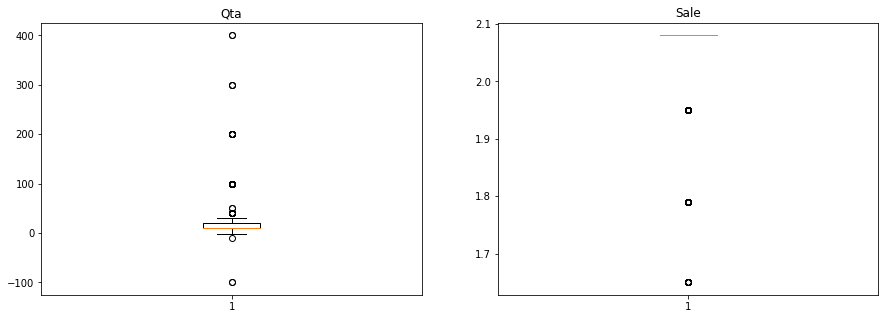

In [72]:
figure, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].boxplot(df_jumbo['Qta'])
ax[0].set_title("Qta")
ax[1].boxplot(df_jumbo['Sale'])
ax[1].set_title("Sale")
plt.show()

We can appreciate how most of the orders have very little variance in quantity (most of the orders buy 10 or 20 of these products at a time). After a short research we found out that jumbo bags are usually containers for other products, useful in many and various circumstances, from the shopping we usually make once a week to the wrapping of presents. Furthermore, shops obviously need to continuosly refill a quite large quantity of these, think for example about a clothing store! 

Therefore these sequence of purchases throughout the period of observation is well motivated and we can make the assumption that the purchases of 10-20 at a time can be maybe made by a small reseller.

<img src="https://images-na.ssl-images-amazon.com/images/I/91ccpvvtJ5L._AC_SX466_.jpg" width=300 height=300/>

***

Let's make a very little digression from our sequence analysis, we notice how the **sale** in this sequence has incredibly small variance, what about the other products in the selected > 90 support sequences?

In [75]:
prod_costs = {}
for prod_id in survived_prodids_90:
    prod_costs[prod_id] = df[df['ProdID'] == prod_id]['Sale'].unique()
prod_costs

{'85099B': array([1.65, 1.95, 2.08, 1.79, 1.74, 1.75, 4.13, 2.04]),
 '22423': array([10.95, 12.75,  4.  ,  5.  , 24.96]),
 '85123A': array([2.55, 2.95, 3.24, 3.2 , 5.79]),
 '23203': array([2.08, 1.95, 1.65, 1.79, 1.75]),
 '20725': array([1.65, 1.45, 4.13])}

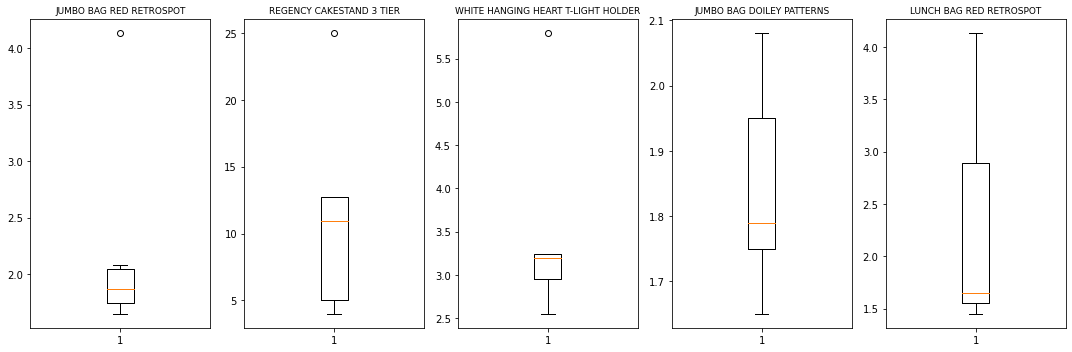

In [88]:

n_cols = (len(prod_costs.keys()))
figure, ax = plt.subplots(1, n_cols, figsize=(15,5))
i = 0
for k,v in prod_costs.items():
    col = i - n_cols 
    ax[col].boxplot(v)
    ax[col].set_title(df[df['ProdID'] == k]['ProdDescr'].unique()[0], fontsize=9)
    i += 1
figure.tight_layout()
plt.show()

A strange behaviour can be noticed about REGENCY CAKESTAND 3 TIER (which can be found in pattern **1694** above), in fact it is the only product among the ones considered which price spikes up from the 'normal' values (5-12) to a peak of 25

In [90]:
# ProdID = 22423 --> regency cakestand
df.loc[(df['ProdID'] == '22423') & (df['Sale'] > 20)]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
350712,567656,2011-09-21 14:40:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,2
361387,568346,2011-09-26 15:28:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1
372627,569246,2011-10-03 09:57:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1
401559,571441,2011-10-17 13:31:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,2
416249,572552,2011-10-24 17:07:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1
429767,573576,2011-10-31 14:09:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1
455039,575607,2011-11-10 12:37:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,2
494461,578270,2011-11-23 13:39:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1
508156,579196,2011-11-28 15:54:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1
527776,580727,2011-12-05 17:17:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,3


As we can see, we have only one customer involved in this anomalous pricing: **14096**

In [96]:
df.loc[(df['ProdID'] == '22423') & (df['CustomerCountry'] == 'United Kingdom') & (df['BasketDate'] > '2011-10-30') & (df['BasketDate'] < '2011-11-01')]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
425380,573320,2011-10-30 10:29:00,10.95,15513,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,16
425419,573323,2011-10-30 10:54:00,12.75,15708,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1
425583,573330,2011-10-30 11:22:00,12.75,16923,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1
428334,573420,2011-10-31 09:48:00,12.75,18223,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,3
428340,573421,2011-10-31 09:50:00,10.95,14292,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,16
429767,573576,2011-10-31 14:09:00,24.96,14096,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1
430218,573584,2011-10-31 14:36:00,12.75,16705,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,8


This fact being an **anomaly** can be better appreciated by looking at a comparison with purchases made on the same product and in the same dates. We tried giving different motivations related to dates, quantities, countries but none of them holds.

***

Going back to the sequence analysis, after the discussion on medium supported patterns we looked at the results of the highest supported sequences (120-200), trying (once again) to give meaning to what we find, describing the motivation for the presence of a pattern or anyway observing particular customers found thanks to their presence in the sequence.

In [34]:
print("INTERESTING SEQUENCES WITH SUPPORT > 200 (AND HAVING MORE THAN ONLY ONE SUBSEQUENCE)\n")
for i in range(len(true_seq_list_200)):
    if len(true_seq_list_200[i][0]) > 1:
        print(f"\n{'-'*50}Sequence index: {i}{'-'*50}\n{get_prod_desc_seq([true_seq_list_200[i]])}\n",
              "-"*120,"\n")

INTERESTING SEQUENCES WITH SUPPORT > 200 (AND HAVING MORE THAN ONLY ONE SUBSEQUENCE)





-----------------Sequence index: 53-----------------
[([['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT']], 222)]
 --------------------------------------------------




-----------------Sequence index: 54-----------------
[([['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER']], 244)]
 --------------------------------------------------




-----------------Sequence index: 55-----------------
[([['PARTY BUNTING'], ['PARTY BUNTING']], 208)]
 --------------------------------------------------




-----------------Sequence index: 56-----------------
[([['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT']], 227)]
 --------------------------------------------------




-----------------Sequence index: 57-----------------
[([['WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER']], 267)]
 --------------------------------------------------


Sequence **55** composed of [PARTY BUNTING], [PARTY BUNTING] is one of the highest supported in the whole dataset, in fact it is supported by 208 customers on the 1101 present ~ 19%

In [35]:
interesting_index = 55
df[(df['CustomerID'].isin(df_customers.iloc[true_seq_list_200[interesting_index][2]][0])) & (df['ProdID'].isin(set([elem for seq in true_seq_list_200[interesting_index][0] for elem in seq])))].describe()

,Sale,CustomerID,Qta
count,807.000000,807.000000,807.000000
mean,4.858327,15391.628253,13.140025
std,0.456712,1765.694144,24.807176
min,3.750000,12388.000000,-50.000000
25%,4.950000,13880.000000,4.000000
50%,4.950000,15249.000000,4.000000
75%,4.950000,17061.000000,8.000000
max,10.790000,18260.000000,200.000000


We can appreciate how most of the times the quantity bought is relatively low: up to the third quartile the quantity does not exceed the value of 8. This quantity of party bountings can be easily described as bought for the decoration of a single generic party (new year's eve, birthday party, etc!). So we can for example infer that customers that contain this sequence had a couple of parties during the period of observation!

**Looking at results without TIME CONSTRAINTS and with support > 120**

In [37]:
print("INTERESTING SEQUENCES WITH SUPPORT > 120 (AND HAVING MORE THAN ONLY THREE SUBSEQUENCE)\n")
for i in range(len(true_seq_list_120)):
    if len(true_seq_list_120[i][0]) > 3:
        print(f"\n{'-'*50}Sequence index: {i}{'-'*50}\n{get_prod_desc_seq([true_seq_list_120[i]])}\n",
              "-"*120,"\n")

INTERESTING SEQUENCES WITH SUPPORT > 120 (AND HAVING MORE THAN ONLY THREE SUBSEQUENCE)





-----------------Sequence index: 488-----------------
[([['WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER']], 139)]
 --------------------------------------------------


Sequence **488** composed of [WHITE HANGING HEART T-LIGHT HOLDER], [WHITE HANGING HEART T-LIGHT HOLDER], [WHITE HANGING HEART T-LIGHT HOLDER], [WHITE HANGING HEART T-LIGHT HOLDER] is the only 4-subsequences sequence supported by more than 120 customers, more specifically supported by 139 customers on the 1101 present ~ 12.5%

In [38]:
interesting_index = 488
df[(df['CustomerID'].isin(df_customers.iloc[true_seq_list_120[interesting_index][2]][0])) & (df['ProdID'].isin(set([elem for seq in true_seq_list_120[interesting_index][0] for elem in seq])))].describe()

,Sale,CustomerID,Qta
count,942.000000,942.000000,942.000000
mean,2.879480,15752.851380,20.921444
std,0.336126,1623.068188,67.204086
min,2.550000,12747.000000,-500.000000
25%,2.650000,14419.250000,3.000000
50%,2.950000,15719.000000,6.000000
75%,2.950000,17315.000000,18.000000
max,5.790000,18283.000000,1010.000000


Taking a look at the statistics we can see that generally this product is not bought in large amounts, but anyway it is bought multiple times by a fair amount of customers throughout the period of observation, so it is safe to say that this particular population likes the product (or if it we take into consideration the sellers among the population, they buy the product regularly because clients like the product!)

In [39]:
# noticing the -500 minimum (highly probable to be an order mistake, we can take a closer look to the customer responsible for it)
df[(df['CustomerID'].isin(df_customers.iloc[true_seq_list_120[interesting_index][2]][0])) & (df['ProdID'].isin(set([elem for seq in true_seq_list_120[interesting_index][0] for elem in seq])) & (df['Qta'] < 0))]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
14529,C537602,2010-12-07 12:45:00,2.55,17511,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1
24911,C538350,2010-12-10 15:01:00,2.55,13798,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1
29949,C538834,2010-12-14 13:06:00,2.95,14415,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1
34284,C539329,2010-12-17 09:37:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-500
38444,C539576,2010-12-20 12:25:00,2.95,14911,EIRE,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-24
44903,C540244,2011-01-05 15:40:00,2.95,17213,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1
53474,C540837,2011-01-11 15:02:00,2.55,14733,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1
68947,C541885,2011-01-24 11:14:00,2.95,16782,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1
74412,C542424,2011-01-28 09:18:00,2.95,18075,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-3
79144,C542910,2011-02-01 15:38:00,2.55,17511,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1


In [40]:
# looking at customer 16013
df[(df['CustomerID'] == 16013) & (df['ProdID'].isin(set([elem for seq in true_seq_list_120[interesting_index][0] for elem in seq])))]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
32720,539109,2010-12-16 11:07:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,500
34284,C539329,2010-12-17 09:37:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-500
47310,540408,2011-01-07 09:55:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,250
87642,543675,2011-02-11 11:31:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,150
117004,546318,2011-03-11 09:20:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,100
173001,551617,2011-05-03 11:41:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,192
207988,555075,2011-05-31 12:05:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,150
259671,559701,2011-07-12 09:10:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,512
308669,564046,2011-08-22 12:59:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,400
308671,564048,2011-08-22 13:20:00,2.55,16013,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,16


As expected, the order of 500 was probably a mistake quickly corrected the next day. Anyhow this british customer may be described as a quite big reseller because of its periodical big orders.

***

Eventually, we approached a time constrained approach.

### UNDERSTANDING TIME CONSTRAINT VALUES

In [43]:
avg_gap  = {}
span = {}

customer_list = df['CustomerID'].unique()

for customer in tqdm(customer_list, total = len(customer_list), desc="Finding average time related parameters"):
    first_date = None
    last_date  = None
    for cust_trans in cust_trans_with_dates_list[customer]: #cust_trans[0] list of products in order, cust_trans[1] date of order
        if first_date == None:
            first_date = cust_trans[1]
        else:
            if customer not in avg_gap:
                avg_gap[customer] = [(cust_trans[1] - last_date).days]
            else:
                avg_gap[customer].append((cust_trans[1] - last_date).days)
        last_date = cust_trans[1]
    avg_gap[customer] = np.mean(avg_gap[customer])
    span[customer] = (cust_trans_with_dates_list[customer][-1][1] - cust_trans_with_dates_list[customer][0][1]).days

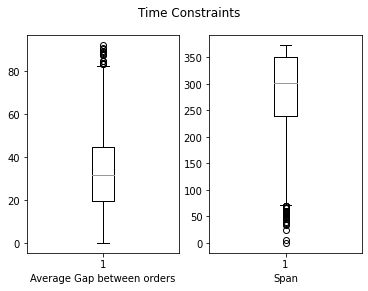

In [44]:
fig, ax = plt.subplots(1, 2)
fig.suptitle('Time Constraints')
ax[0].boxplot(avg_gap.values())
ax[0].set_xlabel('Average Gap between orders')
ax[1].boxplot(span.values())
ax[1].set_xlabel('Span')
plt.show()

In [45]:
dfGap = pd.DataFrame(data = {'avg_gap':avg_gap.values(), 'span':span.values()})
dfGap.describe()

,avg_gap,span
count,1101.000000,1101.000000
mean,34.019457,281.069936
std,18.601643,81.936969
min,0.000000,0.000000
25%,19.666667,239.000000
50%,31.666667,301.000000
75%,44.800000,351.000000
max,92.000000,373.000000


In [46]:
#TODO: Explain choosen values

# TIME CONSTRAINTS

In [47]:
seq_list_time_60 = [([['15036']], 61), ([['15056BL']], 61), ([['15056N']], 61), ([['16156S']], 61), ([['16161P']], 61), ([['16161U']], 61), ([['16169E']], 61), ([['17003']], 61), ([['20675']], 61), ([['20676']], 61), ([['20677']], 61), ([['20679']], 61), ([['20682']], 61), ([['20685']], 61), ([['20711']], 61), ([['20712']], 61), ([['20713']], 61), ([['20717']], 61), ([['20718']], 61), ([['20719']], 61), ([['20723']], 61), ([['20724']], 61), ([['20725']], 61), ([['20726']], 61), ([['20727']], 61), ([['20728']], 61), ([['20749']], 61), ([['20750']], 61), ([['20751']], 61), ([['20754']], 61), ([['20914']], 61), ([['20969']], 61), ([['20970']], 61), ([['20971']], 61), ([['20972']], 61), ([['20973']], 61), ([['20974']], 61), ([['20975']], 61), ([['20978']], 61), ([['20979']], 61), ([['20981']], 61), ([['20982']], 61), ([['20983']], 61), ([['20984']], 61), ([['20992']], 61), ([['20996']], 61), ([['21034']], 61), ([['21035']], 61), ([['21041']], 61), ([['21078']], 61), ([['21080']], 61), ([['21086']], 61), ([['21094']], 61), ([['21098']], 61), ([['21108']], 61), ([['21121']], 61), ([['21122']], 61), ([['21124']], 61), ([['21135']], 61), ([['21136']], 61), ([['21137']], 61), ([['21154']], 61), ([['21155']], 61), ([['21156']], 61), ([['21158']], 61), ([['21164']], 61), ([['21165']], 61), ([['21166']], 61), ([['21169']], 61), ([['21172']], 61), ([['21174']], 61), ([['21175']], 61), ([['21179']], 61), ([['21181']], 61), ([['21210']], 61), ([['21212']], 61), ([['21213']], 61), ([['21216']], 61), ([['21217']], 61), ([['21218']], 61), ([['21231']], 61), ([['21232']], 61), ([['21238']], 61), ([['21239']], 61), ([['21240']], 61), ([['21242']], 61), ([['21259']], 61), ([['21314']], 61), ([['21326']], 61), ([['21340']], 61), ([['21380']], 61), ([['21385']], 61), ([['21390']], 61), ([['21411']], 61), ([['21428']], 61), ([['21429']], 61), ([['21430']], 61), ([['21479']], 61), ([['21481']], 61), ([['21484']], 61), ([['21485']], 61), ([['21497']], 61), ([['21498']], 61), ([['21499']], 61), ([['21500']], 61), ([['21506']], 61), ([['21507']], 61), ([['21508']], 61), ([['21509']], 61), ([['21523']], 61), ([['21524']], 61), ([['21527']], 61), ([['21531']], 61), ([['21533']], 61), ([['21535']], 61), ([['21539']], 61), ([['21558']], 61), ([['21559']], 61), ([['21561']], 61), ([['21592']], 61), ([['21621']], 61), ([['21623']], 61), ([['21668']], 61), ([['21669']], 61), ([['21670']], 61), ([['21671']], 61), ([['21672']], 61), ([['21673']], 61), ([['21703']], 61), ([['21704']], 61), ([['21718']], 61), ([['21731']], 61), ([['21733']], 61), ([['21745']], 61), ([['21746']], 61), ([['21754']], 61), ([['21755']], 61), ([['21756']], 61), ([['21770']], 61), ([['21787']], 61), ([['21790']], 61), ([['21791']], 61), ([['21810']], 61), ([['21811']], 61), ([['21818']], 61), ([['21843']], 61), ([['21868']], 61), ([['21870']], 61), ([['21871']], 61), ([['21874']], 61), ([['21876']], 61), ([['21877']], 61), ([['21878']], 61), ([['21888']], 61), ([['21889']], 61), ([['21891']], 61), ([['21892']], 61), ([['21899']], 61), ([['21900']], 61), ([['21901']], 61), ([['21902']], 61), ([['21903']], 61), ([['21907']], 61), ([['21908']], 61), ([['21912']], 61), ([['21914']], 61), ([['21915']], 61), ([['21916']], 61), ([['21917']], 61), ([['21918']], 61), ([['21922']], 61), ([['21928']], 61), ([['21929']], 61), ([['21930']], 61), ([['21931']], 61), ([['21932']], 61), ([['21933']], 61), ([['21936']], 61), ([['21937']], 61), ([['21955']], 61), ([['21967']], 61), ([['21974']], 61), ([['21975']], 61), ([['21976']], 61), ([['21977']], 61), ([['21980']], 61), ([['21981']], 61), ([['21982']], 61), ([['21985']], 61), ([['21987']], 61), ([['21988']], 61), ([['21989']], 61), ([['21992']], 61), ([['21993']], 61), ([['22024']], 60), ([['22027']], 61), ([['22028']], 61), ([['22029']], 61), ([['22030']], 61), ([['22037']], 61), ([['22045']], 61), ([['22065']], 61), ([['22072']], 60), ([['22077']], 61), ([['22079']], 61), ([['22080']], 61), ([['22082']], 61), ([['22083']], 61), ([['22084']], 61), ([['22086']], 61), ([['22087']], 61), ([['22088']], 61), ([['22089']], 61), ([['22090']], 61), ([['22110']], 61), ([['22111']], 61), ([['22112']], 61), ([['22113']], 61), ([['22114']], 61), ([['22115']], 61), ([['22120']], 61), ([['22131']], 61), ([['22138']], 61), ([['22139']], 61), ([['22141']], 61), ([['22142']], 61), ([['22144']], 61), ([['22147']], 61), ([['22148']], 61), ([['22149']], 61), ([['22150']], 61), ([['22151']], 61), ([['22158']], 61), ([['22169']], 61), ([['22170']], 61), ([['22171']], 61), ([['22173']], 61), ([['22178']], 61), ([['22187']], 61), ([['22188']], 61), ([['22189']], 61), ([['22191']], 61), ([['22192']], 61), ([['22193']], 61), ([['22195']], 61), ([['22196']], 61), ([['22197']], 61), ([['22208']], 61), ([['22212']], 61), ([['22219']], 61), ([['22241']], 61), ([['22271']], 61), ([['22273']], 61), ([['22274']], 61), ([['22294']], 61), ([['22295']], 61), ([['22296']], 61), ([['22297']], 61), ([['22302']], 61), ([['22303']], 61), ([['22326']], 61), ([['22327']], 61), ([['22328']], 61), ([['22329']], 61), ([['22333']], 61), ([['22348']], 61), ([['22352']], 61), ([['22355']], 61), ([['22356']], 61), ([['22367']], 61), ([['22371']], 61), ([['22374']], 60), ([['22379']], 61), ([['22380']], 61), ([['22381']], 61), ([['22382']], 61), ([['22383']], 61), ([['22384']], 61), ([['22385']], 61), ([['22386']], 61), ([['22398']], 61), ([['22400']], 61), ([['22402']], 61), ([['22411']], 61), ([['22413']], 61), ([['22417']], 61), ([['22418']], 61), ([['22423']], 61), ([['22424']], 61), ([['22427']], 61), ([['22429']], 61), ([['22430']], 61), ([['22431']], 61), ([['22432']], 61), ([['22433']], 61), ([['22435']], 61), ([['22436']], 61), ([['22437']], 61), ([['22439']], 61), ([['22440']], 61), ([['22441']], 60), ([['22456']], 61), ([['22457']], 61), ([['22460']], 61), ([['22464']], 61), ([['22465']], 61), ([['22466']], 61), ([['22467']], 61), ([['22469']], 61), ([['22470']], 61), ([['22485']], 61), ([['22487']], 61), ([['22488']], 61), ([['22489']], 61), ([['22491']], 61), ([['22492']], 61), ([['22499']], 61), ([['22501']], 61), ([['22502']], 61), ([['22505']], 61), ([['22507']], 61), ([['22508']], 61), ([['22530']], 61), ([['22531']], 61), ([['22534']], 61), ([['22537']], 61), ([['22548']], 61), ([['22549']], 61), ([['22551']], 61), ([['22553']], 61), ([['22554']], 61), ([['22555']], 61), ([['22556']], 61), ([['22557']], 61), ([['22558']], 61), ([['22560']], 61), ([['22561']], 61), ([['22562']], 61), ([['22563']], 61), ([['22564']], 61), ([['22567']], 61), ([['22568']], 61), ([['22569']], 61), ([['22570']], 61), ([['22571']], 61), ([['22572']], 61), ([['22573']], 61), ([['22574']], 61), ([['22577']], 61), ([['22578']], 61), ([['22579']], 61), ([['22580']], 61), ([['22585']], 61), ([['22588']], 60), ([['22595']], 61), ([['22596']], 61), ([['22601']], 61), ([['22602']], 61), ([['22605']], 61), ([['22607']], 61), ([['22610']], 60), ([['22614']], 61), ([['22616']], 61), ([['22617']], 61), ([['22619']], 61), ([['22620']], 61), ([['22621']], 61), ([['22622']], 61), ([['22623']], 61), ([['22624']], 61), ([['22625']], 61), ([['22626']], 61), ([['22627']], 61), ([['22629']], 61), ([['22630']], 61), ([['22631']], 61), ([['22632']], 61), ([['22633']], 61), ([['22634']], 61), ([['22636']], 61), ([['22637']], 61), ([['22644']], 61), ([['22645']], 61), ([['22646']], 61), ([['22652']], 61), ([['22654']], 61), ([['22659']], 61), ([['22661']], 61), ([['22662']], 61), ([['22663']], 61), ([['22665']], 61), ([['22666']], 61), ([['22667']], 61), ([['22668']], 61), ([['22669']], 61), ([['22670']], 61), ([['22672']], 61), ([['22675']], 61), ([['22690']], 61), ([['22692']], 61), ([['22693']], 61), ([['22694']], 61), ([['22697']], 61), ([['22698']], 61), ([['22699']], 61), ([['22704']], 61), ([['22712']], 61), ([['22713']], 61), ([['22714']], 61), ([['22716']], 61), ([['22720']], 61), ([['22721']], 61), ([['22722']], 61), ([['22723']], 61), ([['22725']], 61), ([['22726']], 61), ([['22727']], 61), ([['22728']], 61), ([['22729']], 61), ([['22730']], 61), ([['22734']], 61), ([['22736']], 61), ([['22737']], 61), ([['22738']], 61), ([['22739']], 61), ([['22741']], 61), ([['22745']], 61), ([['22746']], 61), ([['22747']], 60), ([['22748']], 61), ([['22749']], 61), ([['22750']], 61), ([['22751']], 61), ([['22752']], 61), ([['22754']], 61), ([['22755']], 61), ([['22759']], 61), ([['22766']], 61), ([['22767']], 61), ([['22768']], 61), ([['22771']], 61), ([['22776']], 61), ([['22781']], 61), ([['22784']], 61), ([['22791']], 61), ([['22794']], 61), ([['22795']], 61), ([['22796']], 61), ([['22798']], 61), ([['22801']], 61), ([['22804']], 61), ([['22809']], 61), ([['22816']], 61), ([['22818']], 61), ([['22822']], 61), ([['22834']], 61), ([['22835']], 61), ([['22837']], 61), ([['22838']], 60), ([['22840']], 61), ([['22841']], 61), ([['22842']], 61), ([['22844']], 61), ([['22845']], 61), ([['22846']], 61), ([['22847']], 61), ([['22851']], 61), ([['22854']], 61), ([['22855']], 61), ([['22859']], 61), ([['22865']], 61), ([['22866']], 61), ([['22867']], 61), ([['22892']], 61), ([['22895']], 61), ([['22896']], 61), ([['22897']], 61), ([['22898']], 61), ([['22899']], 61), ([['22900']], 61), ([['22904']], 61), ([['22907']], 61), ([['22908']], 61), ([['22909']], 61), ([['22910']], 61), ([['22916']], 61), ([['22917']], 61), ([['22918']], 61), ([['22919']], 61), ([['22920']], 61), ([['22921']], 61), ([['22926']], 61), ([['22930']], 61), ([['22937']], 61), ([['22938']], 61), ([['22940']], 61), ([['22941']], 61), ([['22943']], 61), ([['22950']], 61), ([['22951']], 61), ([['22952']], 61), ([['22956']], 61), ([['22957']], 61), ([['22959']], 60), ([['22960']], 61), ([['22961']], 61), ([['22962']], 61), ([['22963']], 61), ([['22964']], 61), ([['22965']], 61), ([['22966']], 61), ([['22967']], 61), ([['22968']], 61), ([['22969']], 61), ([['22970']], 61), ([['22971']], 61), ([['22972']], 61), ([['22974']], 61), ([['22975']], 61), ([['22977']], 61), ([['22978']], 61), ([['22979']], 61), ([['22980']], 61), ([['22982']], 61), ([['22983']], 61), ([['22986']], 61), ([['22988']], 61), ([['22989']], 61), ([['22990']], 61), ([['22991']], 61), ([['22992']], 61), ([['22993']], 61), ([['22994']], 61), ([['22995']], 61), ([['22996']], 61), ([['22997']], 61), ([['22998']], 61), ([['22999']], 61), ([['23000']], 61), ([['23005']], 61), ([['23006']], 61), ([['23012']], 61), ([['23013']], 61), ([['23031']], 61), ([['23032']], 61), ([['23035']], 61), ([['23049']], 61), ([['23050']], 61), ([['23052']], 61), ([['23053']], 61), ([['23068']], 60), ([['23076']], 61), ([['23077']], 61), ([['23078']], 61), ([['23080']], 61), ([['23082']], 61), ([['23083']], 61), ([['23084']], 61), ([['23089']], 61), ([['23091']], 61), ([['23093']], 61), ([['23100']], 61), ([['23101']], 61), ([['23102']], 61), ([['23103']], 61), ([['23108']], 61), ([['23109']], 61), ([['23110']], 61), ([['23112']], 61), ([['23118']], 61), ([['23126']], 61), ([['23127']], 61), ([['23128']], 61), ([['23129']], 61), ([['23130']], 60), ([['23144']], 61), ([['23145']], 61), ([['23146']], 61), ([['23147']], 61), ([['23148']], 61), ([['23152']], 61), ([['23154']], 61), ([['23156']], 61), ([['23157']], 61), ([['23158']], 61), ([['23159']], 61), ([['23165']], 61), ([['23166']], 61), ([['23168']], 61), ([['23169']], 61), ([['23170']], 61), ([['23171']], 61), ([['23172']], 61), ([['23173']], 61), ([['23174']], 61), ([['23175']], 61), ([['23176']], 61), ([['23177']], 61), ([['23182']], 61), ([['23184']], 61), ([['23188']], 61), ([['23190']], 61), ([['23191']], 61), ([['23192']], 61), ([['23194']], 61), ([['23196']], 61), ([['23197']], 61), ([['23198']], 61), ([['23199']], 61), ([['23200']], 61), ([['23201']], 61), ([['23202']], 61), ([['23203']], 61), ([['23204']], 61), ([['23205']], 61), ([['23206']], 61), ([['23207']], 61), ([['23208']], 61), ([['23209']], 61), ([['23215']], 61), ([['23229']], 61), ([['23230']], 61), ([['23231']], 61), ([['23232']], 61), ([['23233']], 61), ([['23234']], 61), ([['23236']], 61), ([['23237']], 61), ([['23238']], 61), ([['23239']], 61), ([['23240']], 61), ([['23241']], 61), ([['23242']], 61), ([['23243']], 61), ([['23244']], 60), ([['23245']], 61), ([['23247']], 61), ([['23252']], 60), ([['23254']], 61), ([['23255']], 61), ([['23256']], 61), ([['23263']], 61), ([['23264']], 61), ([['23265']], 61), ([['23266']], 61), ([['23275']], 61), ([['23283']], 61), ([['23284']], 61), ([['23285']], 60), ([['23286']], 61), ([['23287']], 61), ([['23288']], 60), ([['23289']], 61), ([['23290']], 61), ([['23292']], 61), ([['23293']], 61), ([['23294']], 61), ([['23295']], 61), ([['23296']], 61), ([['23297']], 61), ([['23298']], 61), ([['23299']], 61), ([['23300']], 61), ([['23301']], 61), ([['23302']], 61), ([['23306']], 61), ([['23307']], 61), ([['23308']], 61), ([['23309']], 61), ([['23310']], 61), ([['23311']], 61), ([['23312']], 61), ([['23313']], 61), ([['23318']], 61), ([['23319']], 61), ([['23320']], 61), ([['23321']], 61), ([['23322']], 61), ([['23323']], 61), ([['23328']], 61), ([['23329']], 61), ([['23330']], 61), ([['23332']], 61), ([['23333']], 61), ([['23340']], 61), ([['23342']], 61), ([['23343']], 61), ([['23344']], 61), ([['23345']], 60), ([['23346']], 60), ([['23349']], 61), ([['23350']], 61), ([['23351']], 61), ([['23352']], 61), ([['23353']], 61), ([['23354']], 61), ([['23355']], 61), ([['23356']], 61), ([['23360']], 60), ([['23366']], 60), ([['23367']], 61), ([['23368']], 61), ([['23374']], 61), ([['23378']], 61), ([['23382']], 61), ([['23388']], 61), ([['23389']], 61), ([['23390']], 61), ([['23393']], 61), ([['23395']], 61), ([['23396']], 61), ([['23397']], 61), ([['23399']], 61), ([['23404']], 61), ([['23407']], 61), ([['23426']], 61), ([['23434']], 61), ([['23439']], 61), ([['23480']], 61), ([['23489']], 61), ([['23493']], 61), ([['23494']], 61), ([['23497']], 61), ([['23503']], 61), ([['23504']], 61), ([['23506']], 61), ([['23534']], 61), ([['23535']], 61), ([['23541']], 61), ([['23546']], 61), ([['23552']], 61), ([['23569']], 61), ([['23570']], 61), ([['23571']], 61), ([['23581']], 61), ([['23582']], 61), ([['23583']], 61), ([['23681']], 61), ([['35961']], 61), ([['35970']], 61), ([['46000S']], 61), ([['47504K']], 61), ([['47559B']], 61), ([['47566']], 61), ([['47566B']], 61), ([['47590A']], 61), ([['47590B']], 61), ([['47591D']], 61), ([['48111']], 61), ([['48116']], 61), ([['48129']], 61), ([['48138']], 61), ([['48173C']], 61), ([['48184']], 61), ([['48185']], 61), ([['48187']], 61), ([['48188']], 61), ([['48194']], 61), ([['71053']], 61), ([['71459']], 61), ([['71477']], 61), ([['72741']], 61), ([['79321']], 61), ([['82482']], 61), ([['82483']], 61), ([['82484']], 61), ([['82486']], 61), ([['82494L']], 61), ([['82551']], 61), ([['82552']], 61), ([['82578']], 61), ([['82580']], 61), ([['82581']], 61), ([['82582']], 61), ([['82583']], 61), ([['82600']], 61), ([['84029E']], 61), ([['84029G']], 61), ([['84030E']], 61), ([['84050']], 61), ([['84077']], 61), ([['84347']], 61), ([['84375']], 61), ([['84378']], 61), ([['84380']], 61), ([['84406B']], 61), ([['84536A']], 61), ([['84596B']], 61), ([['84596F']], 61), ([['84692']], 61), ([['84755']], 61), ([['84792']], 61), ([['84832']], 61), ([['84836']], 61), ([['84879']], 61), ([['84945']], 61), ([['84946']], 61), ([['84947']], 61), ([['84949']], 61), ([['84970L']], 61), ([['84970S']], 61), ([['84978']], 61), ([['84987']], 61), ([['84988']], 61), ([['84991']], 61), ([['84992']], 61), ([['84997A']], 61), ([['84997B']], 61), ([['84997C']], 61), ([['84997D']], 61), ([['85014A']], 61), ([['85014B']], 61), ([['85048']], 61), ([['85049A']], 61), ([['85049C']], 61), ([['85049E']], 61), ([['85049G']], 61), ([['85053']], 61), ([['85066']], 61), ([['85099B']], 61), ([['85099C']], 61), ([['85099F']], 61), ([['85123A']], 61), ([['85150']], 61), ([['85152']], 61), ([['85184C']], 61), ([['20685', '48138']], 61), ([['20685', '85123A']], 60), ([['20712', '20713']], 61), ([['20712', '20725']], 61), ([['20712', '20726']], 61), ([['20712', '21929']], 61), ([['20712', '21931']], 61), ([['20712', '22386']], 61), ([['20712', '23203']], 60), ([['20712', '85099B']], 61), ([['20713', '21931']], 61), ([['20713', '85099B']], 61), ([['20717', '20718']], 61), ([['20718', '20725']], 61), ([['20718', '85099B']], 61), ([['20719', '20723']], 61), ([['20719', '20724']], 61), ([['20719', '20725']], 61), ([['20719', '20726']], 61), ([['20719', '22355']], 61), ([['20719', '22356']], 61), ([['20719', '23204']], 61), ([['20723', '20724']], 61), ([['20723', '20725']], 61), ([['20723', '20727']], 61), ([['20723', '20728']], 61), ([['20723', '22355']], 61), ([['20723', '22356']], 61), ([['20723', '23204']], 61), ([['20723', '85099B']], 61), ([['20724', '20725']], 61), ([['20724', '20727']], 61), ([['20724', '20728']], 61), ([['20724', '21931']], 61), ([['20724', '22355']], 61), ([['20724', '22356']], 61), ([['20724', '22382']], 61), ([['20724', '22383']], 61), ([['20724', '22384']], 61), ([['20724', '22661']], 61), ([['20724', '23204']], 61), ([['20724', '23205']], 61), ([['20724', '23206']], 61), ([['20724', '23209']], 61), ([['20724', '85099B']], 61), ([['20725', '20726']], 61), ([['20725', '20727']], 61), ([['20725', '20728']], 61), ([['20725', '21080']], 61), ([['20725', '21212']], 61), ([['20725', '21928']], 61), ([['20725', '21929']], 61), ([['20725', '21930']], 60), ([['20725', '21931']], 61), ([['20725', '21936']], 61), ([['20725', '22355']], 61), ([['20725', '22382']], 61), ([['20725', '22383']], 61), ([['20725', '22384']], 61), ([['20725', '22385']], 61), ([['20725', '22386']], 61), ([['20725', '22411']], 61), ([['20725', '22423']], 61), ([['20725', '22662']], 61), ([['20725', '22720']], 60), ([['20725', '23199']], 61), ([['20725', '23201']], 61), ([['20725', '23202']], 61), ([['20725', '23203']], 61), ([['20725', '23206']], 61), ([['20725', '23207']], 61), ([['20725', '23208']], 61), ([['20725', '23209']], 61), ([['20725', '23298']], 61), ([['20725', '47566']], 61), ([['20725', '85099B']], 61), ([['20725', '85099C']], 61), ([['20725', '85099F']], 61), ([['20725', '85123A']], 61), ([['20726', '20727']], 61), ([['20726', '20728']], 61), ([['20726', '21931']], 60), ([['20726', '22382']], 61), ([['20726', '22383']], 61), ([['20726', '22384']], 61), ([['20726', '22662']], 61), ([['20726', '23199']], 61), ([['20726', '23203']], 61), ([['20726', '23206']], 61), ([['20726', '23207']], 61), ([['20726', '23208']], 61), ([['20726', '23209']], 61), ([['20726', '85099B']], 61), ([['20727', '20728']], 61), ([['20727', '21212']], 61), ([['20727', '21929']], 61), ([['20727', '21930']], 61), ([['20727', '21931']], 61), ([['20727', '22355']], 61), ([['20727', '22382']], 61), ([['20727', '22383']], 61), ([['20727', '22384']], 61), ([['20727', '22385']], 61), ([['20727', '22386']], 61), ([['20727', '22411']], 60), ([['20727', '22662']], 61), ([['20727', '23199']], 61), ([['20727', '23201']], 61), ([['20727', '23202']], 61), ([['20727', '23203']], 61), ([['20727', '23206']], 61), ([['20727', '23207']], 61), ([['20727', '23208']], 61), ([['20727', '23209']], 61), ([['20727', '85099B']], 61), ([['20727', '85099C']], 61), ([['20727', '85099F']], 60), ([['20727', '85123A']], 61), ([['20728', '21930']], 60), ([['20728', '21931']], 61), ([['20728', '22382']], 61), ([['20728', '22383']], 61), ([['20728', '22384']], 61), ([['20728', '22386']], 61), ([['20728', '22411']], 61), ([['20728', '22662']], 61), ([['20728', '23199']], 61), ([['20728', '23201']], 61), ([['20728', '23203']], 61), ([['20728', '23206']], 61), ([['20728', '23207']], 61), ([['20728', '23208']], 61), ([['20728', '23209']], 61), ([['20728', '85099B']], 61), ([['20728', '85123A']], 61), ([['20914', '21212']], 61), ([['20971', '20972']], 61), ([['21080', '21086']], 61), ([['21080', '21094']], 61), ([['21080', '21212']], 61), ([['21086', '21094']], 61), ([['21121', '21122']], 61), ([['21121', '21124']], 61), ([['21122', '21124']], 61), ([['21136', '84879']], 61), ([['21156', '22367']], 61), ([['21166', '21175']], 61), ([['21166', '21181']], 61), ([['21166', '85152']], 61), ([['21175', '21181']], 61), ([['21175', '21908']], 61), ([['21175', '22413']], 60), ([['21175', '85123A']], 61), ([['21175', '85152']], 61), ([['21181', '85123A']], 61), ([['21181', '85150']], 61), ([['21181', '85152']], 61), ([['21210', '21212']], 61), ([['21212', '21213']], 61), ([['21212', '21975']], 61), ([['21212', '21977']], 61), ([['21212', '22382']], 61), ([['21212', '22383']], 61), ([['21212', '22417']], 61), ([['21212', '22423']], 61), ([['21212', '22720']], 61), ([['21212', '22951']], 61), ([['21212', '22960']], 61), ([['21212', '22961']], 61), ([['21212', '22993']], 61), ([['21212', '23307']], 61), ([['21212', '47566']], 61), ([['21212', '84991']], 61), ([['21212', '84992']], 61), ([['21212', '85099B']], 61), ([['21213', '84991']], 61), ([['21231', '21232']], 61), ([['21485', '22111']], 61), ([['21485', '22112']], 61), ([['21485', '22113']], 61), ([['21533', '21535']], 61), ([['21558', '21559']], 61), ([['21559', '22352']], 61), ([['21668', '21669']], 61), ([['21668', '21670']], 61), ([['21668', '21671']], 61), ([['21668', '21672']], 61), ([['21668', '21673']], 61), ([['21669', '21670']], 61), ([['21669', '21671']], 61), ([['21669', '21672']], 61), ([['21669', '21673']], 61), ([['21670', '21671']], 61), ([['21670', '21672']], 61), ([['21670', '21673']], 61), ([['21671', '21672']], 61), ([['21671', '21673']], 61), ([['21672', '21673']], 61), ([['21731', '23084']], 61), ([['21733', '22469']], 61), ([['21733', '22470']], 61), ([['21733', '22804']], 61), ([['21733', '85123A']], 61), ([['21754', '21755']], 61), ([['21754', '21756']], 61), ([['21754', '84879']], 61), ([['21754', '85123A']], 61), ([['21755', '85123A']], 61), ([['21790', '21791']], 61), ([['21790', '21889']], 60), ([['21843', '22423']], 61), ([['21899', '21900']], 61), ([['21900', '21901']], 60), ([['21908', '85152']], 61), ([['21914', '21915']], 61), ([['21928', '21929']], 61), ([['21928', '21931']], 61), ([['21928', '22386']], 61), ([['21928', '22411']], 61), ([['21928', '23199']], 60), ([['21928', '23203']], 61), ([['21928', '85099B']], 61), ([['21928', '85099C']], 61), ([['21928', '85099F']], 61), ([['21929', '21931']], 61), ([['21929', '22383']], 61), ([['21929', '22384']], 61), ([['21929', '22386']], 61), ([['21929', '22411']], 61), ([['21929', '23199']], 61), ([['21929', '23201']], 61), ([['21929', '23202']], 61), ([['21929', '23203']], 61), ([['21929', '85099B']], 61), ([['21929', '85099C']], 61), ([['21929', '85099F']], 61), ([['21930', '21931']], 61), ([['21930', '22383']], 61), ([['21930', '22384']], 61), ([['21930', '22386']], 61), ([['21930', '23201']], 60), ([['21930', '23203']], 61), ([['21930', '85099B']], 61), ([['21931', '22382']], 61), ([['21931', '22383']], 61), ([['21931', '22384']], 61), ([['21931', '22385']], 61), ([['21931', '22386']], 61), ([['21931', '22411']], 61), ([['21931', '23199']], 61), ([['21931', '23201']], 61), ([['21931', '23202']], 61), ([['21931', '23203']], 61), ([['21931', '23206']], 61), ([['21931', '23209']], 61), ([['21931', '85099B']], 61), ([['21931', '85099C']], 61), ([['21931', '85099F']], 61), ([['21932', '21933']], 61), ([['21936', '21937']], 61), ([['21936', '85099B']], 61), ([['21975', '21977']], 61), ([['21975', '22417']], 61), ([['21975', '84991']], 61), ([['21975', '84992']], 61), ([['21977', '84991']], 61), ([['21977', '84992']], 61), ([['22077', '85049E']], 60), ([['22086', '22865']], 61), ([['22086', '22909']], 61), ([['22086', '22910']], 61), ([['22086', '22952']], 61), ([['22086', '23319']], 61), ([['22086', '23344']], 61), ([['22086', '23355']], 61), ([['22090', '47566']], 60), ([['22111', '22112']], 61), ([['22111', '22113']], 61), ([['22111', '22835']], 60), ([['22111', '22866']], 61), ([['22111', '23355']], 61), ([['22111', '23356']], 61), ([['22112', '22113']], 60), ([['22112', '22114']], 61), ([['22112', '22835']], 61), ([['22112', '23355']], 61), ([['22114', '22835']], 61), ([['22114', '23355']], 61), ([['22138', '22139']], 61), ([['22138', '22617']], 61), ([['22141', '22142']], 61), ([['22141', '22144']], 61), ([['22142', '22144']], 61), ([['22147', '22149']], 61), ([['22178', '85123A']], 61), ([['22189', '85123A']], 61), ([['22191', '22192']], 61), ([['22191', '22193']], 61), ([['22192', '22193']], 61), ([['22326', '22328']], 61), ([['22355', '22356']], 61), ([['22355', '22383']], 61), ([['22355', '23204']], 61), ([['22355', '23205']], 61), ([['22356', '85099B']], 61), ([['22367', '47591D']], 61), ([['22379', '85099B']], 61), ([['22382', '22383']], 61), ([['22382', '22384']], 61), ([['22382', '22385']], 61), ([['22382', '22386']], 61), ([['22382', '22629']], 61), ([['22382', '22662']], 61), ([['22382', '23199']], 61), ([['22382', '23203']], 61), ([['22382', '23206']], 61), ([['22382', '23207']], 61), ([['22382', '23208']], 61), ([['22382', '23209']], 61), ([['22382', '85099B']], 61), ([['22382', '85123A']], 61), ([['22383', '22384']], 61), ([['22383', '22386']], 61), ([['22383', '22411']], 61), ([['22383', '22662']], 61), ([['22383', '23199']], 61), ([['22383', '23201']], 61), ([['22383', '23202']], 61), ([['22383', '23203']], 61), ([['22383', '23206']], 61), ([['22383', '23207']], 61), ([['22383', '23208']], 61), ([['22383', '23209']], 61), ([['22383', '47566']], 61), ([['22383', '85099B']], 61), ([['22383', '85099C']], 60), ([['22383', '85123A']], 61), ([['22384', '22386']], 61), ([['22384', '22411']], 61), ([['22384', '22662']], 61), ([['22384', '23199']], 61), ([['22384', '23201']], 60), ([['22384', '23202']], 61), ([['22384', '23203']], 61), ([['22384', '23206']], 61), ([['22384', '23207']], 61), ([['22384', '23208']], 61), ([['22384', '23209']], 61), ([['22384', '23298']], 61), ([['22384', '47566']], 60), ([['22384', '85099B']], 61), ([['22384', '85099F']], 61), ([['22384', '85123A']], 61), ([['22385', '22386']], 61), ([['22385', '22411']], 61), ([['22385', '23199']], 61), ([['22385', '23202']], 61), ([['22385', '23203']], 61), ([['22385', '85099B']], 61), ([['22385', '85099F']], 61), ([['22386', '22411']], 61), ([['22386', '23199']], 61), ([['22386', '23201']], 61), ([['22386', '23202']], 61), ([['22386', '23203']], 61), ([['22386', '23206']], 61), ([['22386', '23209']], 61), ([['22386', '85099B']], 61), ([['22386', '85099C']], 61), ([['22386', '85099F']], 61), ([['22411', '23199']], 61), ([['22411', '23201']], 61), ([['22411', '23202']], 61), ([['22411', '23203']], 61), ([['22411', '23209']], 61), ([['22411', '85099B']], 61), ([['22411', '85099C']], 61), ([['22411', '85099F']], 61), ([['22417', '84991']], 61), ([['22417', '84992']], 61), ([['22423', '22697']], 61), ([['22423', '22698']], 61), ([['22423', '22699']], 61), ([['22423', '22720']], 61), ([['22423', '22727']], 61), ([['22423', '22960']], 61), ([['22423', '22961']], 61), ([['22423', '23170']], 61), ([['22423', '23173']], 61), ([['22423', '23174']], 61), ([['22423', '23175']], 61), ([['22423', '23245']], 61), ([['22423', '47566']], 61), ([['22423', '82482']], 61), ([['22423', '84879']], 61), ([['22423', '85099B']], 61), ([['22423', '85123A']], 61), ([['22431', '22432']], 61), ([['22457', '22469']], 61), ([['22457', '47566']], 61), ([['22457', '85123A']], 61), ([['22469', '22470']], 61), ([['22469', '23321']], 61), ([['22469', '23322']], 61), ([['22469', '82482']], 61), ([['22469', '85123A']], 61), ([['22470', '23321']], 61), ([['22470', '23322']], 61), ([['22470', '82482']], 61), ([['22470', '82494L']], 61), ([['22470', '85123A']], 61), ([['22551', '22553']], 61), ([['22551', '22554']], 61), ([['22551', '22555']], 61), ([['22551', '22556']], 61), ([['22551', '22557']], 61), ([['22553', '22554']], 61), ([['22554', '22555']], 61), ([['22554', '22556']], 61), ([['22554', '22557']], 61), ([['22555', '22556']], 61), ([['22555', '22557']], 61), ([['22562', '22563']], 61), ([['22568', '22569']], 61), ([['22568', '22570']], 61), ([['22569', '22570']], 61), ([['22577', '22578']], 61), ([['22577', '22579']], 61), ([['22578', '22579']], 61), ([['22624', '22625']], 61), ([['22624', '22627']], 61), ([['22625', '22627']], 61), ([['22629', '22630']], 61), ([['22629', '22631']], 61), ([['22632', '22633']], 61), ([['22632', '22865']], 61), ([['22632', '22866']], 61), ([['22632', '22867']], 60), ([['22633', '22865']], 61), ([['22633', '22866']], 61), ([['22633', '22867']], 61), ([['22633', '23439']], 61), ([['22662', '23206']], 61), ([['22662', '23207']], 61), ([['22662', '23209']], 61), ([['22663', '85099B']], 61), ([['22666', '22667']], 61), ([['22666', '22720']], 61), ([['22666', '22722']], 61), ([['22666', '22960']], 61), ([['22666', '22961']], 61), ([['22666', '22993']], 61), ([['22666', '85123A']], 61), ([['22697', '22698']], 61), ([['22697', '22699']], 61), ([['22697', '23171']], 60), ([['22697', '23173']], 61), ([['22698', '22699']], 61), ([['22698', '23173']], 61), ([['22699', '23170']], 61), ([['22699', '23171']], 61), ([['22699', '23173']], 61), ([['22720', '22722']], 61), ([['22720', '22907']], 61), ([['22720', '22960']], 61), ([['22720', '22961']], 61), ([['22720', '22993']], 61), ([['22720', '23243']], 61), ([['22720', '23245']], 61), ([['22720', '47566']], 61), ([['22720', '85099B']], 61), ([['22720', '85123A']], 61), ([['22722', '22723']], 60), ([['22722', '22960']], 61), ([['22725', '22726']], 61), ([['22725', '22727']], 61), ([['22725', '22728']], 61), ([['22725', '22730']], 61), ([['22726', '22727']], 61), ([['22726', '22728']], 61), ([['22726', '22729']], 61), ([['22726', '22730']], 61), ([['22727', '22728']], 61), ([['22727', '22729']], 61), ([['22727', '22730']], 61), ([['22728', '22729']], 61), ([['22728', '22730']], 61), ([['22745', '22746']], 61), ([['22745', '22748']], 61), ([['22746', '22748']], 61), ([['22749', '22750']], 61), ([['22749', '22751']], 61), ([['22750', '22751']], 61), ([['22804', '85123A']], 61), ([['22835', '23355']], 61), ([['22844', '22845']], 60), ([['22865', '22866']], 61), ([['22865', '22867']], 61), ([['22865', '23355']], 61), ([['22865', '23439']], 61), ([['22866', '22867']], 61), ([['22866', '23439']], 61), ([['22867', '23439']], 61), ([['22909', '22910']], 61), ([['22909', '22952']], 61), ([['22910', '22952']], 61), ([['22910', '23313']], 60), ([['22916', '22917']], 61), ([['22916', '22918']], 61), ([['22916', '22919']], 61), ([['22916', '22920']], 61), ([['22917', '22918']], 61), ([['22917', '22919']], 61), ([['22917', '22920']], 61), ([['22917', '22921']], 60), ([['22918', '22919']], 61), ([['22918', '22920']], 61), ([['22919', '22920']], 61), ([['22960', '22961']], 61), ([['22960', '22993']], 61), ([['22962', '22963']], 61), ([['22966', '22993']], 61), ([['22966', '84378']], 61), ([['22966', '84380']], 61), ([['22991', '22992']], 60), ([['22993', '47566']], 60), ([['22996', '22998']], 61), ([['23146', '23147']], 60), ([['23170', '23171']], 61), ([['23170', '23172']], 61), ([['23170', '23173']], 61), ([['23170', '23174']], 61), ([['23170', '23175']], 61), ([['23171', '23172']], 61), ([['23173', '23174']], 61), ([['23173', '23175']], 61), ([['23174', '23175']], 61), ([['23199', '23200']], 61), ([['23199', '23201']], 61), ([['23199', '23202']], 61), ([['23199', '23203']], 61), ([['23199', '23204']], 61), ([['23199', '23206']], 61), ([['23199', '23207']], 61), ([['23199', '23208']], 61), ([['23199', '23209']], 61), ([['23199', '85099B']], 61), ([['23199', '85099C']], 61), ([['23199', '85099F']], 61), ([['23200', '23201']], 61), ([['23200', '23202']], 61), ([['23200', '23203']], 61), ([['23200', '23206']], 61), ([['23200', '23208']], 61), ([['23200', '23209']], 61), ([['23200', '85099B']], 61), ([['23201', '23202']], 61), ([['23201', '23203']], 61), ([['23201', '23205']], 61), ([['23201', '23206']], 61), ([['23201', '23207']], 61), ([['23201', '23208']], 61), ([['23201', '23209']], 61), ([['23201', '85099B']], 61), ([['23201', '85099C']], 61), ([['23201', '85099F']], 60), ([['23202', '23203']], 61), ([['23202', '23206']], 61), ([['23202', '23207']], 61), ([['23202', '23208']], 61), ([['23202', '23209']], 61), ([['23202', '23298']], 61), ([['23202', '23344']], 61), ([['23202', '85099B']], 61), ([['23202', '85099C']], 61), ([['23202', '85099F']], 60), ([['23203', '23206']], 61), ([['23203', '23207']], 61), ([['23203', '23208']], 61), ([['23203', '23209']], 61), ([['23203', '23298']], 61), ([['23203', '23343']], 61), ([['23203', '23344']], 61), ([['23203', '23582']], 61), ([['23203', '47566']], 61), ([['23203', '85099B']], 61), ([['23203', '85099C']], 61), ([['23203', '85099F']], 61), ([['23204', '23205']], 61), ([['23204', '23206']], 61), ([['23204', '23209']], 61), ([['23206', '23207']], 61), ([['23206', '23208']], 61), ([['23206', '23209']], 61), ([['23206', '23298']], 61), ([['23206', '85099B']], 61), ([['23207', '23208']], 61), ([['23207', '23209']], 61), ([['23207', '85099B']], 61), ([['23208', '23209']], 61), ([['23208', '85099B']], 61), ([['23209', '23298']], 61), ([['23209', '23583']], 61), ([['23209', '47566']], 61), ([['23209', '85099B']], 61), ([['23209', '85123A']], 61), ([['23236', '23240']], 61), ([['23240', '23245']], 61), ([['23243', '23245']], 61), ([['23254', '23256']], 61), ([['23263', '23265']], 61), ([['23263', '23266']], 61), ([['23264', '23266']], 61), ([['23265', '23266']], 61), ([['23284', '23301']], 61), ([['23293', '23294']], 61), ([['23293', '23295']], 61), ([['23293', '23296']], 61), ([['23294', '23295']], 61), ([['23294', '23296']], 61), ([['23295', '23296']], 61), ([['23298', '47566']], 61), ([['23298', '85099B']], 61), ([['23298', '85123A']], 61), ([['23300', '23301']], 61), ([['23306', '23307']], 60), ([['23307', '23308']], 61), ([['23307', '23309']], 61), ([['23307', '84991']], 61), ([['23318', '23319']], 61), ([['23321', '23322']], 61), ([['23321', '85123A']], 61), ([['23322', '85123A']], 61), ([['23343', '23344']], 61), ([['23343', '85099B']], 61), ([['23344', '23581']], 60), ([['23344', '85099B']], 61), ([['23349', '23351']], 61), ([['23351', '23352']], 61), ([['23351', '23354']], 61), ([['23353', '23354']], 61), ([['23355', '23356']], 61), ([['23355', '23439']], 61), ([['23581', '23582']], 61), ([['23581', '23583']], 61), ([['23582', '23583']], 61), ([['47566', '47566B']], 61), ([['47566', '84879']], 61), ([['47566', '85099B']], 61), ([['47566', '85123A']], 61), ([['47590A', '47590B']], 61), ([['82482', '82483']], 61), ([['82482', '82484']], 61), ([['82482', '82486']], 61), ([['82482', '82494L']], 61), ([['82482', '85123A']], 61), ([['82483', '82486']], 61), ([['82483', '82494L']], 61), ([['82483', '85123A']], 61), ([['82484', '85123A']], 61), ([['82486', '82494L']], 61), ([['82486', '85123A']], 61), ([['82494L', '85123A']], 61), ([['82551', '82552']], 61), ([['82578', '82580']], 61), ([['82578', '82581']], 61), ([['82580', '82581']], 61), ([['84378', '84380']], 61), ([['84596B', '84596F']], 61), ([['84836', '85123A']], 61), ([['84879', '85123A']], 61), ([['84970L', '84970S']], 61), ([['84978', '85123A']], 60), ([['84991', '84992']], 61), ([['84997A', '84997B']], 61), ([['84997B', '84997C']], 61), ([['84997B', '84997D']], 61), ([['84997C', '84997D']], 61), ([['85014A', '85014B']], 61), ([['85099B', '85099C']], 61), ([['85099B', '85099F']], 61), ([['85099B', '85123A']], 61), ([['85099C', '85099F']], 61), ([['20725'], ['20725']], 61), ([['20725'], ['85099B']], 61), ([['20727'], ['20725']], 61), ([['20727'], ['20727']], 61), ([['21733'], ['85123A']], 61), ([['22086'], ['22086']], 61), ([['22197'], ['22197']], 60), ([['22423'], ['22423']], 61), ([['22469'], ['22469']], 61), ([['22720'], ['22720']], 61), ([['22726'], ['22726']], 61), ([['23084'], ['23084']], 61), ([['23199'], ['23199']], 61), ([['23199'], ['23203']], 61), ([['23199'], ['85099B']], 61), ([['23201'], ['23201']], 61), ([['23201'], ['23203']], 61), ([['23201'], ['85099B']], 61), ([['23202'], ['23202']], 61), ([['23202'], ['23203']], 61), ([['23203'], ['23202']], 61), ([['23203'], ['23203']], 61), ([['23203'], ['23209']], 61), ([['23203'], ['85099B']], 61), ([['23206'], ['23203']], 61), ([['23206'], ['23206']], 61), ([['23206'], ['23209']], 61), ([['23207'], ['23203']], 60), ([['23207'], ['23209']], 61), ([['23208'], ['23209']], 61), ([['23209'], ['23203']], 61), ([['23209'], ['23209']], 61), ([['23284'], ['23284']], 60), ([['23298'], ['23298']], 61), ([['23298'], ['47566']], 61), ([['23301'], ['23301']], 61), ([['23344'], ['23344']], 61), ([['23355'], ['23355']], 61), ([['47566'], ['47566']], 61), ([['84879'], ['84879']], 61), ([['85099B'], ['85099B']], 61), ([['85123A'], ['85123A']], 61), ([['21733', '85123A'], ['85123A']], 60), ([['23203'], ['23203'], ['23203']], 60), ([['23203', '23209'], ['23203']], 61), ([['23203', '23209'], ['23209']], 61)]
seq_list_time_90 = [([['15036']], 91), ([['15056N']], 91), ([['16161P']], 91), ([['20676']], 91), ([['20685']], 91), ([['20711']], 91), ([['20712']], 91), ([['20713']], 91), ([['20717']], 91), ([['20718']], 91), ([['20719']], 91), ([['20723']], 91), ([['20724']], 91), ([['20725']], 91), ([['20726']], 91), ([['20727']], 91), ([['20728']], 91), ([['20749']], 91), ([['20750']], 91), ([['20754']], 91), ([['20914']], 91), ([['20971']], 91), ([['20972']], 91), ([['20973']], 91), ([['20974']], 91), ([['20975']], 91), ([['21034']], 91), ([['21080']], 91), ([['21086']], 91), ([['21094']], 91), ([['21121']], 91), ([['21122']], 91), ([['21136']], 91), ([['21154']], 91), ([['21155']], 91), ([['21156']], 91), ([['21164']], 91), ([['21165']], 91), ([['21166']], 91), ([['21169']], 91), ([['21172']], 91), ([['21174']], 91), ([['21175']], 91), ([['21181']], 91), ([['21210']], 91), ([['21212']], 91), ([['21213']], 91), ([['21216']], 91), ([['21217']], 91), ([['21231']], 91), ([['21232']], 91), ([['21314']], 91), ([['21340']], 91), ([['21430']], 91), ([['21479']], 91), ([['21481']], 91), ([['21484']], 91), ([['21485']], 91), ([['21497']], 91), ([['21498']], 91), ([['21506']], 91), ([['21523']], 91), ([['21524']], 91), ([['21533']], 91), ([['21535']], 91), ([['21558']], 91), ([['21559']], 91), ([['21621']], 91), ([['21668']], 91), ([['21669']], 91), ([['21670']], 91), ([['21671']], 91), ([['21672']], 91), ([['21673']], 91), ([['21731']], 91), ([['21733']], 91), ([['21754']], 91), ([['21755']], 91), ([['21756']], 91), ([['21770']], 91), ([['21790']], 91), ([['21791']], 91), ([['21843']], 91), ([['21868']], 91), ([['21876']], 91), ([['21877']], 91), ([['21889']], 91), ([['21891']], 91), ([['21892']], 91), ([['21907']], 91), ([['21908']], 91), ([['21914']], 91), ([['21915']], 91), ([['21916']], 91), ([['21918']], 91), ([['21928']], 91), ([['21929']], 91), ([['21930']], 91), ([['21931']], 91), ([['21932']], 91), ([['21933']], 91), ([['21936']], 91), ([['21937']], 91), ([['21975']], 91), ([['21976']], 91), ([['21977']], 91), ([['21980']], 91), ([['21982']], 91), ([['21985']], 91), ([['22027']], 91), ([['22029']], 91), ([['22030']], 91), ([['22037']], 91), ([['22077']], 91), ([['22079']], 91), ([['22082']], 91), ([['22083']], 91), ([['22084']], 91), ([['22086']], 91), ([['22090']], 91), ([['22111']], 91), ([['22112']], 91), ([['22113']], 91), ([['22114']], 91), ([['22138']], 91), ([['22139']], 91), ([['22141']], 91), ([['22142']], 91), ([['22144']], 91), ([['22147']], 91), ([['22148']], 90), ([['22149']], 91), ([['22150']], 91), ([['22151']], 91), ([['22158']], 91), ([['22171']], 91), ([['22173']], 91), ([['22178']], 91), ([['22189']], 91), ([['22191']], 91), ([['22192']], 91), ([['22193']], 91), ([['22197']], 91), ([['22212']], 91), ([['22219']], 91), ([['22271']], 91), ([['22273']], 91), ([['22294']], 91), ([['22296']], 91), ([['22297']], 91), ([['22326']], 91), ([['22328']], 91), ([['22333']], 91), ([['22352']], 91), ([['22355']], 91), ([['22356']], 91), ([['22367']], 91), ([['22379']], 91), ([['22382']], 91), ([['22383']], 91), ([['22384']], 91), ([['22385']], 91), ([['22386']], 91), ([['22398']], 90), ([['22411']], 91), ([['22413']], 91), ([['22417']], 91), ([['22423']], 91), ([['22424']], 90), ([['22427']], 91), ([['22429']], 91), ([['22431']], 91), ([['22432']], 91), ([['22456']], 91), ([['22457']], 91), ([['22464']], 91), ([['22467']], 91), ([['22469']], 91), ([['22470']], 91), ([['22487']], 91), ([['22488']], 91), ([['22489']], 91), ([['22492']], 91), ([['22499']], 91), ([['22501']], 91), ([['22502']], 91), ([['22505']], 91), ([['22507']], 91), ([['22549']], 91), ([['22551']], 91), ([['22553']], 91), ([['22554']], 91), ([['22555']], 91), ([['22556']], 91), ([['22557']], 91), ([['22558']], 91), ([['22560']], 91), ([['22561']], 91), ([['22568']], 91), ([['22569']], 91), ([['22570']], 91), ([['22577']], 91), ([['22578']], 91), ([['22579']], 91), ([['22585']], 91), ([['22595']], 91), ([['22607']], 91), ([['22616']], 91), ([['22617']], 91), ([['22619']], 91), ([['22620']], 91), ([['22621']], 91), ([['22624']], 91), ([['22625']], 91), ([['22627']], 91), ([['22629']], 91), ([['22630']], 91), ([['22631']], 91), ([['22632']], 91), ([['22633']], 91), ([['22637']], 91), ([['22652']], 91), ([['22659']], 91), ([['22661']], 91), ([['22662']], 91), ([['22663']], 91), ([['22666']], 91), ([['22667']], 91), ([['22668']], 91), ([['22690']], 91), ([['22692']], 91), ([['22694']], 91), ([['22697']], 91), ([['22698']], 91), ([['22699']], 91), ([['22720']], 91), ([['22721']], 91), ([['22722']], 91), ([['22723']], 91), ([['22725']], 91), ([['22726']], 91), ([['22727']], 91), ([['22728']], 91), ([['22729']], 91), ([['22730']], 91), ([['22734']], 91), ([['22745']], 91), ([['22748']], 91), ([['22749']], 91), ([['22750']], 91), ([['22752']], 91), ([['22759']], 91), ([['22766']], 91), ([['22771']], 91), ([['22776']], 91), ([['22784']], 91), ([['22795']], 91), ([['22804']], 91), ([['22834']], 91), ([['22835']], 91), ([['22844']], 91), ([['22846']], 91), ([['22847']], 91), ([['22851']], 91), ([['22865']], 91), ([['22866']], 91), ([['22867']], 91), ([['22896']], 90), ([['22898']], 91), ([['22899']], 91), ([['22900']], 91), ([['22907']], 91), ([['22908']], 91), ([['22909']], 91), ([['22910']], 91), ([['22940']], 91), ([['22941']], 91), ([['22951']], 91), ([['22952']], 91), ([['22957']], 91), ([['22960']], 91), ([['22961']], 91), ([['22962']], 91), ([['22963']], 91), ([['22964']], 91), ([['22966']], 91), ([['22969']], 91), ([['22970']], 91), ([['22971']], 91), ([['22979']], 91), ([['22980']], 91), ([['22983']], 91), ([['22988']], 91), ([['22989']], 91), ([['22991']], 91), ([['22992']], 91), ([['22993']], 91), ([['22996']], 91), ([['22998']], 91), ([['23076']], 91), ([['23077']], 91), ([['23082']], 91), ([['23084']], 91), ([['23100']], 91), ([['23101']], 91), ([['23103']], 91), ([['23108']], 91), ([['23109']], 91), ([['23110']], 91), ([['23126']], 91), ([['23144']], 91), ([['23146']], 90), ([['23147']], 91), ([['23165']], 90), ([['23169']], 91), ([['23170']], 91), ([['23171']], 91), ([['23172']], 91), ([['23173']], 91), ([['23174']], 91), ([['23175']], 91), ([['23188']], 91), ([['23191']], 91), ([['23192']], 91), ([['23196']], 91), ([['23198']], 91), ([['23199']], 91), ([['23200']], 91), ([['23201']], 91), ([['23202']], 91), ([['23203']], 91), ([['23204']], 91), ([['23205']], 91), ([['23206']], 91), ([['23207']], 91), ([['23208']], 91), ([['23209']], 91), ([['23230']], 91), ([['23231']], 91), ([['23232']], 91), ([['23234']], 91), ([['23236']], 91), ([['23238']], 91), ([['23240']], 91), ([['23241']], 91), ([['23243']], 91), ([['23245']], 91), ([['23247']], 91), ([['23254']], 91), ([['23256']], 91), ([['23263']], 91), ([['23264']], 91), ([['23265']], 91), ([['23266']], 91), ([['23275']], 91), ([['23284']], 91), ([['23293']], 91), ([['23294']], 91), ([['23295']], 91), ([['23296']], 91), ([['23298']], 91), ([['23300']], 91), ([['23301']], 91), ([['23306']], 91), ([['23307']], 91), ([['23308']], 91), ([['23309']], 91), ([['23311']], 91), ([['23312']], 91), ([['23313']], 91), ([['23318']], 91), ([['23319']], 91), ([['23320']], 91), ([['23321']], 91), ([['23322']], 91), ([['23323']], 91), ([['23328']], 91), ([['23329']], 91), ([['23332']], 91), ([['23333']], 91), ([['23343']], 91), ([['23344']], 91), ([['23349']], 91), ([['23350']], 91), ([['23351']], 91), ([['23353']], 91), ([['23354']], 91), ([['23355']], 91), ([['23356']], 91), ([['23367']], 91), ([['23439']], 91), ([['23493']], 91), ([['23497']], 90), ([['23503']], 91), ([['23534']], 91), ([['23570']], 91), ([['23571']], 91), ([['23581']], 91), ([['23582']], 91), ([['23583']], 91), ([['35970']], 91), ([['47566']], 91), ([['47566B']], 91), ([['47590A']], 91), ([['47590B']], 91), ([['47591D']], 91), ([['48138']], 91), ([['48184']], 91), ([['48187']], 91), ([['48188']], 91), ([['48194']], 91), ([['71459']], 91), ([['79321']], 91), ([['82482']], 91), ([['82483']], 91), ([['82484']], 91), ([['82486']], 91), ([['82494L']], 91), ([['82551']], 91), ([['82552']], 91), ([['82580']], 91), ([['82581']], 91), ([['82582']], 91), ([['82583']], 91), ([['82600']], 91), ([['84029E']], 91), ([['84029G']], 91), ([['84030E']], 91), ([['84077']], 91), ([['84347']], 91), ([['84375']], 91), ([['84378']], 91), ([['84380']], 91), ([['84596B']], 91), ([['84692']], 91), ([['84755']], 91), ([['84836']], 91), ([['84879']], 91), ([['84945']], 91), ([['84946']], 91), ([['84970L']], 91), ([['84970S']], 91), ([['84978']], 91), ([['84987']], 91), ([['84988']], 91), ([['84991']], 91), ([['84992']], 91), ([['84997B']], 91), ([['84997C']], 91), ([['84997D']], 91), ([['85014A']], 91), ([['85014B']], 91), ([['85049A']], 91), ([['85049E']], 91), ([['85066']], 91), ([['85099B']], 91), ([['85099C']], 91), ([['85099F']], 91), ([['85123A']], 91), ([['85150']], 91), ([['85152']], 91), ([['20712', '85099B']], 91), ([['20723', '20724']], 91), ([['20724', '20725']], 91), ([['20724', '22356']], 91), ([['20724', '85099B']], 91), ([['20725', '20726']], 91), ([['20725', '20727']], 91), ([['20725', '20728']], 91), ([['20725', '21212']], 91), ([['20725', '22382']], 91), ([['20725', '22383']], 91), ([['20725', '22384']], 91), ([['20725', '22386']], 91), ([['20725', '22662']], 91), ([['20725', '23203']], 91), ([['20725', '23206']], 91), ([['20725', '23207']], 91), ([['20725', '23208']], 91), ([['20725', '23209']], 91), ([['20725', '85099B']], 91), ([['20726', '20727']], 91), ([['20726', '20728']], 91), ([['20726', '22382']], 91), ([['20726', '22383']], 91), ([['20726', '22384']], 91), ([['20726', '23206']], 91), ([['20726', '23209']], 91), ([['20727', '20728']], 91), ([['20727', '22382']], 91), ([['20727', '22383']], 91), ([['20727', '22384']], 91), ([['20727', '22662']], 91), ([['20727', '23203']], 91), ([['20727', '23206']], 91), ([['20727', '23207']], 91), ([['20727', '23208']], 91), ([['20727', '23209']], 91), ([['20727', '85099B']], 91), ([['20728', '22382']], 91), ([['20728', '22383']], 91), ([['20728', '22384']], 91), ([['20728', '22662']], 91), ([['20728', '23206']], 91), ([['20728', '23207']], 91), ([['20728', '23209']], 91), ([['20728', '85099B']], 91), ([['21166', '21175']], 91), ([['21212', '21213']], 90), ([['21212', '21975']], 91), ([['21212', '21977']], 91), ([['21212', '84991']], 91), ([['21212', '84992']], 91), ([['21485', '22111']], 91), ([['21733', '85123A']], 91), ([['21754', '21755']], 91), ([['21914', '21915']], 91), ([['21928', '21929']], 91), ([['21928', '85099B']], 91), ([['21929', '22386']], 91), ([['21929', '22411']], 91), ([['21929', '85099B']], 91), ([['21930', '85099B']], 91), ([['21931', '22383']], 91), ([['21931', '85099B']], 91), ([['21977', '84991']], 91), ([['22086', '22910']], 91), ([['22112', '22114']], 91), ([['22112', '22835']], 91), ([['22112', '23355']], 90), ([['22138', '22617']], 91), ([['22141', '22144']], 91), ([['22382', '22383']], 91), ([['22382', '22384']], 91), ([['22382', '22662']], 91), ([['22382', '23206']], 91), ([['22382', '23207']], 91), ([['22382', '23209']], 91), ([['22382', '85099B']], 91), ([['22383', '22384']], 91), ([['22383', '22662']], 91), ([['22383', '23206']], 91), ([['22383', '23207']], 91), ([['22383', '23208']], 91), ([['22383', '23209']], 91), ([['22383', '85099B']], 91), ([['22384', '22386']], 91), ([['22384', '23203']], 91), ([['22384', '23206']], 91), ([['22384', '23207']], 91), ([['22384', '23209']], 91), ([['22384', '85099B']], 91), ([['22385', '85099B']], 91), ([['22386', '23203']], 91), ([['22386', '85099B']], 91), ([['22386', '85099F']], 91), ([['22411', '23203']], 91), ([['22411', '85099B']], 91), ([['22423', '22697']], 91), ([['22423', '22698']], 91), ([['22423', '22699']], 91), ([['22423', '23245']], 91), ([['22423', '85123A']], 90), ([['22457', '85123A']], 91), ([['22469', '22470']], 91), ([['22469', '85123A']], 91), ([['22470', '85123A']], 91), ([['22551', '22554']], 91), ([['22577', '22578']], 91), ([['22578', '22579']], 91), ([['22624', '22625']], 91), ([['22629', '22630']], 91), ([['22666', '22720']], 91), ([['22697', '22698']], 91), ([['22697', '22699']], 91), ([['22698', '22699']], 91), ([['22720', '22722']], 91), ([['22720', '23243']], 91), ([['22725', '22727']], 91), ([['22726', '22727']], 91), ([['22726', '22728']], 91), ([['22726', '22730']], 91), ([['22727', '22728']], 91), ([['22727', '22730']], 91), ([['22728', '22730']], 91), ([['22804', '85123A']], 91), ([['22865', '22866']], 91), ([['22865', '22867']], 91), ([['22865', '23439']], 91), ([['22960', '22961']], 91), ([['23170', '23171']], 91), ([['23170', '23172']], 90), ([['23171', '23172']], 91), ([['23173', '23175']], 91), ([['23174', '23175']], 91), ([['23199', '23200']], 91), ([['23199', '23201']], 91), ([['23199', '23202']], 91), ([['23199', '23203']], 91), ([['23199', '23206']], 91), ([['23199', '23209']], 91), ([['23199', '85099B']], 91), ([['23200', '23202']], 91), ([['23200', '23203']], 91), ([['23201', '23202']], 91), ([['23201', '23203']], 91), ([['23201', '23207']], 91), ([['23201', '23209']], 90), ([['23201', '85099B']], 91), ([['23202', '23203']], 91), ([['23202', '23208']], 91), ([['23202', '23209']], 91), ([['23202', '85099B']], 91), ([['23203', '23206']], 91), ([['23203', '23207']], 91), ([['23203', '23209']], 91), ([['23203', '23344']], 91), ([['23203', '85099B']], 91), ([['23206', '23207']], 91), ([['23206', '23208']], 91), ([['23206', '23209']], 91), ([['23206', '85099B']], 91), ([['23207', '23208']], 91), ([['23207', '23209']], 91), ([['23208', '23209']], 91), ([['23209', '85099B']], 91), ([['23298', '47566']], 91), ([['23300', '23301']], 91), ([['23321', '23322']], 91), ([['23343', '23344']], 91), ([['23355', '23356']], 91), ([['23581', '23582']], 91), ([['47566', '85123A']], 91), ([['47590A', '47590B']], 90), ([['82482', '82494L']], 91), ([['82482', '85123A']], 91), ([['82483', '82486']], 91), ([['82494L', '85123A']], 91), ([['84378', '84380']], 91), ([['84879', '85123A']], 91), ([['84991', '84992']], 91), ([['85099B', '85099C']], 91), ([['85099B', '85099F']], 91), ([['22423'], ['22423']], 91), ([['22720'], ['22720']], 91), ([['23084'], ['23084']], 91), ([['23203'], ['23203']], 91), ([['23298'], ['23298']], 91), ([['85123A'], ['85123A']], 91)]
seq_list_time_150 = [([['20685']], 151), ([['20724']], 151), ([['20725']], 151), ([['20726']], 151), ([['20727']], 151), ([['20728']], 151), ([['20914']], 151), ([['20972']], 151), ([['21034']], 151), ([['21080']], 151), ([['21166']], 151), ([['21175']], 151), ([['21181']], 151), ([['21212']], 151), ([['21213']], 150), ([['21232']], 151), ([['21485']], 151), ([['21524']], 151), ([['21733']], 151), ([['21754']], 151), ([['21755']], 151), ([['21790']], 151), ([['21791']], 151), ([['21889']], 151), ([['21914']], 151), ([['21915']], 151), ([['21929']], 151), ([['21931']], 151), ([['21977']], 151), ([['22077']], 151), ([['22083']], 151), ([['22086']], 151), ([['22090']], 151), ([['22111']], 151), ([['22112']], 151), ([['22113']], 151), ([['22114']], 151), ([['22138']], 151), ([['22139']], 151), ([['22144']], 151), ([['22147']], 151), ([['22149']], 151), ([['22178']], 151), ([['22197']], 151), ([['22382']], 151), ([['22383']], 151), ([['22384']], 151), ([['22385']], 151), ([['22386']], 151), ([['22411']], 151), ([['22423']], 151), ([['22457']], 151), ([['22469']], 151), ([['22470']], 151), ([['22551']], 151), ([['22554']], 151), ([['22558']], 151), ([['22577']], 151), ([['22578']], 151), ([['22621']], 151), ([['22624']], 151), ([['22625']], 151), ([['22629']], 151), ([['22633']], 151), ([['22662']], 151), ([['22666']], 151), ([['22697']], 151), ([['22698']], 151), ([['22699']], 151), ([['22720']], 151), ([['22722']], 151), ([['22726']], 151), ([['22727']], 151), ([['22728']], 151), ([['22730']], 151), ([['22865']], 151), ([['22866']], 151), ([['22867']], 151), ([['22907']], 151), ([['22909']], 151), ([['22910']], 151), ([['22952']], 151), ([['22960']], 151), ([['22961']], 151), ([['22966']], 151), ([['22969']], 151), ([['22993']], 151), ([['23084']], 151), ([['23199']], 151), ([['23200']], 151), ([['23201']], 151), ([['23202']], 151), ([['23203']], 151), ([['23206']], 151), ([['23207']], 151), ([['23208']], 151), ([['23209']], 151), ([['23240']], 151), ([['23243']], 151), ([['23245']], 151), ([['23284']], 151), ([['23293']], 151), ([['23298']], 151), ([['23300']], 151), ([['23301']], 151), ([['23307']], 151), ([['23321']], 151), ([['23322']], 151), ([['23343']], 151), ([['23344']], 151), ([['23355']], 151), ([['23356']], 151), ([['23581']], 151), ([['23583']], 151), ([['47566']], 151), ([['48138']], 151), ([['48187']], 151), ([['48194']], 151), ([['82482']], 151), ([['82484']], 150), ([['82494L']], 151), ([['84378']], 151), ([['84380']], 151), ([['84755']], 151), ([['84879']], 151), ([['84946']], 151), ([['84970S']], 151), ([['84978']], 151), ([['84991']], 151), ([['84992']], 151), ([['85099B']], 151), ([['85099C']], 151), ([['85099F']], 151), ([['85123A']], 151), ([['85152']], 151), ([['20725', '20727']], 151), ([['20725', '20728']], 151), ([['20725', '22382']], 150), ([['20725', '22383']], 151), ([['20725', '22384']], 151), ([['20725', '23209']], 151), ([['20725', '85099B']], 151), ([['20727', '22384']], 151), ([['20728', '22383']], 150), ([['22086', '22910']], 151), ([['22386', '85099B']], 151), ([['22697', '22699']], 151), ([['22726', '22727']], 151), ([['23202', '23203']], 151), ([['23203', '23209']], 151), ([['23203', '85099B']], 151), ([['82482', '82494L']], 151)]
seq_list_time_200 = [([['20725']], 201), ([['20726']], 201), ([['20727']], 201), ([['20728']], 201), ([['21080']], 201), ([['21212']], 201), ([['21733']], 201), ([['21754']], 201), ([['21977']], 201), ([['22086']], 201), ([['22111']], 201), ([['22138']], 201), ([['22139']], 201), ([['22382']], 201), ([['22383']], 201), ([['22384']], 201), ([['22386']], 201), ([['22423']], 201), ([['22457']], 201), ([['22469']], 201), ([['22470']], 201), ([['22666']], 201), ([['22699']], 201), ([['22720']], 201), ([['22722']], 201), ([['22727']], 201), ([['22865']], 201), ([['22910']], 201), ([['22960']], 201), ([['22961']], 201), ([['22993']], 201), ([['23084']], 201), ([['23199']], 201), ([['23201']], 201), ([['23202']], 201), ([['23203']], 201), ([['23206']], 201), ([['23207']], 201), ([['23209']], 201), ([['23245']], 201), ([['23284']], 201), ([['23298']], 201), ([['23307']], 200), ([['23321']], 201), ([['23344']], 201), ([['23355']], 201), ([['47566']], 201), ([['82482']], 201), ([['82494L']], 201), ([['84879']], 201), ([['84991']], 201), ([['85099B']], 201), ([['85123A']], 201)]

In [55]:
# from patterns of ProdID to patterns of ProdDescr
seq_list_prod_time_60 = get_prod_desc_seq(seq_list_time_60)
seq_list_prod_time_90 = get_prod_desc_seq(seq_list_time_90)
seq_list_prod_time_150 = get_prod_desc_seq(seq_list_time_150)
seq_list_prod_time_200 = get_prod_desc_seq(seq_list_time_200)

In [56]:
print("Comparison between the length of the list without and with time constraints")
print("Support 60: ", len(seq_list_60), len(seq_list_time_60))
print("Support 90: ", len(seq_list_90), len(seq_list_time_90))
print("Support 150: ", len(seq_list_150), len(seq_list_time_150))
print("Support 200: ", len(seq_list_200), len(seq_list_time_200))

Comparison between the length of the list without and with time constraints
Support 60:  11693 1555
Support 90:  1703 649
Support 150:  192 152
Support 200:  58 53


#### HAVING SUPPORT > 60 and printing only from above LEVEL 2

In [50]:
for trans in seq_list_prod_time_60:
    if len(trans[0]) > 1:
        print(trans[0])

[['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT']]
[['LUNCH BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT']]
[['LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG RED RETROSPOT']]
[['LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG  BLACK SKULL.']]
[['RED HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER']]
[["PAPER CHAIN KIT 50'S CHRISTMAS "], ["PAPER CHAIN KIT 50'S CHRISTMAS "]]
[['SMALL POPCORN HOLDER'], ['SMALL POPCORN HOLDER']]
[['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER']]
[['HEART OF WICKER SMALL'], ['HEART OF WICKER SMALL']]
[['SET OF 3 CAKE TINS PANTRY DESIGN '], ['SET OF 3 CAKE TINS PANTRY DESIGN ']]
[['ALARM CLOCK BAKELIKE GREEN'], ['ALARM CLOCK BAKELIKE GREEN']]
[['RABBIT NIGHT LIGHT'], ['RABBIT NIGHT LIGHT']]
[['JUMBO BAG APPLES'], ['JUMBO BAG APPLES']]
[['JUMBO BAG APPLES'], ['JUMBO BAG DOILEY PATTERNS']]
[['JUMBO BAG APPLES'], ['JUMBO BAG RED RETROSPOT']]
[['JUMBO BAG ALPHABET'], ['JUMBO BAG ALPHABET']]
[['JUMBO BAG ALPHABET'], ['JUMBO BAG DOILEY PATT

#### HAVING SUPPORT > 90 and printing only from above LEVEL 1

In [51]:
for trans in seq_list_prod_time_90:
    if len(trans[0]) > 1:
        print(trans[0])

[['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER']]
[['SET OF 3 CAKE TINS PANTRY DESIGN '], ['SET OF 3 CAKE TINS PANTRY DESIGN ']]
[['RABBIT NIGHT LIGHT'], ['RABBIT NIGHT LIGHT']]
[['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS']]
[['SPOTTY BUNTING'], ['SPOTTY BUNTING']]
[['WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER']]


#### HAVING SUPPORT > 150 and printing only from above LEVEL 1

In [52]:
for trans in seq_list_prod_time_150:
    if len(trans[0]) > 1:
        print(trans[0])

#### HAVING SUPPORT > 200 and printing only from above LEVEL 1

In [53]:
for trans in seq_list_prod_time_200:
    if len(trans[0]) > 1:
        print(trans[0])

---

## Functions pattern for analysis

Only the lower supported sequences gave interesting result.

In [57]:
dt_input = [elem[0] for elem in seq_list_time_60]
patterns = []
for i in trange(len(dt_input), desc=f"Computing Support"):
    support,customers = countSupport(list(cust_trans_with_dates_list.values()), dt_input[i], 60, 0, 45, 240, True)
    patterns.append((dt_input[i], support, customers))

In [58]:
for i in range(len(patterns)):
    if len(patterns[i][0]) > 1:
        print(i, get_prod_desc_seq([patterns[i]]))


1509 [([['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT']], 76)]



1510 [([['LUNCH BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT']], 64)]



1511 [([['LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG RED RETROSPOT']], 67)]



1512 [([['LUNCH BAG  BLACK SKULL.'], ['LUNCH BAG  BLACK SKULL.']], 72)]



1513 [([['RED HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER']], 62)]



1514 [([["PAPER CHAIN KIT 50'S CHRISTMAS "], ["PAPER CHAIN KIT 50'S CHRISTMAS "]], 78)]



1515 [([['SMALL POPCORN HOLDER'], ['SMALL POPCORN HOLDER']], 60)]



1516 [([['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER']], 111)]



1517 [([['HEART OF WICKER SMALL'], ['HEART OF WICKER SMALL']], 67)]



1518 [([['SET OF 3 CAKE TINS PANTRY DESIGN '], ['SET OF 3 CAKE TINS PANTRY DESIGN ']], 93)]



1519 [([['ALARM CLOCK BAKELIKE GREEN'], ['ALARM CLOCK BAKELIKE GREEN']], 64)]



1520 [([['RABBIT NIGHT LIGHT'], ['RABBIT NIGHT LIGHT']], 98)]



1521 [([['JUMBO BAG APPLES'], ['JUMBO BAG APPLES']], 68)]



1522 [([['JUMBO BAG APPLES'], ['JUMBO BAG DOILEY PATTERNS']], 69)]



1523 [([['JUMBO BAG APPLES'], ['JUMBO BAG RED RETROSPOT']], 64)]



1524 [([['JUMBO BAG ALPHABET'], ['JUMBO BAG ALPHABET']], 62)]



1525 [([['JUMBO BAG ALPHABET'], ['JUMBO BAG DOILEY PATTERNS']], 65)]



1526 [([['JUMBO BAG ALPHABET'], ['JUMBO BAG RED RETROSPOT']], 61)]



1527 [([['JUMBO BAG VINTAGE LEAF'], ['JUMBO BAG VINTAGE LEAF']], 68)]



1528 [([['JUMBO BAG VINTAGE LEAF'], ['JUMBO BAG DOILEY PATTERNS']], 64)]



1529 [([['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG VINTAGE LEAF']], 61)]



1530 [([['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS']], 98)]



1531 [([['JUMBO BAG DOILEY PATTERNS'], ['LUNCH BAG DOILEY PATTERN ']], 69)]



1532 [([['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG RED RETROSPOT']], 69)]



1533 [([['LUNCH BAG APPLE DESIGN'], ['JUMBO BAG DOILEY PATTERNS']], 70)]



1534 [([['LUNCH BAG APPLE DESIGN'], ['LUNCH BAG APPLE DESIGN']], 66)]



1535 [([['LUNCH BAG APPLE DESIGN'], ['LUNCH BAG DOILEY PATTERN ']], 77)]



1536 [([['LUNCH BAG ALPHABET DESIGN'], ['JUMBO BAG DOILEY PATTERNS']], 60)]



1537 [([['LUNCH BAG ALPHABET DESIGN'], ['LUNCH BAG DOILEY PATTERN ']], 68)]



1538 [([['LUNCH BAG VINTAGE LEAF DESIGN'], ['LUNCH BAG DOILEY PATTERN ']], 61)]



1539 [([['LUNCH BAG DOILEY PATTERN '], ['JUMBO BAG DOILEY PATTERNS']], 76)]



1540 [([['LUNCH BAG DOILEY PATTERN '], ['LUNCH BAG DOILEY PATTERN ']], 85)]



1541 [([['DOORMAT KEEP CALM AND COME IN'], ['DOORMAT KEEP CALM AND COME IN']], 60)]



1542 [([['SPOTTY BUNTING'], ['SPOTTY BUNTING']], 91)]



1543 [([['SPOTTY BUNTING'], ['PARTY BUNTING']], 66)]



1544 [([['GARDENERS KNEELING PAD KEEP CALM '], ['GARDENERS KNEELING PAD KEEP CALM ']], 72)]



1545 [([["JUMBO BAG 50'S CHRISTMAS "], ["JUMBO BAG 50'S CHRISTMAS "]], 69)]



1546 [([['HOT WATER BOTTLE KEEP CALM'], ['HOT WATER BOTTLE KEEP CALM']], 72)]



1547 [([['PARTY BUNTING'], ['PARTY BUNTING']], 89)]



1548 [([['ASSORTED COLOUR BIRD ORNAMENT'], ['ASSORTED COLOUR BIRD ORNAMENT']], 66)]



1549 [([['JUMBO BAG RED RETROSPOT'], ['JUMBO BAG RED RETROSPOT']], 74)]



1550 [([['WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER']], 110)]



1551 [([['RED HANGING HEART T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER'], ['WHITE HANGING HEART T-LIGHT HOLDER']], 60)]



1552 [([['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS'], ['JUMBO BAG DOILEY PATTERNS']], 60)]



1553 [([['JUMBO BAG DOILEY PATTERNS', 'LUNCH BAG DOILEY PATTERN '], ['JUMBO BAG DOILEY PATTERNS']], 64)]



1554 [([['JUMBO BAG DOILEY PATTERNS', 'LUNCH BAG DOILEY PATTERN '], ['LUNCH BAG DOILEY PATTERN ']], 62)]


Let's analyze:
- The pattern with higher support
- One that contains a two items in the same sequence of the pattern

In [59]:
# create the dataset of the customers that share a common pattern
print("Pattern that will be analyzed: ", get_prod_desc_seq([patterns[1516]]))
df_customers = pd.DataFrame(df['CustomerID'].unique())
df_pattern = df[(df['CustomerID'].isin(df_customers.iloc[patterns[1516][2]][0])) & (df['ProdID'].isin(set([elem for seq in patterns[1516][0] for elem in seq])))]


Pattern that will be analyzed:  [([['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER']], 111)]


In [60]:
df_pattern.describe()

,Sale,CustomerID,Qta
count,610.000000,610.000000,610.000000
mean,12.306885,14692.581967,9.583607
std,1.846928,1484.595946,20.346999
min,10.950000,12415.000000,-48.000000
25%,10.950000,13468.000000,1.000000
50%,12.750000,14911.000000,3.000000
75%,12.750000,15465.000000,16.000000
max,24.960000,18260.000000,272.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x19cc9a117c0>,
 'caps': [<matplotlib.lines.Line2D at 0x19cc9a11e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x19cc9a11460>],
 'medians': [<matplotlib.lines.Line2D at 0x19cc9a1c580>],
 'fliers': [<matplotlib.lines.Line2D at 0x19cc9a1c8e0>],
 'means': []}

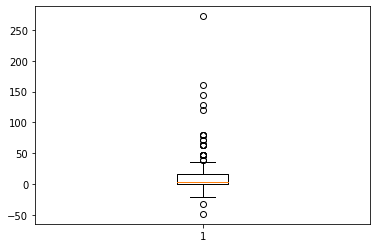

In [61]:
plt.boxplot(df_pattern['Qta'])

In [62]:
print("Total products: ", len(df_pattern))
print("Products with a quantity > 50: ", len(df_pattern[df_pattern['Qta']>=50]))
print("Products with a quantity [0-50]: ", len(df_pattern[(df_pattern['Qta']<50) & (df_pattern['Qta']>0)]))

Total products:  610
Products with a quantity > 50:  16
Products with a quantity [0-50]:  507


In [78]:
# # Orders per customer
# for customer in df_pattern['CustomerID'].unique():
#     print("### Customer : ", customer)
#     print(df_pattern[(df_pattern['CustomerID'] == customer)][['BasketDate', 'Qta']])

Let's focus now only on some customers that have some interesting behaviour.

They were chosen using the block of code above that for cleanness was commented.

In [64]:
df_pattern[df_pattern['CustomerID'] == 15061]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
4505,536785,2010-12-02 15:22:00,10.95,15061,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,144
14784,537618,2010-12-07 13:50:00,10.95,15061,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,80
23263,538191,2010-12-10 10:49:00,10.95,15061,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,272
31603,538998,2010-12-15 12:08:00,10.95,15061,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,80
130236,547419,2011-03-23 10:27:00,10.95,15061,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,48
140473,548406,2011-03-31 09:57:00,10.95,15061,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,24
175597,551976,2011-05-05 13:29:00,10.95,15061,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,24
186918,552888,2011-05-12 10:23:00,10.95,15061,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,120
234656,557572,2011-06-21 10:55:00,10.95,15061,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,32
274556,560925,2011-07-22 09:02:00,10.95,15061,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,72


In [65]:
df_pattern[df_pattern['CustomerID'] == 14646]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
96201,544480,2011-02-21 10:32:00,10.95,14646,Netherlands,22423,REGENCY CAKESTAND 3 TIER,64
137018,548011,2011-03-29 11:14:00,10.95,14646,Netherlands,22423,REGENCY CAKESTAND 3 TIER,32
186819,552883,2011-05-12 10:13:00,10.95,14646,Netherlands,22423,REGENCY CAKESTAND 3 TIER,16
205668,554827,2011-05-26 15:19:00,10.95,14646,Netherlands,22423,REGENCY CAKESTAND 3 TIER,32
299013,563076,2011-08-11 16:12:00,10.95,14646,Netherlands,22423,REGENCY CAKESTAND 3 TIER,32
347035,567280,2011-09-19 11:46:00,10.95,14646,Netherlands,22423,REGENCY CAKESTAND 3 TIER,16
408901,572035,2011-10-20 12:03:00,10.95,14646,Netherlands,22423,REGENCY CAKESTAND 3 TIER,64
534914,581175,2011-12-07 15:16:00,10.95,14646,Netherlands,22423,REGENCY CAKESTAND 3 TIER,32


In [66]:
df_pattern[df_pattern['CustomerID'] == 12415]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
90198,543989,2011-02-15 09:52:00,10.95,12415,Australia,22423,REGENCY CAKESTAND 3 TIER,64
108000,545475,2011-03-03 10:59:00,10.95,12415,Australia,22423,REGENCY CAKESTAND 3 TIER,32
228240,556917,2011-06-15 13:37:00,10.95,12415,Australia,22423,REGENCY CAKESTAND 3 TIER,32
304915,563614,2011-08-18 08:51:00,10.95,12415,Australia,22423,REGENCY CAKESTAND 3 TIER,32
378417,569650,2011-10-05 12:44:00,10.95,12415,Australia,22423,REGENCY CAKESTAND 3 TIER,16


In this case the customers can be described as the owners of a shops around the world.

In fact their orders have an average quantity which is pretty high, and also the orders are kinda frequent during the year.

This seems to represent the orders for the restock of warehouses.

In [67]:
df_pattern[df_pattern['CustomerID'] == 14911]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
6721,536975,2010-12-03 14:04:00,12.75,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,4
12434,537378,2010-12-06 13:06:00,12.75,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,12
20063,538009,2010-12-09 12:17:00,10.95,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,16
23869,538255,2010-12-10 12:33:00,12.75,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,6
37637,539473,2010-12-19 14:24:00,12.75,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,2
135119,547882,2011-03-28 07:53:00,12.75,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,1
144853,548858,2011-04-04 13:29:00,12.75,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,1
148556,549242,2011-04-07 11:41:00,12.75,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,2
175301,551950,2011-05-05 11:38:00,12.75,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,2
191561,553375,2011-05-16 14:53:00,12.75,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,6


In this case, instead, the customer 14911 can be described as an on-line reseller based in Ireland.

Since the quantity of the items in each basket are small is unlikely that this orders are meant to fill a warehouse but are more likely to be orders made by a single person. 

In [68]:
df_pattern[df_pattern['CustomerID'] == 14755]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
92020,544167,2011-02-16 13:14:00,12.75,14755,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,2
135141,547883,2011-03-28 08:40:00,12.75,14755,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,2
191276,553347,2011-05-16 12:59:00,12.75,14755,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1


In [30]:
df_pattern[df_pattern['CustomerID'] == 13078]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
275017,560927,2011-07-22 09:55:00,12.75,13078,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,2
301587,563348,2011-08-15 13:48:00,12.75,13078,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,2
345455,567166,2011-09-18 12:15:00,12.75,13078,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,3


In [70]:
df_pattern[df_pattern['CustomerID'] == 12437]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
171131,551389,2011-04-28 11:45:00,12.75,12437,France,22423,REGENCY CAKESTAND 3 TIER,2
203769,554555,2011-05-25 10:08:00,12.75,12437,France,22423,REGENCY CAKESTAND 3 TIER,4
323583,565321,2011-09-02 13:14:00,12.75,12437,France,22423,REGENCY CAKESTAND 3 TIER,6
481162,577344,2011-11-18 15:14:00,12.75,12437,France,22423,REGENCY CAKESTAND 3 TIER,3
516146,579870,2011-11-30 16:47:00,12.75,12437,France,22423,REGENCY CAKESTAND 3 TIER,1
537461,581279,2011-12-08 11:35:00,12.75,12437,France,22423,REGENCY CAKESTAND 3 TIER,6


In [71]:
df_pattern[df_pattern['CustomerID'] == 15511]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
342981,566923,2011-09-15 15:05:00,12.75,15511,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,2
395585,571038,2011-10-13 12:58:00,12.75,15511,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,2
433378,573915,2011-11-01 15:55:00,12.75,15511,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,1
505345,579012,2011-11-28 09:43:00,12.75,15511,United Kingdom,22423,REGENCY CAKESTAND 3 TIER,3


Here we can see some orders that can be lead back to some random person that buys from the store.

In fact the quantities are vary small and the orders are more distrubuted in the time (1-2 order/month)

We can say that the pattern ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'] that appears in the ~10% of the customers, can be related to various and different customer profile.

In [72]:
# create the dataset of the customers that share a common pattern
print("Pattern that will be analyzed: ", get_prod_desc_seq([patterns[1553]]))
df_customers = pd.DataFrame(df['CustomerID'].unique())
df_pattern = df[(df['CustomerID'].isin(df_customers.iloc[patterns[1553][2]][0])) & (df['ProdID'].isin(set([elem for seq in patterns[1553][0] for elem in seq])))]


Pattern that will be analyzed:  [([['JUMBO BAG DOILEY PATTERNS', 'LUNCH BAG DOILEY PATTERN '], ['JUMBO BAG DOILEY PATTERNS']], 64)]


In [73]:
df_pattern.describe()

,Sale,CustomerID,Qta
count,681.000000,681.000000,681.000000
mean,1.847298,15500.682819,18.414097
std,0.216544,1720.730085,31.416819
min,1.450000,12415.000000,-100.000000
25%,1.650000,13999.000000,4.000000
50%,1.790000,15382.000000,10.000000
75%,2.080000,16945.000000,20.000000
max,2.080000,18283.000000,400.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x19cc9a89820>,
 'caps': [<matplotlib.lines.Line2D at 0x19cc9a89ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x19cc9a894c0>],
 'medians': [<matplotlib.lines.Line2D at 0x19cc9a945e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x19cc9a94940>],
 'means': []}

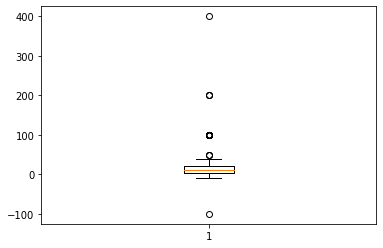

In [74]:
plt.boxplot(df_pattern['Qta'])

In [75]:
print("Total products: ", len(df_pattern))
print("Products with a quantity > 20: ", len(df_pattern[df_pattern['Qta']>=20]))
print("Products with a quantity [0-20]: ", len(df_pattern[(df_pattern['Qta']<20) & (df_pattern['Qta']>0)]))

Total products:  681
Products with a quantity > 20:  199
Products with a quantity [0-20]:  471


In [80]:
# # Orders per customer
# for customer in df_pattern['CustomerID'].unique():
#     print("### Customer : ", customer)
#     print(df_pattern[(df_pattern['CustomerID'] == customer)][['BasketDate', 'Qta', "ProdDescr"]])

More or less same behaviour:
- Warehouses
- Reseller
- Customer (rare)

In [97]:
# Orders per customer
# ['JUMBO BAG DOILEY PATTERNS', 'LUNCH BAG DOILEY PATTERN ']
prod_1, prod_2 = patterns[1553][0][0]
# print(prod_1, prod_2, sep=" - ")
total = 0
ratio = 0
counter = {i:0 for i in range(1,9)}
valid_basketid = []
for order in df_pattern['BasketID'].unique():
    df_aux = df_pattern[df_pattern['BasketID'] == order]
    pattern = {prod_1:False, prod_2:False}
    for _, row in df_aux.iterrows():
        if row['ProdID'] == prod_1:
            pattern[prod_1] = True
        if row['ProdID'] == prod_2:
            pattern[prod_2] = True
    if all(pattern.values()):
        valid_basketid.append(order)
print("Orders that contains the subsequence / total number of orders: ", len(valid_basketid), "/", len(df_pattern['BasketID'].unique()))
for customer in df_pattern['CustomerID'].unique():
    df_aux = df_pattern[(df_pattern['CustomerID'] == customer)][['BasketID', 'BasketDate', 'Qta', "ProdID"]]
    customer_total = 0
    qt_x = 0
    qt_y = 0
    for basket in df_aux['BasketID'].unique():
        if basket in valid_basketid:
            df_appo = df_aux[df_aux['BasketID'] == basket]
            pattern = {prod_1:False, prod_2:False}
            for _,row in df_appo.iterrows():
                if row['ProdID'] == prod_1:
                    if not pattern[prod_1]:
                        qt_x += row['Qta']
                    pattern[prod_1] = True
                if row['ProdID'] == prod_2:
                    if not pattern[prod_2]:
                        qt_y += row['Qta']
                    pattern[prod_2] = True
                if all(pattern.values()):
                    customer_total += 1
                    counter[customer_total] += 1
                    pattern = {prod_1:False, prod_2:False}
    total += customer_total
    ratio += qt_x/qt_y
print("Average: ", total/len(df_pattern['CustomerID'].unique()))
print("Sequence Counter among orders: ", counter)
print(f"Ratio between JUMBO BAG DOILEY PATTERNS[ID:{prod_1}] & #LUNCH BAG DOILEY PATTERN[ID:{prod_2}]: {ratio/len(df_pattern['CustomerID'].unique())}")

Orders that contains the subsequence / total number of orders:  203 / 469
Average:  3.171875
Sequence Counter among orders:  {1: 64, 2: 54, 3: 41, 4: 27, 5: 7, 6: 6, 7: 3, 8: 1}
Ratio between JUMBO BAG DOILEY PATTERNS[ID:23203] & #LUNCH BAG DOILEY PATTERN[ID:23209]: 1.3156715747733925


The sequence [['JUMBO BAG DOILEY PATTERNS', 'LUNCH BAG DOILEY PATTERN '], ['JUMBO BAG DOILEY PATTERNS']] , which is common for the ~6% of the customers has some interesting characteristics, especially if we focus about the sequence ['JUMBO BAG DOILEY PATTERNS', 'LUNCH BAG DOILEY PATTERN ']:
- The subpattern is frequent among the customers in fact on average the have it at least 3 times (above the full distribution)
- A customer that buys the jumbo bag is likely to buy the the lunch bag too, in fact almost 50% of the orders contains the subsequence
- Jumbo bag still seems to be the more relevant item since its quantity is greater than the lunch bag one, but also as we can see in the pattern jumbo bag is common by its own